<a href="https://colab.research.google.com/github/maneri13/Data-Science-Experiments/blob/master/Corona_Dataset_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Corona Dataset 2

## Imports

In [4]:
# !pip install automl
 
import scipy.io 
import numpy as np
import pandas as pd
import csv
import seaborn as sn
 
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing, metrics
 
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
 
from sklearn import datasets
from sklearn.decomposition import PCA
from google.colab import files

## Data Load & Drive Mount

In [5]:
uploaded = files.upload()

Saving Radiomics_Features.csv to Radiomics_Features.csv


In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

## Dataset 2

In [6]:
df = pd.read_csv("Radiomics_Features.csv")
patients = pd.DataFrame(df['Patient ID'], columns=['id'])
# count= patients[0].sort_index()
print(df.head(5))
 
patients = df['Patient ID']
classes = df['Label_15mm'] 
df = df.drop("Patient ID", axis= 1)
df = df.drop("Label_15mm", axis= 1)

   Patient ID  ...  Label_15mm
0           1  ...           1
1           1  ...           1
2           1  ...           1
3           1  ...           0
4           1  ...           1

[5 rows x 856 columns]


In [7]:
indices = []
start_value = 0
end_value = -1
count= patients.value_counts().sort_index()
print(count)

for i in range(1,14):
    start_value = end_value + 1
    end_value = start_value + count[i] - 1
    indices.append([start_value, end_value])
print(indices)

1     51
2     28
3     57
4     38
5     38
6     52
7     20
8     16
9     44
10    64
11    67
12    55
13    55
Name: Patient ID, dtype: int64
[[0, 50], [51, 78], [79, 135], [136, 173], [174, 211], [212, 263], [264, 283], [284, 299], [300, 343], [344, 407], [408, 474], [475, 529], [530, 584]]


## Methods

In [8]:
def leave_one_out(df, patient):
    start_value = indices[patient][0]
    end_value = indices[patient][1]
    print("This is the starting index: " + str(start_value) + " of patient " + str(patient))
    
    #Select test and train data by leaving one out
    test = df.iloc[start_value: end_value].values  # select values from start index to end index. 
    idx = df.index.difference(df.index[start_value:end_value])
    train = df.loc[idx].values # Select the values that were not selected in test set

    # Select class values for same indices
    test_class = classes.iloc[start_value: end_value].values # select values from start index to end index.
    idx = classes.index.difference(classes.index[start_value:end_value])
    train_class = classes.loc[idx].values #Select the values that were not selected in test set

    # Perform normalization on datasets
    min_max_scaler = preprocessing.MinMaxScaler()
    train = min_max_scaler.fit_transform(train)
    test = min_max_scaler.transform(test)
    
    return test, train, test_class, train_class

### AutoSKLearn
https://automl.github.io/auto-sklearn/master/

This section will be used to give us an idea about the kind of classifiers we should be looking at based on the recommendations made by AutoSklearn. This seems like a better approach than making human guesses as we are dealing with a novel, complex dataset that can change with every patient.

These suggestions will be used to train and test the models with different variations to give us a comparative look at the data. 

In [ ]:
# from auto_ml import Predictor
# from auto_ml.utils import get_boston_dataset
# from auto_ml.utils_models import load_ml_model
!sudo apt-get install build-essential swig
!pip install auto-sklearn
import autosklearn.classification
from autosklearn.experimental.askl2 import AutoSklearn2Classifier

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier()
for i in range(1,14):
    test, train, test_class, train_class = leave_one_out(df,i)
    automl.fit(train, train_class.ravel())
    y_hat = automl.predict(test)
    print(automl.sprint_statistics())
    # print(automl.cv_results_)
    print(automl.show_models())
    print("Accuracy score", sklearn.metrics.accuracy_score(test, test_class.ravel()))

This is the starting index: 51 of patient 1
auto-sklearn results:
  Dataset name: 0bfde15a78f45adcfb8c603213371422
  Metric: accuracy
  Best validation score: 0.713514
  Number of target algorithm runs: 356
  Number of successful target algorithm runs: 297
  Number of crashed target algorithm runs: 26
  Number of target algorithms that exceeded the time limit: 2
  Number of target algorithms that exceeded the memory limit: 31

[(0.220000, SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'decision_tree', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'liblinear_svc_preprocessor', 'classifier:decision_tree:criterion': 'gi

ValueError: ignored

## Models

In [11]:
x_axis_labels = ['T','F'] # labels for x-axis
y_axis_labels = ['T','F'] # labels for y-axis

### Random Forests

#### Baseline

This is the starting index: 0 of patient 0
0.58
[(1, 0, array([0.69, 0.31])), (1, 1, array([0.12, 0.88])), (1, 1, array([0.39, 0.61])), (0, 1, array([0.39, 0.61])), (1, 0, array([0.58, 0.42])), (1, 0, array([0.5, 0.5])), (1, 1, array([0.37, 0.63])), (1, 1, array([0.07, 0.93])), (1, 1, array([0.25, 0.75])), (0, 0, array([0.69, 0.31])), (1, 1, array([0.33, 0.67])), (1, 1, array([0.29, 0.71])), (0, 0, array([0.51, 0.49])), (1, 1, array([0.01, 0.99])), (0, 0, array([0.69, 0.31])), (1, 1, array([0.41, 0.59])), (1, 0, array([0.69, 0.31])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.21, 0.79])), (1, 1, array([0.23, 0.77])), (1, 1, array([0.19, 0.81])), (1, 1, array([0.11, 0.89])), (1, 1, array([0.35, 0.65])), (0, 1, array([0.37, 0.63])), (1, 1, array([0.49, 0.51])), (1, 1, array([0.35, 0.65])), (1, 1, array([0.18, 0.82])), (0, 1, array([0.07, 0.93])), (1, 1, array([0.47, 0.53])), (1, 1, array([0.24, 0.76])), (1, 0, array([0.76, 0.24])), (1, 1, array([0.37, 0.63])), (1, 1, array([0.41, 0.59]))

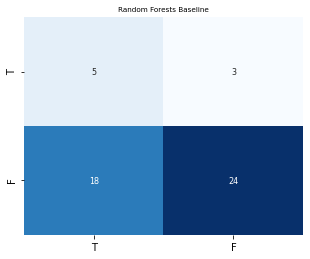

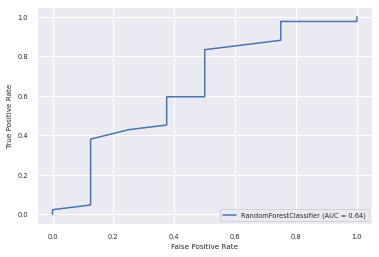

This is the starting index: 51 of patient 1
0.7777777777777778
[(0, 0, array([0.64, 0.36])), (0, 0, array([0.81, 0.19])), (0, 0, array([0.69, 0.31])), (0, 0, array([0.76, 0.24])), (0, 0, array([0.59, 0.41])), (0, 0, array([0.74, 0.26])), (0, 1, array([0.29, 0.71])), (0, 0, array([0.69, 0.31])), (0, 1, array([0.49, 0.51])), (0, 0, array([0.64, 0.36])), (0, 1, array([0.48, 0.52])), (0, 0, array([0.87, 0.13])), (0, 0, array([0.92, 0.08])), (0, 0, array([0.86, 0.14])), (0, 1, array([0.3, 0.7])), (0, 0, array([0.84, 0.16])), (0, 0, array([0.84, 0.16])), (0, 0, array([0.9, 0.1])), (0, 0, array([0.7, 0.3])), (0, 0, array([0.92, 0.08])), (0, 0, array([0.79, 0.21])), (0, 0, array([0.98, 0.02])), (0, 0, array([0.6, 0.4])), (0, 0, array([0.57, 0.43])), (0, 1, array([0.3, 0.7])), (0, 0, array([0.53, 0.47])), (0, 1, array([0.38, 0.62]))]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


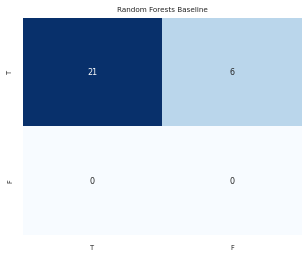

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


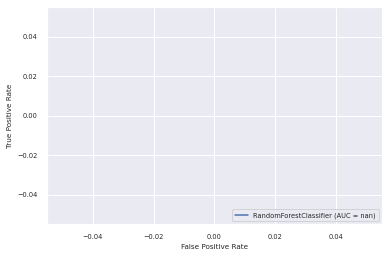

This is the starting index: 79 of patient 2
0.5714285714285714
[(0, 0, array([0.72, 0.28])), (0, 0, array([0.6, 0.4])), (1, 0, array([0.63, 0.37])), (0, 0, array([0.5, 0.5])), (1, 0, array([0.7, 0.3])), (1, 0, array([0.65, 0.35])), (1, 0, array([0.77, 0.23])), (1, 1, array([0.25, 0.75])), (1, 0, array([0.82, 0.18])), (1, 0, array([0.7, 0.3])), (1, 0, array([0.78, 0.22])), (0, 0, array([0.63, 0.37])), (1, 0, array([0.54, 0.46])), (0, 0, array([0.58, 0.42])), (0, 1, array([0.42, 0.58])), (1, 0, array([0.7, 0.3])), (0, 0, array([0.71, 0.29])), (0, 0, array([0.63, 0.37])), (0, 0, array([0.79, 0.21])), (0, 0, array([0.58, 0.42])), (0, 0, array([0.57, 0.43])), (0, 1, array([0.29, 0.71])), (0, 0, array([0.59, 0.41])), (1, 1, array([0.33, 0.67])), (1, 0, array([0.73, 0.27])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.55, 0.45])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.27, 0.73])), (1, 0, array([0.71, 0.29])), (1, 1, array([0.39, 0.61])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.77, 0.23

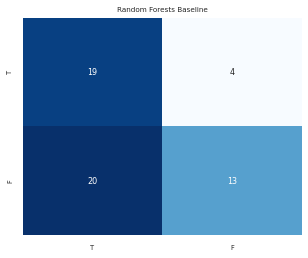

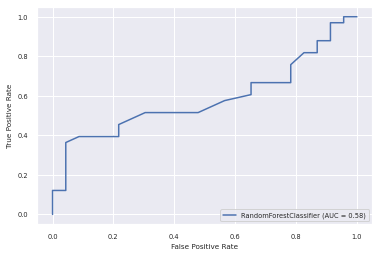

This is the starting index: 136 of patient 3
0.5675675675675675
[(1, 1, array([0.17, 0.83])), (1, 1, array([0.14, 0.86])), (1, 0, array([0.65, 0.35])), (1, 0, array([0.59, 0.41])), (1, 1, array([0.34, 0.66])), (1, 1, array([0.32, 0.68])), (1, 0, array([0.54, 0.46])), (1, 0, array([0.51, 0.49])), (0, 0, array([0.53, 0.47])), (1, 1, array([0.23, 0.77])), (1, 1, array([0.43, 0.57])), (1, 0, array([0.57, 0.43])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.42, 0.58])), (1, 0, array([0.51, 0.49])), (1, 0, array([0.51, 0.49])), (0, 1, array([0.32, 0.68])), (0, 1, array([0.48, 0.52])), (1, 1, array([0.38, 0.62])), (1, 1, array([0.22, 0.78])), (1, 0, array([0.58, 0.42])), (0, 1, array([0.49, 0.51])), (1, 1, array([0.38, 0.62])), (0, 1, array([0.4, 0.6])), (1, 0, array([0.71, 0.29])), (0, 1, array([0.42, 0.58])), (1, 0, array([0.51, 0.49])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.14, 0.86])), (1, 1, array([0.15, 0.85])), (1, 1, array([0.13, 0.87])), (1, 1, array([0.31, 0.69])), (1, 1, arra

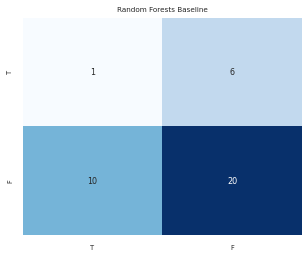

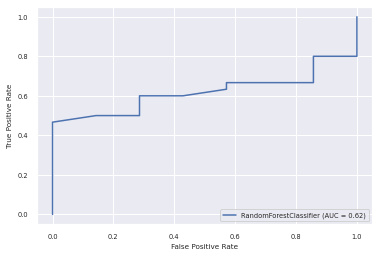

This is the starting index: 174 of patient 4
0.7027027027027027
[(0, 0, array([0.6, 0.4])), (0, 1, array([0.46, 0.54])), (1, 1, array([0.07, 0.93])), (0, 0, array([0.75, 0.25])), (1, 0, array([0.77, 0.23])), (0, 0, array([0.63, 0.37])), (1, 1, array([0.08, 0.92])), (0, 0, array([0.73, 0.27])), (1, 0, array([0.55, 0.45])), (0, 1, array([0.34, 0.66])), (0, 1, array([0.23, 0.77])), (0, 0, array([0.63, 0.37])), (0, 0, array([0.58, 0.42])), (0, 0, array([0.57, 0.43])), (0, 0, array([0.56, 0.44])), (0, 1, array([0.46, 0.54])), (1, 1, array([0.19, 0.81])), (0, 1, array([0.22, 0.78])), (0, 0, array([0.54, 0.46])), (0, 0, array([0.59, 0.41])), (0, 1, array([0.43, 0.57])), (0, 0, array([0.78, 0.22])), (1, 1, array([0.23, 0.77])), (0, 1, array([0.11, 0.89])), (1, 0, array([0.59, 0.41])), (1, 1, array([0.13, 0.87])), (0, 0, array([0.59, 0.41])), (0, 0, array([0.55, 0.45])), (1, 1, array([0.25, 0.75])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13, 0.87])), (0, 1, array([0.35, 0.65])), (0, 0, arra

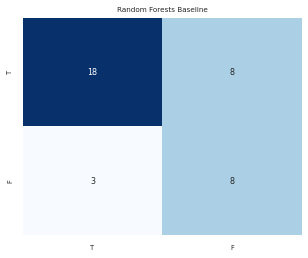

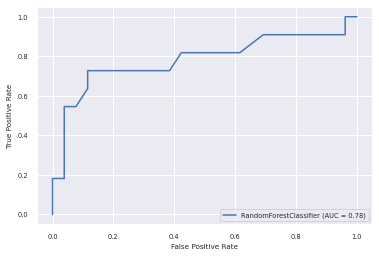

This is the starting index: 212 of patient 5
0.35294117647058826
[(1, 0, array([0.6, 0.4])), (1, 1, array([0.09, 0.91])), (0, 1, array([0.49, 0.51])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([0.51, 0.49])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.3, 0.7])), (0, 0, array([0.5, 0.5])), (0, 1, array([0.04, 0.96])), (0, 1, array([0.09, 0.91])), (0, 1, array([0.36, 0.64])), (0, 1, array([0.06, 0.94])), (0, 1, array([0.3, 0.7])), (0, 1, array([0.09, 0.91])), (0, 0, array([0.51, 0.49])), (0, 1, array([0.02, 0.98])), (0, 0, array([0.61, 0.39])), (0, 1, array([0.14, 0.86])), (0, 1, array([0.25, 0.75])), (0, 1, array([0.18, 0.82])), (0, 1, array([0.43, 0.57])), (0, 0, array([0.53, 0.47])), (0, 1, array([0.09, 0.91])), (0, 1, array([0.11, 0.89])), (0, 1, array([0.27, 0.73])), (0, 0, array([1., 0.])), (0, 1, array([0.02, 0.98])), (0, 1, array([0.47, 0.53])), (0, 1, array([0.2, 0.8])), (0, 1, array([0.16, 0.84])), (0, 1, array([0.04, 0.96])), (0, 1, array([0.32, 0.68])), (

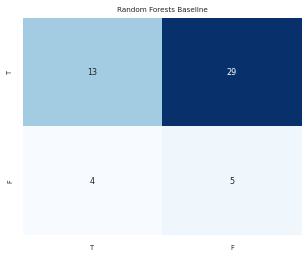

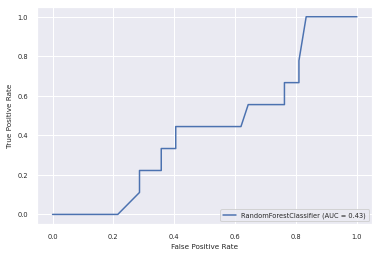

This is the starting index: 264 of patient 6
0.6842105263157895
[(0, 1, array([0.45, 0.55])), (0, 1, array([0.49, 0.51])), (1, 1, array([0.39, 0.61])), (0, 0, array([0.52, 0.48])), (0, 0, array([0.59, 0.41])), (1, 0, array([0.61, 0.39])), (0, 0, array([0.55, 0.45])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.47, 0.53])), (0, 1, array([0.47, 0.53])), (1, 1, array([0.37, 0.63])), (0, 1, array([0.43, 0.57])), (1, 1, array([0.49, 0.51])), (1, 1, array([0.19, 0.81])), (0, 1, array([0.44, 0.56])), (1, 1, array([0.27, 0.73])), (1, 1, array([0.27, 0.73])), (0, 0, array([0.56, 0.44])), (0, 0, array([0.61, 0.39]))]


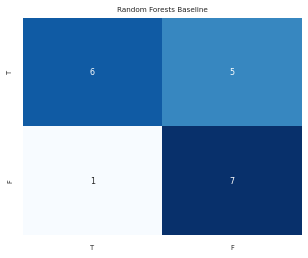

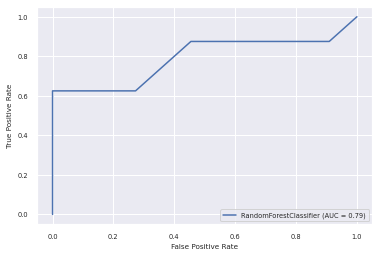

This is the starting index: 284 of patient 7
0.4666666666666667
[(0, 1, array([0.35, 0.65])), (0, 1, array([0.43, 0.57])), (0, 1, array([0.42, 0.58])), (0, 0, array([0.65, 0.35])), (0, 0, array([0.58, 0.42])), (0, 1, array([0.27, 0.73])), (0, 1, array([0.32, 0.68])), (0, 1, array([0.46, 0.54])), (0, 1, array([0.08, 0.92])), (0, 1, array([0.44, 0.56])), (1, 1, array([0.09, 0.91])), (0, 0, array([0.52, 0.48])), (0, 0, array([0.59, 0.41])), (0, 0, array([0.56, 0.44])), (0, 0, array([0.59, 0.41]))]


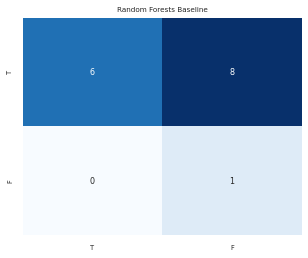

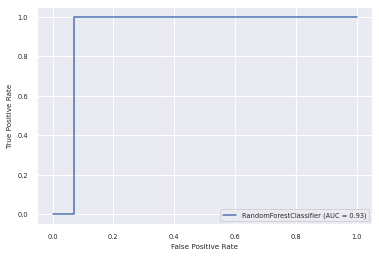

This is the starting index: 300 of patient 8
0.7674418604651163
[(0, 0, array([0.62, 0.38])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.76, 0.24])), (0, 1, array([0.31, 0.69])), (0, 1, array([0.37, 0.63])), (0, 0, array([0.78, 0.22])), (0, 1, array([0.37, 0.63])), (0, 0, array([0.82, 0.18])), (0, 0, array([0.5, 0.5])), (0, 0, array([0.61, 0.39])), (0, 0, array([0.51, 0.49])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.7, 0.3])), (0, 0, array([0.8, 0.2])), (1, 1, array([0.26, 0.74])), (0, 1, array([0.49, 0.51])), (1, 1, array([0.05, 0.95])), (1, 1, array([0.2, 0.8])), (0, 0, array([0.65, 0.35])), (0, 0, array([0.54, 0.46])), (1, 1, array([0.02, 0.98])), (0, 0, array([0.61, 0.39])), (1, 1, array([0.31, 0.69])), (1, 1, array([0.09, 0.91])), (1, 1, array([0.09, 0.91])), (1, 1, array([0.04, 0.96])), (1, 1, array([0.15, 0.85])), (1, 1, array([0.02, 0.98])), (0, 1, array([0.35, 0.65])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.47, 0.53])), (1, 1, array([0.06, 0.94])), (1, 1, array([0.27, 0

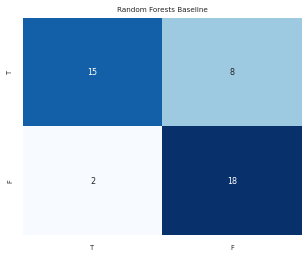

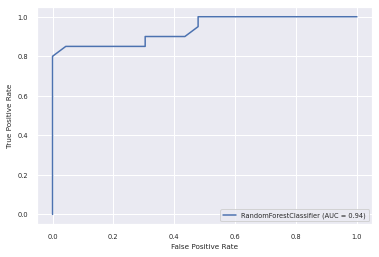

This is the starting index: 344 of patient 9
0.6507936507936508
[(1, 0, array([0.78, 0.22])), (1, 0, array([0.72, 0.28])), (0, 0, array([0.57, 0.43])), (1, 0, array([0.59, 0.41])), (1, 1, array([0.43, 0.57])), (1, 1, array([0.47, 0.53])), (1, 0, array([0.66, 0.34])), (0, 0, array([0.66, 0.34])), (0, 0, array([0.52, 0.48])), (0, 0, array([0.5, 0.5])), (0, 1, array([0.48, 0.52])), (0, 0, array([0.62, 0.38])), (0, 0, array([0.9, 0.1])), (0, 0, array([0.69, 0.31])), (0, 0, array([0.66, 0.34])), (0, 0, array([0.57, 0.43])), (0, 0, array([0.58, 0.42])), (1, 0, array([0.69, 0.31])), (0, 0, array([0.53, 0.47])), (0, 0, array([0.75, 0.25])), (1, 0, array([0.7, 0.3])), (1, 0, array([0.51, 0.49])), (0, 0, array([0.62, 0.38])), (0, 0, array([0.75, 0.25])), (1, 0, array([0.63, 0.37])), (0, 0, array([0.58, 0.42])), (1, 1, array([0.39, 0.61])), (0, 0, array([0.64, 0.36])), (1, 0, array([0.58, 0.42])), (1, 0, array([0.67, 0.33])), (0, 0, array([0.62, 0.38])), (1, 1, array([0.32, 0.68])), (1, 0, array(

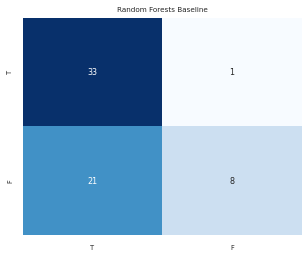

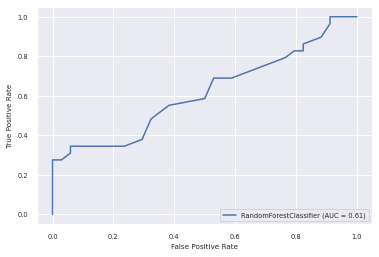

This is the starting index: 408 of patient 10
0.7575757575757576
[(1, 1, array([0.27, 0.73])), (1, 1, array([0.25, 0.75])), (1, 1, array([0.23, 0.77])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.35, 0.65])), (1, 1, array([0.26, 0.74])), (1, 1, array([0.07, 0.93])), (1, 0, array([0.58, 0.42])), (1, 1, array([0.33, 0.67])), (0, 0, array([0.51, 0.49])), (0, 0, array([0.57, 0.43])), (1, 1, array([0.22, 0.78])), (1, 1, array([0.24, 0.76])), (1, 1, array([0.09, 0.91])), (1, 1, array([0.17, 0.83])), (0, 0, array([0.68, 0.32])), (1, 0, array([0.68, 0.32])), (1, 0, array([0.63, 0.37])), (0, 0, array([0.62, 0.38])), (1, 1, array([0.14, 0.86])), (0, 1, array([0.4, 0.6])), (1, 0, array([0.65, 0.35])), (0, 0, array([0.71, 0.29])), (1, 1, array([0.35, 0.65])), (1, 1, array([0.14, 0.86])), (0, 0, array([0.63, 0.37])), (1, 0, array([0.55, 0.45])), (1, 1, array([0.39, 0.61])), (1, 1, array([0.17, 0.83])), (1, 0, array([0.5, 0.5])), (1, 1, array([0.34, 0.66])), (1, 1, array([0.47, 0.53])), (1, 1, arr

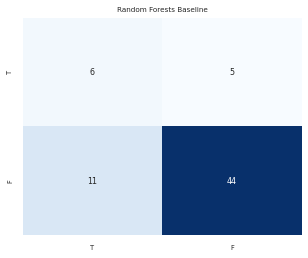

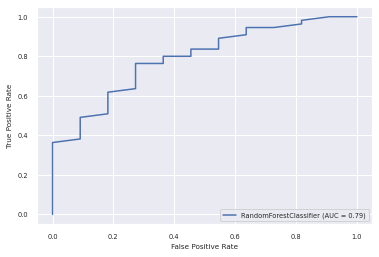

This is the starting index: 475 of patient 11
0.7222222222222222
[(0, 0, array([0.93, 0.07])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.25, 0.75])), (1, 1, array([0.38, 0.62])), (0, 1, array([0.41, 0.59])), (1, 1, array([0.1, 0.9])), (1, 0, array([0.66, 0.34])), (1, 1, array([0.32, 0.68])), (1, 1, array([0.08, 0.92])), (1, 1, array([0.23, 0.77])), (1, 1, array([0.25, 0.75])), (0, 0, array([0.61, 0.39])), (1, 1, array([0.22, 0.78])), (1, 1, array([0.32, 0.68])), (1, 1, array([0.25, 0.75])), (1, 0, array([0.63, 0.37])), (1, 1, array([0.32, 0.68])), (1, 1, array([0.41, 0.59])), (1, 1, array([0.31, 0.69])), (1, 1, array([0.3, 0.7])), (1, 0, array([0.77, 0.23])), (1, 0, array([0.5, 0.5])), (1, 1, array([0.22, 0.78])), (1, 1, array([0.33, 0.67])), (1, 1, array([0.43, 0.57])), (0, 0, array([0.55, 0.45])), (1, 0, array([0.57, 0.43])), (1, 1, array([0.4, 0.6])), (0, 0, array([0.69, 0.31])), (1, 1, array([0.21, 0.79])), (1, 0, array([0.5, 0.5])), (1, 0, array([0.56, 0.44])), (1, 1, array([0.14

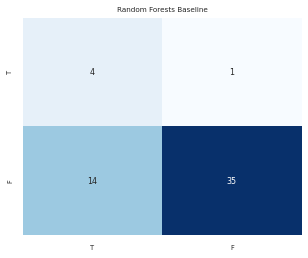

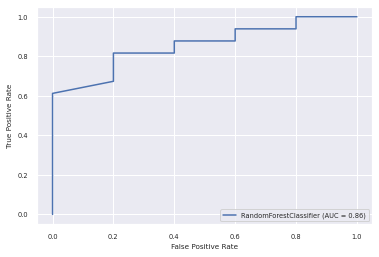

This is the starting index: 530 of patient 12
0.6851851851851852
[(1, 1, array([0.33, 0.67])), (1, 0, array([0.77, 0.23])), (1, 0, array([0.74, 0.26])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.69, 0.31])), (1, 0, array([0.54, 0.46])), (1, 1, array([0.21, 0.79])), (0, 0, array([0.68, 0.32])), (0, 0, array([0.63, 0.37])), (1, 0, array([0.85, 0.15])), (1, 1, array([0.14, 0.86])), (1, 1, array([0.2, 0.8])), (1, 0, array([0.83, 0.17])), (1, 1, array([0.14, 0.86])), (1, 1, array([0.12, 0.88])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.14, 0.86])), (1, 1, array([0.17, 0.83])), (1, 0, array([0.59, 0.41])), (1, 1, array([0.19, 0.81])), (1, 1, array([0.15, 0.85])), (1, 0, array([0.67, 0.33])), (1, 1, array([0.14, 0.86])), (1, 0, array([0.74, 0.26])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.05, 0.95])), (1, 0, array([0.64, 0.36])), (1, 1, array([0.22, 0.78])), (1, 1, array([0.24, 0.76])), (1, 1, array([0.12, 0.88])), (1, 1, array([0.38, 0.62])), (1, 0, array

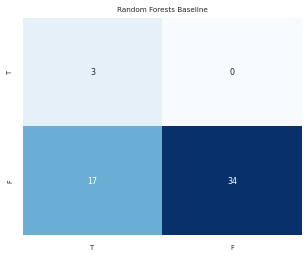

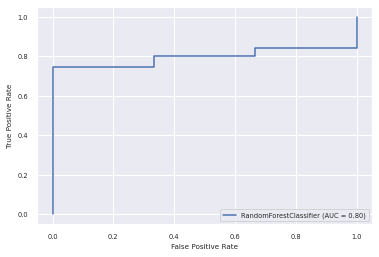

<function matplotlib.pyplot.show>

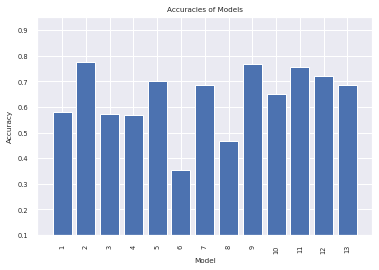

In [ ]:
Accuracy = []

clf = RandomForestClassifier()

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result) 
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### GridSearch

In [ ]:
parameters = {
    'n_estimators'      : [320,330,340],
    'max_depth'         : [8, 9, 10, 11, 12],
    'random_state'      : [0],
    #'max_features': ['auto'],
    #'criterion' :['gini']
}


for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    search = GridSearchCV(RandomForestClassifier(), parameters, cv=10, n_jobs=-1)
    search.fit(train, train_class.ravel())

    print(search.score(train, train_class.ravel()))
    print(search.best_params_)

This is the starting index: 0 of patient 0
1.0
{'max_depth': 11, 'n_estimators': 340, 'random_state': 0}
This is the starting index: 51 of patient 1
1.0
{'max_depth': 12, 'n_estimators': 340, 'random_state': 0}
This is the starting index: 79 of patient 2
0.998109640831758
{'max_depth': 10, 'n_estimators': 320, 'random_state': 0}
This is the starting index: 136 of patient 3
1.0
{'max_depth': 9, 'n_estimators': 330, 'random_state': 0}
This is the starting index: 174 of patient 4
1.0
{'max_depth': 10, 'n_estimators': 320, 'random_state': 0}
This is the starting index: 212 of patient 5
1.0
{'max_depth': 12, 'n_estimators': 320, 'random_state': 0}
This is the starting index: 264 of patient 6
1.0
{'max_depth': 11, 'n_estimators': 340, 'random_state': 0}
This is the starting index: 284 of patient 7
0.9929824561403509
{'max_depth': 9, 'n_estimators': 340, 'random_state': 0}
This is the starting index: 300 of patient 8
0.9907749077490775
{'max_depth': 9, 'n_estimators': 340, 'random_state': 0}


This is the starting index: 0 of patient 0
0.8045375218150087
[([1], 0, array([0.57284126, 0.42715874])), ([1], 1, array([0.48932682, 0.51067318])), ([0], 1, array([0.39420834, 0.60579166])), ([1], 0, array([0.80035357, 0.19964643])), ([1], 1, array([0.23235413, 0.76764587])), ([0], 0, array([0.83932566, 0.16067434])), ([1], 0, array([0.68514769, 0.31485231])), ([0], 0, array([0.54590143, 0.45409857])), ([1], 1, array([0.27859981, 0.72140019])), ([0], 0, array([0.56782384, 0.43217616])), ([0], 0, array([0.63907165, 0.36092835])), ([1], 0, array([0.51124361, 0.48875639])), ([1], 0, array([0.63642427, 0.36357573])), ([0], 0, array([0.66801869, 0.33198131])), ([1], 1, array([0.37616346, 0.62383654])), ([1], 1, array([0.34833366, 0.65166634])), ([1], 0, array([0.5043171, 0.4956829])), ([1], 0, array([0.80167884, 0.19832116])), ([1], 0, array([0.57717741, 0.42282259])), ([1], 1, array([0.33865695, 0.66134305])), ([0], 0, array([0.65232985, 0.34767015])), ([1], 0, array([0.80705377, 0.192946

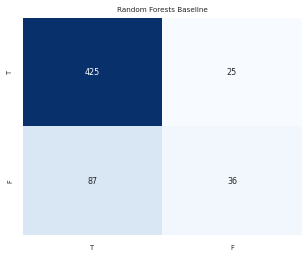

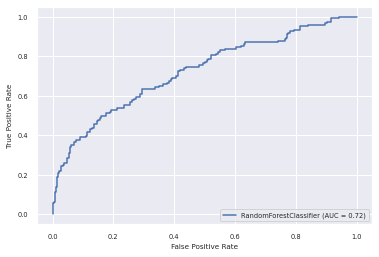

This is the starting index: 574 of patient 1
0.7424892703862661
[([0], 1, array([0.38609686, 0.61390314])), ([0], 1, array([0.3780664, 0.6219336])), ([0], 0, array([0.76667559, 0.23332441])), ([0], 1, array([0.40070886, 0.59929114])), ([0], 1, array([0.47012699, 0.52987301])), ([0], 0, array([0.72528135, 0.27471865])), ([1], 1, array([0.42962028, 0.57037972])), ([0], 0, array([0.52661115, 0.47338885])), ([0], 0, array([0.63352799, 0.36647201])), ([0], 0, array([0.76645393, 0.23354607])), ([0], 0, array([0.75103238, 0.24896762])), ([0], 1, array([0.45867361, 0.54132639])), ([1], 1, array([0.49933973, 0.50066027])), ([0], 0, array([0.55501917, 0.44498083])), ([0], 0, array([0.75374421, 0.24625579])), ([0], 0, array([0.64709501, 0.35290499])), ([0], 0, array([0.54636065, 0.45363935])), ([0], 0, array([0.53556842, 0.46443158])), ([1], 0, array([0.63398174, 0.36601826])), ([0], 0, array([0.68286169, 0.31713831])), ([1], 1, array([0.1848597, 0.8151403])), ([0], 0, array([0.72250524, 0.277494

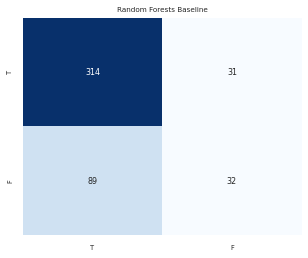

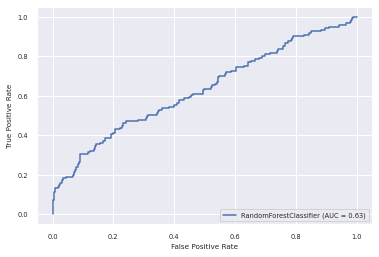

This is the starting index: 1041 of patient 2
0.28668941979522183
[([1], 1, array([0.3362732, 0.6637268])), ([0], 0, array([0.50574705, 0.49425295])), ([0], 1, array([0.41812298, 0.58187702])), ([1], 1, array([0.11949046, 0.88050954])), ([0], 1, array([0.41627077, 0.58372923])), ([0], 1, array([0.40414508, 0.59585492])), ([0], 1, array([0.37136166, 0.62863834])), ([1], 1, array([0.1530973, 0.8469027])), ([1], 1, array([0.40592624, 0.59407376])), ([1], 1, array([0.33474552, 0.66525448])), ([1], 1, array([0.31990179, 0.68009821])), ([1], 1, array([0.43217575, 0.56782425])), ([1], 1, array([0.3395987, 0.6604013])), ([0], 1, array([0.46059582, 0.53940418])), ([1], 1, array([0.48925017, 0.51074983])), ([1], 1, array([0.30150164, 0.69849836])), ([0], 1, array([0.28495718, 0.71504282])), ([0], 1, array([0.2826461, 0.7173539])), ([0], 1, array([0.2229137, 0.7770863])), ([0], 0, array([0.53960554, 0.46039446])), ([0], 1, array([0.1610194, 0.8389806])), ([0], 1, array([0.29291169, 0.70708831])),

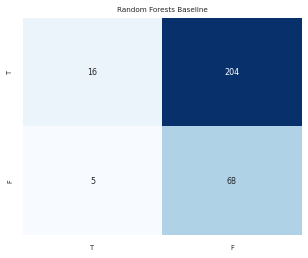

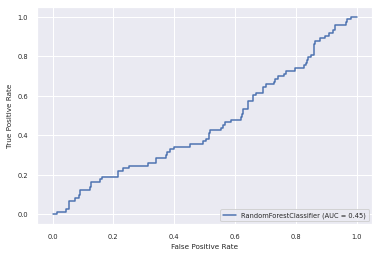

This is the starting index: 1335 of patient 3
0.6693121693121693
[([0], 0, array([0.66189746, 0.33810254])), ([1], 0, array([0.5814688, 0.4185312])), ([1], 1, array([0.3381405, 0.6618595])), ([1], 1, array([0.35180941, 0.64819059])), ([1], 1, array([0.20617218, 0.79382782])), ([1], 0, array([0.5755832, 0.4244168])), ([1], 1, array([0.48468971, 0.51531029])), ([0], 1, array([0.43302028, 0.56697972])), ([0], 0, array([0.64957538, 0.35042462])), ([0], 0, array([0.62211073, 0.37788927])), ([0], 1, array([0.46081044, 0.53918956])), ([0], 0, array([0.76453779, 0.23546221])), ([0], 0, array([0.50643374, 0.49356626])), ([1], 0, array([0.69750097, 0.30249903])), ([0], 0, array([0.63647793, 0.36352207])), ([0], 0, array([0.5008197, 0.4991803])), ([0], 0, array([0.63048126, 0.36951874])), ([0], 1, array([0.21249273, 0.78750727])), ([0], 0, array([0.61983848, 0.38016152])), ([0], 0, array([0.55132821, 0.44867179])), ([0], 0, array([0.68115657, 0.31884343])), ([0], 1, array([0.4403967, 0.5596033]))

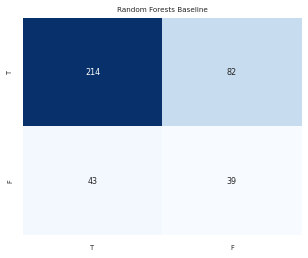

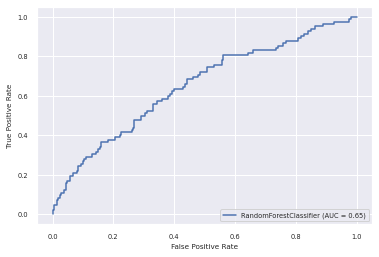

This is the starting index: 1714 of patient 4
0.46179401993355484
[([1], 1, array([0.47553184, 0.52446816])), ([1], 1, array([0.44384999, 0.55615001])), ([1], 0, array([0.59983563, 0.40016437])), ([1], 1, array([0.4223699, 0.5776301])), ([1], 1, array([0.42243396, 0.57756604])), ([1], 0, array([0.5440246, 0.4559754])), ([1], 0, array([0.56982791, 0.43017209])), ([1], 0, array([0.53080694, 0.46919306])), ([1], 0, array([0.6346555, 0.3653445])), ([1], 0, array([0.53625572, 0.46374428])), ([1], 0, array([0.54083996, 0.45916004])), ([1], 0, array([0.50379384, 0.49620616])), ([1], 1, array([0.45083321, 0.54916679])), ([1], 1, array([0.49786571, 0.50213429])), ([1], 1, array([0.43365646, 0.56634354])), ([1], 1, array([0.40600238, 0.59399762])), ([1], 1, array([0.39305444, 0.60694556])), ([1], 0, array([0.53536092, 0.46463908])), ([1], 1, array([0.41095152, 0.58904848])), ([1], 1, array([0.30375314, 0.69624686])), ([1], 1, array([0.42898217, 0.57101783])), ([1], 1, array([0.26893826, 0.731061

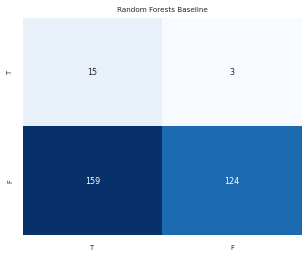

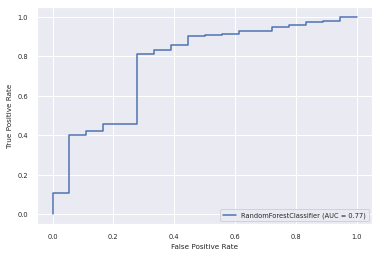

This is the starting index: 2016 of patient 5
0.4634146341463415
[([0], 0, array([0.61863472, 0.38136528])), ([0], 0, array([0.69653835, 0.30346165])), ([0], 0, array([0.80187737, 0.19812263])), ([0], 0, array([0.75088209, 0.24911791])), ([0], 0, array([0.72899765, 0.27100235])), ([0], 0, array([0.93282996, 0.06717004])), ([1], 0, array([0.81904668, 0.18095332])), ([1], 0, array([0.85568345, 0.14431655])), ([1], 0, array([0.77192836, 0.22807164])), ([1], 0, array([0.77780461, 0.22219539])), ([0], 0, array([0.73632465, 0.26367535])), ([1], 0, array([0.83139428, 0.16860572])), ([0], 0, array([0.62522001, 0.37477999])), ([1], 0, array([0.62836133, 0.37163867])), ([1], 0, array([0.77426725, 0.22573275])), ([1], 0, array([0.85841705, 0.14158295])), ([1], 0, array([0.76075581, 0.23924419])), ([1], 0, array([0.82743293, 0.17256707])), ([1], 0, array([0.76246173, 0.23753827])), ([1], 0, array([0.75981242, 0.24018758])), ([1], 1, array([0.12120373, 0.87879627])), ([1], 0, array([0.73682371, 0.2

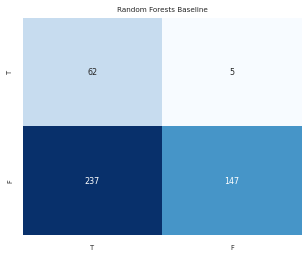

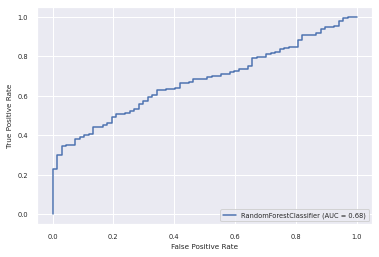

This is the starting index: 2468 of patient 6
0.5590551181102362
[([1], 1, array([0.45659288, 0.54340712])), ([1], 1, array([0.25285912, 0.74714088])), ([1], 1, array([0.40949976, 0.59050024])), ([1], 0, array([0.77139489, 0.22860511])), ([1], 0, array([0.66050863, 0.33949137])), ([1], 1, array([0.36091099, 0.63908901])), ([1], 1, array([0.18017979, 0.81982021])), ([1], 0, array([0.75813791, 0.24186209])), ([1], 0, array([0.60821022, 0.39178978])), ([1], 0, array([0.6964973, 0.3035027])), ([0], 0, array([0.88638767, 0.11361233])), ([1], 1, array([0.20742668, 0.79257332])), ([1], 0, array([0.65975799, 0.34024201])), ([1], 1, array([0.34225754, 0.65774246])), ([1], 0, array([0.56200546, 0.43799454])), ([1], 1, array([0.22170946, 0.77829054])), ([1], 1, array([0.10338822, 0.89661178])), ([1], 1, array([0.31443364, 0.68556636])), ([1], 1, array([0.34269724, 0.65730276])), ([0], 0, array([0.63011, 0.36989])), ([1], 0, array([0.57542819, 0.42457181])), ([1], 0, array([0.77160732, 0.22839268]

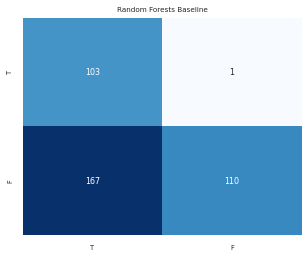

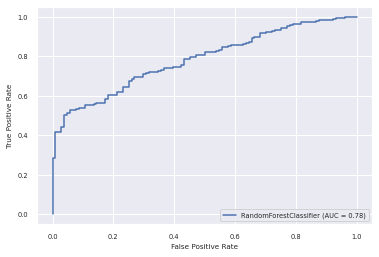

This is the starting index: 2850 of patient 7
0.843298969072165
[([0], 0, array([0.55643235, 0.44356765])), ([0], 0, array([0.82169784, 0.17830216])), ([0], 0, array([0.78141035, 0.21858965])), ([0], 0, array([0.5815307, 0.4184693])), ([0], 0, array([0.58906345, 0.41093655])), ([0], 0, array([0.68075202, 0.31924798])), ([0], 0, array([0.72662836, 0.27337164])), ([0], 0, array([0.76276875, 0.23723125])), ([0], 0, array([0.76961358, 0.23038642])), ([0], 0, array([0.80320235, 0.19679765])), ([0], 0, array([0.75546287, 0.24453713])), ([0], 0, array([0.87245248, 0.12754752])), ([0], 1, array([0.24125585, 0.75874415])), ([0], 1, array([0.36994347, 0.63005653])), ([0], 0, array([0.55363152, 0.44636848])), ([0], 0, array([0.85491918, 0.14508082])), ([0], 0, array([0.79365108, 0.20634892])), ([0], 0, array([0.72559484, 0.27440516])), ([0], 0, array([0.76559718, 0.23440282])), ([0], 0, array([0.66832454, 0.33167546])), ([0], 0, array([0.64483236, 0.35516764])), ([0], 0, array([0.8364718, 0.16352

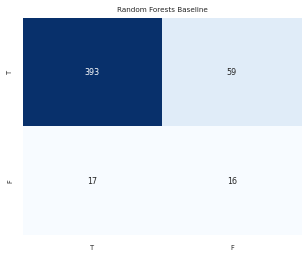

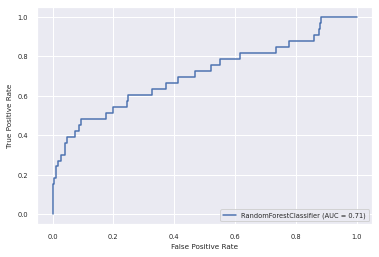

This is the starting index: 3336 of patient 8
0.740484429065744
[([1], 0, array([0.66264078, 0.33735922])), ([1], 1, array([0.36207367, 0.63792633])), ([0], 0, array([0.68099679, 0.31900321])), ([1], 0, array([0.67307235, 0.32692765])), ([1], 1, array([0.42428315, 0.57571685])), ([1], 1, array([0.30335812, 0.69664188])), ([1], 1, array([0.49392836, 0.50607164])), ([1], 1, array([0.21365565, 0.78634435])), ([1], 1, array([0.37961899, 0.62038101])), ([1], 1, array([0.31860078, 0.68139922])), ([0], 1, array([0.44337961, 0.55662039])), ([1], 1, array([0.42056582, 0.57943418])), ([0], 0, array([0.74684792, 0.25315208])), ([1], 1, array([0.38193903, 0.61806097])), ([1], 1, array([0.37898579, 0.62101421])), ([0], 0, array([0.76050049, 0.23949951])), ([0], 0, array([0.59902281, 0.40097719])), ([1], 0, array([0.71514932, 0.28485068])), ([1], 1, array([0.14301512, 0.85698488])), ([1], 0, array([0.64805129, 0.35194871])), ([1], 1, array([0.25230639, 0.74769361])), ([0], 0, array([0.60192136, 0.39

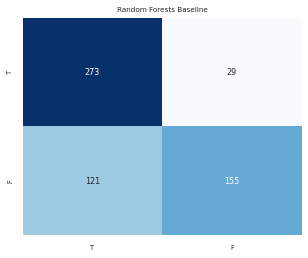

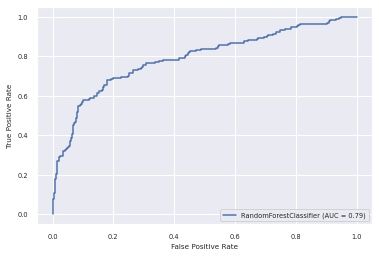

This is the starting index: 3915 of patient 9
0.5732142857142857
[([1], 1, array([0.28868546, 0.71131454])), ([1], 0, array([0.55944672, 0.44055328])), ([1], 1, array([0.48896791, 0.51103209])), ([1], 1, array([0.44097243, 0.55902757])), ([1], 1, array([0.40985503, 0.59014497])), ([1], 1, array([0.23717783, 0.76282217])), ([1], 0, array([0.72703997, 0.27296003])), ([1], 0, array([0.62882874, 0.37117126])), ([1], 1, array([0.45466183, 0.54533817])), ([1], 0, array([0.61001256, 0.38998744])), ([1], 1, array([0.21596995, 0.78403005])), ([1], 1, array([0.48724421, 0.51275579])), ([1], 1, array([0.31883324, 0.68116676])), ([1], 1, array([0.42069468, 0.57930532])), ([1], 0, array([0.52223004, 0.47776996])), ([1], 0, array([0.5878886, 0.4121114])), ([1], 1, array([0.47556146, 0.52443854])), ([1], 1, array([0.39819735, 0.60180265])), ([1], 1, array([0.49382208, 0.50617792])), ([1], 0, array([0.50733308, 0.49266692])), ([1], 1, array([0.35898099, 0.64101901])), ([1], 0, array([0.641646, 0.35835

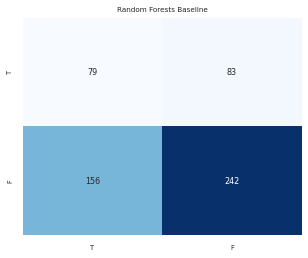

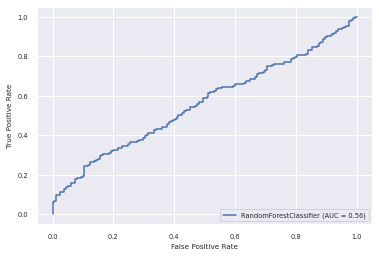

This is the starting index: 4476 of patient 10
0.8998144712430427
[([0], 0, array([0.61583309, 0.38416691])), ([0], 0, array([0.63361687, 0.36638313])), ([0], 0, array([0.67874862, 0.32125138])), ([0], 0, array([0.56415821, 0.43584179])), ([0], 0, array([0.71840118, 0.28159882])), ([0], 0, array([0.7607637, 0.2392363])), ([1], 1, array([0.40492647, 0.59507353])), ([1], 0, array([0.68572417, 0.31427583])), ([0], 0, array([0.72240132, 0.27759868])), ([0], 0, array([0.7962019, 0.2037981])), ([1], 1, array([0.38675962, 0.61324038])), ([1], 1, array([0.35303681, 0.64696319])), ([1], 0, array([0.61343425, 0.38656575])), ([0], 0, array([0.79195105, 0.20804895])), ([0], 0, array([0.73273345, 0.26726655])), ([0], 0, array([0.78555875, 0.21444125])), ([0], 0, array([0.76410071, 0.23589929])), ([0], 0, array([0.84843036, 0.15156964])), ([1], 1, array([0.28816897, 0.71183103])), ([0], 0, array([0.6087047, 0.3912953])), ([1], 0, array([0.78118471, 0.21881529])), ([0], 0, array([0.9154585, 0.0845415

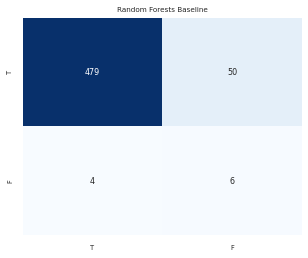

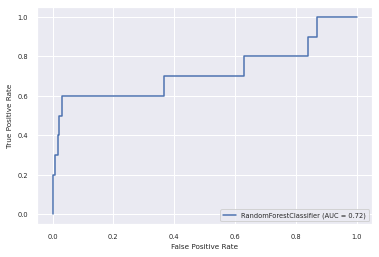

This is the starting index: 5016 of patient 11
0.7424242424242424
[([0], 0, array([0.65131557, 0.34868443])), ([0], 0, array([0.60907067, 0.39092933])), ([0], 0, array([0.83685995, 0.16314005])), ([0], 0, array([0.77378014, 0.22621986])), ([0], 0, array([0.5568519, 0.4431481])), ([0], 0, array([0.81640658, 0.18359342])), ([0], 1, array([0.49515424, 0.50484576])), ([0], 0, array([0.78146161, 0.21853839])), ([0], 0, array([0.74163867, 0.25836133])), ([0], 0, array([0.7592809, 0.2407191])), ([0], 0, array([0.72468116, 0.27531884])), ([0], 0, array([0.76026032, 0.23973968])), ([0], 0, array([0.77041258, 0.22958742])), ([1], 0, array([0.54994333, 0.45005667])), ([0], 0, array([0.69308248, 0.30691752])), ([1], 0, array([0.81068448, 0.18931552])), ([0], 0, array([0.58688672, 0.41311328])), ([0], 0, array([0.76567956, 0.23432044])), ([0], 0, array([0.82202092, 0.17797908])), ([1], 0, array([0.92994642, 0.07005358])), ([0], 0, array([0.80979145, 0.19020855])), ([0], 0, array([0.8277135, 0.17228

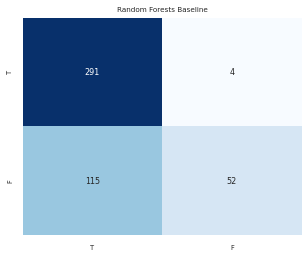

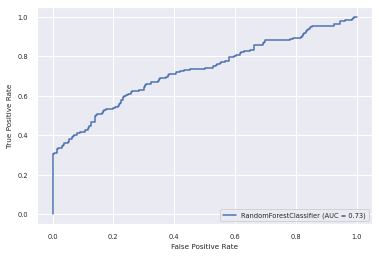

This is the starting index: 5479 of patient 12
0.2235294117647059
[([0], 1, array([0.36613328, 0.63386672])), ([0], 1, array([0.31153608, 0.68846392])), ([0], 1, array([0.31459495, 0.68540505])), ([0], 1, array([0.23198824, 0.76801176])), ([0], 1, array([0.35758474, 0.64241526])), ([0], 1, array([0.24468064, 0.75531936])), ([0], 1, array([0.34542682, 0.65457318])), ([0], 1, array([0.3254506, 0.6745494])), ([0], 1, array([0.31141018, 0.68858982])), ([0], 1, array([0.34527938, 0.65472062])), ([0], 1, array([0.2655577, 0.7344423])), ([0], 1, array([0.29506218, 0.70493782])), ([0], 1, array([0.32805702, 0.67194298])), ([0], 1, array([0.39014649, 0.60985351])), ([0], 1, array([0.14340797, 0.85659203])), ([0], 1, array([0.199135, 0.800865])), ([0], 1, array([0.3615104, 0.6384896])), ([0], 1, array([0.40696065, 0.59303935])), ([0], 1, array([0.37317034, 0.62682966])), ([0], 1, array([0.2786894, 0.7213106])), ([0], 1, array([0.37974812, 0.62025188])), ([0], 1, array([0.30523474, 0.69476526])),

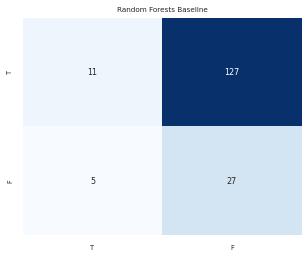

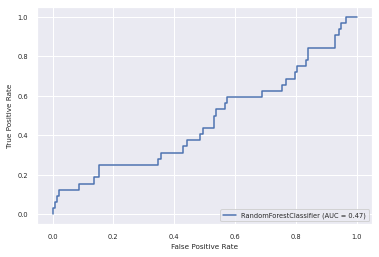

<function matplotlib.pyplot.show>

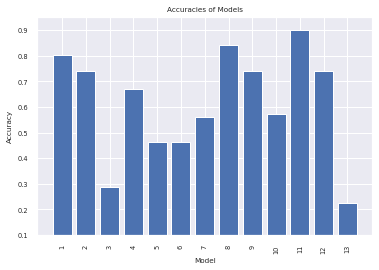

In [ ]:
Accuracy = []
clf = RandomForestClassifier(max_depth = 11, n_estimators= 320, random_state= 0)

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### Low Variance

This is the starting index: 0 of patient 0
0.58
[(1, 0, array([0.66, 0.34])), (1, 1, array([0.13, 0.87])), (1, 1, array([0.28, 0.72])), (0, 1, array([0.35, 0.65])), (1, 0, array([0.66, 0.34])), (1, 1, array([0.48, 0.52])), (1, 1, array([0.35, 0.65])), (1, 1, array([0.07, 0.93])), (1, 1, array([0.26, 0.74])), (0, 0, array([0.64, 0.36])), (1, 1, array([0.41, 0.59])), (1, 1, array([0.23, 0.77])), (0, 1, array([0.46, 0.54])), (1, 1, array([0.04, 0.96])), (0, 0, array([0.68, 0.32])), (1, 1, array([0.44, 0.56])), (1, 0, array([0.62, 0.38])), (1, 0, array([0.54, 0.46])), (1, 1, array([0.24, 0.76])), (1, 1, array([0.16, 0.84])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.05, 0.95])), (1, 1, array([0.3, 0.7])), (0, 1, array([0.41, 0.59])), (1, 1, array([0.42, 0.58])), (1, 1, array([0.25, 0.75])), (1, 1, array([0.13, 0.87])), (0, 1, array([0.08, 0.92])), (1, 1, array([0.41, 0.59])), (1, 1, array([0.19, 0.81])), (1, 0, array([0.74, 0.26])), (1, 1, array([0.37, 0.63])), (1, 1, array([0.38, 0.62]))

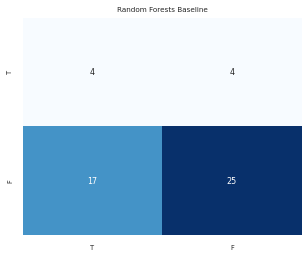

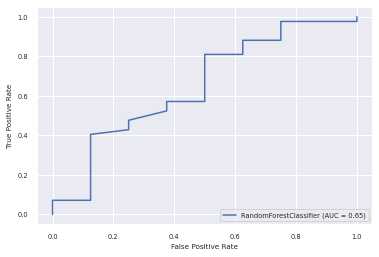

This is the starting index: 51 of patient 1
0.8518518518518519
[(0, 0, array([0.76, 0.24])), (0, 0, array([0.88, 0.12])), (0, 0, array([0.72, 0.28])), (0, 0, array([0.58, 0.42])), (0, 0, array([0.67, 0.33])), (0, 0, array([0.8, 0.2])), (0, 1, array([0.39, 0.61])), (0, 0, array([0.8, 0.2])), (0, 1, array([0.47, 0.53])), (0, 0, array([0.57, 0.43])), (0, 0, array([0.53, 0.47])), (0, 0, array([0.82, 0.18])), (0, 0, array([0.93, 0.07])), (0, 0, array([0.88, 0.12])), (0, 1, array([0.36, 0.64])), (0, 0, array([0.91, 0.09])), (0, 0, array([0.84, 0.16])), (0, 0, array([0.85, 0.15])), (0, 0, array([0.68, 0.32])), (0, 0, array([0.84, 0.16])), (0, 0, array([0.71, 0.29])), (0, 0, array([0.94, 0.06])), (0, 0, array([0.58, 0.42])), (0, 0, array([0.58, 0.42])), (0, 1, array([0.37, 0.63])), (0, 0, array([0.51, 0.49])), (0, 0, array([0.5, 0.5]))]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


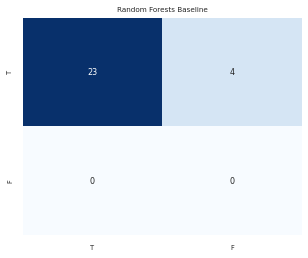

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


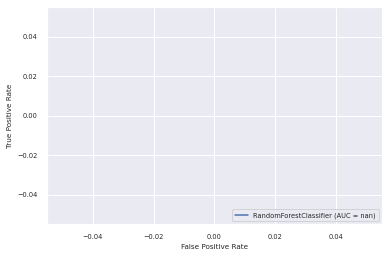

This is the starting index: 79 of patient 2
0.5892857142857143
[(0, 0, array([0.64, 0.36])), (0, 0, array([0.64, 0.36])), (1, 0, array([0.56, 0.44])), (0, 0, array([0.54, 0.46])), (1, 0, array([0.72, 0.28])), (1, 0, array([0.64, 0.36])), (1, 0, array([0.73, 0.27])), (1, 1, array([0.21, 0.79])), (1, 0, array([0.68, 0.32])), (1, 0, array([0.67, 0.33])), (1, 0, array([0.77, 0.23])), (0, 0, array([0.6, 0.4])), (1, 0, array([0.56, 0.44])), (0, 0, array([0.55, 0.45])), (0, 1, array([0.4, 0.6])), (1, 0, array([0.65, 0.35])), (0, 0, array([0.7, 0.3])), (0, 0, array([0.66, 0.34])), (0, 0, array([0.85, 0.15])), (0, 0, array([0.59, 0.41])), (0, 0, array([0.67, 0.33])), (0, 1, array([0.34, 0.66])), (0, 0, array([0.51, 0.49])), (1, 0, array([0.5, 0.5])), (1, 0, array([0.8, 0.2])), (1, 1, array([0.37, 0.63])), (1, 1, array([0.48, 0.52])), (0, 0, array([0.5, 0.5])), (1, 1, array([0.34, 0.66])), (1, 0, array([0.7, 0.3])), (1, 1, array([0.33, 0.67])), (1, 1, array([0.48, 0.52])), (1, 0, array([0.73, 0.

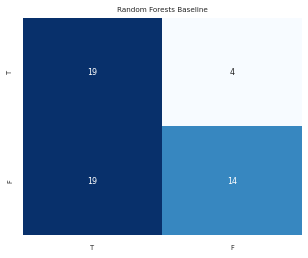

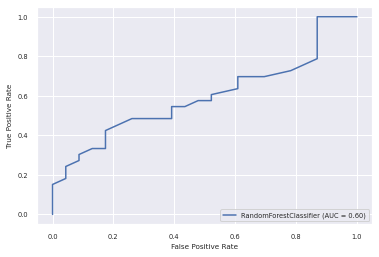

This is the starting index: 136 of patient 3
0.6756756756756757
[(1, 1, array([0.18, 0.82])), (1, 1, array([0.16, 0.84])), (1, 0, array([0.61, 0.39])), (1, 1, array([0.47, 0.53])), (1, 1, array([0.43, 0.57])), (1, 1, array([0.33, 0.67])), (1, 1, array([0.47, 0.53])), (1, 0, array([0.5, 0.5])), (0, 0, array([0.53, 0.47])), (1, 1, array([0.25, 0.75])), (1, 1, array([0.43, 0.57])), (1, 0, array([0.57, 0.43])), (1, 1, array([0.13, 0.87])), (1, 1, array([0.37, 0.63])), (1, 0, array([0.54, 0.46])), (1, 0, array([0.5, 0.5])), (0, 1, array([0.24, 0.76])), (0, 0, array([0.65, 0.35])), (1, 1, array([0.34, 0.66])), (1, 1, array([0.22, 0.78])), (1, 0, array([0.59, 0.41])), (0, 1, array([0.29, 0.71])), (1, 1, array([0.45, 0.55])), (0, 1, array([0.37, 0.63])), (1, 0, array([0.51, 0.49])), (0, 1, array([0.33, 0.67])), (1, 1, array([0.41, 0.59])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.11, 0.89])), (1, 1, array([0.16, 0.84])), (1, 1, array([0.14, 0.86])), (1, 1, array([0.31, 0.69])), (1, 1, array(

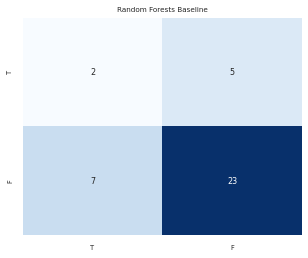

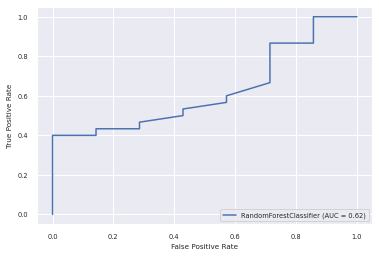

This is the starting index: 174 of patient 4
0.7027027027027027
[(0, 0, array([0.54, 0.46])), (0, 1, array([0.49, 0.51])), (1, 1, array([0.02, 0.98])), (0, 0, array([0.78, 0.22])), (1, 0, array([0.73, 0.27])), (0, 0, array([0.75, 0.25])), (1, 1, array([0.08, 0.92])), (0, 0, array([0.71, 0.29])), (1, 0, array([0.63, 0.37])), (0, 1, array([0.33, 0.67])), (0, 1, array([0.18, 0.82])), (0, 0, array([0.58, 0.42])), (0, 0, array([0.63, 0.37])), (0, 0, array([0.53, 0.47])), (0, 0, array([0.56, 0.44])), (0, 0, array([0.53, 0.47])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.17, 0.83])), (0, 0, array([0.65, 0.35])), (0, 0, array([0.57, 0.43])), (0, 1, array([0.39, 0.61])), (0, 0, array([0.73, 0.27])), (1, 1, array([0.18, 0.82])), (0, 1, array([0.18, 0.82])), (1, 0, array([0.52, 0.48])), (1, 1, array([0.13, 0.87])), (0, 0, array([0.62, 0.38])), (0, 1, array([0.44, 0.56])), (1, 1, array([0.25, 0.75])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.21, 0.79])), (0, 1, array([0.29, 0.71])), (0, 0, ar

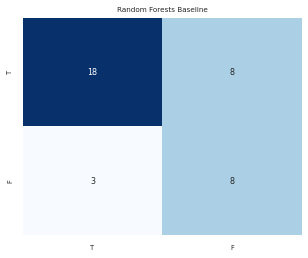

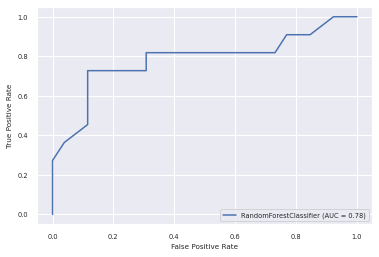

This is the starting index: 212 of patient 5
0.35294117647058826
[(1, 0, array([0.59, 0.41])), (1, 1, array([0.02, 0.98])), (0, 1, array([0.37, 0.63])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0.44, 0.56])), (0, 0, array([0.58, 0.42])), (0, 1, array([0.34, 0.66])), (0, 1, array([0.45, 0.55])), (0, 1, array([0.03, 0.97])), (0, 1, array([0.04, 0.96])), (0, 1, array([0.29, 0.71])), (0, 1, array([0.04, 0.96])), (0, 1, array([0.29, 0.71])), (0, 1, array([0.15, 0.85])), (0, 0, array([0.5, 0.5])), (0, 1, array([0.04, 0.96])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.16, 0.84])), (0, 1, array([0.23, 0.77])), (0, 1, array([0.16, 0.84])), (0, 0, array([0.54, 0.46])), (0, 0, array([0.55, 0.45])), (0, 1, array([0.1, 0.9])), (0, 1, array([0.1, 0.9])), (0, 1, array([0.27, 0.73])), (0, 0, array([0.98, 0.02])), (0, 1, array([0., 1.])), (0, 1, array([0.34, 0.66])), (0, 1, array([0.27, 0.73])), (0, 1, array([0.1, 0.9])), (0, 1, array([0.06, 0.94])), (0, 1, array([0.31, 0.69])),

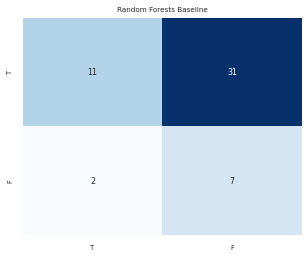

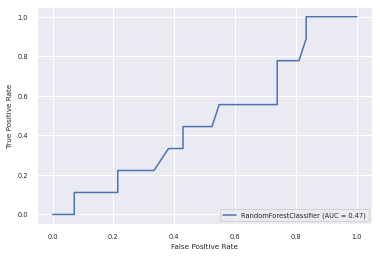

This is the starting index: 264 of patient 6
0.631578947368421
[(0, 0, array([0.52, 0.48])), (0, 0, array([0.53, 0.47])), (1, 1, array([0.39, 0.61])), (0, 1, array([0.42, 0.58])), (0, 1, array([0.45, 0.55])), (1, 0, array([0.52, 0.48])), (0, 1, array([0.47, 0.53])), (0, 0, array([0.59, 0.41])), (1, 1, array([0.37, 0.63])), (0, 1, array([0.48, 0.52])), (1, 1, array([0.3, 0.7])), (0, 1, array([0.47, 0.53])), (1, 1, array([0.49, 0.51])), (1, 1, array([0.24, 0.76])), (0, 1, array([0.43, 0.57])), (1, 1, array([0.23, 0.77])), (1, 1, array([0.31, 0.69])), (0, 0, array([0.66, 0.34])), (0, 0, array([0.59, 0.41]))]


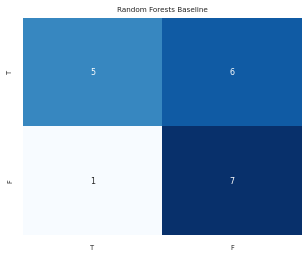

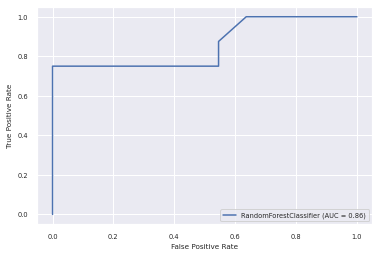

This is the starting index: 284 of patient 7
0.6666666666666666
[(0, 1, array([0.28, 0.72])), (0, 0, array([0.61, 0.39])), (0, 1, array([0.44, 0.56])), (0, 0, array([0.7, 0.3])), (0, 0, array([0.53, 0.47])), (0, 1, array([0.29, 0.71])), (0, 1, array([0.35, 0.65])), (0, 0, array([0.52, 0.48])), (0, 1, array([0.05, 0.95])), (0, 0, array([0.5, 0.5])), (1, 1, array([0.08, 0.92])), (0, 0, array([0.56, 0.44])), (0, 0, array([0.65, 0.35])), (0, 0, array([0.74, 0.26])), (0, 0, array([0.58, 0.42]))]


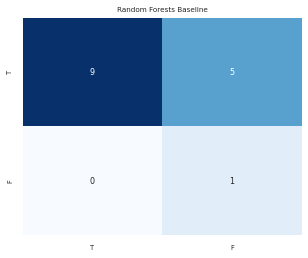

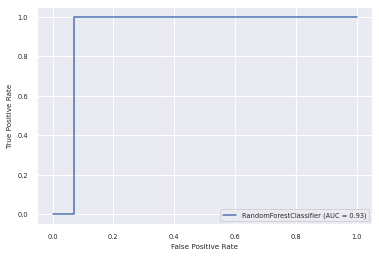

This is the starting index: 300 of patient 8
0.7441860465116279
[(0, 0, array([0.51, 0.49])), (0, 0, array([0.77, 0.23])), (0, 0, array([0.74, 0.26])), (0, 1, array([0.36, 0.64])), (0, 1, array([0.31, 0.69])), (0, 0, array([0.75, 0.25])), (0, 1, array([0.25, 0.75])), (0, 0, array([0.85, 0.15])), (0, 0, array([0.53, 0.47])), (0, 0, array([0.52, 0.48])), (0, 1, array([0.45, 0.55])), (0, 0, array([0.78, 0.22])), (0, 0, array([0.75, 0.25])), (0, 0, array([0.72, 0.28])), (1, 1, array([0.35, 0.65])), (0, 0, array([0.53, 0.47])), (1, 1, array([0.01, 0.99])), (1, 1, array([0.15, 0.85])), (0, 0, array([0.62, 0.38])), (0, 0, array([0.58, 0.42])), (1, 1, array([0.01, 0.99])), (0, 1, array([0.47, 0.53])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.08, 0.92])), (1, 1, array([0.05, 0.95])), (1, 1, array([0.21, 0.79])), (1, 1, array([0.01, 0.99])), (0, 1, array([0.42, 0.58])), (1, 0, array([0.52, 0.48])), (1, 1, array([0.43, 0.57])), (1, 1, array([0.08, 0.92])), (1, 1, arra

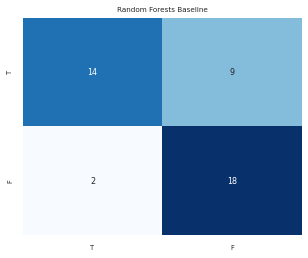

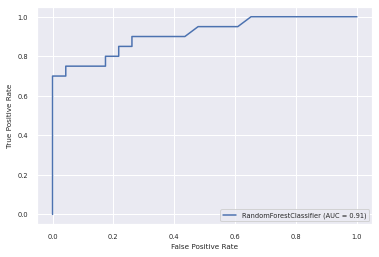

This is the starting index: 344 of patient 9
0.6190476190476191
[(1, 0, array([0.87, 0.13])), (1, 0, array([0.73, 0.27])), (0, 0, array([0.57, 0.43])), (1, 0, array([0.59, 0.41])), (1, 1, array([0.44, 0.56])), (1, 0, array([0.5, 0.5])), (1, 0, array([0.61, 0.39])), (0, 0, array([0.58, 0.42])), (0, 0, array([0.62, 0.38])), (0, 0, array([0.6, 0.4])), (0, 0, array([0.58, 0.42])), (0, 0, array([0.53, 0.47])), (0, 0, array([0.94, 0.06])), (0, 0, array([0.64, 0.36])), (0, 0, array([0.57, 0.43])), (0, 0, array([0.66, 0.34])), (0, 0, array([0.59, 0.41])), (1, 0, array([0.67, 0.33])), (0, 0, array([0.56, 0.44])), (0, 0, array([0.69, 0.31])), (1, 0, array([0.65, 0.35])), (1, 1, array([0.49, 0.51])), (0, 0, array([0.53, 0.47])), (0, 0, array([0.78, 0.22])), (1, 0, array([0.7, 0.3])), (0, 0, array([0.62, 0.38])), (1, 0, array([0.56, 0.44])), (0, 0, array([0.74, 0.26])), (1, 0, array([0.56, 0.44])), (1, 0, array([0.64, 0.36])), (0, 0, array([0.63, 0.37])), (1, 1, array([0.34, 0.66])), (1, 0, array(

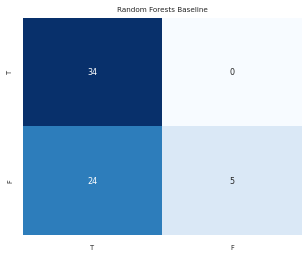

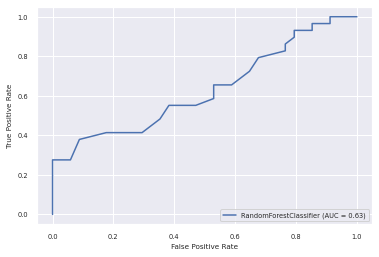

This is the starting index: 408 of patient 10
0.7878787878787878
[(1, 1, array([0.28, 0.72])), (1, 1, array([0.26, 0.74])), (1, 1, array([0.28, 0.72])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.22, 0.78])), (1, 1, array([0.3, 0.7])), (1, 1, array([0.04, 0.96])), (1, 0, array([0.51, 0.49])), (1, 1, array([0.19, 0.81])), (0, 0, array([0.54, 0.46])), (0, 0, array([0.58, 0.42])), (1, 1, array([0.24, 0.76])), (1, 1, array([0.29, 0.71])), (1, 1, array([0.06, 0.94])), (1, 1, array([0.13, 0.87])), (0, 0, array([0.78, 0.22])), (1, 0, array([0.61, 0.39])), (1, 0, array([0.59, 0.41])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.1, 0.9])), (0, 1, array([0.41, 0.59])), (1, 0, array([0.66, 0.34])), (0, 0, array([0.77, 0.23])), (1, 1, array([0.35, 0.65])), (1, 1, array([0.22, 0.78])), (0, 0, array([0.65, 0.35])), (1, 0, array([0.53, 0.47])), (1, 1, array([0.34, 0.66])), (1, 1, array([0.15, 0.85])), (1, 0, array([0.62, 0.38])), (1, 1, array([0.39, 0.61])), (1, 0, array([0.56, 0.44])), (1, 1, array([

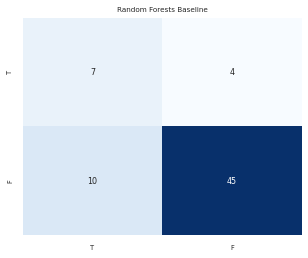

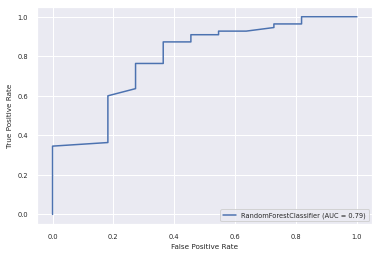

This is the starting index: 475 of patient 11
0.7592592592592593
[(0, 0, array([0.84, 0.16])), (1, 0, array([0.51, 0.49])), (1, 1, array([0.25, 0.75])), (1, 1, array([0.41, 0.59])), (0, 1, array([0.47, 0.53])), (1, 1, array([0.15, 0.85])), (1, 0, array([0.68, 0.32])), (1, 1, array([0.31, 0.69])), (1, 1, array([0.08, 0.92])), (1, 1, array([0.26, 0.74])), (1, 1, array([0.27, 0.73])), (0, 1, array([0.48, 0.52])), (1, 1, array([0.27, 0.73])), (1, 1, array([0.45, 0.55])), (1, 1, array([0.29, 0.71])), (1, 0, array([0.64, 0.36])), (1, 1, array([0.39, 0.61])), (1, 1, array([0.49, 0.51])), (1, 1, array([0.36, 0.64])), (1, 1, array([0.27, 0.73])), (1, 0, array([0.68, 0.32])), (1, 1, array([0.47, 0.53])), (1, 1, array([0.32, 0.68])), (1, 1, array([0.36, 0.64])), (1, 1, array([0.27, 0.73])), (0, 0, array([0.53, 0.47])), (1, 0, array([0.54, 0.46])), (1, 1, array([0.45, 0.55])), (0, 0, array([0.63, 0.37])), (1, 1, array([0.21, 0.79])), (1, 0, array([0.65, 0.35])), (1, 0, array([0.56, 0.44])), (1, 1,

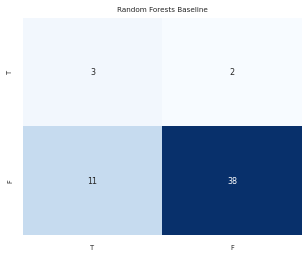

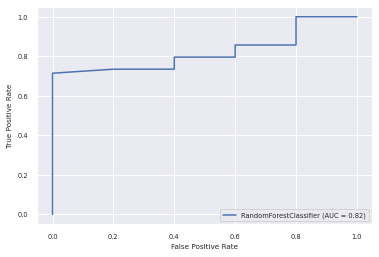

This is the starting index: 530 of patient 12
0.7407407407407407
[(1, 1, array([0.38, 0.62])), (1, 0, array([0.65, 0.35])), (1, 0, array([0.66, 0.34])), (1, 1, array([0.46, 0.54])), (1, 0, array([0.65, 0.35])), (1, 1, array([0.47, 0.53])), (1, 1, array([0.15, 0.85])), (0, 0, array([0.65, 0.35])), (0, 0, array([0.51, 0.49])), (1, 0, array([0.84, 0.16])), (1, 1, array([0.07, 0.93])), (1, 1, array([0.26, 0.74])), (1, 0, array([0.83, 0.17])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.17, 0.83])), (1, 0, array([0.64, 0.36])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.18, 0.82])), (1, 1, array([0.23, 0.77])), (1, 0, array([0.56, 0.44])), (1, 1, array([0.19, 0.81])), (1, 1, array([0.19, 0.81])), (1, 0, array([0.63, 0.37])), (1, 1, array([0.2, 0.8])), (1, 0, array([0.75, 0.25])), (1, 1, array([0.15, 0.85])), (1, 1, array([0.05, 0.95])), (1, 0, array([0.57, 0.43])), (1, 1, array([0.16, 0.84])), (1, 1, array([0.32, 0.68])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.35, 0.65])), (1, 1, arr

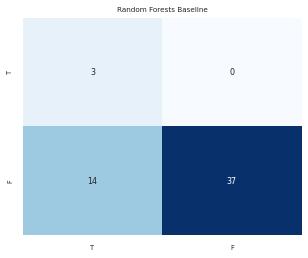

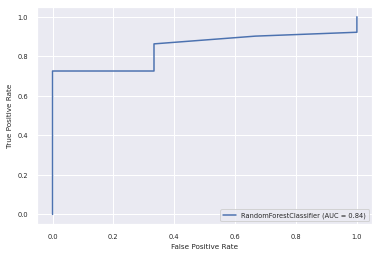

<function matplotlib.pyplot.show>

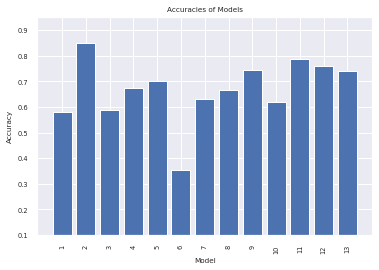

In [ ]:
Accuracy = []
clf = RandomForestClassifier()
sel = VarianceThreshold(threshold=(.2 * (1 - .8)))
for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    sel.fit_transform(train)
    sel.fit_transform(test)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### L1-based feature selection

This is the starting index: 0 of patient 0
0.44
[(1, 0, array([0.99, 0.01])), (1, 1, array([0., 1.])), (1, 0, array([0.92, 0.08])), (0, 0, array([0.73, 0.27])), (1, 1, array([0.32, 0.68])), (1, 0, array([0.99, 0.01])), (1, 0, array([0.56, 0.44])), (1, 1, array([0.29, 0.71])), (1, 1, array([0.25, 0.75])), (0, 1, array([0.34, 0.66])), (1, 0, array([1., 0.])), (1, 0, array([0.91, 0.09])), (0, 0, array([0.68, 0.32])), (1, 1, array([0.01, 0.99])), (0, 1, array([0.3, 0.7])), (1, 0, array([0.94, 0.06])), (1, 0, array([0.78, 0.22])), (1, 1, array([0.26, 0.74])), (1, 0, array([0.86, 0.14])), (1, 0, array([0.66, 0.34])), (1, 1, array([0., 1.])), (1, 1, array([0.25, 0.75])), (1, 0, array([0.61, 0.39])), (0, 0, array([0.89, 0.11])), (1, 1, array([0.15, 0.85])), (1, 1, array([0.34, 0.66])), (1, 1, array([0.04, 0.96])), (0, 1, array([0.01, 0.99])), (1, 0, array([0.79, 0.21])), (1, 1, array([0.01, 0.99])), (1, 1, array([0.24, 0.76])), (1, 0, array([0.63, 0.37])), (1, 1, array([0.26, 0.74])), (1, 0, a

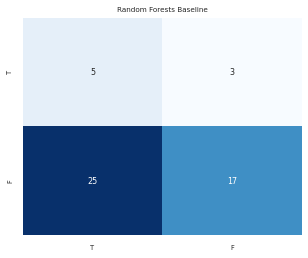

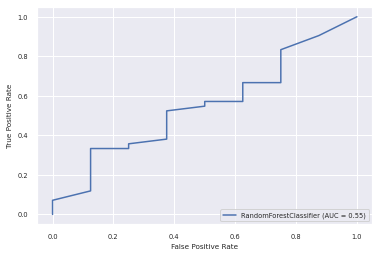

This is the starting index: 51 of patient 1
0.5925925925925926
[(0, 1, array([0.16, 0.84])), (0, 0, array([0.76, 0.24])), (0, 0, array([0.59, 0.41])), (0, 0, array([0.69, 0.31])), (0, 1, array([0.26, 0.74])), (0, 1, array([0.37, 0.63])), (0, 1, array([0.12, 0.88])), (0, 0, array([0.95, 0.05])), (0, 1, array([0.31, 0.69])), (0, 0, array([0.69, 0.31])), (0, 0, array([0.75, 0.25])), (0, 0, array([0.69, 0.31])), (0, 0, array([0.91, 0.09])), (0, 0, array([0.83, 0.17])), (0, 1, array([0.33, 0.67])), (0, 0, array([0.59, 0.41])), (0, 1, array([0.22, 0.78])), (0, 0, array([0.69, 0.31])), (0, 1, array([0.14, 0.86])), (0, 0, array([0.51, 0.49])), (0, 1, array([0.45, 0.55])), (0, 0, array([0.66, 0.34])), (0, 0, array([0.54, 0.46])), (0, 0, array([0.51, 0.49])), (0, 1, array([0.49, 0.51])), (0, 1, array([0.1, 0.9])), (0, 0, array([0.57, 0.43]))]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


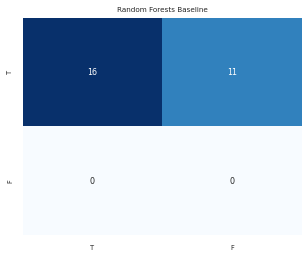

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


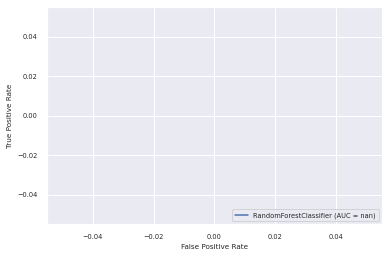

This is the starting index: 79 of patient 2
0.42857142857142855
[(0, 0, array([0.61, 0.39])), (0, 1, array([0.49, 0.51])), (1, 1, array([0.42, 0.58])), (0, 1, array([0.36, 0.64])), (1, 0, array([0.76, 0.24])), (1, 0, array([0.99, 0.01])), (1, 1, array([0.38, 0.62])), (1, 1, array([0.03, 0.97])), (1, 1, array([0.26, 0.74])), (1, 0, array([0.99, 0.01])), (1, 0, array([0.76, 0.24])), (0, 0, array([0.73, 0.27])), (1, 1, array([0.43, 0.57])), (0, 1, array([0.46, 0.54])), (0, 1, array([0.03, 0.97])), (1, 0, array([0.81, 0.19])), (0, 0, array([0.74, 0.26])), (0, 1, array([0.31, 0.69])), (0, 0, array([0.93, 0.07])), (0, 1, array([0.32, 0.68])), (0, 1, array([0.29, 0.71])), (0, 0, array([0.85, 0.15])), (0, 1, array([0.07, 0.93])), (1, 0, array([0.51, 0.49])), (1, 0, array([0.59, 0.41])), (1, 0, array([0.74, 0.26])), (1, 0, array([0.99, 0.01])), (0, 1, array([0.27, 0.73])), (1, 1, array([0.08, 0.92])), (1, 0, array([0.81, 0.19])), (1, 0, array([0.75, 0.25])), (1, 1, array([0.21, 0.79])), (1, 1, 

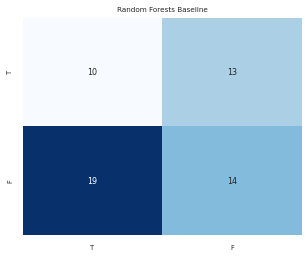

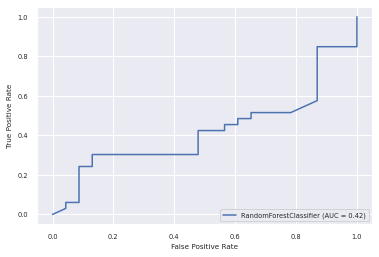

This is the starting index: 136 of patient 3
0.5135135135135135
[(1, 1, array([0.02, 0.98])), (1, 1, array([0., 1.])), (1, 0, array([0.97, 0.03])), (1, 0, array([0.92, 0.08])), (1, 0, array([0.86, 0.14])), (1, 0, array([0.98, 0.02])), (1, 0, array([0.97, 0.03])), (1, 1, array([0.4, 0.6])), (0, 0, array([0.67, 0.33])), (1, 1, array([0.26, 0.74])), (1, 0, array([0.85, 0.15])), (1, 0, array([0.63, 0.37])), (1, 1, array([0.03, 0.97])), (1, 1, array([0.22, 0.78])), (1, 1, array([0.01, 0.99])), (1, 1, array([0.11, 0.89])), (0, 0, array([0.91, 0.09])), (0, 1, array([0.07, 0.93])), (1, 0, array([0.86, 0.14])), (1, 1, array([0.13, 0.87])), (1, 0, array([1., 0.])), (0, 1, array([0.26, 0.74])), (1, 0, array([0.85, 0.15])), (0, 0, array([1., 0.])), (1, 0, array([0.99, 0.01])), (0, 1, array([0.25, 0.75])), (1, 1, array([0., 1.])), (1, 1, array([0.25, 0.75])), (1, 1, array([0.33, 0.67])), (1, 0, array([0.62, 0.38])), (1, 1, array([0.16, 0.84])), (1, 0, array([0.97, 0.03])), (1, 0, array([0.87, 0.13]

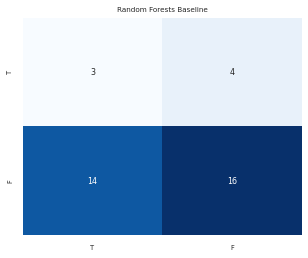

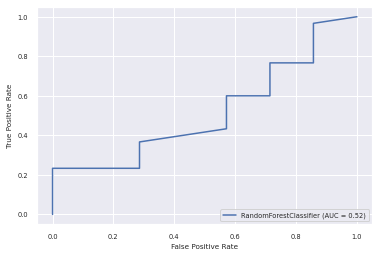

This is the starting index: 174 of patient 4
0.5675675675675675
[(0, 1, array([0.26, 0.74])), (0, 1, array([0.11, 0.89])), (1, 1, array([0., 1.])), (0, 0, array([0.94, 0.06])), (1, 1, array([0.32, 0.68])), (0, 0, array([0.91, 0.09])), (1, 0, array([0.67, 0.33])), (0, 1, array([0.12, 0.88])), (1, 0, array([0.66, 0.34])), (0, 1, array([0., 1.])), (0, 0, array([0.64, 0.36])), (0, 0, array([0.83, 0.17])), (0, 0, array([0.93, 0.07])), (0, 1, array([0.1, 0.9])), (0, 0, array([0.71, 0.29])), (0, 0, array([0.66, 0.34])), (1, 1, array([0.22, 0.78])), (0, 0, array([0.99, 0.01])), (0, 1, array([0.31, 0.69])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([0.65, 0.35])), (1, 1, array([0.14, 0.86])), (0, 0, array([0.66, 0.34])), (1, 0, array([0.7, 0.3])), (1, 1, array([0., 1.])), (0, 1, array([0.33, 0.67])), (0, 0, array([0.62, 0.38])), (1, 1, array([0., 1.])), (1, 1, array([0.32, 0.68])), (1, 1, array([0.09, 0.91])), (0, 0, array([0.69, 0.31])), (0, 1, array([0., 1.])), (0, 1, arr

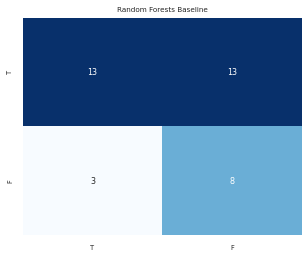

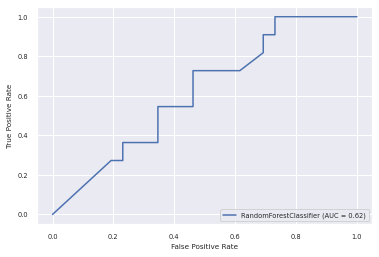

This is the starting index: 212 of patient 5
0.4117647058823529
[(1, 1, array([0.35, 0.65])), (1, 1, array([0.03, 0.97])), (0, 1, array([0.29, 0.71])), (0, 1, array([0.03, 0.97])), (0, 1, array([0., 1.])), (0, 0, array([0.74, 0.26])), (0, 1, array([0.06, 0.94])), (0, 0, array([0.75, 0.25])), (0, 1, array([0.12, 0.88])), (0, 1, array([0.34, 0.66])), (0, 1, array([0., 1.])), (0, 1, array([0.02, 0.98])), (0, 1, array([0., 1.])), (0, 1, array([0.05, 0.95])), (0, 1, array([0.11, 0.89])), (0, 1, array([0.35, 0.65])), (0, 1, array([0.02, 0.98])), (0, 1, array([0.14, 0.86])), (0, 1, array([0., 1.])), (0, 0, array([0.75, 0.25])), (0, 0, array([0.96, 0.04])), (0, 0, array([0.62, 0.38])), (0, 1, array([0.2, 0.8])), (0, 1, array([0.22, 0.78])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1., 0.])), (0, 1, array([0., 1.])), (0, 1, array([0.36, 0.64])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([0.67, 0.33])), (0, 0, array([0.69, 0.31])), (0, 1, array([0.02, 

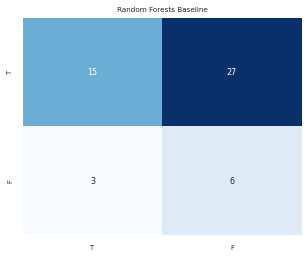

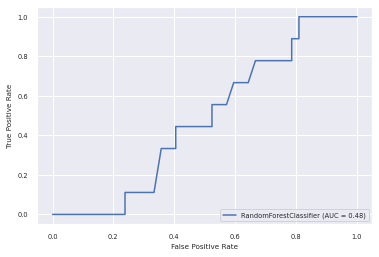

This is the starting index: 264 of patient 6
0.5263157894736842
[(0, 0, array([0.69, 0.31])), (0, 1, array([0.26, 0.74])), (1, 0, array([0.66, 0.34])), (0, 1, array([0.42, 0.58])), (0, 1, array([0.22, 0.78])), (1, 0, array([0.88, 0.12])), (0, 1, array([0.42, 0.58])), (0, 0, array([0.87, 0.13])), (1, 0, array([0.56, 0.44])), (0, 0, array([0.63, 0.37])), (1, 0, array([0.66, 0.34])), (0, 0, array([0.65, 0.35])), (1, 0, array([0.78, 0.22])), (1, 1, array([0.48, 0.52])), (0, 0, array([0.74, 0.26])), (1, 1, array([0.46, 0.54])), (1, 1, array([0.18, 0.82])), (0, 0, array([0.97, 0.03])), (0, 0, array([0.69, 0.31]))]


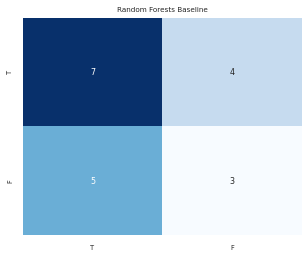

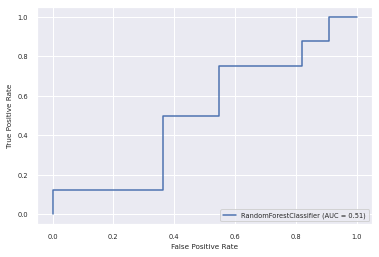

This is the starting index: 284 of patient 7
0.4
[(0, 1, array([0.18, 0.82])), (0, 0, array([0.62, 0.38])), (0, 1, array([0.12, 0.88])), (0, 0, array([0.78, 0.22])), (0, 1, array([0.24, 0.76])), (0, 1, array([0.26, 0.74])), (0, 1, array([0.11, 0.89])), (0, 1, array([0.31, 0.69])), (0, 1, array([0.17, 0.83])), (0, 0, array([0.53, 0.47])), (1, 1, array([0.06, 0.94])), (0, 0, array([0.52, 0.48])), (0, 1, array([0.33, 0.67])), (0, 1, array([0.49, 0.51])), (0, 0, array([0.81, 0.19]))]


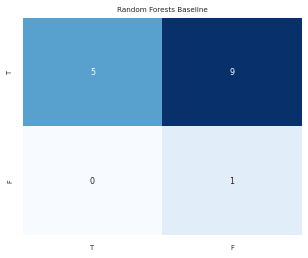

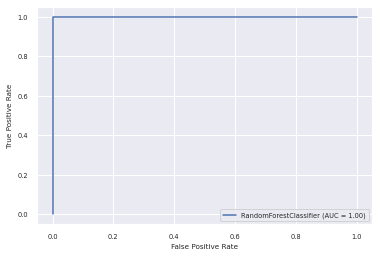

This is the starting index: 300 of patient 8
0.6744186046511628
[(0, 0, array([0.87, 0.13])), (0, 1, array([0.34, 0.66])), (0, 1, array([0.34, 0.66])), (0, 1, array([0.49, 0.51])), (0, 0, array([0.54, 0.46])), (0, 0, array([0.72, 0.28])), (0, 1, array([0.09, 0.91])), (0, 0, array([0.88, 0.12])), (0, 1, array([0.25, 0.75])), (0, 1, array([0.44, 0.56])), (0, 1, array([0.37, 0.63])), (0, 0, array([0.66, 0.34])), (0, 0, array([0.59, 0.41])), (0, 0, array([0.98, 0.02])), (1, 0, array([0.66, 0.34])), (0, 0, array([0.92, 0.08])), (1, 1, array([0.02, 0.98])), (1, 0, array([0.77, 0.23])), (0, 0, array([0.74, 0.26])), (0, 1, array([0.47, 0.53])), (1, 1, array([0.19, 0.81])), (0, 1, array([0.41, 0.59])), (1, 1, array([0.49, 0.51])), (1, 1, array([0.07, 0.93])), (1, 1, array([0.04, 0.96])), (1, 1, array([0.12, 0.88])), (1, 1, array([0.38, 0.62])), (1, 1, array([0.3, 0.7])), (0, 0, array([0.67, 0.33])), (1, 1, array([0.3, 0.7])), (1, 0, array([0.84, 0.16])), (1, 1, array([0.12, 0.88])), (1, 1, arra

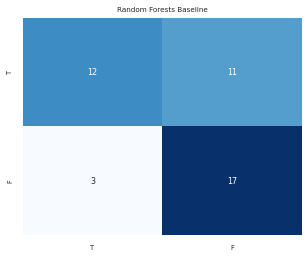

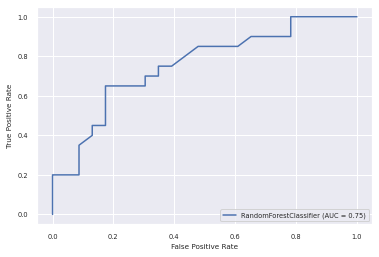

This is the starting index: 344 of patient 9
0.4126984126984127
[(1, 0, array([0.98, 0.02])), (1, 0, array([0.65, 0.35])), (0, 0, array([0.55, 0.45])), (1, 0, array([0.7, 0.3])), (1, 1, array([0.48, 0.52])), (1, 1, array([0.08, 0.92])), (1, 1, array([0.1, 0.9])), (0, 0, array([0.76, 0.24])), (0, 1, array([0.22, 0.78])), (0, 0, array([0.73, 0.27])), (0, 1, array([0.28, 0.72])), (0, 1, array([0.4, 0.6])), (0, 0, array([0.88, 0.12])), (0, 0, array([0.99, 0.01])), (0, 1, array([0.29, 0.71])), (0, 1, array([0.15, 0.85])), (0, 1, array([0.15, 0.85])), (1, 0, array([0.83, 0.17])), (0, 1, array([0.17, 0.83])), (0, 1, array([0.13, 0.87])), (1, 1, array([0.23, 0.77])), (1, 0, array([0.54, 0.46])), (0, 0, array([0.66, 0.34])), (0, 0, array([0.88, 0.12])), (1, 0, array([0.73, 0.27])), (0, 0, array([0.61, 0.39])), (1, 0, array([0.84, 0.16])), (0, 0, array([0.56, 0.44])), (1, 1, array([0.32, 0.68])), (1, 1, array([0.29, 0.71])), (0, 1, array([0.45, 0.55])), (1, 1, array([0.06, 0.94])), (1, 0, array(

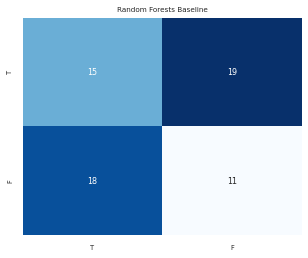

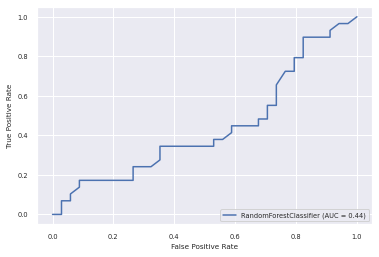

This is the starting index: 408 of patient 10
0.6515151515151515
[(1, 1, array([0.05, 0.95])), (1, 0, array([0.99, 0.01])), (1, 1, array([0.1, 0.9])), (1, 1, array([0.05, 0.95])), (1, 0, array([0.74, 0.26])), (1, 1, array([0.02, 0.98])), (1, 0, array([0.6, 0.4])), (1, 0, array([0.98, 0.02])), (1, 1, array([0.07, 0.93])), (0, 0, array([0.77, 0.23])), (0, 0, array([0.71, 0.29])), (1, 1, array([0.01, 0.99])), (1, 1, array([0.25, 0.75])), (1, 0, array([0.91, 0.09])), (1, 1, array([0.02, 0.98])), (0, 0, array([0.73, 0.27])), (1, 0, array([0.71, 0.29])), (1, 1, array([0.36, 0.64])), (0, 1, array([0.25, 0.75])), (1, 1, array([0.03, 0.97])), (0, 0, array([0.92, 0.08])), (1, 0, array([0.62, 0.38])), (0, 0, array([0.99, 0.01])), (1, 1, array([0.04, 0.96])), (1, 1, array([0.1, 0.9])), (0, 1, array([0.35, 0.65])), (1, 1, array([0., 1.])), (1, 1, array([0.14, 0.86])), (1, 1, array([0.08, 0.92])), (1, 1, array([0.02, 0.98])), (1, 1, array([0.37, 0.63])), (1, 1, array([0.02, 0.98])), (1, 0, array([0.

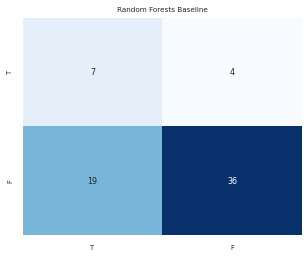

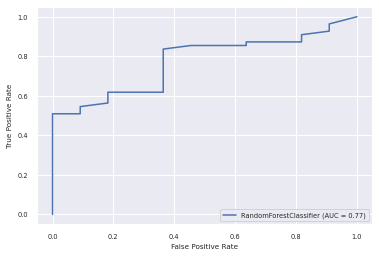

This is the starting index: 475 of patient 11
0.5555555555555556
[(0, 1, array([0.17, 0.83])), (1, 0, array([0.61, 0.39])), (1, 1, array([0.31, 0.69])), (1, 1, array([0.25, 0.75])), (0, 0, array([0.77, 0.23])), (1, 1, array([0.29, 0.71])), (1, 1, array([0.23, 0.77])), (1, 1, array([0.14, 0.86])), (1, 0, array([0.6, 0.4])), (1, 0, array([0.68, 0.32])), (1, 1, array([0.03, 0.97])), (0, 0, array([0.67, 0.33])), (1, 1, array([0.09, 0.91])), (1, 0, array([0.71, 0.29])), (1, 1, array([0.29, 0.71])), (1, 0, array([0.98, 0.02])), (1, 0, array([0.75, 0.25])), (1, 0, array([0.92, 0.08])), (1, 0, array([0.98, 0.02])), (1, 1, array([0.03, 0.97])), (1, 0, array([0.98, 0.02])), (1, 1, array([0.08, 0.92])), (1, 1, array([0.09, 0.91])), (1, 0, array([0.69, 0.31])), (1, 1, array([0.19, 0.81])), (0, 1, array([0., 1.])), (1, 1, array([0.09, 0.91])), (1, 1, array([0.32, 0.68])), (0, 1, array([0.09, 0.91])), (1, 1, array([0.24, 0.76])), (1, 1, array([0.3, 0.7])), (1, 0, array([0.93, 0.07])), (1, 0, array([

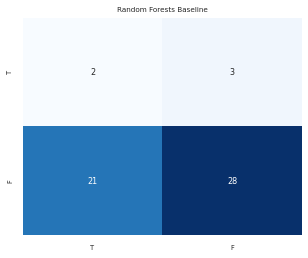

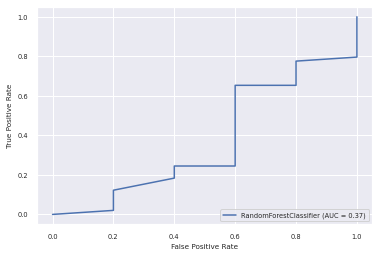

This is the starting index: 530 of patient 12
0.7222222222222222
[(1, 1, array([0.18, 0.82])), (1, 0, array([0.62, 0.38])), (1, 1, array([0.25, 0.75])), (1, 0, array([0.64, 0.36])), (1, 1, array([0.39, 0.61])), (1, 1, array([0.31, 0.69])), (1, 0, array([0.54, 0.46])), (0, 0, array([0.57, 0.43])), (0, 0, array([0.64, 0.36])), (1, 0, array([1., 0.])), (1, 1, array([0.46, 0.54])), (1, 1, array([0.34, 0.66])), (1, 0, array([0.64, 0.36])), (1, 1, array([0.07, 0.93])), (1, 1, array([0.21, 0.79])), (1, 1, array([0.17, 0.83])), (1, 0, array([0.78, 0.22])), (1, 1, array([0.27, 0.73])), (1, 1, array([0.37, 0.63])), (1, 1, array([0.45, 0.55])), (1, 1, array([0.27, 0.73])), (1, 0, array([0.55, 0.45])), (1, 1, array([0.46, 0.54])), (1, 1, array([0.28, 0.72])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.01, 0.99])), (1, 1, array([0.16, 0.84])), (1, 0, array([0.76, 0.24])), (1, 1, array([0.49, 0.51])), (1, 1, array([0.35, 0.65])), (1, 1, array([0.34, 0.66])), (1, 1, array([0.17, 0.83])), (1, 1, arr

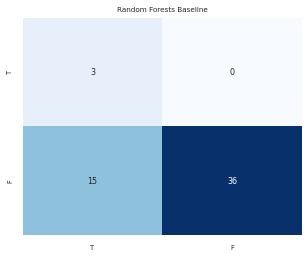

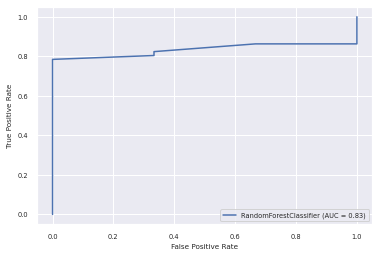

<function matplotlib.pyplot.show>

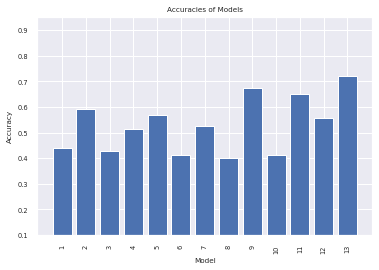

In [ ]:
Accuracy = []

clf = RandomForestClassifier()

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train, train_class.ravel())
    model = SelectFromModel(lsvc, prefit=True)
    train = model.transform(train)
    test = model.transform(test)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show


#### Tree Based Feature Selection

This is the starting index: 0 of patient 0
0.58
[(1, 0, array([0.67, 0.33])), (1, 1, array([0.11, 0.89])), (1, 1, array([0.35, 0.65])), (0, 1, array([0.44, 0.56])), (1, 0, array([0.66, 0.34])), (1, 1, array([0.38, 0.62])), (1, 1, array([0.45, 0.55])), (1, 1, array([0.16, 0.84])), (1, 1, array([0.23, 0.77])), (0, 0, array([0.74, 0.26])), (1, 1, array([0.41, 0.59])), (1, 1, array([0.22, 0.78])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.04, 0.96])), (0, 0, array([0.59, 0.41])), (1, 1, array([0.44, 0.56])), (1, 0, array([0.63, 0.37])), (1, 0, array([0.56, 0.44])), (1, 1, array([0.23, 0.77])), (1, 1, array([0.19, 0.81])), (1, 1, array([0.26, 0.74])), (1, 1, array([0.12, 0.88])), (1, 1, array([0.29, 0.71])), (0, 1, array([0.31, 0.69])), (1, 1, array([0.49, 0.51])), (1, 1, array([0.25, 0.75])), (1, 1, array([0.15, 0.85])), (0, 1, array([0.09, 0.91])), (1, 1, array([0.41, 0.59])), (1, 1, array([0.24, 0.76])), (1, 0, array([0.73, 0.27])), (1, 1, array([0.26, 0.74])), (1, 1, array([0.43, 0.57]

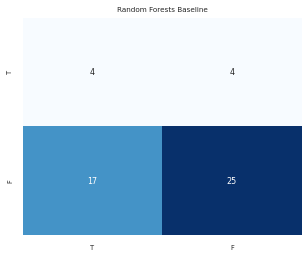

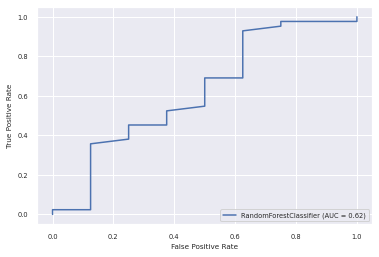

This is the starting index: 51 of patient 1
0.7777777777777778
[(0, 0, array([0.71, 0.29])), (0, 0, array([0.87, 0.13])), (0, 0, array([0.54, 0.46])), (0, 0, array([0.69, 0.31])), (0, 0, array([0.67, 0.33])), (0, 0, array([0.76, 0.24])), (0, 1, array([0.4, 0.6])), (0, 0, array([0.76, 0.24])), (0, 1, array([0.46, 0.54])), (0, 0, array([0.7, 0.3])), (0, 1, array([0.32, 0.68])), (0, 0, array([0.76, 0.24])), (0, 0, array([0.94, 0.06])), (0, 0, array([0.95, 0.05])), (0, 1, array([0.3, 0.7])), (0, 0, array([0.81, 0.19])), (0, 0, array([0.86, 0.14])), (0, 0, array([0.84, 0.16])), (0, 0, array([0.66, 0.34])), (0, 0, array([0.77, 0.23])), (0, 0, array([0.73, 0.27])), (0, 0, array([0.94, 0.06])), (0, 0, array([0.55, 0.45])), (0, 0, array([0.67, 0.33])), (0, 1, array([0.36, 0.64])), (0, 1, array([0.35, 0.65])), (0, 0, array([0.5, 0.5]))]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


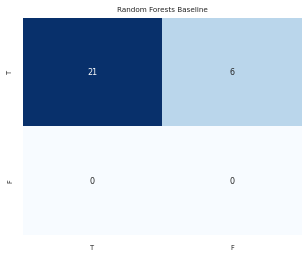

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


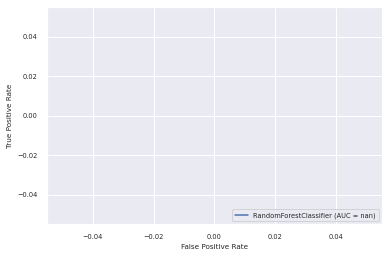

This is the starting index: 79 of patient 2
0.5714285714285714
[(0, 0, array([0.68, 0.32])), (0, 0, array([0.67, 0.33])), (1, 0, array([0.61, 0.39])), (0, 0, array([0.51, 0.49])), (1, 0, array([0.63, 0.37])), (1, 0, array([0.75, 0.25])), (1, 0, array([0.62, 0.38])), (1, 1, array([0.17, 0.83])), (1, 0, array([0.69, 0.31])), (1, 0, array([0.7, 0.3])), (1, 0, array([0.78, 0.22])), (0, 0, array([0.58, 0.42])), (1, 0, array([0.65, 0.35])), (0, 0, array([0.59, 0.41])), (0, 1, array([0.4, 0.6])), (1, 0, array([0.68, 0.32])), (0, 0, array([0.61, 0.39])), (0, 0, array([0.72, 0.28])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.56, 0.44])), (0, 0, array([0.67, 0.33])), (0, 1, array([0.28, 0.72])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.39, 0.61])), (1, 0, array([0.56, 0.44])), (1, 1, array([0.34, 0.66])), (1, 0, array([0.61, 0.39])), (0, 0, array([0.53, 0.47])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.7, 0.3])), (1, 1, array([0.32, 0.68])), (1, 1, array([0.48, 0.52])), (1, 0, array([0.75, 

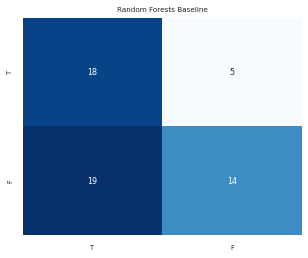

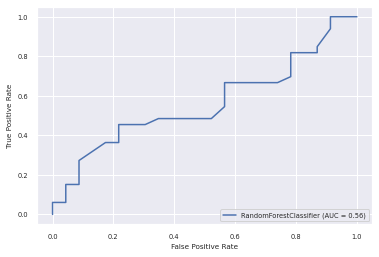

This is the starting index: 136 of patient 3
0.7297297297297297
[(1, 1, array([0.15, 0.85])), (1, 1, array([0.19, 0.81])), (1, 1, array([0.44, 0.56])), (1, 1, array([0.45, 0.55])), (1, 1, array([0.41, 0.59])), (1, 1, array([0.3, 0.7])), (1, 1, array([0.41, 0.59])), (1, 0, array([0.56, 0.44])), (0, 1, array([0.45, 0.55])), (1, 1, array([0.33, 0.67])), (1, 1, array([0.37, 0.63])), (1, 0, array([0.56, 0.44])), (1, 1, array([0.12, 0.88])), (1, 1, array([0.44, 0.56])), (1, 1, array([0.44, 0.56])), (1, 1, array([0.46, 0.54])), (0, 1, array([0.22, 0.78])), (0, 0, array([0.58, 0.42])), (1, 1, array([0.27, 0.73])), (1, 1, array([0.25, 0.75])), (1, 0, array([0.69, 0.31])), (0, 1, array([0.38, 0.62])), (1, 0, array([0.59, 0.41])), (0, 1, array([0.31, 0.69])), (1, 1, array([0.46, 0.54])), (0, 1, array([0.34, 0.66])), (1, 1, array([0.43, 0.57])), (1, 1, array([0.19, 0.81])), (1, 1, array([0.13, 0.87])), (1, 1, array([0.12, 0.88])), (1, 1, array([0.15, 0.85])), (1, 1, array([0.32, 0.68])), (1, 1, ar

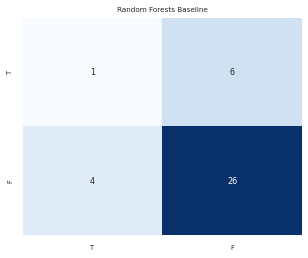

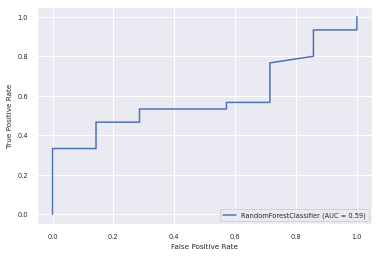

This is the starting index: 174 of patient 4
0.7027027027027027
[(0, 0, array([0.56, 0.44])), (0, 1, array([0.43, 0.57])), (1, 1, array([0.08, 0.92])), (0, 0, array([0.68, 0.32])), (1, 0, array([0.77, 0.23])), (0, 0, array([0.69, 0.31])), (1, 1, array([0.03, 0.97])), (0, 0, array([0.66, 0.34])), (1, 0, array([0.6, 0.4])), (0, 1, array([0.37, 0.63])), (0, 1, array([0.11, 0.89])), (0, 0, array([0.61, 0.39])), (0, 0, array([0.59, 0.41])), (0, 0, array([0.55, 0.45])), (0, 0, array([0.57, 0.43])), (0, 1, array([0.47, 0.53])), (1, 1, array([0.18, 0.82])), (0, 1, array([0.23, 0.77])), (0, 0, array([0.53, 0.47])), (0, 0, array([0.54, 0.46])), (0, 1, array([0.44, 0.56])), (0, 0, array([0.76, 0.24])), (1, 1, array([0.19, 0.81])), (0, 1, array([0.17, 0.83])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.17, 0.83])), (0, 0, array([0.6, 0.4])), (0, 0, array([0.54, 0.46])), (1, 1, array([0.22, 0.78])), (1, 1, array([0.19, 0.81])), (1, 1, array([0.1, 0.9])), (0, 1, array([0.33, 0.67])), (0, 0, array([0

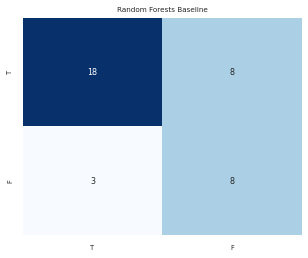

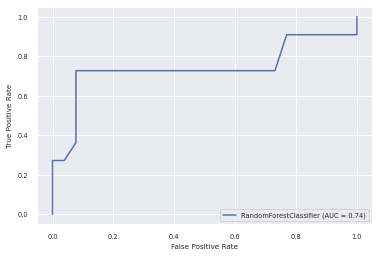

This is the starting index: 212 of patient 5
0.29411764705882354
[(1, 0, array([0.59, 0.41])), (1, 1, array([0.03, 0.97])), (0, 1, array([0.46, 0.54])), (0, 1, array([0.01, 0.99])), (0, 1, array([0.04, 0.96])), (0, 1, array([0.44, 0.56])), (0, 0, array([0.54, 0.46])), (0, 1, array([0.19, 0.81])), (0, 1, array([0.43, 0.57])), (0, 1, array([0.04, 0.96])), (0, 1, array([0.01, 0.99])), (0, 1, array([0.26, 0.74])), (0, 1, array([0.07, 0.93])), (0, 1, array([0.27, 0.73])), (0, 1, array([0.1, 0.9])), (0, 1, array([0.42, 0.58])), (0, 1, array([0.04, 0.96])), (0, 0, array([0.53, 0.47])), (0, 1, array([0.15, 0.85])), (0, 1, array([0.32, 0.68])), (0, 1, array([0.11, 0.89])), (0, 0, array([0.54, 0.46])), (0, 0, array([0.62, 0.38])), (0, 1, array([0.12, 0.88])), (0, 1, array([0.13, 0.87])), (0, 1, array([0.27, 0.73])), (0, 0, array([0.95, 0.05])), (0, 1, array([0.01, 0.99])), (0, 1, array([0.44, 0.56])), (0, 1, array([0.2, 0.8])), (0, 1, array([0.06, 0.94])), (0, 1, array([0.06, 0.94])), (0, 1, arr

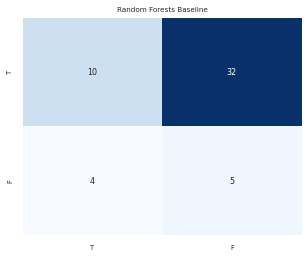

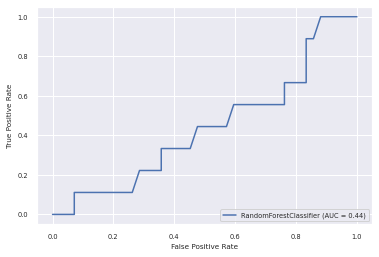

This is the starting index: 264 of patient 6
0.6842105263157895
[(0, 0, array([0.61, 0.39])), (0, 0, array([0.62, 0.38])), (1, 1, array([0.48, 0.52])), (0, 1, array([0.46, 0.54])), (0, 1, array([0.46, 0.54])), (1, 0, array([0.67, 0.33])), (0, 1, array([0.46, 0.54])), (0, 0, array([0.64, 0.36])), (1, 1, array([0.48, 0.52])), (0, 1, array([0.49, 0.51])), (1, 1, array([0.49, 0.51])), (0, 0, array([0.54, 0.46])), (1, 1, array([0.46, 0.54])), (1, 1, array([0.28, 0.72])), (0, 1, array([0.49, 0.51])), (1, 1, array([0.3, 0.7])), (1, 1, array([0.35, 0.65])), (0, 0, array([0.62, 0.38])), (0, 0, array([0.61, 0.39]))]


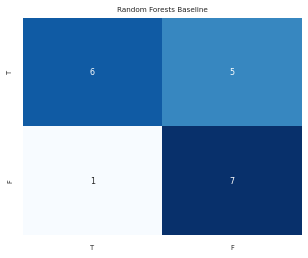

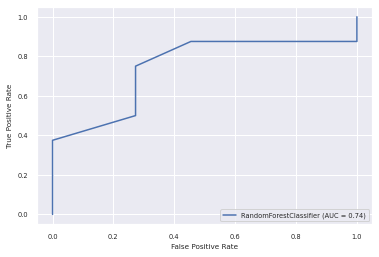

This is the starting index: 284 of patient 7
0.6666666666666666
[(0, 0, array([0.51, 0.49])), (0, 0, array([0.56, 0.44])), (0, 1, array([0.46, 0.54])), (0, 0, array([0.58, 0.42])), (0, 0, array([0.52, 0.48])), (0, 1, array([0.31, 0.69])), (0, 1, array([0.29, 0.71])), (0, 0, array([0.55, 0.45])), (0, 1, array([0.11, 0.89])), (0, 1, array([0.38, 0.62])), (1, 1, array([0.04, 0.96])), (0, 0, array([0.54, 0.46])), (0, 0, array([0.59, 0.41])), (0, 0, array([0.64, 0.36])), (0, 0, array([0.55, 0.45]))]


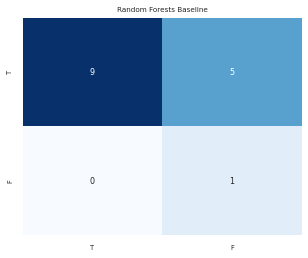

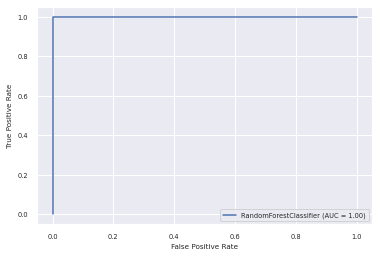

This is the starting index: 300 of patient 8
0.7209302325581395
[(0, 0, array([0.67, 0.33])), (0, 0, array([0.74, 0.26])), (0, 0, array([0.92, 0.08])), (0, 1, array([0.38, 0.62])), (0, 1, array([0.19, 0.81])), (0, 0, array([0.77, 0.23])), (0, 1, array([0.23, 0.77])), (0, 0, array([0.75, 0.25])), (0, 1, array([0.46, 0.54])), (0, 0, array([0.64, 0.36])), (0, 1, array([0.48, 0.52])), (0, 0, array([0.73, 0.27])), (0, 0, array([0.67, 0.33])), (0, 0, array([0.82, 0.18])), (1, 1, array([0.19, 0.81])), (0, 0, array([0.58, 0.42])), (1, 1, array([0.01, 0.99])), (1, 1, array([0.14, 0.86])), (0, 0, array([0.72, 0.28])), (0, 0, array([0.55, 0.45])), (1, 1, array([0., 1.])), (0, 1, array([0.46, 0.54])), (1, 1, array([0.32, 0.68])), (1, 1, array([0.06, 0.94])), (1, 1, array([0.06, 0.94])), (1, 1, array([0.05, 0.95])), (1, 1, array([0.18, 0.82])), (1, 1, array([0.06, 0.94])), (0, 1, array([0.32, 0.68])), (1, 0, array([0.52, 0.48])), (1, 1, array([0.32, 0.68])), (1, 1, array([0.07, 0.93])), (1, 1, arra

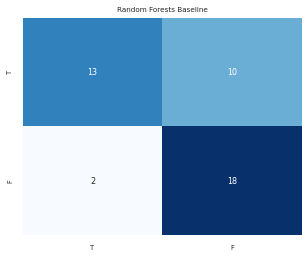

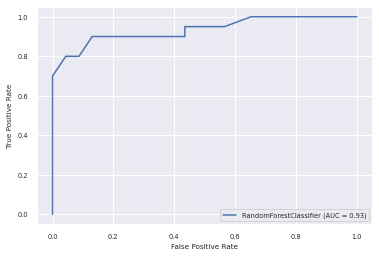

This is the starting index: 344 of patient 9
0.6190476190476191
[(1, 0, array([0.86, 0.14])), (1, 0, array([0.72, 0.28])), (0, 0, array([0.59, 0.41])), (1, 0, array([0.57, 0.43])), (1, 1, array([0.43, 0.57])), (1, 1, array([0.43, 0.57])), (1, 1, array([0.46, 0.54])), (0, 0, array([0.61, 0.39])), (0, 1, array([0.45, 0.55])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.45, 0.55])), (0, 0, array([0.58, 0.42])), (0, 0, array([0.91, 0.09])), (0, 0, array([0.59, 0.41])), (0, 0, array([0.67, 0.33])), (0, 0, array([0.63, 0.37])), (0, 0, array([0.59, 0.41])), (1, 0, array([0.6, 0.4])), (0, 0, array([0.65, 0.35])), (0, 0, array([0.61, 0.39])), (1, 0, array([0.61, 0.39])), (1, 0, array([0.58, 0.42])), (0, 0, array([0.59, 0.41])), (0, 0, array([0.78, 0.22])), (1, 0, array([0.67, 0.33])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.34, 0.66])), (0, 0, array([0.74, 0.26])), (1, 0, array([0.57, 0.43])), (1, 0, array([0.61, 0.39])), (0, 1, array([0.49, 0.51])), (1, 1, array([0.33, 0.67])), (1, 0, array(

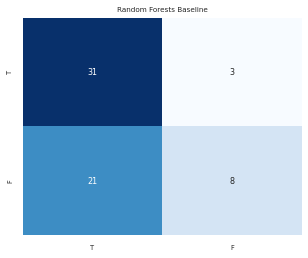

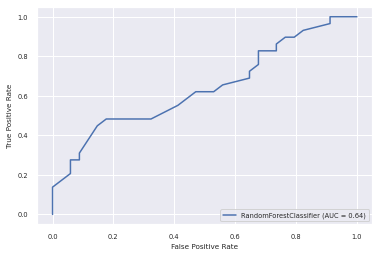

This is the starting index: 408 of patient 10
0.8333333333333334
[(1, 1, array([0.27, 0.73])), (1, 1, array([0.15, 0.85])), (1, 1, array([0.31, 0.69])), (1, 1, array([0.18, 0.82])), (1, 1, array([0.18, 0.82])), (1, 1, array([0.18, 0.82])), (1, 1, array([0.02, 0.98])), (1, 1, array([0.46, 0.54])), (1, 1, array([0.2, 0.8])), (0, 0, array([0.58, 0.42])), (0, 0, array([0.59, 0.41])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.28, 0.72])), (1, 1, array([0.02, 0.98])), (1, 1, array([0.12, 0.88])), (0, 0, array([0.7, 0.3])), (1, 0, array([0.65, 0.35])), (1, 0, array([0.6, 0.4])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.11, 0.89])), (0, 1, array([0.3, 0.7])), (1, 0, array([0.65, 0.35])), (0, 0, array([0.8, 0.2])), (1, 1, array([0.28, 0.72])), (1, 1, array([0.21, 0.79])), (0, 0, array([0.69, 0.31])), (1, 1, array([0.49, 0.51])), (1, 1, array([0.23, 0.77])), (1, 1, array([0.1, 0.9])), (1, 0, array([0.63, 0.37])), (1, 1, array([0.24, 0.76])), (1, 1, array([0.47, 0.53])), (1, 1, array([0.15, 

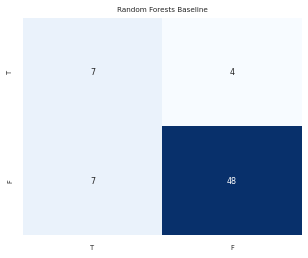

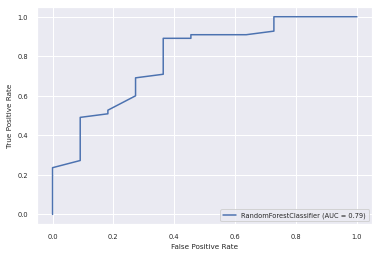

This is the starting index: 475 of patient 11
0.7777777777777778
[(0, 0, array([0.92, 0.08])), (1, 0, array([0.57, 0.43])), (1, 1, array([0.15, 0.85])), (1, 1, array([0.32, 0.68])), (0, 0, array([0.52, 0.48])), (1, 1, array([0.11, 0.89])), (1, 0, array([0.72, 0.28])), (1, 1, array([0.25, 0.75])), (1, 1, array([0.15, 0.85])), (1, 1, array([0.24, 0.76])), (1, 1, array([0.28, 0.72])), (0, 0, array([0.59, 0.41])), (1, 1, array([0.24, 0.76])), (1, 1, array([0.45, 0.55])), (1, 1, array([0.2, 0.8])), (1, 0, array([0.66, 0.34])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.41, 0.59])), (1, 1, array([0.31, 0.69])), (1, 1, array([0.16, 0.84])), (1, 0, array([0.72, 0.28])), (1, 1, array([0.43, 0.57])), (1, 1, array([0.23, 0.77])), (1, 1, array([0.32, 0.68])), (1, 1, array([0.28, 0.72])), (0, 0, array([0.61, 0.39])), (1, 0, array([0.56, 0.44])), (1, 1, array([0.4, 0.6])), (0, 0, array([0.61, 0.39])), (1, 1, array([0.27, 0.73])), (1, 0, array([0.61, 0.39])), (1, 0, array([0.55, 0.45])), (1, 1, array

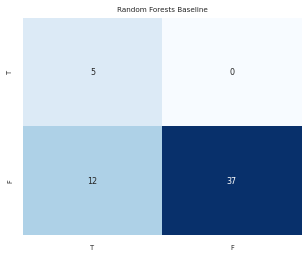

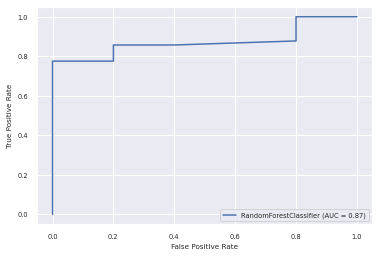

This is the starting index: 530 of patient 12
0.7592592592592593
[(1, 1, array([0.22, 0.78])), (1, 0, array([0.72, 0.28])), (1, 0, array([0.67, 0.33])), (1, 0, array([0.5, 0.5])), (1, 0, array([0.76, 0.24])), (1, 1, array([0.41, 0.59])), (1, 1, array([0.1, 0.9])), (0, 0, array([0.68, 0.32])), (0, 0, array([0.65, 0.35])), (1, 0, array([0.88, 0.12])), (1, 1, array([0.09, 0.91])), (1, 1, array([0.25, 0.75])), (1, 0, array([0.9, 0.1])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.08, 0.92])), (1, 1, array([0.48, 0.52])), (1, 1, array([0.12, 0.88])), (1, 1, array([0.1, 0.9])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.48, 0.52])), (1, 1, array([0.22, 0.78])), (1, 1, array([0.09, 0.91])), (1, 0, array([0.67, 0.33])), (1, 1, array([0.11, 0.89])), (1, 0, array([0.68, 0.32])), (1, 1, array([0.15, 0.85])), (1, 1, array([0.05, 0.95])), (1, 0, array([0.64, 0.36])), (1, 1, array([0.16, 0.84])), (1, 1, array([0.23, 0.77])), (1, 1, array([0.14, 0.86])), (1, 1, array([0.39, 0.61])), (1, 1, array([0.

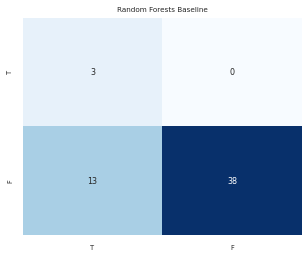

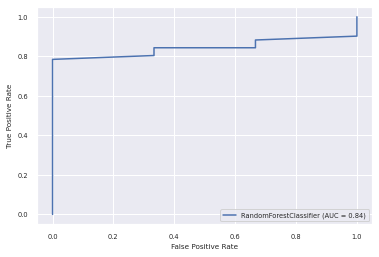

<function matplotlib.pyplot.show>

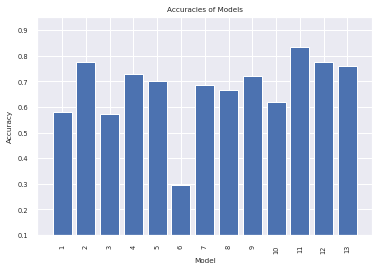

In [ ]:
Accuracy = []

clf = RandomForestClassifier()

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(train, train_class.ravel())
    model = SelectFromModel(clf, prefit=True)
    train = model.transform(train)
    # clf = ExtraTreesClassifier(n_estimators=50)
    # clf = clf.fit(test, test_class.ravel())
    # model = SelectFromModel(clf, prefit=True) 

    test = model.transform(test)
    clf = RandomForestClassifier()
    clf.fit(train, train_class.ravel())


    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### Auto Sklearn Recommendation

In [ ]:
#SVM with manual parameters
svm = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                         ('svm', SGDClassifier(loss='hinge', alpha=1e-3, random_state=42)),])

SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'extra_trees_preproc_for_classification', 'classifier:random_forest:bootstrap': 'False', 'classifier:random_forest:criterion': 'entropy', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.27453376891983117, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 13, 'classifier:random_forest:min_samples_split': 19, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.2166847947584762, 'feature_preprocessor:extra_trees_preproc_for_classification:bootstrap': 'False', 'feature_preprocessor:extra_trees_preproc_for_classification:criterion': 'entropy', 'feature_preprocessor:extra_trees_preproc_for_classification:max_depth': 'None', 'feature_preprocessor:extra_trees_preproc_for_classification:max_features': 0.2819773130241576, 'feature_preprocessor:extra_trees_preproc_for_classification:max_leaf_nodes': 'None', 'feature_preprocessor:extra_trees_preproc_for_classification:min_impurity_decrease': 0.0, 'feature_preprocessor:extra_trees_preproc_for_classification:min_samples_leaf': 20, 'feature_preprocessor:extra_trees_preproc_for_classification:min_samples_split': 3, 'feature_preprocessor:extra_trees_preproc_for_classification:min_weight_fraction_leaf': 0.0, 'feature_preprocessor:extra_trees_preproc_for_classification:n_estimators': 100},
d

### K Nearest Neighbors

#### Baseline

This is the starting index: 0 of patient 0
0.8
[(1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.2, 0.8])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.13333333, 0.86666667])),

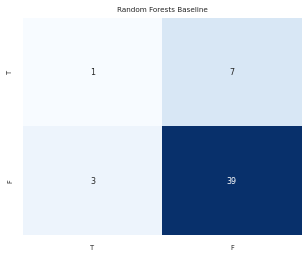

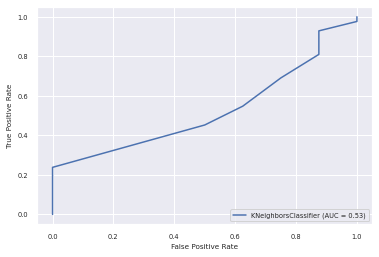

This is the starting index: 51 of patient 1
0.7037037037037037
[(0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.66666667, 0.33333333])), (0, 0, array([0.66666667, 0.33333333])), (0, 1, array([0.33333333, 0.66666667])), (0, 0, array([0.66666667, 0.33333333])), (0, 0, array([0.8, 0.2])), (0, 1, array([0.06666667, 0.93333333])), (0, 0, array([0.73333333, 0.26666667])), (0, 1, array([0.33333333, 0.66666667])), (0, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.8, 0.2])), (0, 1, array([0.26666667, 0.73333333])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.86666667, 0.13333333])), (0, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.86666667, 0.13333333])), (0, 1, array([0.4, 0.6])), (0, 0, array([0.66666667, 0.33333333])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, ar

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


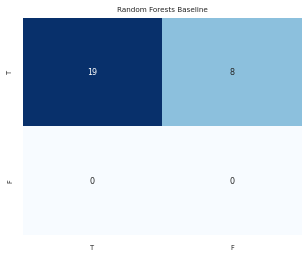

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


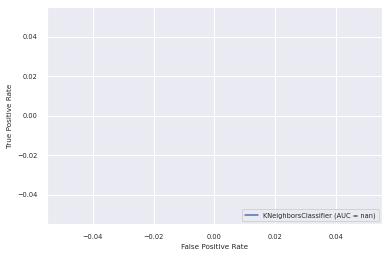

This is the starting index: 79 of patient 2
0.48214285714285715
[(0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.66666667, 0.33333333])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.26666667, 0.73333333])), (1, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.6, 0.4])), (1, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.73333333, 0.26666667])), (1, 0, array([0.6, 0.4])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.4, 0.6])), (0, 0, array([0.93333333, 0.06666667])), (0, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.86666667, 0.13333333])), (0, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.2, 0.8])), (0, 1, array([0.2, 0.8])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.73333333, 0.26666667])), (1, 0, array([0.6, 0.4])), (1, 0, array([0.53333333, 0.46666667])), (0, 1, arr

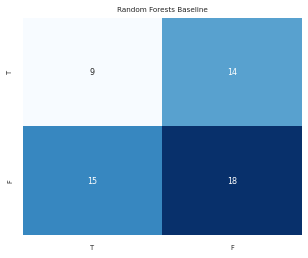

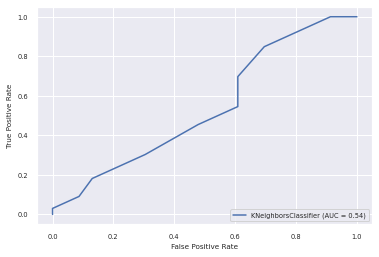

This is the starting index: 136 of patient 3
0.7567567567567568
[(1, 1, array([0.06666667, 0.93333333])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (1, 0, array([0.6, 0.4])), (0, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.13333333, 0.86666667])), (1, 0, array([0.53333333, 0.46666667])), (0, 1, a

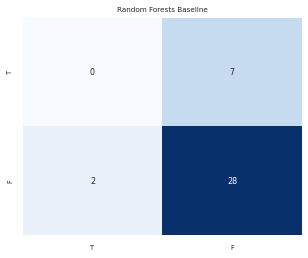

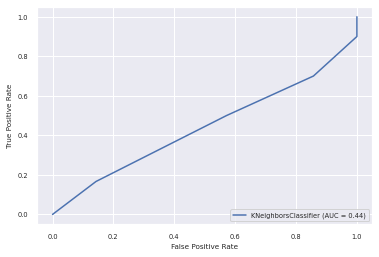

This is the starting index: 174 of patient 4
0.4864864864864865
[(0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.46666667, 0.53333333])), (1, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.8, 0.2])), (1, 1, array([0.2, 0.8])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.06666667, 0.93333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.66666667, 0.33333333])), (0, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.2, 0.8])), (1, 0, array([0.53333333, 0.4666666

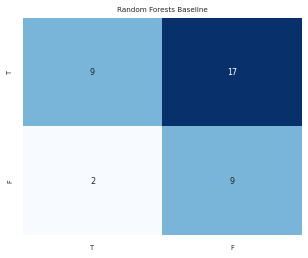

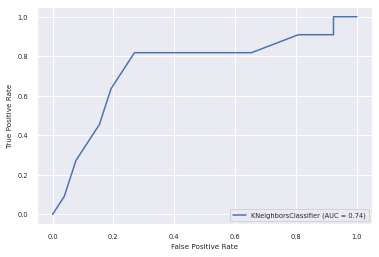

This is the starting index: 212 of patient 5
0.27450980392156865
[(1, 0, array([0.6, 0.4])), (1, 1, array([0., 1.])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0., 1.])), (0, 1, array([0.13333333, 0.86666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.2, 0.8])), (0, 1, array([0.2, 0.8])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0., 1.])), (0, 1, array([0.4, 0.6])), (0, 1, array([0., 1.])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.4, 0.6])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0., 1.])), (0, 1, array([0.13333333, 0.86666667])), (0, 0, array([0.86

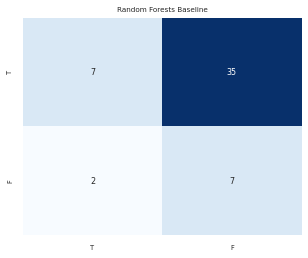

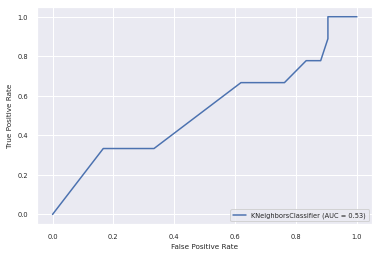

This is the starting index: 264 of patient 6
0.6842105263157895
[(0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (0, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.33333333, 0.66666667])), (0, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.46666667, 0.53333333]))]


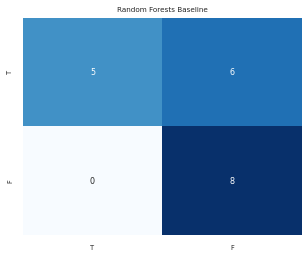

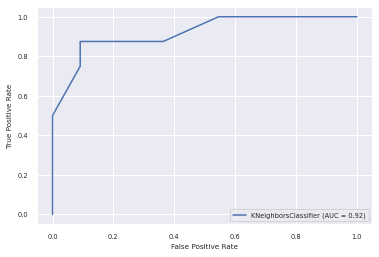

This is the starting index: 284 of patient 7
0.13333333333333333
[(0, 1, array([0.2, 0.8])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.06666667, 0.93333333])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.2, 0.8])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0., 1.])), (0, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.33333333, 0.66666667]))]


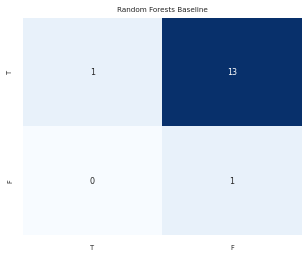

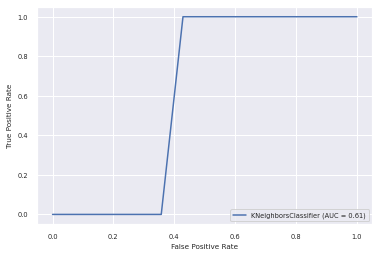

This is the starting index: 300 of patient 8
0.7674418604651163
[(0, 0, array([0.6, 0.4])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.86666667, 0.13333333])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.13333333, 0.86666667])), (0, 0, array([0.86666667, 0.13333333])), (0, 1, array([0.2, 0.8])), (0, 0, array([0.93333333, 0.06666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.6, 0.4])), (0, 0, array([0.86666667, 0.13333333])), (0, 1, array([0.2, 0.8])), (0, 0, array([0.8, 0.2])), (1, 1, array([0.06666667, 0.93333333])), (0, 0, array([0.66666667, 0.33333333])), (1, 1, array([0., 1.])), (1, 1, array([0.06666667, 0.93333333])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.06666667, 0.93333333])), (1, 1, array([0.13333333, 0.86666667]))

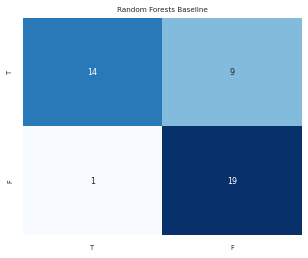

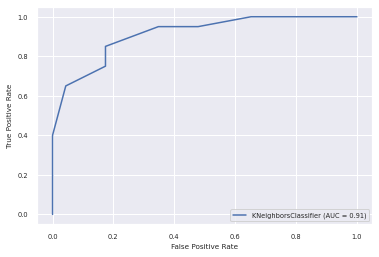

This is the starting index: 344 of patient 9
0.5079365079365079
[(1, 0, array([0.8, 0.2])), (1, 1, array([0.26666667, 0.73333333])), (0, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.2, 0.8])), (1, 0, array([0.73333333, 0.26666667])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.26666667, 0.73333333])), (0, 0, array([0.86666667, 0.13333333])), (0, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.33333333, 0.66666667])), (1, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.6, 0.4])), (0, 0, array([0.66666667, 0.33333333])), (1, 0, array([0.66666667, 0.33333333])), (1, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.33333

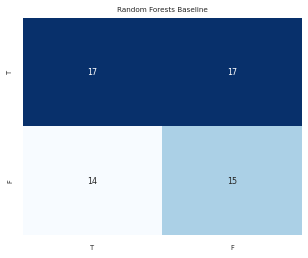

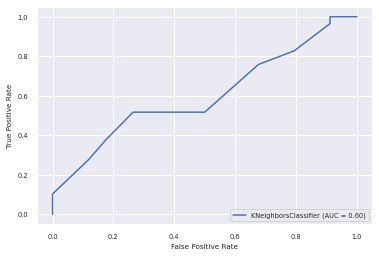

This is the starting index: 408 of patient 10
0.8484848484848485
[(1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0., 1.])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.33333333, 0.66666667])), (0, 0, array([0.66666667, 0.33333333])), (1, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.4, 0.6])), (0, 0, array([0.66666667, 0.33333333])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.26666667, 0.73333333])), (1, 0, array([0.6, 0.4])), (0, 0, array([0.86666667, 0.13333333])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.2, 0.8])), (0, 0, array([0.66666667, 0.33333333])), (1, 1, arr

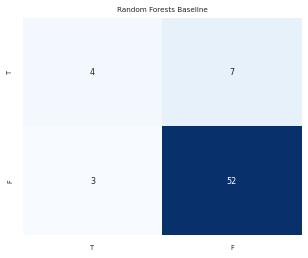

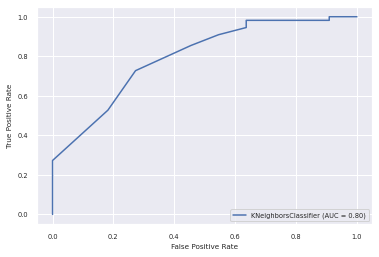

This is the starting index: 475 of patient 11
0.8148148148148148
[(0, 0, array([0.93333333, 0.06666667])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.2, 0.8])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.4, 0.6])), (1, 1, array([0., 1.])), (1, 1, array([0.26666667, 0.73333333])), (1, 0, array([0.66666667, 0.33333333])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.26666667, 0.73333333])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.4, 0.6])), (0, 0, array([0.6, 0.4])), (1, 0, array([0.53333333

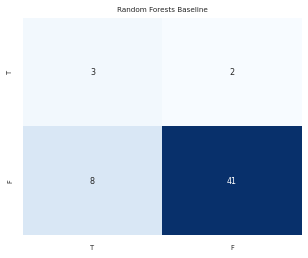

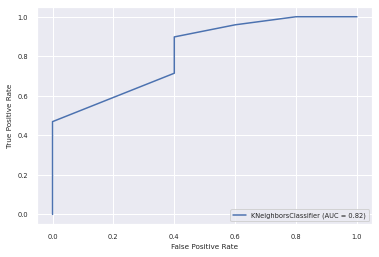

This is the starting index: 530 of patient 12
0.8148148148148148
[(1, 1, array([0.13333333, 0.86666667])), (1, 0, array([0.73333333, 0.26666667])), (1, 1, array([0.46666667, 0.53333333])), (1, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.4, 0.6])), (0, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.93333333, 0.06666667])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (1, 0, array([0.86666667, 0.13333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.13333333, 0.86666667])), (1, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.2, 0.8])), (1, 1, a

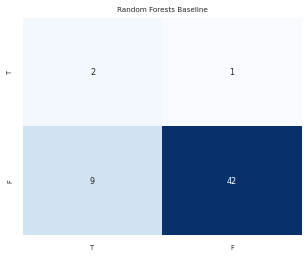

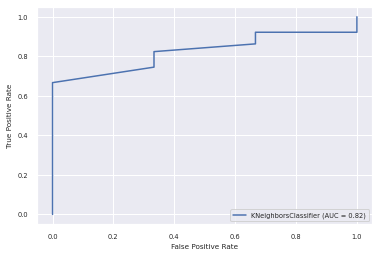

<function matplotlib.pyplot.show>

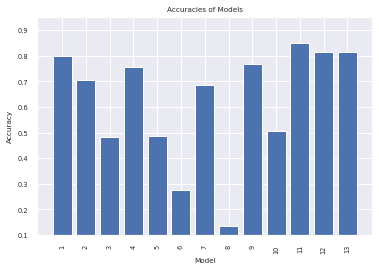

In [ ]:
Accuracy = []

clf = KNeighborsClassifier(n_neighbors=15)

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result) 
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### GridSearch

In [ ]:
parameters = {
    'n_neighbors'      : [20,25,30,35],
    'weights'         : ['uniform', 'distance'],
    'metric'      : ['euclidean','manhattan'],
    #'max_features': ['auto'],
    #'criterion' :['gini']
}


for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    search = GridSearchCV(KNeighborsClassifier(), parameters, cv=10, n_jobs=-1)
    search.fit(train, train_class.ravel())

    print(search.score(train, train_class.ravel()))
    print(search.best_params_)

This is the starting index: 0 of patient 0
0.7308411214953271
{'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}
This is the starting index: 51 of patient 1
0.7168458781362007
{'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}
This is the starting index: 79 of patient 2
0.7334593572778828
{'metric': 'euclidean', 'n_neighbors': 30, 'weights': 'uniform'}
This is the starting index: 136 of patient 3
1.0
{'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'distance'}
This is the starting index: 174 of patient 4
0.7171532846715328
{'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}
This is the starting index: 212 of patient 5
0.7359550561797753
{'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}
This is the starting index: 264 of patient 6
1.0
{'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'distance'}
This is the starting index: 284 of patient 7
0.7456140350877193
{'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}


This is the starting index: 0 of patient 0
0.78
[(1, 1, array([0.46299848, 0.53700152])), (1, 1, array([0.2307594, 0.7692406])), (1, 1, array([0.27001435, 0.72998565])), (0, 1, array([0.225812, 0.774188])), (1, 1, array([0.338661, 0.661339])), (1, 1, array([0.31570047, 0.68429953])), (1, 1, array([0.28630997, 0.71369003])), (1, 1, array([0.1956851, 0.8043149])), (1, 1, array([0.32492416, 0.67507584])), (0, 1, array([0.39753115, 0.60246885])), (1, 1, array([0.31546966, 0.68453034])), (1, 1, array([0.16970974, 0.83029026])), (0, 1, array([0.32332049, 0.67667951])), (1, 1, array([0.19581122, 0.80418878])), (0, 1, array([0.45286863, 0.54713137])), (1, 1, array([0.36067613, 0.63932387])), (1, 1, array([0.39761542, 0.60238458])), (1, 1, array([0.33299271, 0.66700729])), (1, 1, array([0.21383649, 0.78616351])), (1, 1, array([0.20255666, 0.79744334])), (1, 1, array([0.243413, 0.756587])), (1, 1, array([0.1311484, 0.8688516])), (1, 1, array([0.3313972, 0.6686028])), (0, 1, array([0.16146255, 0.

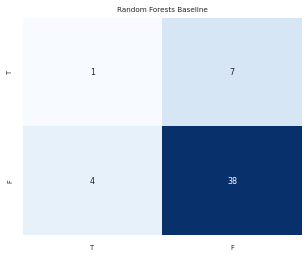

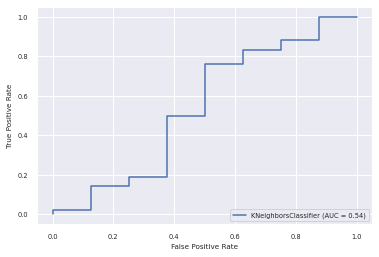

This is the starting index: 51 of patient 1
0.5555555555555556
[(0, 1, array([0.46978112, 0.53021888])), (0, 0, array([0.69236075, 0.30763925])), (0, 0, array([0.60427103, 0.39572897])), (0, 1, array([0.46594696, 0.53405304])), (0, 0, array([0.5085166, 0.4914834])), (0, 1, array([0.35666823, 0.64333177])), (0, 1, array([0.06362815, 0.93637185])), (0, 0, array([0.7482218, 0.2517782])), (0, 1, array([0.49863336, 0.50136664])), (0, 0, array([0.73678478, 0.26321522])), (0, 0, array([0.56883012, 0.43116988])), (0, 0, array([0.50690071, 0.49309929])), (0, 0, array([0.73136756, 0.26863244])), (0, 0, array([0.74175814, 0.25824186])), (0, 1, array([0.47568025, 0.52431975])), (0, 0, array([0.56665794, 0.43334206])), (0, 1, array([0.49781804, 0.50218196])), (0, 0, array([0.55992804, 0.44007196])), (0, 1, array([0.47432669, 0.52567331])), (0, 0, array([0.56758389, 0.43241611])), (0, 0, array([0.52326769, 0.47673231])), (0, 0, array([0.68577235, 0.31422765])), (0, 1, array([0.44076539, 0.55923461])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


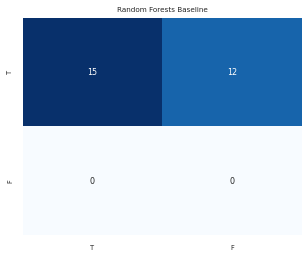

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


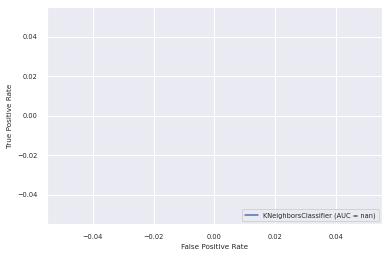

This is the starting index: 79 of patient 2
0.44642857142857145
[(0, 1, array([0.44185078, 0.55814922])), (0, 1, array([0.4699358, 0.5300642])), (1, 1, array([0.38408612, 0.61591388])), (0, 1, array([0.21196115, 0.78803885])), (1, 1, array([0.40134899, 0.59865101])), (1, 0, array([0.78510789, 0.21489211])), (1, 0, array([0.60402614, 0.39597386])), (1, 1, array([0.19987961, 0.80012039])), (1, 0, array([0.53287107, 0.46712893])), (1, 0, array([0.60380259, 0.39619741])), (1, 0, array([0.65348251, 0.34651749])), (0, 0, array([0.6978398, 0.3021602])), (1, 1, array([0.49776189, 0.50223811])), (0, 1, array([0.43870166, 0.56129834])), (0, 1, array([0.17235423, 0.82764577])), (1, 1, array([0.48823702, 0.51176298])), (0, 0, array([0.56780499, 0.43219501])), (0, 0, array([0.6729747, 0.3270253])), (0, 0, array([0.70944797, 0.29055203])), (0, 1, array([0.42594598, 0.57405402])), (0, 1, array([0.2478012, 0.7521988])), (0, 1, array([0.32032773, 0.67967227])), (0, 1, array([0.23014701, 0.76985299])), 

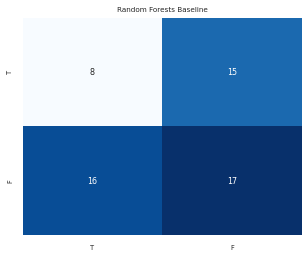

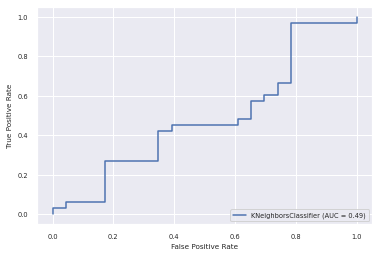

This is the starting index: 136 of patient 3
0.8108108108108109
[(1, 1, array([0.18870761, 0.81129239])), (1, 1, array([0.12366197, 0.87633803])), (1, 1, array([0.32821051, 0.67178949])), (1, 1, array([0.22437048, 0.77562952])), (1, 1, array([0.19382127, 0.80617873])), (1, 1, array([0.19433449, 0.80566551])), (1, 1, array([0.22673948, 0.77326052])), (1, 1, array([0.20252014, 0.79747986])), (0, 1, array([0.25765225, 0.74234775])), (1, 1, array([0.1577168, 0.8422832])), (1, 1, array([0.22823724, 0.77176276])), (1, 1, array([0.27276357, 0.72723643])), (1, 1, array([0.13187766, 0.86812234])), (1, 1, array([0.17584727, 0.82415273])), (1, 1, array([0.24776523, 0.75223477])), (1, 1, array([0.10891298, 0.89108702])), (0, 1, array([0.16481577, 0.83518423])), (0, 1, array([0.23434516, 0.76565484])), (1, 1, array([0.22501809, 0.77498191])), (1, 1, array([0.07135393, 0.92864607])), (1, 1, array([0.46755891, 0.53244109])), (0, 1, array([0.10116065, 0.89883935])), (1, 1, array([0.19648263, 0.8035173

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


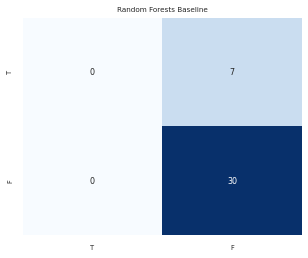

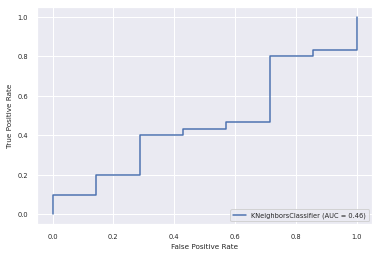

This is the starting index: 174 of patient 4
0.5135135135135135
[(0, 0, array([0.56185666, 0.43814334])), (0, 1, array([0.39722622, 0.60277378])), (1, 1, array([0.23569607, 0.76430393])), (0, 0, array([0.62971868, 0.37028132])), (1, 1, array([0.47793786, 0.52206214])), (0, 0, array([0.61090512, 0.38909488])), (1, 1, array([0.19108625, 0.80891375])), (0, 1, array([0.48283891, 0.51716109])), (1, 1, array([0.27227026, 0.72772974])), (0, 1, array([0.36183544, 0.63816456])), (0, 1, array([0.25777019, 0.74222981])), (0, 0, array([0.53935023, 0.46064977])), (0, 0, array([0.63465065, 0.36534935])), (0, 1, array([0.31630792, 0.68369208])), (0, 0, array([0.56430296, 0.43569704])), (0, 1, array([0.41218133, 0.58781867])), (1, 1, array([0.34190759, 0.65809241])), (0, 1, array([0.19123536, 0.80876464])), (0, 1, array([0.43063586, 0.56936414])), (0, 1, array([0.46643629, 0.53356371])), (0, 0, array([0.53565622, 0.46434378])), (0, 0, array([0.53437774, 0.46562226])), (1, 1, array([0.19145315, 0.80854

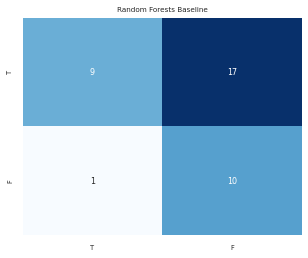

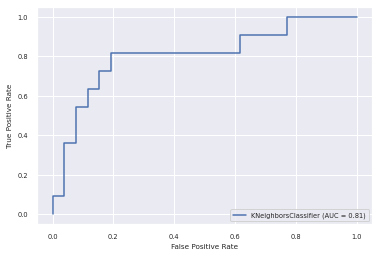

This is the starting index: 212 of patient 5
0.29411764705882354
[(1, 0, array([0.5263459, 0.4736541])), (1, 1, array([0., 1.])), (0, 1, array([0.19665541, 0.80334459])), (0, 1, array([0., 1.])), (0, 1, array([0.03531417, 0.96468583])), (0, 0, array([0.5620522, 0.4379478])), (0, 1, array([0.36187192, 0.63812808])), (0, 1, array([0.288304, 0.711696])), (0, 1, array([0.43890292, 0.56109708])), (0, 1, array([0.03364387, 0.96635613])), (0, 1, array([0.03787089, 0.96212911])), (0, 1, array([0.29238706, 0.70761294])), (0, 1, array([0.03248778, 0.96751222])), (0, 1, array([0.28377894, 0.71622106])), (0, 1, array([0.19130819, 0.80869181])), (0, 1, array([0.46085553, 0.53914447])), (0, 1, array([0.05872735, 0.94127265])), (0, 1, array([0.28094476, 0.71905524])), (0, 1, array([0.02969086, 0.97030914])), (0, 1, array([0.19982573, 0.80017427])), (0, 1, array([0.19766859, 0.80233141])), (0, 1, array([0.46289064, 0.53710936])), (0, 0, array([0.50603407, 0.49396593])), (0, 1, array([0.0997847, 0.9002

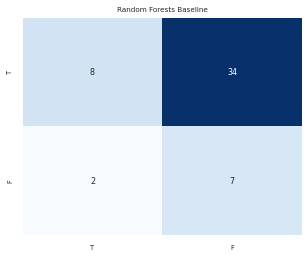

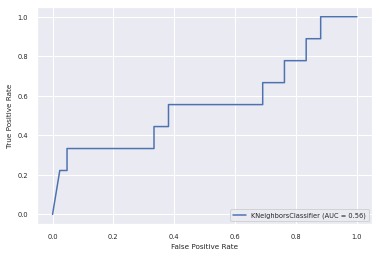

This is the starting index: 264 of patient 6
0.5263157894736842
[(0, 1, array([0.36318063, 0.63681937])), (0, 1, array([0.33563437, 0.66436563])), (1, 1, array([0.32840635, 0.67159365])), (0, 1, array([0.47422831, 0.52577169])), (0, 0, array([0.53701046, 0.46298954])), (1, 1, array([0.4482696, 0.5517304])), (0, 1, array([0.47105196, 0.52894804])), (0, 1, array([0.49788202, 0.50211798])), (1, 1, array([0.26193144, 0.73806856])), (0, 1, array([0.49951333, 0.50048667])), (1, 1, array([0.27924711, 0.72075289])), (0, 1, array([0.37609577, 0.62390423])), (1, 1, array([0.36128751, 0.63871249])), (1, 1, array([0.26204366, 0.73795634])), (0, 1, array([0.49361795, 0.50638205])), (1, 1, array([0.26125017, 0.73874983])), (1, 1, array([0.11847795, 0.88152205])), (0, 0, array([0.56175837, 0.43824163])), (0, 1, array([0.49002205, 0.50997795]))]


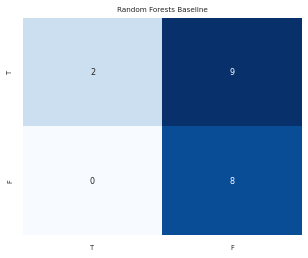

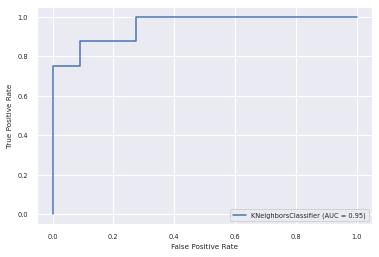

This is the starting index: 284 of patient 7
0.06666666666666667
[(0, 1, array([0.16075364, 0.83924636])), (0, 1, array([0.1505608, 0.8494392])), (0, 1, array([0.16350717, 0.83649283])), (0, 1, array([0.47821798, 0.52178202])), (0, 1, array([0.23147133, 0.76852867])), (0, 1, array([0.09989791, 0.90010209])), (0, 1, array([0.13156804, 0.86843196])), (0, 1, array([0.20417504, 0.79582496])), (0, 1, array([0.08192445, 0.91807555])), (0, 1, array([0.2295774, 0.7704226])), (1, 1, array([0.13218384, 0.86781616])), (0, 1, array([0.07500237, 0.92499763])), (0, 1, array([0.18150441, 0.81849559])), (0, 1, array([0.31900285, 0.68099715])), (0, 1, array([0.49687259, 0.50312741]))]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


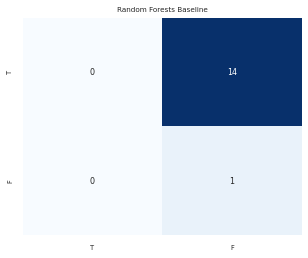

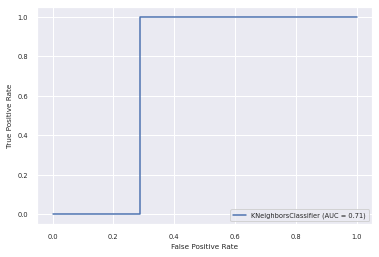

This is the starting index: 300 of patient 8
0.6976744186046512
[(0, 1, array([0.4649029, 0.5350971])), (0, 0, array([0.54428041, 0.45571959])), (0, 0, array([0.56566853, 0.43433147])), (0, 1, array([0.45858079, 0.54141921])), (0, 1, array([0.1637347, 0.8362653])), (0, 0, array([0.50785442, 0.49214558])), (0, 1, array([0.07195489, 0.92804511])), (0, 0, array([0.71869005, 0.28130995])), (0, 1, array([0.48196194, 0.51803806])), (0, 0, array([0.51593487, 0.48406513])), (0, 0, array([0.51123742, 0.48876258])), (0, 0, array([0.69056807, 0.30943193])), (0, 1, array([0.17422308, 0.82577692])), (0, 0, array([0.63138215, 0.36861785])), (1, 1, array([0.20958476, 0.79041524])), (0, 0, array([0.5382952, 0.4617048])), (1, 1, array([0.08715822, 0.91284178])), (1, 1, array([0.06872865, 0.93127135])), (0, 1, array([0.28447653, 0.71552347])), (0, 1, array([0.26480981, 0.73519019])), (1, 1, array([0.03447839, 0.96552161])), (0, 1, array([0.40818239, 0.59181761])), (1, 1, array([0.0949745, 0.9050255])), 

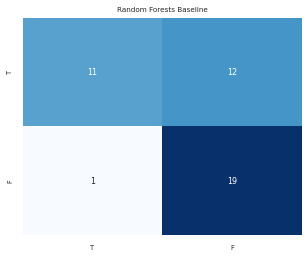

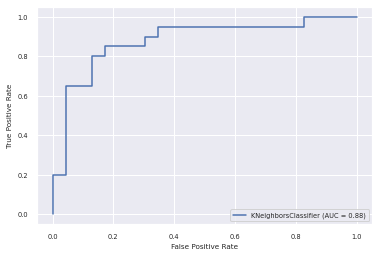

This is the starting index: 344 of patient 9
0.47619047619047616
[(1, 0, array([0.59567817, 0.40432183])), (1, 1, array([0.26864463, 0.73135537])), (0, 0, array([0.50146489, 0.49853511])), (1, 0, array([0.58080709, 0.41919291])), (1, 1, array([0.14921435, 0.85078565])), (1, 1, array([0.23692258, 0.76307742])), (1, 0, array([0.53085041, 0.46914959])), (0, 0, array([0.53621933, 0.46378067])), (0, 1, array([0.4052318, 0.5947682])), (0, 1, array([0.46701246, 0.53298754])), (0, 1, array([0.46086129, 0.53913871])), (0, 1, array([0.39838358, 0.60161642])), (0, 0, array([0.74433937, 0.25566063])), (0, 1, array([0.47291466, 0.52708534])), (0, 1, array([0.41580327, 0.58419673])), (0, 0, array([0.53282052, 0.46717948])), (0, 1, array([0.31044748, 0.68955252])), (1, 0, array([0.67783727, 0.32216273])), (0, 1, array([0.43511169, 0.56488831])), (0, 0, array([0.55651923, 0.44348077])), (1, 1, array([0.4688089, 0.5311911])), (1, 1, array([0.29957658, 0.70042342])), (0, 1, array([0.43475731, 0.56524269

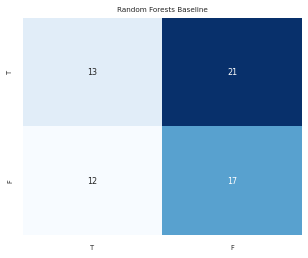

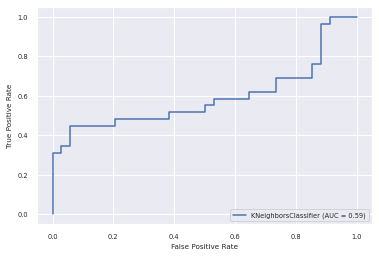

This is the starting index: 408 of patient 10
0.7878787878787878
[(1, 1, array([0.22737455, 0.77262545])), (1, 1, array([0.23836012, 0.76163988])), (1, 1, array([0.23627571, 0.76372429])), (1, 1, array([0.12274205, 0.87725795])), (1, 1, array([0.36571427, 0.63428573])), (1, 1, array([0.23773793, 0.76226207])), (1, 1, array([0.12955958, 0.87044042])), (1, 1, array([0.44273952, 0.55726048])), (1, 1, array([0.1604291, 0.8395709])), (0, 1, array([0.4713394, 0.5286606])), (0, 1, array([0.36787363, 0.63212637])), (1, 1, array([0.23280191, 0.76719809])), (1, 1, array([0.25763143, 0.74236857])), (1, 1, array([0.15352728, 0.84647272])), (1, 1, array([0.2377852, 0.7622148])), (0, 1, array([0.43519114, 0.56480886])), (1, 0, array([0.76132795, 0.23867205])), (1, 0, array([0.58381988, 0.41618012])), (0, 0, array([0.6454236, 0.3545764])), (1, 1, array([0.15644311, 0.84355689])), (0, 1, array([0.27740412, 0.72259588])), (1, 0, array([0.6068227, 0.3931773])), (0, 0, array([0.64651235, 0.35348765])), (

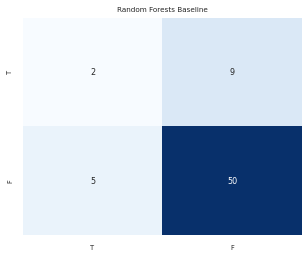

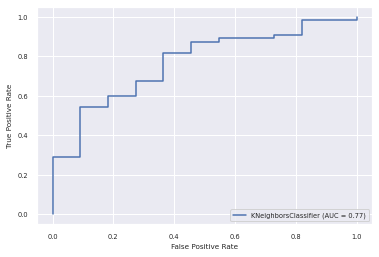

This is the starting index: 475 of patient 11
0.7407407407407407
[(0, 0, array([0.76264163, 0.23735837])), (1, 1, array([0.44946971, 0.55053029])), (1, 1, array([0.25722596, 0.74277404])), (1, 1, array([0.43173178, 0.56826822])), (0, 1, array([0.36296298, 0.63703702])), (1, 1, array([0.19078553, 0.80921447])), (1, 0, array([0.54606669, 0.45393331])), (1, 1, array([0.33020114, 0.66979886])), (1, 1, array([0.17394999, 0.82605001])), (1, 1, array([0.26023946, 0.73976054])), (1, 1, array([0.43803898, 0.56196102])), (0, 1, array([0.46546736, 0.53453264])), (1, 1, array([0.27759524, 0.72240476])), (1, 1, array([0.40351489, 0.59648511])), (1, 1, array([0.36620773, 0.63379227])), (1, 1, array([0.47663425, 0.52336575])), (1, 1, array([0.28064786, 0.71935214])), (1, 1, array([0.42840968, 0.57159032])), (1, 1, array([0.37398832, 0.62601168])), (1, 1, array([0.28761643, 0.71238357])), (1, 0, array([0.60838378, 0.39161622])), (1, 1, array([0.4323946, 0.5676054])), (1, 1, array([0.29282145, 0.707178

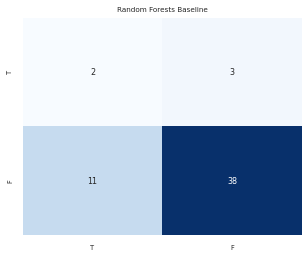

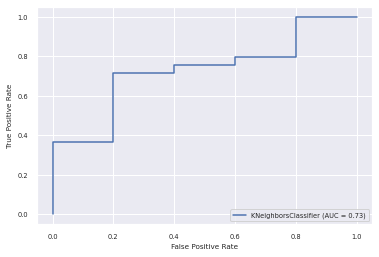

This is the starting index: 530 of patient 12
0.8148148148148148
[(1, 1, array([0.27448832, 0.72551168])), (1, 0, array([0.65314991, 0.34685009])), (1, 1, array([0.38408011, 0.61591989])), (1, 0, array([0.56849856, 0.43150144])), (1, 1, array([0.47030848, 0.52969152])), (1, 1, array([0.3190884, 0.6809116])), (1, 1, array([0.27651538, 0.72348462])), (0, 1, array([0.36736033, 0.63263967])), (0, 1, array([0.39183602, 0.60816398])), (1, 0, array([0.83933278, 0.16066722])), (1, 1, array([0.26546805, 0.73453195])), (1, 1, array([0.23243217, 0.76756783])), (1, 0, array([0.65918504, 0.34081496])), (1, 1, array([0.23242841, 0.76757159])), (1, 1, array([0.26050362, 0.73949638])), (1, 1, array([0.46727094, 0.53272906])), (1, 1, array([0.22552095, 0.77447905])), (1, 1, array([0.28118613, 0.71881387])), (1, 1, array([0.26340352, 0.73659648])), (1, 1, array([0.48899055, 0.51100945])), (1, 1, array([0.16480199, 0.83519801])), (1, 1, array([0.22435388, 0.77564612])), (1, 1, array([0.40329376, 0.596706

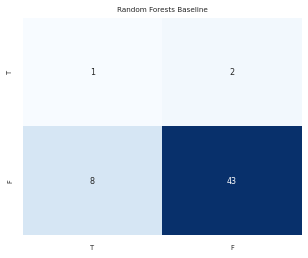

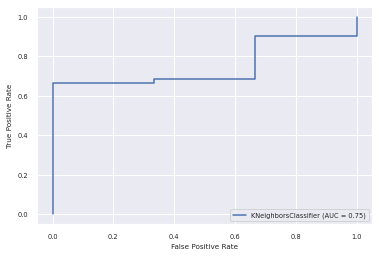

<function matplotlib.pyplot.show>

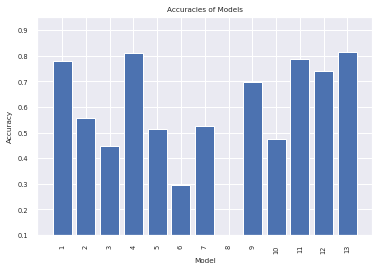

In [ ]:
Accuracy = []
clf = KNeighborsClassifier(n_neighbors=30, metric='manhattan', weights= 'distance')

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### Low Variance

This is the starting index: 0 of patient 0
0.8
[(1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.2, 0.8])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.13333333, 0.86666667])),

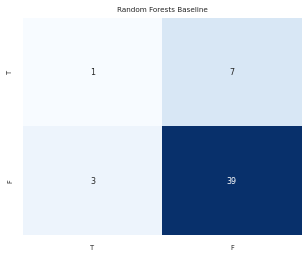

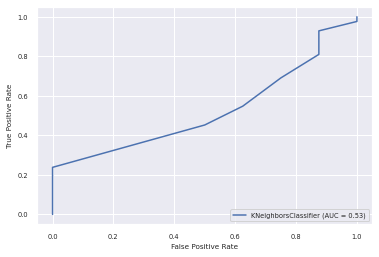

This is the starting index: 51 of patient 1
0.7037037037037037
[(0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.66666667, 0.33333333])), (0, 0, array([0.66666667, 0.33333333])), (0, 1, array([0.33333333, 0.66666667])), (0, 0, array([0.66666667, 0.33333333])), (0, 0, array([0.8, 0.2])), (0, 1, array([0.06666667, 0.93333333])), (0, 0, array([0.73333333, 0.26666667])), (0, 1, array([0.33333333, 0.66666667])), (0, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.8, 0.2])), (0, 1, array([0.26666667, 0.73333333])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.86666667, 0.13333333])), (0, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.86666667, 0.13333333])), (0, 1, array([0.4, 0.6])), (0, 0, array([0.66666667, 0.33333333])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, ar

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


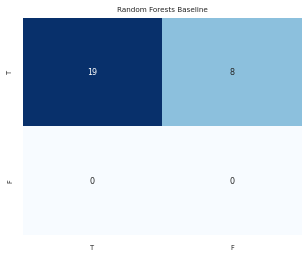

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


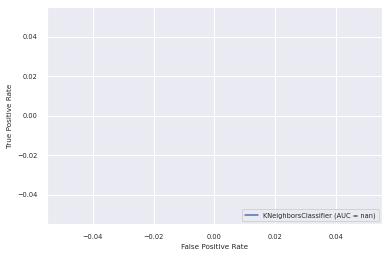

This is the starting index: 79 of patient 2
0.48214285714285715
[(0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.66666667, 0.33333333])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.26666667, 0.73333333])), (1, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.6, 0.4])), (1, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.73333333, 0.26666667])), (1, 0, array([0.6, 0.4])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.4, 0.6])), (0, 0, array([0.93333333, 0.06666667])), (0, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.86666667, 0.13333333])), (0, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.2, 0.8])), (0, 1, array([0.2, 0.8])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.73333333, 0.26666667])), (1, 0, array([0.6, 0.4])), (1, 0, array([0.53333333, 0.46666667])), (0, 1, arr

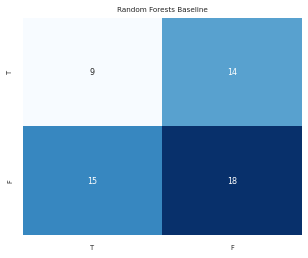

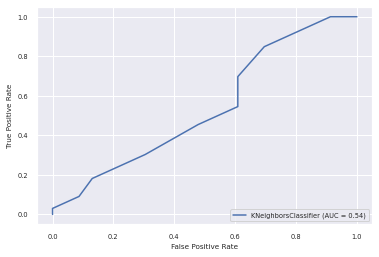

This is the starting index: 136 of patient 3
0.7567567567567568
[(1, 1, array([0.06666667, 0.93333333])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (1, 0, array([0.6, 0.4])), (0, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.13333333, 0.86666667])), (1, 0, array([0.53333333, 0.46666667])), (0, 1, a

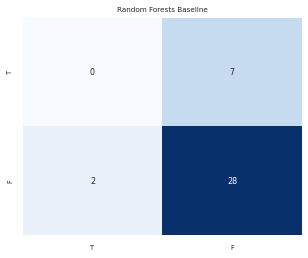

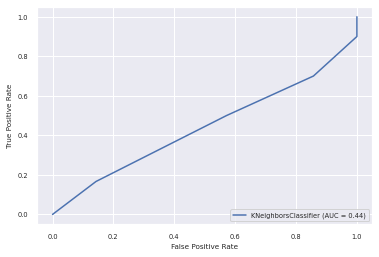

This is the starting index: 174 of patient 4
0.4864864864864865
[(0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.46666667, 0.53333333])), (1, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.8, 0.2])), (1, 1, array([0.2, 0.8])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.06666667, 0.93333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.66666667, 0.33333333])), (0, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.2, 0.8])), (1, 0, array([0.53333333, 0.4666666

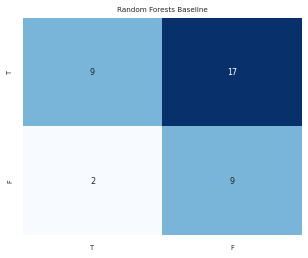

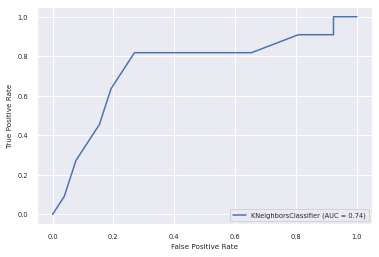

This is the starting index: 212 of patient 5
0.27450980392156865
[(1, 0, array([0.6, 0.4])), (1, 1, array([0., 1.])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0., 1.])), (0, 1, array([0.13333333, 0.86666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.2, 0.8])), (0, 1, array([0.2, 0.8])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0., 1.])), (0, 1, array([0.4, 0.6])), (0, 1, array([0., 1.])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.4, 0.6])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0., 1.])), (0, 1, array([0.13333333, 0.86666667])), (0, 0, array([0.86

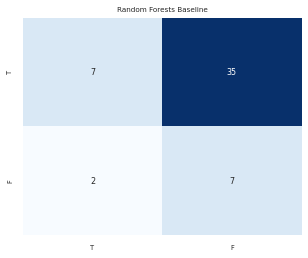

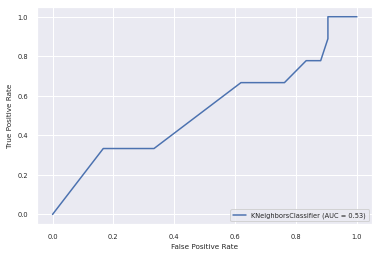

This is the starting index: 264 of patient 6
0.6842105263157895
[(0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (0, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.33333333, 0.66666667])), (0, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.46666667, 0.53333333]))]


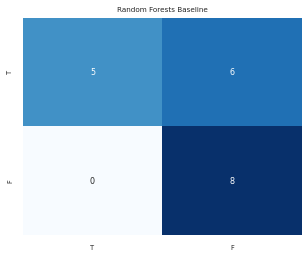

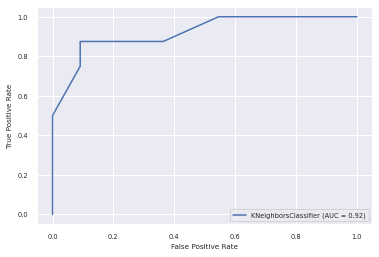

This is the starting index: 284 of patient 7
0.13333333333333333
[(0, 1, array([0.2, 0.8])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.06666667, 0.93333333])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.2, 0.8])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0., 1.])), (0, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.33333333, 0.66666667]))]


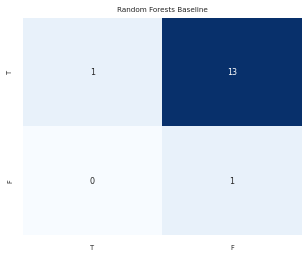

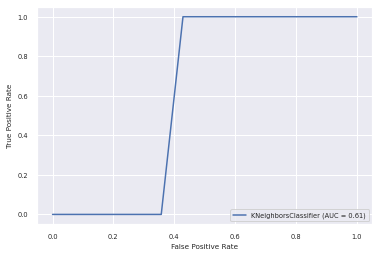

This is the starting index: 300 of patient 8
0.7674418604651163
[(0, 0, array([0.6, 0.4])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.86666667, 0.13333333])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.13333333, 0.86666667])), (0, 0, array([0.86666667, 0.13333333])), (0, 1, array([0.2, 0.8])), (0, 0, array([0.93333333, 0.06666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.6, 0.4])), (0, 0, array([0.86666667, 0.13333333])), (0, 1, array([0.2, 0.8])), (0, 0, array([0.8, 0.2])), (1, 1, array([0.06666667, 0.93333333])), (0, 0, array([0.66666667, 0.33333333])), (1, 1, array([0., 1.])), (1, 1, array([0.06666667, 0.93333333])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.06666667, 0.93333333])), (1, 1, array([0.13333333, 0.86666667]))

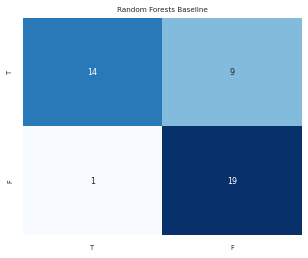

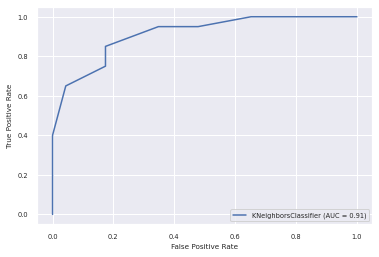

This is the starting index: 344 of patient 9
0.5079365079365079
[(1, 0, array([0.8, 0.2])), (1, 1, array([0.26666667, 0.73333333])), (0, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.2, 0.8])), (1, 0, array([0.73333333, 0.26666667])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.26666667, 0.73333333])), (0, 0, array([0.86666667, 0.13333333])), (0, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.33333333, 0.66666667])), (1, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.6, 0.4])), (0, 0, array([0.66666667, 0.33333333])), (1, 0, array([0.66666667, 0.33333333])), (1, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.33333

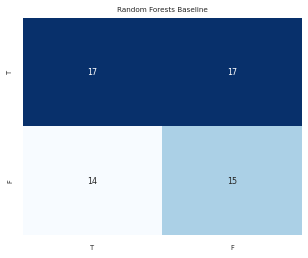

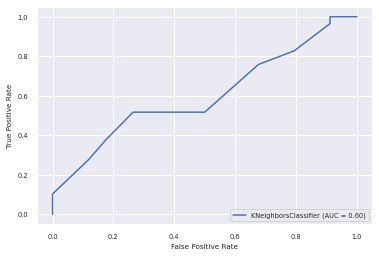

This is the starting index: 408 of patient 10
0.8484848484848485
[(1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0., 1.])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.33333333, 0.66666667])), (0, 0, array([0.66666667, 0.33333333])), (1, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.4, 0.6])), (0, 0, array([0.66666667, 0.33333333])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.26666667, 0.73333333])), (1, 0, array([0.6, 0.4])), (0, 0, array([0.86666667, 0.13333333])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.2, 0.8])), (0, 0, array([0.66666667, 0.33333333])), (1, 1, arr

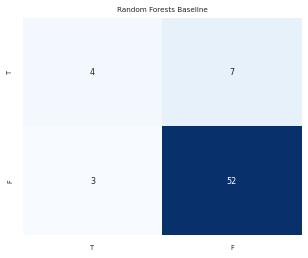

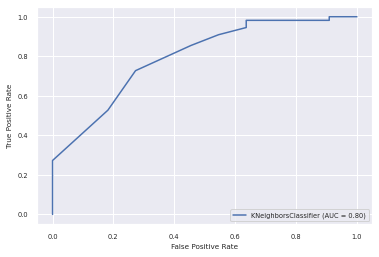

This is the starting index: 475 of patient 11
0.8148148148148148
[(0, 0, array([0.93333333, 0.06666667])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.2, 0.8])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.4, 0.6])), (1, 1, array([0., 1.])), (1, 1, array([0.26666667, 0.73333333])), (1, 0, array([0.66666667, 0.33333333])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.26666667, 0.73333333])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.4, 0.6])), (0, 0, array([0.6, 0.4])), (1, 0, array([0.53333333

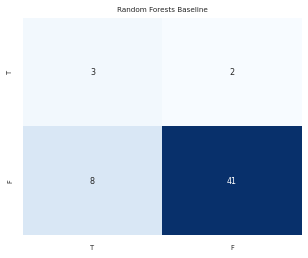

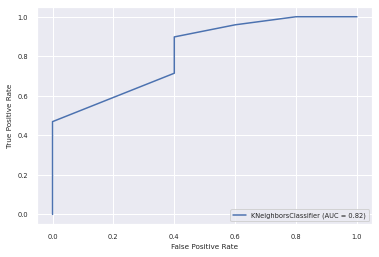

This is the starting index: 530 of patient 12
0.8148148148148148
[(1, 1, array([0.13333333, 0.86666667])), (1, 0, array([0.73333333, 0.26666667])), (1, 1, array([0.46666667, 0.53333333])), (1, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.4, 0.6])), (0, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.93333333, 0.06666667])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (1, 0, array([0.86666667, 0.13333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.13333333, 0.86666667])), (1, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.2, 0.8])), (1, 1, a

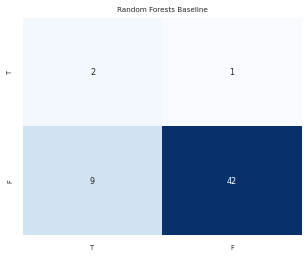

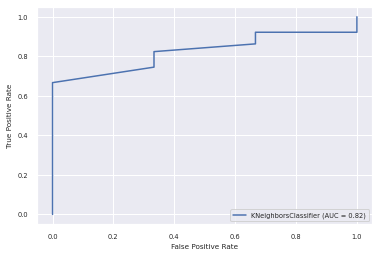

<function matplotlib.pyplot.show>

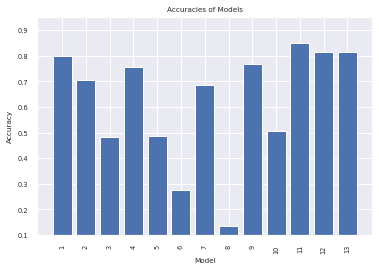

In [ ]:
Accuracy = []
clf = KNeighborsClassifier(n_neighbors=15)
sel = VarianceThreshold(threshold=(.2 * (1 - .8)))
for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    sel.fit_transform(train)
    sel.fit_transform(test)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### L1-based feature selection

This is the starting index: 0 of patient 0
0.44
[(1, 0, array([0.8, 0.2])), (1, 1, array([0.13333333, 0.86666667])), (1, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.6, 0.4])), (1, 0, array([0.66666667, 0.33333333])), (1, 0, array([0.66666667, 0.33333333])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.8, 0.2])), (1, 0, array([0.8, 0.2])), (1, 0, array([0.66666667, 0.33333333])), (0, 0, array([0.73333333, 0.26666667])), (1, 1, array([0.2, 0.8])), (0, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.6, 0.4])), (1, 0, array([0.73333333, 0.26666667])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.6, 0.4])), (1, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.46666667, 0.53333333])), (1, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.4, 0.6])), (1, 1, arra

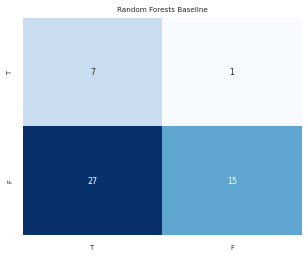

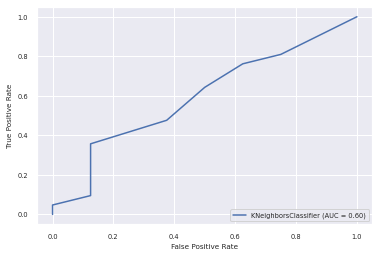

This is the starting index: 51 of patient 1
0.4444444444444444
[(0, 1, array([0.13333333, 0.86666667])), (0, 0, array([0.8, 0.2])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.13333333, 0.86666667])), (0, 0, array([0.8, 0.2])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.93333333, 0.06666667])), (0, 0, array([0.73333333, 0.26666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.6, 0.4])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, ar

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


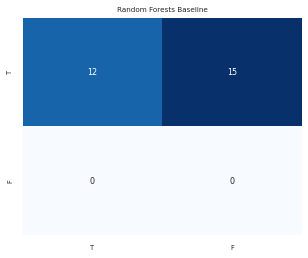

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


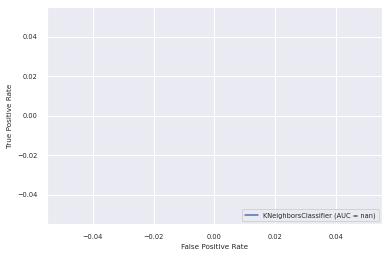

This is the starting index: 79 of patient 2
0.5
[(0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.2, 0.8])), (1, 1, array([0.46666667, 0.53333333])), (1, 0, array([0.6, 0.4])), (1, 0, array([0.66666667, 0.33333333])), (1, 1, array([0.2, 0.8])), (1, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.66666667, 0.33333333])), (1, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.13333333, 0.86666667])), (1, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.4, 0.6])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.66666667, 0.33333333])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.2, 0.8])), (1, 0, array([0.6, 0.4])), (1, 0, array([0.53333333, 0.46666667])), (1, 1, arr

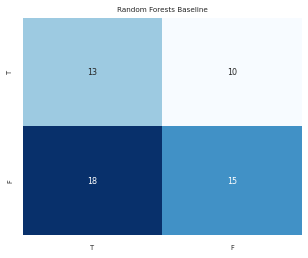

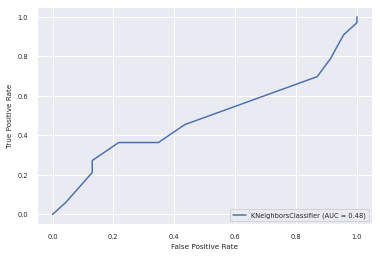

This is the starting index: 136 of patient 3
0.5405405405405406
[(1, 1, array([0.2, 0.8])), (1, 1, array([0.13333333, 0.86666667])), (1, 0, array([0.8, 0.2])), (1, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.73333333, 0.26666667])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.4, 0.6])), (0, 0, array([0.73333333, 0.26666667])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.4, 0.6])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.46666667, 0.53333333])), (1, 0, array([0.93333333, 0.06666667])), (0, 1, array([0.4, 0.6])), (1, 0, array([0.66666667, 0.33333333])), (0, 0, array([0.73333333, 0.26666667])), (1, 1, array([0.46666667, 0.53333333])), (0, 1, a

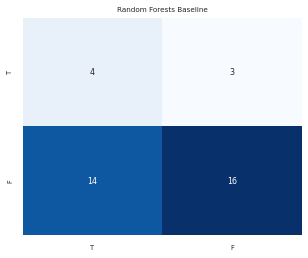

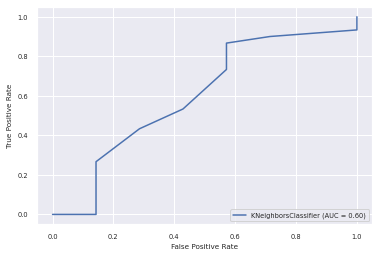

This is the starting index: 174 of patient 4
0.3783783783783784
[(0, 1, array([0.4, 0.6])), (0, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.13333333, 0.86666667])), (0, 0, array([0.73333333, 0.26666667])), (1, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.33333333, 0.66666667])), (1, 0, array([0.6, 0.4])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.66666667, 0.33333333])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.13333333, 0.86666667])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.2, 0.8])), (0, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.33333333, 0.66666667])), (1, 0, 

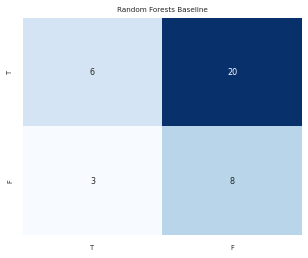

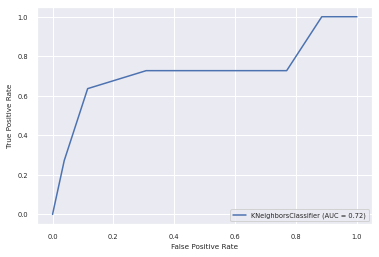

This is the starting index: 212 of patient 5
0.43137254901960786
[(1, 0, array([0.73333333, 0.26666667])), (1, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.2, 0.8])), (0, 1, array([0.2, 0.8])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.06666667, 0.93333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0., 1.])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.4, 0.6])), (0, 0, array([0.66666667, 0.33333333])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.13333333, 0.86666667])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.4, 0.6])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.6, 0.4])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.06666667, 0.93333333])), (0, 1, array([0.2, 0.8])), (0, 0, arr

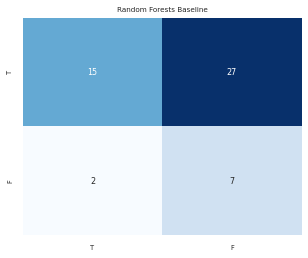

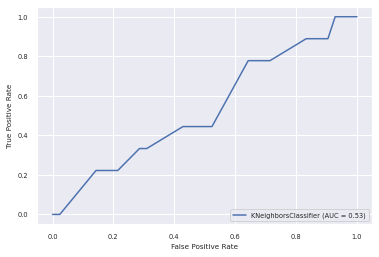

This is the starting index: 264 of patient 6
0.5789473684210527
[(0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.46666667, 0.53333333])), (1, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.2, 0.8])), (0, 0, array([0.66666667, 0.33333333])), (1, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.6, 0.4])), (1, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.66666667, 0.33333333])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.4, 0.6])), (0, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.2, 0.8])), (0, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.73333333, 0.26666667]))]


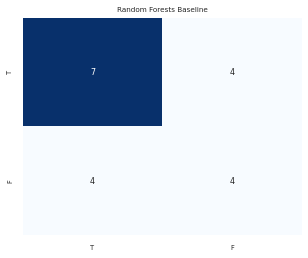

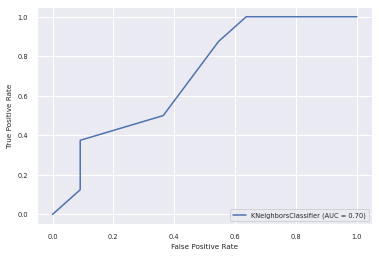

This is the starting index: 284 of patient 7
0.3333333333333333
[(0, 1, array([0.13333333, 0.86666667])), (0, 0, array([0.8, 0.2])), (0, 1, array([0.06666667, 0.93333333])), (0, 0, array([0.8, 0.2])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.2, 0.8])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.13333333, 0.86666667])), (0, 0, array([0.6, 0.4])), (1, 1, array([0., 1.])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.33333333, 0.66666667])), (0, 0, array([0.8, 0.2]))]


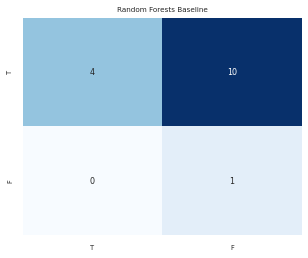

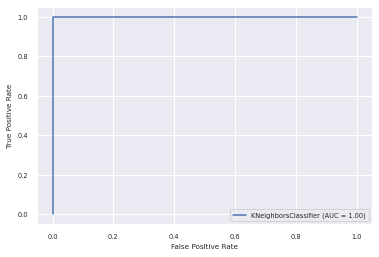

This is the starting index: 300 of patient 8
0.6046511627906976
[(0, 0, array([0.6, 0.4])), (0, 0, array([0.66666667, 0.33333333])), (0, 1, array([0.33333333, 0.66666667])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.4, 0.6])), (0, 0, array([0.73333333, 0.26666667])), (0, 1, array([0.33333333, 0.66666667])), (0, 0, array([0.86666667, 0.13333333])), (0, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.26666667, 0.73333333])), (0, 1, array([0.4, 0.6])), (0, 0, array([0.86666667, 0.13333333])), (0, 1, array([0.4, 0.6])), (0, 0, array([0.93333333, 0.06666667])), (1, 0, array([0.6, 0.4])), (0, 0, array([0.86666667, 0.13333333])), (1, 1, array([0.06666667, 0.93333333])), (1, 0, array([0.73333333, 0.26666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.06666667, 0.93333333])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.13333333, 0.86666667

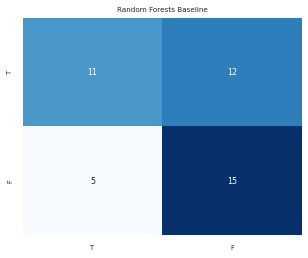

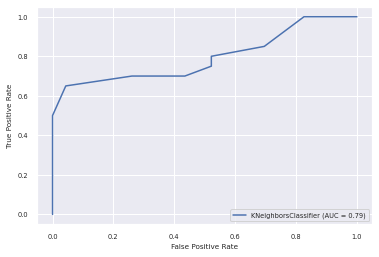

This is the starting index: 344 of patient 9
0.49206349206349204
[(1, 0, array([0.73333333, 0.26666667])), (1, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.4, 0.6])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.73333333, 0.26666667])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.33333333, 0.66666667])), (0, 0, array([0.93333333, 0.06666667])), (0, 0, array([0.66666667, 0.33333333])), (0, 1, array([0.26666667, 0.73333333])), (0, 0, array([0.53333333, 0.46666667])), (0, 1, array([0.13333333, 0.86666667])), (1, 0, array([0.73333333, 0.26666667])), (0, 1, array([0.13333333, 0.86666667])), (0, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.73333333, 0.26666667])), (0, 0, array([0.6, 0.4])), (1, 0, array([0.6, 0

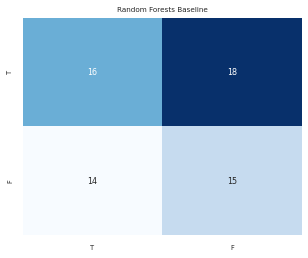

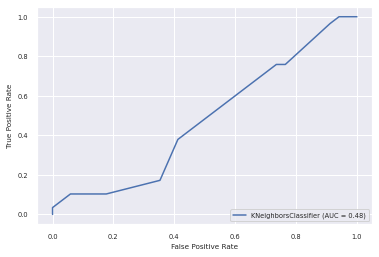

This is the starting index: 408 of patient 10
0.803030303030303
[(1, 1, array([0.4, 0.6])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.13333333, 0.86666667])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.33333333, 0.66666667])), (0, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.13333333, 0.86666667])), (1, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.2, 0.8])), (0, 0, array([0.93333333, 0.06666667])), (1, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.66666667, 0.33333333])), (0, 0, array([0.66666667, 0.33333333])), (1, 1, array([0.2, 0.8])), (0, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.53333333, 0.46666667])), (0, 0, array([0.86666667, 0.13333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.2, 0.8])), (0, 0, a

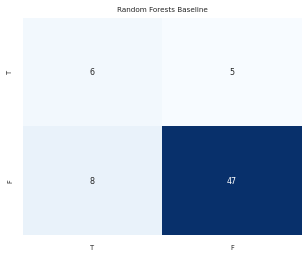

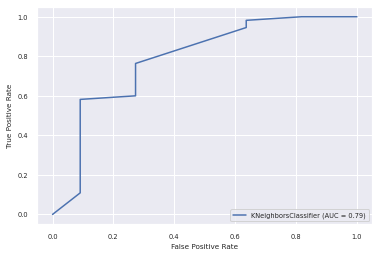

This is the starting index: 475 of patient 11
0.6666666666666666
[(0, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.33333333, 0.66666667])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.33333333, 0.66666667])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.33333333, 0.66666667])), (0, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.33333333, 0.66666667])), (1, 0, array([0.6, 0.4])), (1, 0, array([0.66666667, 0.33333333])), (1, 1, array([0.2666

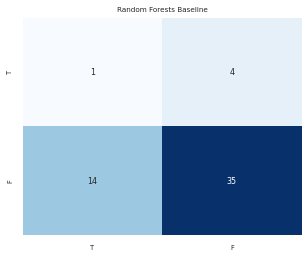

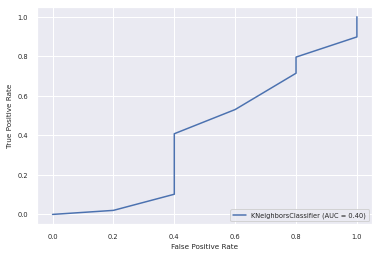

This is the starting index: 530 of patient 12
0.7222222222222222
[(1, 1, array([0.33333333, 0.66666667])), (1, 0, array([0.6, 0.4])), (1, 0, array([0.53333333, 0.46666667])), (1, 0, array([0.66666667, 0.33333333])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.4, 0.6])), (0, 1, array([0.46666667, 0.53333333])), (0, 1, array([0.4, 0.6])), (1, 0, array([0.93333333, 0.06666667])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.46666667, 0.53333333])), (1, 0, array([0.86666667, 0.13333333])), (1, 1, array([0.26666667, 0.73333333])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.46666667, 0.53333333])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.53333333, 0.46666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, array([0.33333333, 0.66666667])), (1, 1, 

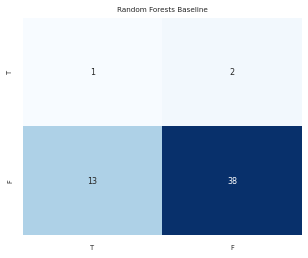

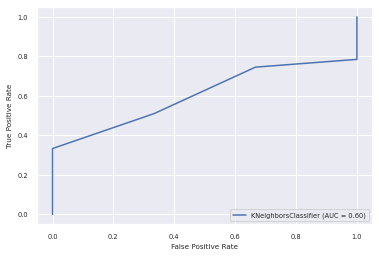

<function matplotlib.pyplot.show>

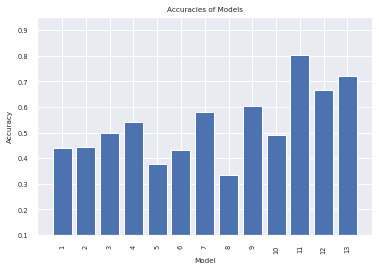

In [ ]:
Accuracy = []

clf = KNeighborsClassifier(n_neighbors=15)

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train, train_class.ravel())
    model = SelectFromModel(lsvc, prefit=True)
    train = model.transform(train)
    test = model.transform(test)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show


#### Tree Based Feature Selection

This is the starting index: 0 of patient 0
0.56
[(1, 0, array([0.72, 0.28])), (1, 1, array([0.11, 0.89])), (1, 1, array([0.32, 0.68])), (0, 1, array([0.38, 0.62])), (1, 0, array([0.59, 0.41])), (1, 0, array([0.5, 0.5])), (1, 1, array([0.31, 0.69])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.32, 0.68])), (0, 0, array([0.74, 0.26])), (1, 1, array([0.45, 0.55])), (1, 1, array([0.29, 0.71])), (0, 1, array([0.27, 0.73])), (1, 1, array([0.04, 0.96])), (0, 0, array([0.7, 0.3])), (1, 1, array([0.46, 0.54])), (1, 0, array([0.67, 0.33])), (1, 0, array([0.65, 0.35])), (1, 1, array([0.26, 0.74])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.27, 0.73])), (1, 1, array([0.13, 0.87])), (1, 1, array([0.31, 0.69])), (0, 1, array([0.45, 0.55])), (1, 1, array([0.37, 0.63])), (1, 1, array([0.27, 0.73])), (1, 1, array([0.2, 0.8])), (0, 1, array([0.07, 0.93])), (1, 1, array([0.49, 0.51])), (1, 1, array([0.34, 0.66])), (1, 0, array([0.69, 0.31])), (1, 1, array([0.27, 0.73])), (1, 1, array([0.47, 0.53])), (1

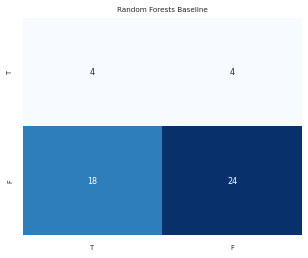

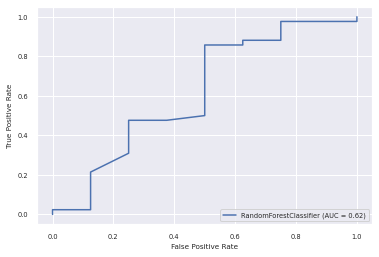

This is the starting index: 51 of patient 1
0.7777777777777778
[(0, 0, array([0.71, 0.29])), (0, 0, array([0.86, 0.14])), (0, 0, array([0.68, 0.32])), (0, 0, array([0.73, 0.27])), (0, 0, array([0.6, 0.4])), (0, 0, array([0.7, 0.3])), (0, 1, array([0.41, 0.59])), (0, 0, array([0.72, 0.28])), (0, 0, array([0.5, 0.5])), (0, 0, array([0.73, 0.27])), (0, 1, array([0.48, 0.52])), (0, 0, array([0.72, 0.28])), (0, 0, array([0.87, 0.13])), (0, 0, array([0.87, 0.13])), (0, 1, array([0.31, 0.69])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.84, 0.16])), (0, 0, array([0.85, 0.15])), (0, 0, array([0.66, 0.34])), (0, 0, array([0.84, 0.16])), (0, 0, array([0.77, 0.23])), (0, 0, array([0.87, 0.13])), (0, 0, array([0.64, 0.36])), (0, 0, array([0.56, 0.44])), (0, 1, array([0.37, 0.63])), (0, 1, array([0.34, 0.66])), (0, 1, array([0.47, 0.53]))]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


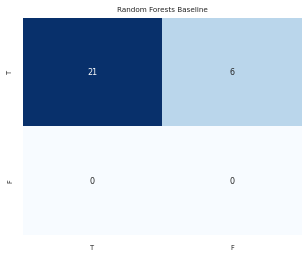

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


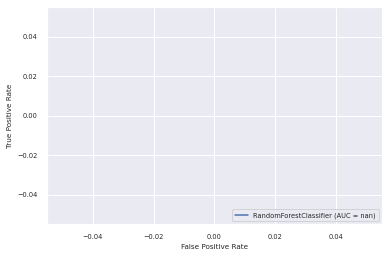

This is the starting index: 79 of patient 2
0.5714285714285714
[(0, 0, array([0.62, 0.38])), (0, 0, array([0.62, 0.38])), (1, 0, array([0.54, 0.46])), (0, 0, array([0.57, 0.43])), (1, 0, array([0.64, 0.36])), (1, 0, array([0.76, 0.24])), (1, 0, array([0.69, 0.31])), (1, 1, array([0.17, 0.83])), (1, 0, array([0.72, 0.28])), (1, 0, array([0.73, 0.27])), (1, 0, array([0.73, 0.27])), (0, 0, array([0.62, 0.38])), (1, 0, array([0.55, 0.45])), (0, 0, array([0.63, 0.37])), (0, 1, array([0.36, 0.64])), (1, 0, array([0.65, 0.35])), (0, 0, array([0.72, 0.28])), (0, 0, array([0.75, 0.25])), (0, 0, array([0.78, 0.22])), (0, 0, array([0.59, 0.41])), (0, 0, array([0.62, 0.38])), (0, 1, array([0.36, 0.64])), (0, 0, array([0.55, 0.45])), (1, 1, array([0.37, 0.63])), (1, 0, array([0.68, 0.32])), (1, 1, array([0.36, 0.64])), (1, 0, array([0.54, 0.46])), (0, 0, array([0.52, 0.48])), (1, 1, array([0.3, 0.7])), (1, 0, array([0.74, 0.26])), (1, 1, array([0.39, 0.61])), (1, 1, array([0.45, 0.55])), (1, 0, arr

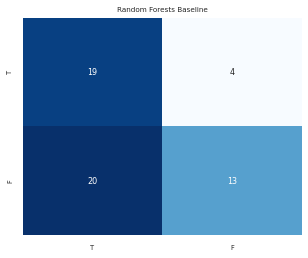

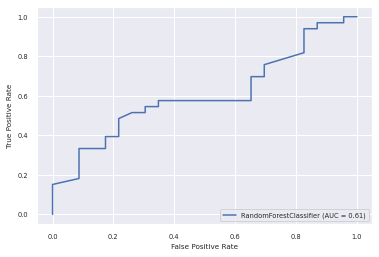

This is the starting index: 136 of patient 3
0.7027027027027027
[(1, 1, array([0.17, 0.83])), (1, 1, array([0.23, 0.77])), (1, 0, array([0.54, 0.46])), (1, 1, array([0.48, 0.52])), (1, 1, array([0.44, 0.56])), (1, 1, array([0.29, 0.71])), (1, 0, array([0.57, 0.43])), (1, 0, array([0.5, 0.5])), (0, 0, array([0.5, 0.5])), (1, 1, array([0.32, 0.68])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.66, 0.34])), (1, 1, array([0.15, 0.85])), (1, 1, array([0.43, 0.57])), (1, 1, array([0.46, 0.54])), (1, 1, array([0.48, 0.52])), (0, 1, array([0.28, 0.72])), (0, 0, array([0.65, 0.35])), (1, 1, array([0.28, 0.72])), (1, 1, array([0.2, 0.8])), (1, 0, array([0.8, 0.2])), (0, 1, array([0.42, 0.58])), (1, 1, array([0.49, 0.51])), (0, 1, array([0.39, 0.61])), (1, 0, array([0.55, 0.45])), (0, 1, array([0.46, 0.54])), (1, 1, array([0.48, 0.52])), (1, 1, array([0.28, 0.72])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.14, 0.86])), (1, 1, array([0.13, 0.87])), (1, 1, array([0.27, 0.73])), (1, 1, array([0.2

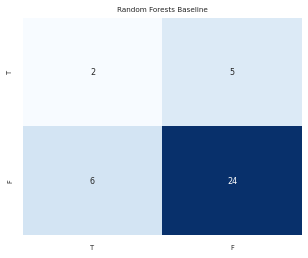

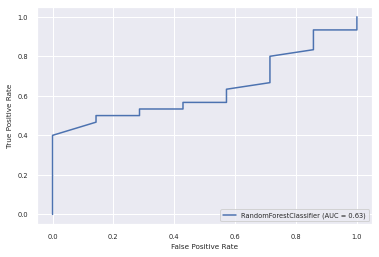

This is the starting index: 174 of patient 4
0.7297297297297297
[(0, 0, array([0.53, 0.47])), (0, 0, array([0.55, 0.45])), (1, 1, array([0.06, 0.94])), (0, 0, array([0.7, 0.3])), (1, 0, array([0.82, 0.18])), (0, 0, array([0.68, 0.32])), (1, 1, array([0.03, 0.97])), (0, 0, array([0.75, 0.25])), (1, 0, array([0.65, 0.35])), (0, 1, array([0.38, 0.62])), (0, 1, array([0.14, 0.86])), (0, 0, array([0.53, 0.47])), (0, 0, array([0.71, 0.29])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.48, 0.52])), (0, 0, array([0.55, 0.45])), (1, 1, array([0.12, 0.88])), (0, 1, array([0.2, 0.8])), (0, 0, array([0.63, 0.37])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.41, 0.59])), (0, 0, array([0.78, 0.22])), (1, 1, array([0.23, 0.77])), (0, 1, array([0.12, 0.88])), (1, 0, array([0.63, 0.37])), (1, 1, array([0.09, 0.91])), (0, 0, array([0.66, 0.34])), (0, 0, array([0.58, 0.42])), (1, 1, array([0.27, 0.73])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.13, 0.87])), (0, 1, array([0.37, 0.63])), (0, 0, array([0

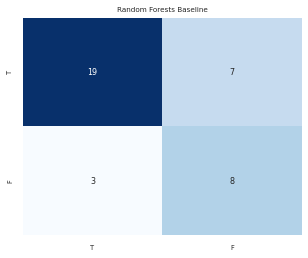

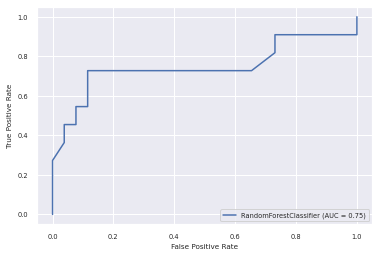

This is the starting index: 212 of patient 5
0.35294117647058826
[(1, 1, array([0.48, 0.52])), (1, 1, array([0.02, 0.98])), (0, 1, array([0.3, 0.7])), (0, 1, array([0.01, 0.99])), (0, 1, array([0.02, 0.98])), (0, 1, array([0.41, 0.59])), (0, 0, array([0.5, 0.5])), (0, 1, array([0.26, 0.74])), (0, 1, array([0.44, 0.56])), (0, 1, array([0.06, 0.94])), (0, 1, array([0.05, 0.95])), (0, 1, array([0.29, 0.71])), (0, 1, array([0.02, 0.98])), (0, 1, array([0.25, 0.75])), (0, 1, array([0.14, 0.86])), (0, 1, array([0.44, 0.56])), (0, 1, array([0.05, 0.95])), (0, 0, array([0.56, 0.44])), (0, 1, array([0.13, 0.87])), (0, 1, array([0.33, 0.67])), (0, 1, array([0.23, 0.77])), (0, 1, array([0.44, 0.56])), (0, 1, array([0.44, 0.56])), (0, 1, array([0.1, 0.9])), (0, 1, array([0.12, 0.88])), (0, 1, array([0.15, 0.85])), (0, 0, array([0.97, 0.03])), (0, 1, array([0., 1.])), (0, 0, array([0.5, 0.5])), (0, 1, array([0.32, 0.68])), (0, 1, array([0.06, 0.94])), (0, 1, array([0.05, 0.95])), (0, 1, array([0.29

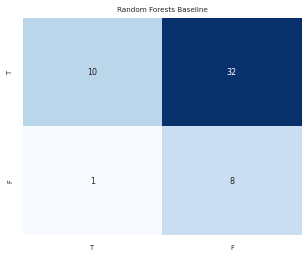

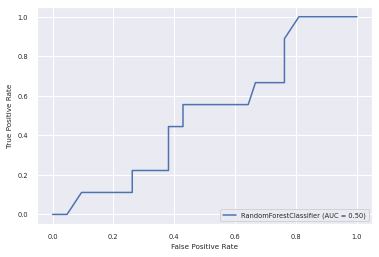

This is the starting index: 264 of patient 6
0.7368421052631579
[(0, 0, array([0.59, 0.41])), (0, 0, array([0.64, 0.36])), (1, 1, array([0.38, 0.62])), (0, 0, array([0.52, 0.48])), (0, 0, array([0.62, 0.38])), (1, 0, array([0.68, 0.32])), (0, 1, array([0.45, 0.55])), (0, 0, array([0.51, 0.49])), (1, 1, array([0.45, 0.55])), (0, 1, array([0.48, 0.52])), (1, 1, array([0.4, 0.6])), (0, 1, array([0.49, 0.51])), (1, 1, array([0.44, 0.56])), (1, 1, array([0.21, 0.79])), (0, 1, array([0.44, 0.56])), (1, 1, array([0.28, 0.72])), (1, 1, array([0.28, 0.72])), (0, 0, array([0.68, 0.32])), (0, 0, array([0.59, 0.41]))]


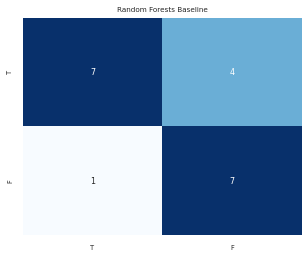

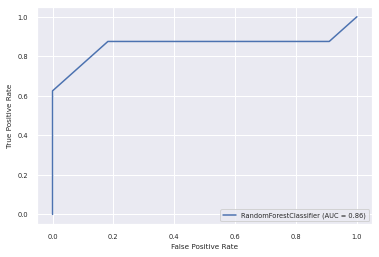

This is the starting index: 284 of patient 7
0.6
[(0, 1, array([0.35, 0.65])), (0, 0, array([0.52, 0.48])), (0, 0, array([0.53, 0.47])), (0, 0, array([0.64, 0.36])), (0, 0, array([0.62, 0.38])), (0, 1, array([0.29, 0.71])), (0, 1, array([0.36, 0.64])), (0, 1, array([0.47, 0.53])), (0, 1, array([0.04, 0.96])), (0, 1, array([0.42, 0.58])), (1, 1, array([0.09, 0.91])), (0, 0, array([0.54, 0.46])), (0, 0, array([0.67, 0.33])), (0, 0, array([0.71, 0.29])), (0, 0, array([0.54, 0.46]))]


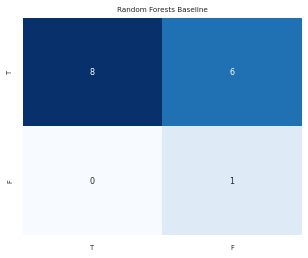

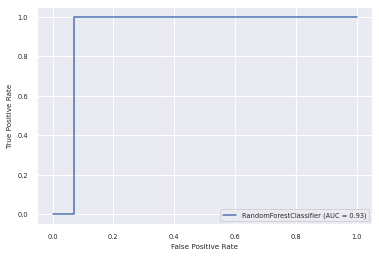

This is the starting index: 300 of patient 8
0.7906976744186046
[(0, 0, array([0.57, 0.43])), (0, 0, array([0.76, 0.24])), (0, 0, array([0.77, 0.23])), (0, 1, array([0.33, 0.67])), (0, 1, array([0.27, 0.73])), (0, 0, array([0.79, 0.21])), (0, 1, array([0.31, 0.69])), (0, 0, array([0.9, 0.1])), (0, 0, array([0.57, 0.43])), (0, 0, array([0.59, 0.41])), (0, 1, array([0.45, 0.55])), (0, 0, array([0.9, 0.1])), (0, 0, array([0.72, 0.28])), (0, 0, array([0.78, 0.22])), (1, 1, array([0.26, 0.74])), (0, 1, array([0.44, 0.56])), (1, 1, array([0.01, 0.99])), (1, 1, array([0.1, 0.9])), (0, 0, array([0.65, 0.35])), (0, 0, array([0.65, 0.35])), (1, 1, array([0., 1.])), (0, 0, array([0.53, 0.47])), (1, 1, array([0.38, 0.62])), (1, 1, array([0.21, 0.79])), (1, 1, array([0.08, 0.92])), (1, 1, array([0., 1.])), (1, 1, array([0.1, 0.9])), (1, 1, array([0.03, 0.97])), (0, 1, array([0.29, 0.71])), (1, 1, array([0.48, 0.52])), (1, 1, array([0.38, 0.62])), (1, 1, array([0.01, 0.99])), (1, 1, array([0.24, 0.7

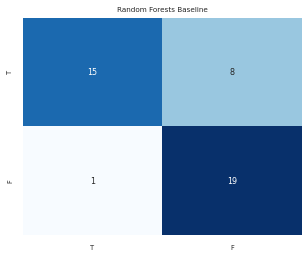

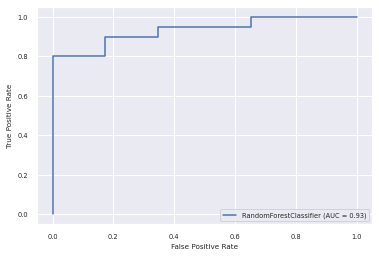

This is the starting index: 344 of patient 9
0.6031746031746031
[(1, 0, array([0.87, 0.13])), (1, 0, array([0.87, 0.13])), (0, 0, array([0.62, 0.38])), (1, 0, array([0.54, 0.46])), (1, 1, array([0.41, 0.59])), (1, 0, array([0.5, 0.5])), (1, 0, array([0.54, 0.46])), (0, 0, array([0.6, 0.4])), (0, 1, array([0.49, 0.51])), (0, 0, array([0.62, 0.38])), (0, 1, array([0.43, 0.57])), (0, 1, array([0.47, 0.53])), (0, 0, array([0.94, 0.06])), (0, 0, array([0.74, 0.26])), (0, 0, array([0.56, 0.44])), (0, 0, array([0.57, 0.43])), (0, 0, array([0.69, 0.31])), (1, 0, array([0.65, 0.35])), (0, 0, array([0.65, 0.35])), (0, 0, array([0.7, 0.3])), (1, 0, array([0.75, 0.25])), (1, 0, array([0.63, 0.37])), (0, 0, array([0.56, 0.44])), (0, 0, array([0.75, 0.25])), (1, 0, array([0.61, 0.39])), (0, 0, array([0.7, 0.3])), (1, 1, array([0.4, 0.6])), (0, 0, array([0.74, 0.26])), (1, 1, array([0.47, 0.53])), (1, 0, array([0.66, 0.34])), (0, 0, array([0.52, 0.48])), (1, 1, array([0.34, 0.66])), (1, 0, array([0.6

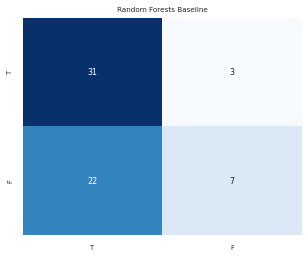

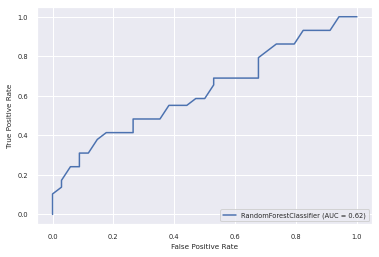

This is the starting index: 408 of patient 10
0.8333333333333334
[(1, 1, array([0.34, 0.66])), (1, 1, array([0.22, 0.78])), (1, 1, array([0.3, 0.7])), (1, 1, array([0.22, 0.78])), (1, 1, array([0.27, 0.73])), (1, 1, array([0.27, 0.73])), (1, 1, array([0.01, 0.99])), (1, 1, array([0.49, 0.51])), (1, 1, array([0.24, 0.76])), (0, 1, array([0.43, 0.57])), (0, 0, array([0.57, 0.43])), (1, 1, array([0.28, 0.72])), (1, 1, array([0.33, 0.67])), (1, 1, array([0.05, 0.95])), (1, 1, array([0.17, 0.83])), (0, 0, array([0.71, 0.29])), (1, 0, array([0.65, 0.35])), (1, 0, array([0.6, 0.4])), (0, 0, array([0.5, 0.5])), (1, 1, array([0.15, 0.85])), (0, 1, array([0.29, 0.71])), (1, 0, array([0.71, 0.29])), (0, 0, array([0.75, 0.25])), (1, 1, array([0.38, 0.62])), (1, 1, array([0.26, 0.74])), (0, 0, array([0.69, 0.31])), (1, 1, array([0.42, 0.58])), (1, 1, array([0.25, 0.75])), (1, 1, array([0.17, 0.83])), (1, 0, array([0.63, 0.37])), (1, 1, array([0.26, 0.74])), (1, 1, array([0.44, 0.56])), (1, 1, array

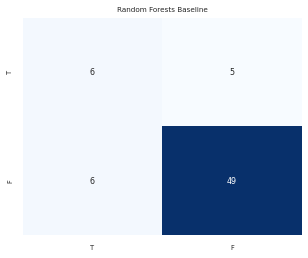

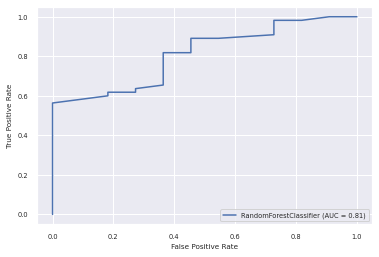

This is the starting index: 475 of patient 11
0.7592592592592593
[(0, 0, array([0.9, 0.1])), (1, 0, array([0.54, 0.46])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.36, 0.64])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.18, 0.82])), (1, 0, array([0.63, 0.37])), (1, 1, array([0.19, 0.81])), (1, 1, array([0.18, 0.82])), (1, 1, array([0.21, 0.79])), (1, 1, array([0.21, 0.79])), (0, 0, array([0.59, 0.41])), (1, 1, array([0.22, 0.78])), (1, 1, array([0.28, 0.72])), (1, 1, array([0.18, 0.82])), (1, 0, array([0.7, 0.3])), (1, 1, array([0.34, 0.66])), (1, 1, array([0.49, 0.51])), (1, 1, array([0.27, 0.73])), (1, 1, array([0.2, 0.8])), (1, 0, array([0.8, 0.2])), (1, 0, array([0.52, 0.48])), (1, 1, array([0.16, 0.84])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.32, 0.68])), (0, 0, array([0.53, 0.47])), (1, 0, array([0.58, 0.42])), (1, 1, array([0.43, 0.57])), (0, 1, array([0.49, 0.51])), (1, 1, array([0.29, 0.71])), (1, 1, array([0.43, 0.57])), (1, 1, array([0.49, 0.51])), (1, 1, array([0.2, 0

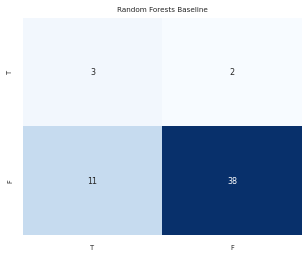

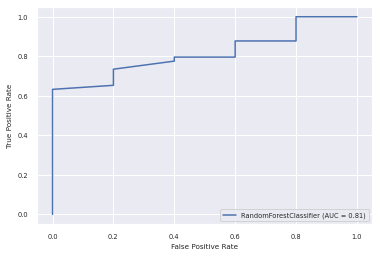

This is the starting index: 530 of patient 12
0.6851851851851852
[(1, 1, array([0.35, 0.65])), (1, 0, array([0.77, 0.23])), (1, 0, array([0.65, 0.35])), (1, 0, array([0.54, 0.46])), (1, 0, array([0.73, 0.27])), (1, 0, array([0.52, 0.48])), (1, 1, array([0.13, 0.87])), (0, 0, array([0.73, 0.27])), (0, 0, array([0.72, 0.28])), (1, 0, array([0.95, 0.05])), (1, 1, array([0.1, 0.9])), (1, 1, array([0.26, 0.74])), (1, 0, array([0.96, 0.04])), (1, 1, array([0.14, 0.86])), (1, 1, array([0.11, 0.89])), (1, 0, array([0.5, 0.5])), (1, 1, array([0.13, 0.87])), (1, 1, array([0.11, 0.89])), (1, 1, array([0.19, 0.81])), (1, 0, array([0.65, 0.35])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.08, 0.92])), (1, 0, array([0.68, 0.32])), (1, 1, array([0.12, 0.88])), (1, 0, array([0.66, 0.34])), (1, 1, array([0.22, 0.78])), (1, 1, array([0.04, 0.96])), (1, 0, array([0.73, 0.27])), (1, 1, array([0.23, 0.77])), (1, 1, array([0.22, 0.78])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.38, 0.62])), (1, 1, array

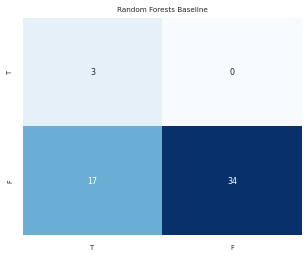

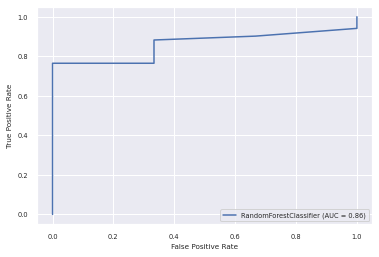

<function matplotlib.pyplot.show>

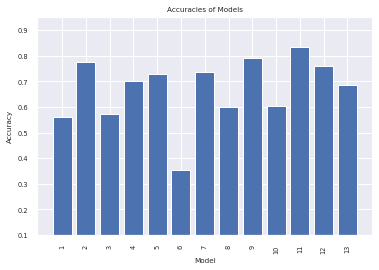

In [ ]:
Accuracy = []

clf = KNeighborsClassifier(n_neighbors=15)

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(train, train_class.ravel())
    model = SelectFromModel(clf, prefit=True)
    train = model.transform(train)
    # clf = ExtraTreesClassifier(n_estimators=50)
    # clf = clf.fit(test, test_class.ravel())
    # model = SelectFromModel(clf, prefit=True) 

    test = model.transform(test)
    clf = RandomForestClassifier()
    clf.fit(train, train_class.ravel())


    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### Auto Sklearn Recommendation

In [ ]:
#SVM with manual parameters
svm = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                         ('svm', SGDClassifier(loss='hinge', alpha=1e-3, random_state=42)),])

SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'extra_trees_preproc_for_classification', 'classifier:random_forest:bootstrap': 'False', 'classifier:random_forest:criterion': 'entropy', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.27453376891983117, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 13, 'classifier:random_forest:min_samples_split': 19, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.2166847947584762, 'feature_preprocessor:extra_trees_preproc_for_classification:bootstrap': 'False', 'feature_preprocessor:extra_trees_preproc_for_classification:criterion': 'entropy', 'feature_preprocessor:extra_trees_preproc_for_classification:max_depth': 'None', 'feature_preprocessor:extra_trees_preproc_for_classification:max_features': 0.2819773130241576, 'feature_preprocessor:extra_trees_preproc_for_classification:max_leaf_nodes': 'None', 'feature_preprocessor:extra_trees_preproc_for_classification:min_impurity_decrease': 0.0, 'feature_preprocessor:extra_trees_preproc_for_classification:min_samples_leaf': 20, 'feature_preprocessor:extra_trees_preproc_for_classification:min_samples_split': 3, 'feature_preprocessor:extra_trees_preproc_for_classification:min_weight_fraction_leaf': 0.0, 'feature_preprocessor:extra_trees_preproc_for_classification:n_estimators': 100},
d

### AdaBoost

#### Baseline

This is the starting index: 0 of patient 0
0.7
[(1, 1, array([0.48557695, 0.51442305])), (1, 1, array([0.45494048, 0.54505952])), (1, 1, array([0.49582993, 0.50417007])), (0, 0, array([0.51348651, 0.48651349])), (1, 0, array([0.50712825, 0.49287175])), (1, 1, array([0.48353689, 0.51646311])), (1, 1, array([0.47437441, 0.52562559])), (1, 1, array([0.48065798, 0.51934202])), (1, 0, array([0.51928049, 0.48071951])), (0, 0, array([0.50384889, 0.49615111])), (1, 0, array([0.66895295, 0.33104705])), (1, 1, array([0.491325, 0.508675])), (0, 0, array([0.50406205, 0.49593795])), (1, 1, array([0.45064705, 0.54935295])), (0, 0, array([0.50909786, 0.49090214])), (1, 1, array([0.4848738, 0.5151262])), (1, 0, array([0.52100877, 0.47899123])), (1, 1, array([0.4832527, 0.5167473])), (1, 1, array([0.46041118, 0.53958882])), (1, 1, array([0.49052981, 0.50947019])), (1, 1, array([0.45720535, 0.54279465])), (1, 1, array([0.46721581, 0.53278419])), (1, 1, array([0.45529795, 0.54470205])), (0, 0, array([0.5

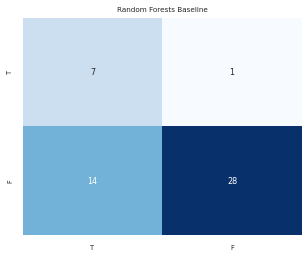

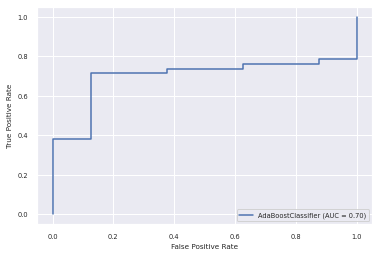

This is the starting index: 51 of patient 1
0.7037037037037037
[(0, 0, array([0.50319745, 0.49680255])), (0, 0, array([0.68443767, 0.31556233])), (0, 1, array([0.49979223, 0.50020777])), (0, 0, array([0.51268473, 0.48731527])), (0, 1, array([0.48771629, 0.51228371])), (0, 0, array([0.50647354, 0.49352646])), (0, 1, array([0.4938206, 0.5061794])), (0, 0, array([0.68651196, 0.31348804])), (0, 0, array([0.52819725, 0.47180275])), (0, 1, array([0.48821446, 0.51178554])), (0, 0, array([0.50740938, 0.49259062])), (0, 0, array([0.50131573, 0.49868427])), (0, 0, array([0.67002517, 0.32997483])), (0, 0, array([0.50983428, 0.49016572])), (0, 1, array([0.49957675, 0.50042325])), (0, 0, array([0.52154256, 0.47845744])), (0, 0, array([0.50487137, 0.49512863])), (0, 0, array([0.52549702, 0.47450298])), (0, 0, array([0.66549726, 0.33450274])), (0, 0, array([0.52885462, 0.47114538])), (0, 0, array([0.52242569, 0.47757431])), (0, 0, array([0.67401396, 0.32598604])), (0, 0, array([0.50503598, 0.49496402

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


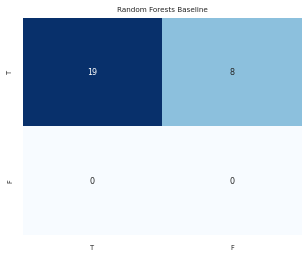

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


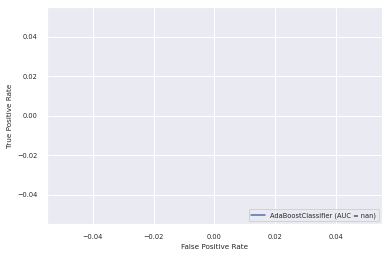

This is the starting index: 79 of patient 2
0.5178571428571429
[(0, 0, array([0.52947126, 0.47052874])), (0, 0, array([0.5072232, 0.4927768])), (1, 1, array([0.48478312, 0.51521688])), (0, 1, array([0.49892065, 0.50107935])), (1, 0, array([0.50691177, 0.49308823])), (1, 0, array([0.527474, 0.472526])), (1, 0, array([0.51676788, 0.48323212])), (1, 1, array([0.46931358, 0.53068642])), (1, 0, array([0.51589814, 0.48410186])), (1, 0, array([0.50920039, 0.49079961])), (1, 0, array([0.52200446, 0.47799554])), (0, 0, array([0.51566495, 0.48433505])), (1, 1, array([0.49006212, 0.50993788])), (0, 0, array([0.50860197, 0.49139803])), (0, 0, array([0.50379552, 0.49620448])), (1, 1, array([0.49365611, 0.50634389])), (0, 0, array([0.52290556, 0.47709444])), (0, 0, array([0.50904054, 0.49095946])), (0, 0, array([0.67018017, 0.32981983])), (0, 0, array([0.50261943, 0.49738057])), (0, 0, array([0.51555005, 0.48444995])), (0, 1, array([0.48367928, 0.51632072])), (0, 1, array([0.48200216, 0.51799784])),

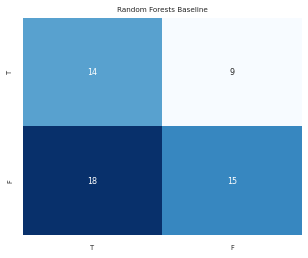

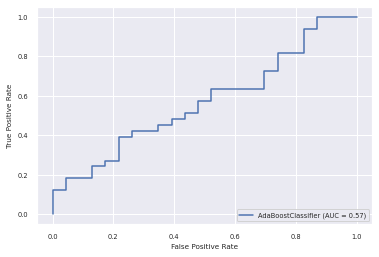

This is the starting index: 136 of patient 3
0.6756756756756757
[(1, 1, array([0.30000847, 0.69999153])), (1, 1, array([0.308619, 0.691381])), (1, 1, array([0.33268068, 0.66731932])), (1, 1, array([0.31809513, 0.68190487])), (1, 0, array([0.50513009, 0.49486991])), (1, 1, array([0.32891842, 0.67108158])), (1, 1, array([0.49805741, 0.50194259])), (1, 0, array([0.51879872, 0.48120128])), (0, 1, array([0.30772742, 0.69227258])), (1, 1, array([0.32833856, 0.67166144])), (1, 1, array([0.49705073, 0.50294927])), (1, 0, array([0.51726013, 0.48273987])), (1, 1, array([0.30724601, 0.69275399])), (1, 0, array([0.5154347, 0.4845653])), (1, 1, array([0.31857086, 0.68142914])), (1, 1, array([0.48241592, 0.51758408])), (0, 1, array([0.46277919, 0.53722081])), (0, 0, array([0.52348004, 0.47651996])), (1, 1, array([0.49322656, 0.50677344])), (1, 1, array([0.30445667, 0.69554333])), (1, 1, array([0.49632043, 0.50367957])), (0, 1, array([0.31092912, 0.68907088])), (1, 1, array([0.49138368, 0.50861632]))

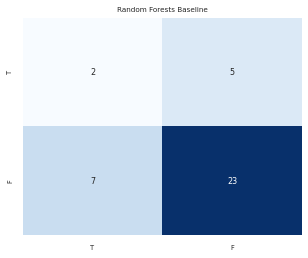

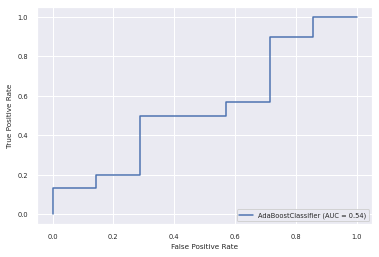

This is the starting index: 174 of patient 4
0.5945945945945946
[(0, 1, array([0.48131518, 0.51868482])), (0, 1, array([0.49398174, 0.50601826])), (1, 1, array([0.44768462, 0.55231538])), (0, 0, array([0.5146393, 0.4853607])), (1, 0, array([0.52071024, 0.47928976])), (0, 0, array([0.51158389, 0.48841611])), (1, 1, array([0.44783492, 0.55216508])), (0, 0, array([0.51914544, 0.48085456])), (1, 0, array([0.50467647, 0.49532353])), (0, 1, array([0.47279872, 0.52720128])), (0, 1, array([0.47615918, 0.52384082])), (0, 0, array([0.518081, 0.481919])), (0, 0, array([0.51144991, 0.48855009])), (0, 0, array([0.50738891, 0.49261109])), (0, 0, array([0.52237214, 0.47762786])), (0, 1, array([0.49573964, 0.50426036])), (1, 1, array([0.47762709, 0.52237291])), (0, 1, array([0.48633117, 0.51366883])), (0, 0, array([0.50923919, 0.49076081])), (0, 0, array([0.50708122, 0.49291878])), (0, 1, array([0.49400961, 0.50599039])), (0, 0, array([0.50776695, 0.49223305])), (1, 1, array([0.46303878, 0.53696122]))

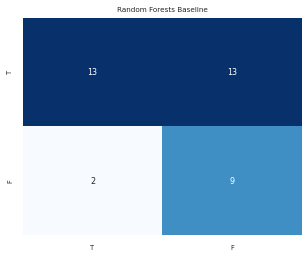

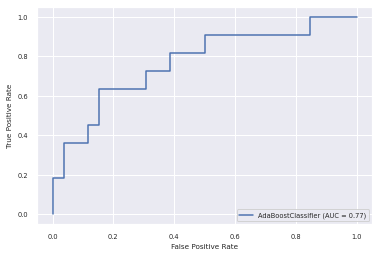

This is the starting index: 212 of patient 5
0.27450980392156865
[(1, 0, array([0.50587588, 0.49412412])), (1, 1, array([0.47410064, 0.52589936])), (0, 1, array([0.49277917, 0.50722083])), (0, 1, array([0.45261095, 0.54738905])), (0, 1, array([0.46806482, 0.53193518])), (0, 0, array([0.50330331, 0.49669669])), (0, 0, array([0.50129103, 0.49870897])), (0, 0, array([0.5037927, 0.4962073])), (0, 1, array([0.49044508, 0.50955492])), (0, 1, array([0.47422262, 0.52577738])), (0, 1, array([0.47256468, 0.52743532])), (0, 1, array([0.48686455, 0.51313545])), (0, 1, array([0.47937162, 0.52062838])), (0, 1, array([0.4893573, 0.5106427])), (0, 1, array([0.46515673, 0.53484327])), (0, 1, array([0.48766418, 0.51233582])), (0, 1, array([0.47577501, 0.52422499])), (0, 1, array([0.49855954, 0.50144046])), (0, 1, array([0.48762456, 0.51237544])), (0, 1, array([0.49827929, 0.50172071])), (0, 1, array([0.48820525, 0.51179475])), (0, 1, array([0.47777018, 0.52222982])), (0, 1, array([0.48876061, 0.51123939

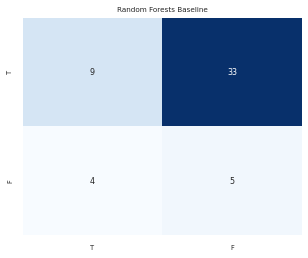

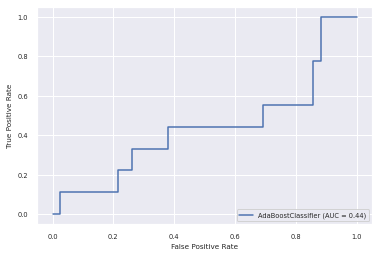

This is the starting index: 264 of patient 6
0.7368421052631579
[(0, 0, array([0.51802119, 0.48197881])), (0, 0, array([0.51335565, 0.48664435])), (1, 1, array([0.47841981, 0.52158019])), (0, 1, array([0.4993959, 0.5006041])), (0, 0, array([0.50170883, 0.49829117])), (1, 0, array([0.50930013, 0.49069987])), (0, 0, array([0.50028356, 0.49971644])), (0, 0, array([0.50308626, 0.49691374])), (1, 1, array([0.47857255, 0.52142745])), (0, 0, array([0.50851321, 0.49148679])), (1, 0, array([0.51095862, 0.48904138])), (0, 1, array([0.49338344, 0.50661656])), (1, 1, array([0.49864441, 0.50135559])), (1, 1, array([0.48161597, 0.51838403])), (0, 1, array([0.4904496, 0.5095504])), (1, 1, array([0.48681186, 0.51318814])), (1, 1, array([0.486144, 0.513856])), (0, 0, array([0.52799642, 0.47200358])), (0, 0, array([0.51137893, 0.48862107]))]


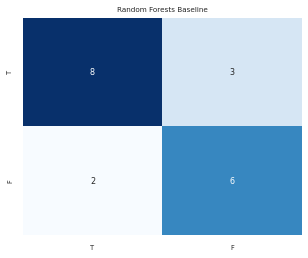

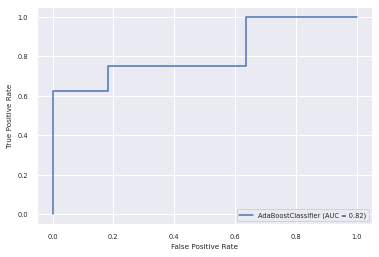

This is the starting index: 284 of patient 7
0.6666666666666666
[(0, 0, array([0.50635519, 0.49364481])), (0, 0, array([0.51524651, 0.48475349])), (0, 1, array([0.34639091, 0.65360909])), (0, 0, array([0.52509791, 0.47490209])), (0, 0, array([0.51616528, 0.48383472])), (0, 1, array([0.49101763, 0.50898237])), (0, 0, array([0.50336938, 0.49663062])), (0, 0, array([0.50576276, 0.49423724])), (0, 1, array([0.47585616, 0.52414384])), (0, 1, array([0.48243648, 0.51756352])), (1, 1, array([0.46898992, 0.53101008])), (0, 1, array([0.49774596, 0.50225404])), (0, 0, array([0.50189694, 0.49810306])), (0, 0, array([0.52578187, 0.47421813])), (0, 0, array([0.54092061, 0.45907939]))]


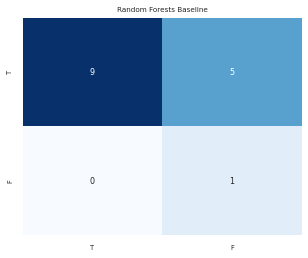

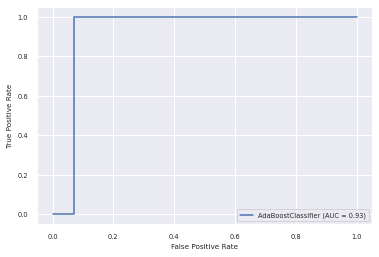

This is the starting index: 300 of patient 8
0.6744186046511628
[(0, 1, array([0.49392376, 0.50607624])), (0, 0, array([0.50472306, 0.49527694])), (0, 0, array([0.50977865, 0.49022135])), (0, 1, array([0.48165587, 0.51834413])), (0, 1, array([0.49451005, 0.50548995])), (0, 0, array([0.51869354, 0.48130646])), (0, 0, array([0.5214875, 0.4785125])), (0, 0, array([0.52352446, 0.47647554])), (0, 0, array([0.50602035, 0.49397965])), (0, 0, array([0.5090606, 0.4909394])), (0, 1, array([0.47086317, 0.52913683])), (0, 0, array([0.5052433, 0.4947567])), (0, 0, array([0.51180973, 0.48819027])), (0, 0, array([0.52111902, 0.47888098])), (1, 0, array([0.50076098, 0.49923902])), (0, 1, array([0.48901938, 0.51098062])), (1, 1, array([0.4735524, 0.5264476])), (1, 1, array([0.48610423, 0.51389577])), (0, 0, array([0.50895539, 0.49104461])), (0, 0, array([0.52434748, 0.47565252])), (1, 1, array([0.47223856, 0.52776144])), (0, 1, array([0.49945759, 0.50054241])), (1, 0, array([0.50258185, 0.49741815])), 

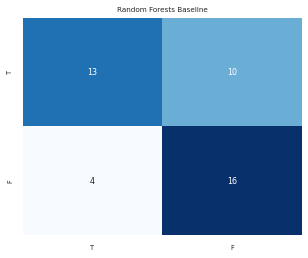

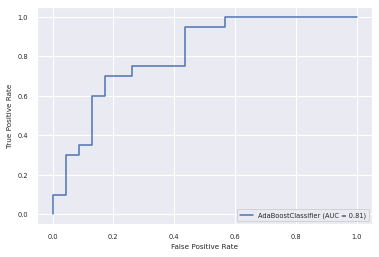

This is the starting index: 344 of patient 9
0.6031746031746031
[(1, 0, array([0.50855197, 0.49144803])), (1, 0, array([0.51491153, 0.48508847])), (0, 0, array([0.50693655, 0.49306345])), (1, 1, array([0.48606924, 0.51393076])), (1, 1, array([0.49467054, 0.50532946])), (1, 1, array([0.49313025, 0.50686975])), (1, 1, array([0.49272361, 0.50727639])), (0, 0, array([0.50857121, 0.49142879])), (0, 0, array([0.50153861, 0.49846139])), (0, 0, array([0.50856067, 0.49143933])), (0, 1, array([0.48868975, 0.51131025])), (0, 1, array([0.49549266, 0.50450734])), (0, 0, array([0.52824719, 0.47175281])), (0, 0, array([0.53151766, 0.46848234])), (0, 0, array([0.50964104, 0.49035896])), (0, 0, array([0.68379751, 0.31620249])), (0, 0, array([0.51379654, 0.48620346])), (1, 1, array([0.49666149, 0.50333851])), (0, 0, array([0.51593385, 0.48406615])), (0, 0, array([0.51652888, 0.48347112])), (1, 0, array([0.51262822, 0.48737178])), (1, 0, array([0.50404162, 0.49595838])), (0, 1, array([0.4723174, 0.527682

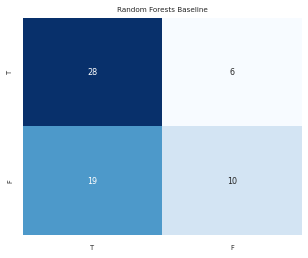

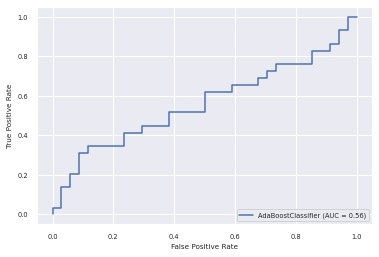

This is the starting index: 408 of patient 10
0.7727272727272727
[(1, 1, array([0.48727676, 0.51272324])), (1, 1, array([0.49098032, 0.50901968])), (1, 1, array([0.4951041, 0.5048959])), (1, 1, array([0.48805282, 0.51194718])), (1, 1, array([0.49402611, 0.50597389])), (1, 1, array([0.49655976, 0.50344024])), (1, 1, array([0.46255167, 0.53744833])), (1, 1, array([0.49743567, 0.50256433])), (1, 1, array([0.49495243, 0.50504757])), (0, 0, array([0.50403071, 0.49596929])), (0, 0, array([0.50635742, 0.49364258])), (1, 0, array([0.50268436, 0.49731564])), (1, 0, array([0.50219653, 0.49780347])), (1, 1, array([0.46255167, 0.53744833])), (1, 1, array([0.49400854, 0.50599146])), (0, 1, array([0.4973634, 0.5026366])), (1, 1, array([0.49687832, 0.50312168])), (1, 0, array([0.50700598, 0.49299402])), (0, 1, array([0.48735456, 0.51264544])), (1, 1, array([0.4686665, 0.5313335])), (0, 1, array([0.49530311, 0.50469689])), (1, 0, array([0.50888407, 0.49111593])), (0, 0, array([0.5357124, 0.4642876])),

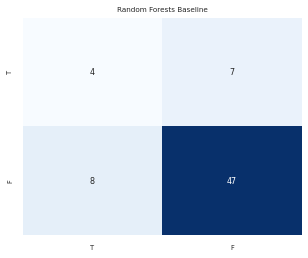

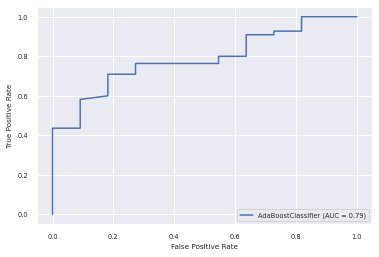

This is the starting index: 475 of patient 11
0.6851851851851852
[(0, 0, array([0.53235654, 0.46764346])), (1, 1, array([0.49353605, 0.50646395])), (1, 1, array([0.45857533, 0.54142467])), (1, 1, array([0.47313354, 0.52686646])), (0, 0, array([0.51354865, 0.48645135])), (1, 1, array([0.48431752, 0.51568248])), (1, 0, array([0.52506816, 0.47493184])), (1, 1, array([0.49231959, 0.50768041])), (1, 1, array([0.46450466, 0.53549534])), (1, 1, array([0.47422087, 0.52577913])), (1, 1, array([0.49694726, 0.50305274])), (0, 0, array([0.50404323, 0.49595677])), (1, 0, array([0.5137494, 0.4862506])), (1, 1, array([0.49782993, 0.50217007])), (1, 0, array([0.50112811, 0.49887189])), (1, 1, array([0.49675686, 0.50324314])), (1, 0, array([0.50031232, 0.49968768])), (1, 0, array([0.50482086, 0.49517914])), (1, 1, array([0.48119174, 0.51880826])), (1, 1, array([0.48264576, 0.51735424])), (1, 1, array([0.49918679, 0.50081321])), (1, 0, array([0.51847292, 0.48152708])), (1, 1, array([0.48309797, 0.516902

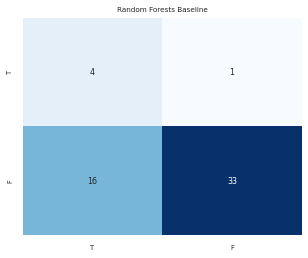

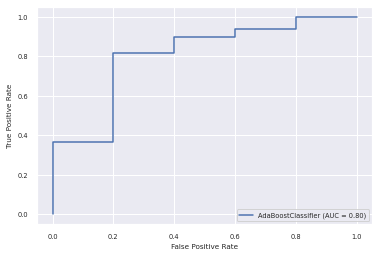

This is the starting index: 530 of patient 12
0.7777777777777778
[(1, 1, array([0.49633546, 0.50366454])), (1, 0, array([0.50491021, 0.49508979])), (1, 0, array([0.50365557, 0.49634443])), (1, 1, array([0.49676899, 0.50323101])), (1, 0, array([0.51697896, 0.48302104])), (1, 1, array([0.49564411, 0.50435589])), (1, 1, array([0.47741392, 0.52258608])), (0, 0, array([0.51425776, 0.48574224])), (0, 0, array([0.5112068, 0.4887932])), (1, 0, array([0.5364879, 0.4635121])), (1, 1, array([0.49216708, 0.50783292])), (1, 1, array([0.49980332, 0.50019668])), (1, 0, array([0.51837496, 0.48162504])), (1, 1, array([0.48608454, 0.51391546])), (1, 1, array([0.48863436, 0.51136564])), (1, 1, array([0.49499604, 0.50500396])), (1, 0, array([0.5081752, 0.4918248])), (1, 1, array([0.4704787, 0.5295213])), (1, 1, array([0.45719927, 0.54280073])), (1, 1, array([0.48993538, 0.51006462])), (1, 1, array([0.48714923, 0.51285077])), (1, 1, array([0.4661508, 0.5338492])), (1, 0, array([0.50537128, 0.49462872])), (

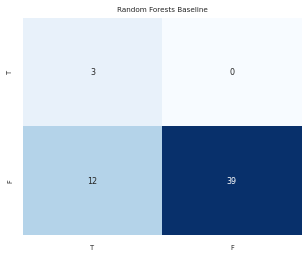

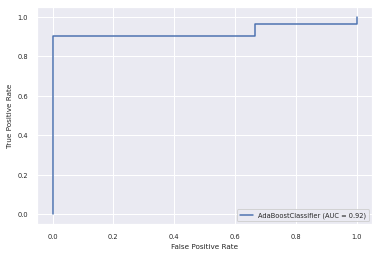

<function matplotlib.pyplot.show>

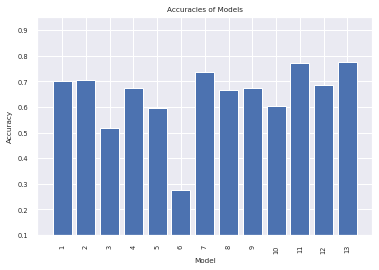

In [ ]:
Accuracy = []

clf = AdaBoostClassifier()

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result) 
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### GridSearch

In [9]:
parameters = {
    'n_estimators'      : [50,150,250],
    'learning_rate'         : [0.4, 0.8, 1.0],
    'random_state'      : [0],
    #'max_features': ['auto'],
    #'criterion' :['gini']
}


for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    search = GridSearchCV(AdaBoostClassifier(), parameters, cv=10, n_jobs=-1)
    search.fit(train, train_class.ravel())

    print(search.score(test, test_class.ravel()))
    print(search.best_params_)

This is the starting index: 0 of patient 0
0.64
{'learning_rate': 0.4, 'n_estimators': 50, 'random_state': 0}
This is the starting index: 51 of patient 1
0.7407407407407407
{'learning_rate': 1.0, 'n_estimators': 150, 'random_state': 0}
This is the starting index: 79 of patient 2
0.48214285714285715
{'learning_rate': 0.8, 'n_estimators': 50, 'random_state': 0}
This is the starting index: 136 of patient 3
0.6756756756756757
{'learning_rate': 1.0, 'n_estimators': 50, 'random_state': 0}
This is the starting index: 174 of patient 4
0.6216216216216216
{'learning_rate': 0.8, 'n_estimators': 250, 'random_state': 0}
This is the starting index: 212 of patient 5
0.3137254901960784
{'learning_rate': 0.8, 'n_estimators': 50, 'random_state': 0}
This is the starting index: 264 of patient 6
0.7894736842105263
{'learning_rate': 0.4, 'n_estimators': 50, 'random_state': 0}
This is the starting index: 284 of patient 7
0.4666666666666667
{'learning_rate': 0.4, 'n_estimators': 50, 'random_state': 0}
This is

This is the starting index: 0 of patient 0
0.64
[(1, 1, array([0.47993412, 0.52006588])), (1, 1, array([0.43828139, 0.56171861])), (1, 1, array([0.49969257, 0.50030743])), (0, 1, array([0.49683799, 0.50316201])), (1, 0, array([0.51094517, 0.48905483])), (1, 1, array([0.47935524, 0.52064476])), (1, 1, array([0.47692167, 0.52307833])), (1, 1, array([0.48301218, 0.51698782])), (1, 0, array([0.50811806, 0.49188194])), (0, 0, array([0.50580477, 0.49419523])), (1, 0, array([0.65835807, 0.34164193])), (1, 1, array([0.49322119, 0.50677881])), (0, 1, array([0.49304488, 0.50695512])), (1, 1, array([0.43008664, 0.56991336])), (0, 0, array([0.54481698, 0.45518302])), (1, 1, array([0.45857808, 0.54142192])), (1, 0, array([0.52254083, 0.47745917])), (1, 1, array([0.48822175, 0.51177825])), (1, 1, array([0.43644283, 0.56355717])), (1, 1, array([0.48720347, 0.51279653])), (1, 1, array([0.44702775, 0.55297225])), (1, 1, array([0.45193939, 0.54806061])), (1, 1, array([0.44469925, 0.55530075])), (0, 0, a

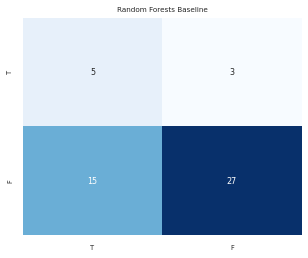

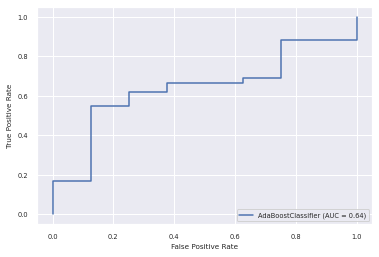

This is the starting index: 51 of patient 1
0.6666666666666666
[(0, 0, array([0.51132291, 0.48867709])), (0, 0, array([0.68726289, 0.31273711])), (0, 1, array([0.49712386, 0.50287614])), (0, 0, array([0.52222183, 0.47777817])), (0, 1, array([0.48444897, 0.51555103])), (0, 0, array([0.52217624, 0.47782376])), (0, 1, array([0.49864743, 0.50135257])), (0, 0, array([0.69959812, 0.30040188])), (0, 0, array([0.51955059, 0.48044941])), (0, 1, array([0.49387204, 0.50612796])), (0, 1, array([0.49330778, 0.50669222])), (0, 0, array([0.50788009, 0.49211991])), (0, 0, array([0.68986969, 0.31013031])), (0, 0, array([0.54710514, 0.45289486])), (0, 1, array([0.49857139, 0.50142861])), (0, 0, array([0.54054295, 0.45945705])), (0, 0, array([0.52431613, 0.47568387])), (0, 0, array([0.54478568, 0.45521432])), (0, 0, array([0.66768311, 0.33231689])), (0, 0, array([0.53956491, 0.46043509])), (0, 0, array([0.52568021, 0.47431979])), (0, 0, array([0.69381117, 0.30618883])), (0, 0, array([0.5044065, 0.4955935

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


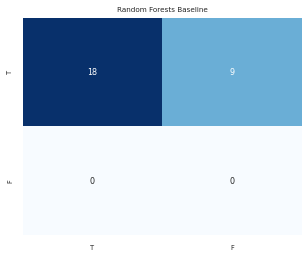

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


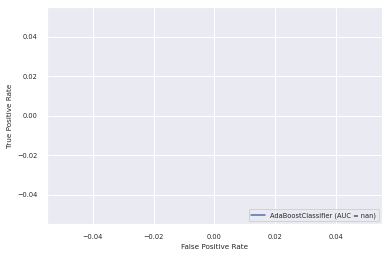

This is the starting index: 79 of patient 2
0.5357142857142857
[(0, 0, array([0.53486507, 0.46513493])), (0, 0, array([0.507637, 0.492363])), (1, 0, array([0.50002521, 0.49997479])), (0, 1, array([0.47613937, 0.52386063])), (1, 0, array([0.51603028, 0.48396972])), (1, 0, array([0.51367147, 0.48632853])), (1, 0, array([0.50969028, 0.49030972])), (1, 1, array([0.43816781, 0.56183219])), (1, 0, array([0.51679152, 0.48320848])), (1, 0, array([0.51351536, 0.48648464])), (1, 0, array([0.51707614, 0.48292386])), (0, 0, array([0.51892059, 0.48107941])), (1, 1, array([0.48226181, 0.51773819])), (0, 0, array([0.50219042, 0.49780958])), (0, 1, array([0.4699655, 0.5300345])), (1, 1, array([0.48822205, 0.51177795])), (0, 0, array([0.53170032, 0.46829968])), (0, 0, array([0.53213267, 0.46786733])), (0, 0, array([0.68767757, 0.31232243])), (0, 0, array([0.50416369, 0.49583631])), (0, 0, array([0.53399598, 0.46600402])), (0, 1, array([0.46463732, 0.53536268])), (0, 1, array([0.47995004, 0.52004996])),

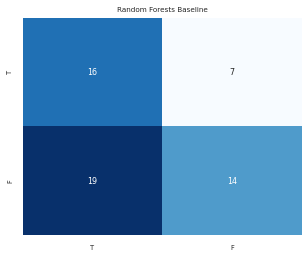

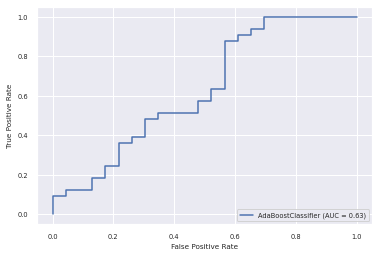

This is the starting index: 136 of patient 3
0.7027027027027027
[(1, 1, array([0.27905601, 0.72094399])), (1, 1, array([0.2967294, 0.7032706])), (1, 1, array([0.34032435, 0.65967565])), (1, 1, array([0.32146894, 0.67853106])), (1, 0, array([0.50798127, 0.49201873])), (1, 1, array([0.32327786, 0.67672214])), (1, 0, array([0.5050624, 0.4949376])), (1, 1, array([0.49119497, 0.50880503])), (0, 1, array([0.31040512, 0.68959488])), (1, 1, array([0.30649555, 0.69350445])), (1, 1, array([0.45450358, 0.54549642])), (1, 0, array([0.50418209, 0.49581791])), (1, 1, array([0.29906847, 0.70093153])), (1, 0, array([0.50698485, 0.49301515])), (1, 1, array([0.3068492, 0.6931508])), (1, 0, array([0.51388605, 0.48611395])), (0, 1, array([0.46385124, 0.53614876])), (0, 0, array([0.53205731, 0.46794269])), (1, 1, array([0.49470126, 0.50529874])), (1, 1, array([0.30583825, 0.69416175])), (1, 0, array([0.50652389, 0.49347611])), (0, 1, array([0.3155868, 0.6844132])), (1, 1, array([0.47253962, 0.52746038])), 

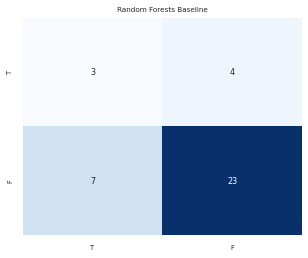

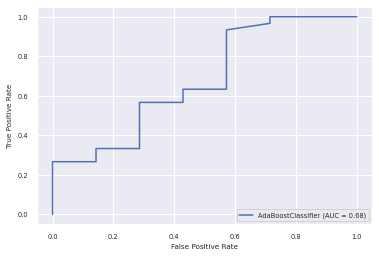

This is the starting index: 174 of patient 4
0.6486486486486487
[(0, 1, array([0.49384358, 0.50615642])), (0, 1, array([0.48783648, 0.51216352])), (1, 1, array([0.41938973, 0.58061027])), (0, 0, array([0.51417938, 0.48582062])), (1, 0, array([0.52434882, 0.47565118])), (0, 0, array([0.52352585, 0.47647415])), (1, 1, array([0.4257788, 0.5742212])), (0, 0, array([0.51929598, 0.48070402])), (1, 1, array([0.49559314, 0.50440686])), (0, 0, array([0.50126204, 0.49873796])), (0, 1, array([0.47601781, 0.52398219])), (0, 0, array([0.51041258, 0.48958742])), (0, 0, array([0.52763528, 0.47236472])), (0, 1, array([0.49932168, 0.50067832])), (0, 0, array([0.51112873, 0.48887127])), (0, 1, array([0.48622025, 0.51377975])), (1, 1, array([0.44805577, 0.55194423])), (0, 1, array([0.49384413, 0.50615587])), (0, 0, array([0.5114021, 0.4885979])), (0, 0, array([0.5282892, 0.4717108])), (0, 1, array([0.49290922, 0.50709078])), (0, 0, array([0.51802306, 0.48197694])), (1, 1, array([0.45196403, 0.54803597]))

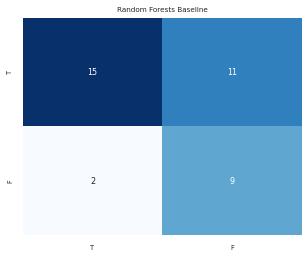

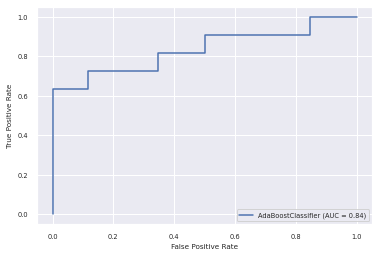

This is the starting index: 212 of patient 5
0.37254901960784315
[(1, 1, array([0.49898729, 0.50101271])), (1, 1, array([0.29208496, 0.70791504])), (0, 1, array([0.49581215, 0.50418785])), (0, 1, array([0.27971632, 0.72028368])), (0, 1, array([0.45808821, 0.54191179])), (0, 1, array([0.47154882, 0.52845118])), (0, 1, array([0.49134236, 0.50865764])), (0, 1, array([0.49514683, 0.50485317])), (0, 0, array([0.50096767, 0.49903233])), (0, 1, array([0.30067422, 0.69932578])), (0, 1, array([0.30843201, 0.69156799])), (0, 1, array([0.48626927, 0.51373073])), (0, 1, array([0.29175041, 0.70824959])), (0, 0, array([0.51036735, 0.48963265])), (0, 1, array([0.45800783, 0.54199217])), (0, 1, array([0.49268111, 0.50731889])), (0, 1, array([0.4513521, 0.5486479])), (0, 0, array([0.52419281, 0.47580719])), (0, 1, array([0.30896401, 0.69103599])), (0, 1, array([0.4912545, 0.5087455])), (0, 1, array([0.4913374, 0.5086626])), (0, 0, array([0.5074307, 0.4925693])), (0, 1, array([0.48704568, 0.51295432])),

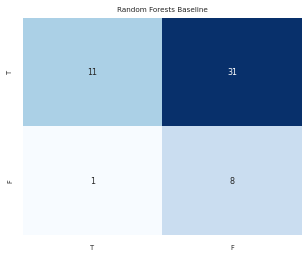

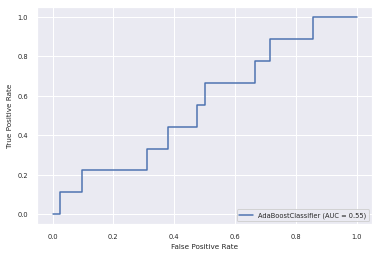

This is the starting index: 264 of patient 6
0.7894736842105263
[(0, 1, array([0.49909999, 0.50090001])), (0, 0, array([0.50850111, 0.49149889])), (1, 1, array([0.49472049, 0.50527951])), (0, 0, array([0.50006323, 0.49993677])), (0, 1, array([0.49801575, 0.50198425])), (1, 0, array([0.50950044, 0.49049956])), (0, 0, array([0.50834331, 0.49165669])), (0, 0, array([0.65850082, 0.34149918])), (1, 1, array([0.48194373, 0.51805627])), (0, 0, array([0.51044071, 0.48955929])), (1, 1, array([0.48671876, 0.51328124])), (0, 0, array([0.51073973, 0.48926027])), (1, 1, array([0.49166315, 0.50833685])), (1, 1, array([0.48378252, 0.51621748])), (0, 1, array([0.44544057, 0.55455943])), (1, 1, array([0.47512074, 0.52487926])), (1, 1, array([0.48069948, 0.51930052])), (0, 0, array([0.51201799, 0.48798201])), (0, 0, array([0.50232981, 0.49767019]))]


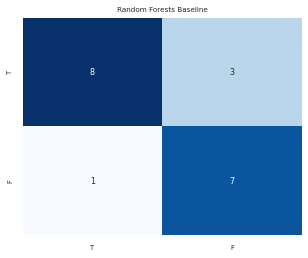

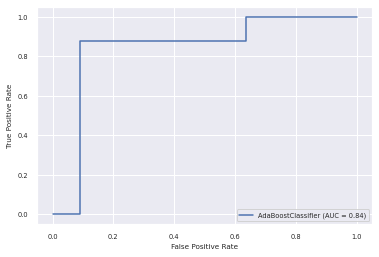

This is the starting index: 284 of patient 7
0.4666666666666667
[(0, 1, array([0.49562639, 0.50437361])), (0, 0, array([0.52366286, 0.47633714])), (0, 1, array([0.47722393, 0.52277607])), (0, 1, array([0.49746798, 0.50253202])), (0, 0, array([0.51391903, 0.48608097])), (0, 1, array([0.48877885, 0.51122115])), (0, 1, array([0.45833084, 0.54166916])), (0, 0, array([0.5072641, 0.4927359])), (0, 1, array([0.46237002, 0.53762998])), (0, 1, array([0.45687893, 0.54312107])), (1, 1, array([0.45131995, 0.54868005])), (0, 1, array([0.42932971, 0.57067029])), (0, 0, array([0.64452991, 0.35547009])), (0, 0, array([0.53680536, 0.46319464])), (0, 0, array([0.50713927, 0.49286073]))]


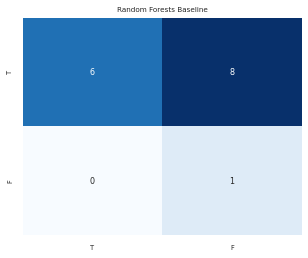

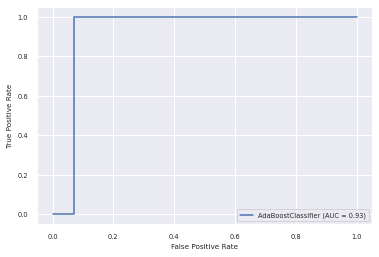

This is the starting index: 300 of patient 8
0.813953488372093
[(0, 0, array([0.51722864, 0.48277136])), (0, 0, array([0.51575535, 0.48424465])), (0, 0, array([0.51581161, 0.48418839])), (0, 1, array([0.48026465, 0.51973535])), (0, 1, array([0.48930957, 0.51069043])), (0, 0, array([0.51318591, 0.48681409])), (0, 1, array([0.49556248, 0.50443752])), (0, 0, array([0.67676932, 0.32323068])), (0, 0, array([0.50559573, 0.49440427])), (0, 0, array([0.50967306, 0.49032694])), (0, 1, array([0.48754252, 0.51245748])), (0, 0, array([0.68397163, 0.31602837])), (0, 0, array([0.51116235, 0.48883765])), (0, 0, array([0.53580334, 0.46419666])), (1, 1, array([0.48824065, 0.51175935])), (0, 1, array([0.49854984, 0.50145016])), (1, 1, array([0.45095968, 0.54904032])), (1, 1, array([0.47827785, 0.52172215])), (0, 0, array([0.5032094, 0.4967906])), (0, 0, array([0.52265932, 0.47734068])), (1, 1, array([0.45559698, 0.54440302])), (0, 1, array([0.49368348, 0.50631652])), (1, 1, array([0.48591862, 0.51408138

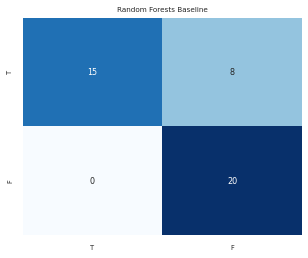

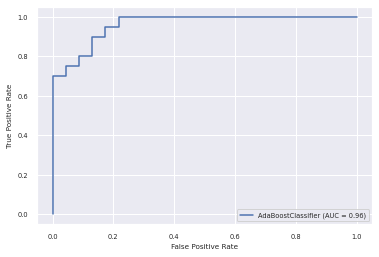

This is the starting index: 344 of patient 9
0.5873015873015873
[(1, 0, array([0.69089393, 0.30910607])), (1, 0, array([0.50427788, 0.49572212])), (0, 0, array([0.50463262, 0.49536738])), (1, 1, array([0.48770287, 0.51229713])), (1, 1, array([0.48004332, 0.51995668])), (1, 1, array([0.49749605, 0.50250395])), (1, 1, array([0.49619207, 0.50380793])), (0, 0, array([0.52316176, 0.47683824])), (0, 1, array([0.49226057, 0.50773943])), (0, 0, array([0.51418191, 0.48581809])), (0, 1, array([0.49065949, 0.50934051])), (0, 0, array([0.50188723, 0.49811277])), (0, 0, array([0.55848171, 0.44151829])), (0, 0, array([0.54430091, 0.45569909])), (0, 1, array([0.48220392, 0.51779608])), (0, 0, array([0.674445, 0.325555])), (0, 1, array([0.49638706, 0.50361294])), (1, 0, array([0.51402471, 0.48597529])), (0, 0, array([0.51576426, 0.48423574])), (0, 1, array([0.49444616, 0.50555384])), (1, 0, array([0.50362202, 0.49637798])), (1, 0, array([0.52034281, 0.47965719])), (0, 1, array([0.48314047, 0.51685953]

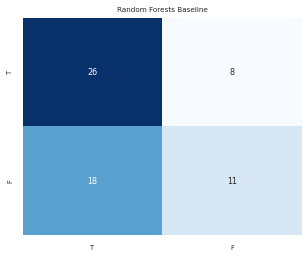

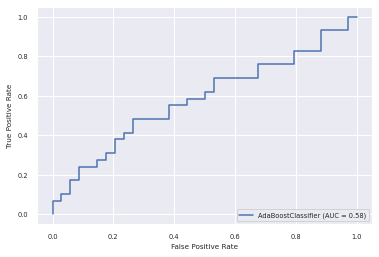

This is the starting index: 408 of patient 10
0.8333333333333334
[(1, 1, array([0.46566891, 0.53433109])), (1, 1, array([0.49238612, 0.50761388])), (1, 1, array([0.48286029, 0.51713971])), (1, 1, array([0.48459773, 0.51540227])), (1, 1, array([0.47904018, 0.52095982])), (1, 1, array([0.47573769, 0.52426231])), (1, 1, array([0.43634142, 0.56365858])), (1, 1, array([0.48759567, 0.51240433])), (1, 1, array([0.47136836, 0.52863164])), (0, 1, array([0.49121304, 0.50878696])), (0, 1, array([0.49233248, 0.50766752])), (1, 1, array([0.48839262, 0.51160738])), (1, 1, array([0.49530732, 0.50469268])), (1, 1, array([0.4281439, 0.5718561])), (1, 1, array([0.47549435, 0.52450565])), (0, 0, array([0.66680653, 0.33319347])), (1, 1, array([0.49267073, 0.50732927])), (1, 1, array([0.48959648, 0.51040352])), (0, 1, array([0.47340345, 0.52659655])), (1, 1, array([0.44092318, 0.55907682])), (0, 1, array([0.4801446, 0.5198554])), (1, 0, array([0.51879484, 0.48120516])), (0, 0, array([0.67365999, 0.32634001

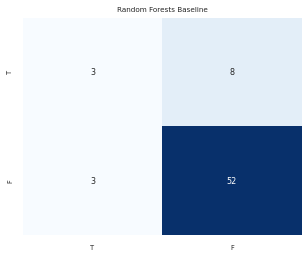

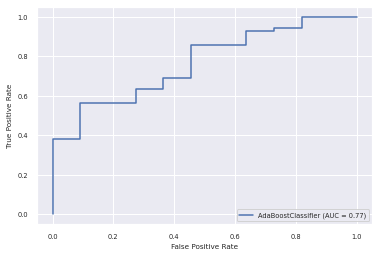

This is the starting index: 475 of patient 11
0.8333333333333334
[(0, 0, array([0.53758318, 0.46241682])), (1, 1, array([0.49590689, 0.50409311])), (1, 1, array([0.45283911, 0.54716089])), (1, 1, array([0.45693978, 0.54306022])), (0, 0, array([0.50216222, 0.49783778])), (1, 1, array([0.47800173, 0.52199827])), (1, 0, array([0.5066039, 0.4933961])), (1, 1, array([0.48919907, 0.51080093])), (1, 1, array([0.47221692, 0.52778308])), (1, 1, array([0.45596694, 0.54403306])), (1, 1, array([0.4779896, 0.5220104])), (0, 0, array([0.50211499, 0.49788501])), (1, 1, array([0.49087126, 0.50912874])), (1, 1, array([0.48837894, 0.51162106])), (1, 1, array([0.48904537, 0.51095463])), (1, 0, array([0.50045502, 0.49954498])), (1, 1, array([0.4865419, 0.5134581])), (1, 1, array([0.49595232, 0.50404768])), (1, 1, array([0.47590888, 0.52409112])), (1, 1, array([0.45921016, 0.54078984])), (1, 1, array([0.49618119, 0.50381881])), (1, 1, array([0.49628739, 0.50371261])), (1, 1, array([0.46442276, 0.53557724])

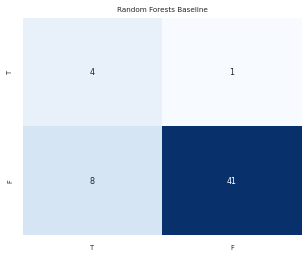

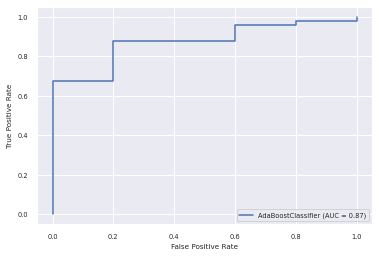

This is the starting index: 530 of patient 12
0.7407407407407407
[(1, 0, array([0.50559759, 0.49440241])), (1, 0, array([0.50077475, 0.49922525])), (1, 0, array([0.50141356, 0.49858644])), (1, 0, array([0.50631481, 0.49368519])), (1, 0, array([0.53169931, 0.46830069])), (1, 0, array([0.50540132, 0.49459868])), (1, 1, array([0.46651644, 0.53348356])), (0, 0, array([0.70717171, 0.29282829])), (0, 0, array([0.5194694, 0.4805306])), (1, 0, array([0.5412904, 0.4587096])), (1, 1, array([0.47607418, 0.52392582])), (1, 1, array([0.47812055, 0.52187945])), (1, 0, array([0.50102339, 0.49897661])), (1, 1, array([0.47454371, 0.52545629])), (1, 1, array([0.46651644, 0.53348356])), (1, 0, array([0.51076588, 0.48923412])), (1, 1, array([0.48299585, 0.51700415])), (1, 1, array([0.44435406, 0.55564594])), (1, 1, array([0.46255416, 0.53744584])), (1, 1, array([0.47681592, 0.52318408])), (1, 1, array([0.47929173, 0.52070827])), (1, 1, array([0.46289941, 0.53710059])), (1, 0, array([0.50885548, 0.49114452

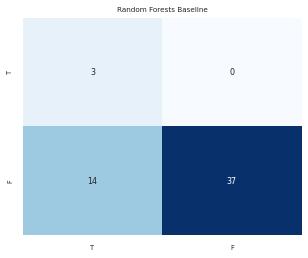

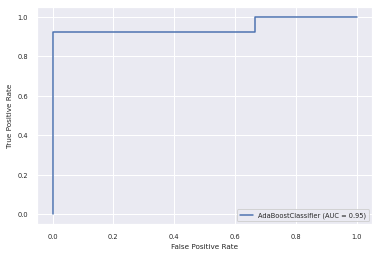

<function matplotlib.pyplot.show>

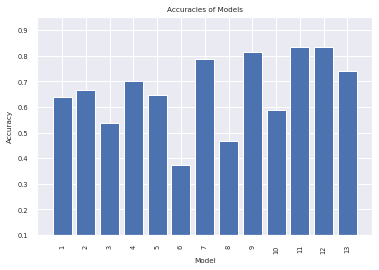

In [12]:
Accuracy = []
clf = AdaBoostClassifier(learning_rate= 0.4, n_estimators= 50, random_state= 0)

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### Low Variance

This is the starting index: 0 of patient 0
0.7
[(1, 1, array([0.48557695, 0.51442305])), (1, 1, array([0.45494048, 0.54505952])), (1, 1, array([0.49582993, 0.50417007])), (0, 0, array([0.51348651, 0.48651349])), (1, 0, array([0.50712825, 0.49287175])), (1, 1, array([0.48353689, 0.51646311])), (1, 1, array([0.47437441, 0.52562559])), (1, 1, array([0.48065798, 0.51934202])), (1, 0, array([0.51928049, 0.48071951])), (0, 0, array([0.50384889, 0.49615111])), (1, 0, array([0.66895295, 0.33104705])), (1, 1, array([0.491325, 0.508675])), (0, 0, array([0.50406205, 0.49593795])), (1, 1, array([0.45064705, 0.54935295])), (0, 0, array([0.50909786, 0.49090214])), (1, 1, array([0.4848738, 0.5151262])), (1, 0, array([0.52100877, 0.47899123])), (1, 1, array([0.4832527, 0.5167473])), (1, 1, array([0.46041118, 0.53958882])), (1, 1, array([0.49052981, 0.50947019])), (1, 1, array([0.45720535, 0.54279465])), (1, 1, array([0.46721581, 0.53278419])), (1, 1, array([0.45529795, 0.54470205])), (0, 0, array([0.5

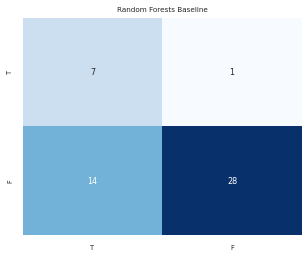

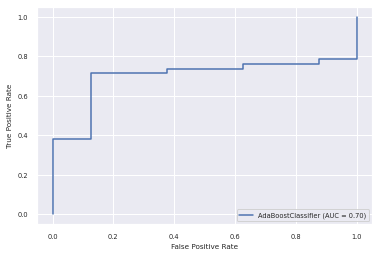

This is the starting index: 51 of patient 1
0.7037037037037037
[(0, 0, array([0.50319745, 0.49680255])), (0, 0, array([0.68443767, 0.31556233])), (0, 1, array([0.49979223, 0.50020777])), (0, 0, array([0.51268473, 0.48731527])), (0, 1, array([0.48771629, 0.51228371])), (0, 0, array([0.50647354, 0.49352646])), (0, 1, array([0.4938206, 0.5061794])), (0, 0, array([0.68651196, 0.31348804])), (0, 0, array([0.52819725, 0.47180275])), (0, 1, array([0.48821446, 0.51178554])), (0, 0, array([0.50740938, 0.49259062])), (0, 0, array([0.50131573, 0.49868427])), (0, 0, array([0.67002517, 0.32997483])), (0, 0, array([0.50983428, 0.49016572])), (0, 1, array([0.49957675, 0.50042325])), (0, 0, array([0.52154256, 0.47845744])), (0, 0, array([0.50487137, 0.49512863])), (0, 0, array([0.52549702, 0.47450298])), (0, 0, array([0.66549726, 0.33450274])), (0, 0, array([0.52885462, 0.47114538])), (0, 0, array([0.52242569, 0.47757431])), (0, 0, array([0.67401396, 0.32598604])), (0, 0, array([0.50503598, 0.49496402

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


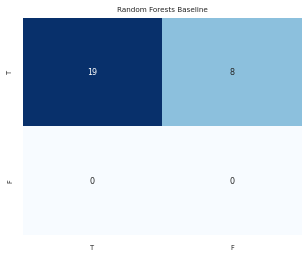

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


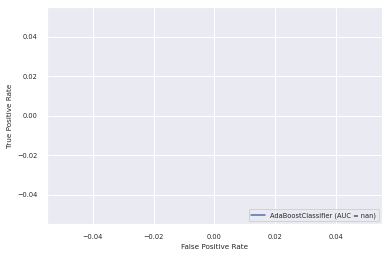

This is the starting index: 79 of patient 2
0.5178571428571429
[(0, 0, array([0.52947126, 0.47052874])), (0, 0, array([0.5072232, 0.4927768])), (1, 1, array([0.48478312, 0.51521688])), (0, 1, array([0.49892065, 0.50107935])), (1, 0, array([0.50691177, 0.49308823])), (1, 0, array([0.527474, 0.472526])), (1, 0, array([0.51676788, 0.48323212])), (1, 1, array([0.46931358, 0.53068642])), (1, 0, array([0.51589814, 0.48410186])), (1, 0, array([0.50920039, 0.49079961])), (1, 0, array([0.52200446, 0.47799554])), (0, 0, array([0.51566495, 0.48433505])), (1, 1, array([0.49006212, 0.50993788])), (0, 0, array([0.50860197, 0.49139803])), (0, 0, array([0.50379552, 0.49620448])), (1, 1, array([0.49365611, 0.50634389])), (0, 0, array([0.52290556, 0.47709444])), (0, 0, array([0.50904054, 0.49095946])), (0, 0, array([0.67018017, 0.32981983])), (0, 0, array([0.50261943, 0.49738057])), (0, 0, array([0.51555005, 0.48444995])), (0, 1, array([0.48367928, 0.51632072])), (0, 1, array([0.48200216, 0.51799784])),

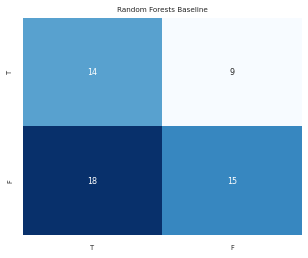

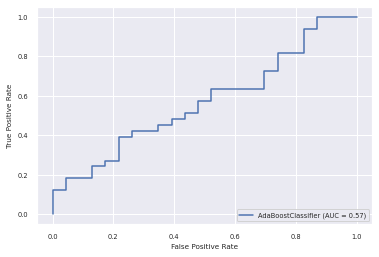

This is the starting index: 136 of patient 3
0.6756756756756757
[(1, 1, array([0.30000847, 0.69999153])), (1, 1, array([0.308619, 0.691381])), (1, 1, array([0.33268068, 0.66731932])), (1, 1, array([0.31809513, 0.68190487])), (1, 0, array([0.50513009, 0.49486991])), (1, 1, array([0.32891842, 0.67108158])), (1, 1, array([0.49805741, 0.50194259])), (1, 0, array([0.51879872, 0.48120128])), (0, 1, array([0.30772742, 0.69227258])), (1, 1, array([0.32833856, 0.67166144])), (1, 1, array([0.49705073, 0.50294927])), (1, 0, array([0.51726013, 0.48273987])), (1, 1, array([0.30724601, 0.69275399])), (1, 0, array([0.5154347, 0.4845653])), (1, 1, array([0.31857086, 0.68142914])), (1, 1, array([0.48241592, 0.51758408])), (0, 1, array([0.46277919, 0.53722081])), (0, 0, array([0.52348004, 0.47651996])), (1, 1, array([0.49322656, 0.50677344])), (1, 1, array([0.30445667, 0.69554333])), (1, 1, array([0.49632043, 0.50367957])), (0, 1, array([0.31092912, 0.68907088])), (1, 1, array([0.49138368, 0.50861632]))

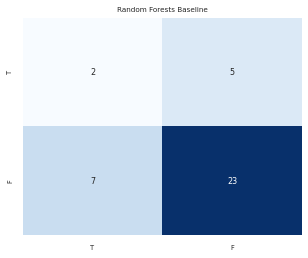

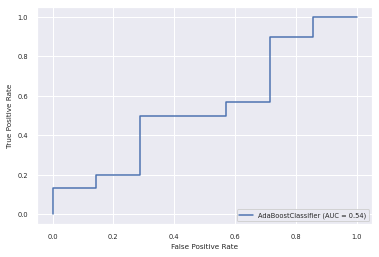

This is the starting index: 174 of patient 4
0.5945945945945946
[(0, 1, array([0.48131518, 0.51868482])), (0, 1, array([0.49398174, 0.50601826])), (1, 1, array([0.44768462, 0.55231538])), (0, 0, array([0.5146393, 0.4853607])), (1, 0, array([0.52071024, 0.47928976])), (0, 0, array([0.51158389, 0.48841611])), (1, 1, array([0.44783492, 0.55216508])), (0, 0, array([0.51914544, 0.48085456])), (1, 0, array([0.50467647, 0.49532353])), (0, 1, array([0.47279872, 0.52720128])), (0, 1, array([0.47615918, 0.52384082])), (0, 0, array([0.518081, 0.481919])), (0, 0, array([0.51144991, 0.48855009])), (0, 0, array([0.50738891, 0.49261109])), (0, 0, array([0.52237214, 0.47762786])), (0, 1, array([0.49573964, 0.50426036])), (1, 1, array([0.47762709, 0.52237291])), (0, 1, array([0.48633117, 0.51366883])), (0, 0, array([0.50923919, 0.49076081])), (0, 0, array([0.50708122, 0.49291878])), (0, 1, array([0.49400961, 0.50599039])), (0, 0, array([0.50776695, 0.49223305])), (1, 1, array([0.46303878, 0.53696122]))

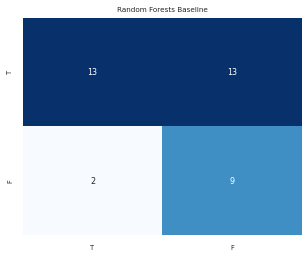

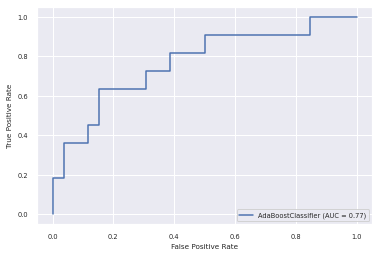

This is the starting index: 212 of patient 5
0.27450980392156865
[(1, 0, array([0.50587588, 0.49412412])), (1, 1, array([0.47410064, 0.52589936])), (0, 1, array([0.49277917, 0.50722083])), (0, 1, array([0.45261095, 0.54738905])), (0, 1, array([0.46806482, 0.53193518])), (0, 0, array([0.50330331, 0.49669669])), (0, 0, array([0.50129103, 0.49870897])), (0, 0, array([0.5037927, 0.4962073])), (0, 1, array([0.49044508, 0.50955492])), (0, 1, array([0.47422262, 0.52577738])), (0, 1, array([0.47256468, 0.52743532])), (0, 1, array([0.48686455, 0.51313545])), (0, 1, array([0.47937162, 0.52062838])), (0, 1, array([0.4893573, 0.5106427])), (0, 1, array([0.46515673, 0.53484327])), (0, 1, array([0.48766418, 0.51233582])), (0, 1, array([0.47577501, 0.52422499])), (0, 1, array([0.49855954, 0.50144046])), (0, 1, array([0.48762456, 0.51237544])), (0, 1, array([0.49827929, 0.50172071])), (0, 1, array([0.48820525, 0.51179475])), (0, 1, array([0.47777018, 0.52222982])), (0, 1, array([0.48876061, 0.51123939

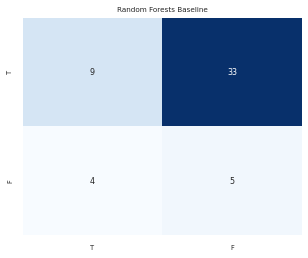

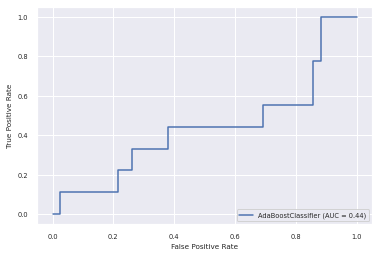

This is the starting index: 264 of patient 6
0.7368421052631579
[(0, 0, array([0.51802119, 0.48197881])), (0, 0, array([0.51335565, 0.48664435])), (1, 1, array([0.47841981, 0.52158019])), (0, 1, array([0.4993959, 0.5006041])), (0, 0, array([0.50170883, 0.49829117])), (1, 0, array([0.50930013, 0.49069987])), (0, 0, array([0.50028356, 0.49971644])), (0, 0, array([0.50308626, 0.49691374])), (1, 1, array([0.47857255, 0.52142745])), (0, 0, array([0.50851321, 0.49148679])), (1, 0, array([0.51095862, 0.48904138])), (0, 1, array([0.49338344, 0.50661656])), (1, 1, array([0.49864441, 0.50135559])), (1, 1, array([0.48161597, 0.51838403])), (0, 1, array([0.4904496, 0.5095504])), (1, 1, array([0.48681186, 0.51318814])), (1, 1, array([0.486144, 0.513856])), (0, 0, array([0.52799642, 0.47200358])), (0, 0, array([0.51137893, 0.48862107]))]


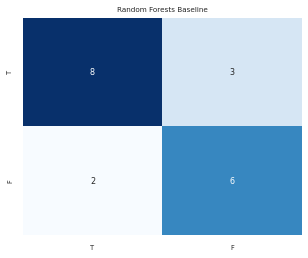

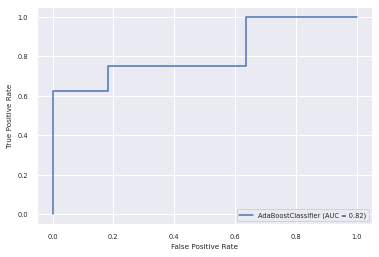

This is the starting index: 284 of patient 7
0.6666666666666666
[(0, 0, array([0.50635519, 0.49364481])), (0, 0, array([0.51524651, 0.48475349])), (0, 1, array([0.34639091, 0.65360909])), (0, 0, array([0.52509791, 0.47490209])), (0, 0, array([0.51616528, 0.48383472])), (0, 1, array([0.49101763, 0.50898237])), (0, 0, array([0.50336938, 0.49663062])), (0, 0, array([0.50576276, 0.49423724])), (0, 1, array([0.47585616, 0.52414384])), (0, 1, array([0.48243648, 0.51756352])), (1, 1, array([0.46898992, 0.53101008])), (0, 1, array([0.49774596, 0.50225404])), (0, 0, array([0.50189694, 0.49810306])), (0, 0, array([0.52578187, 0.47421813])), (0, 0, array([0.54092061, 0.45907939]))]


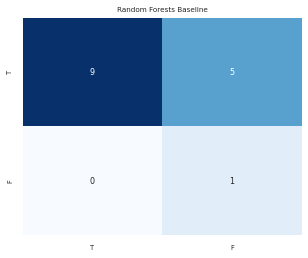

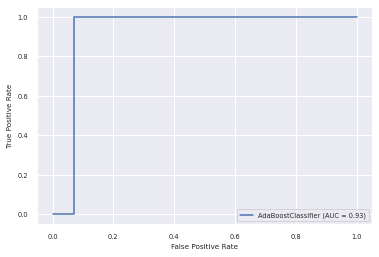

This is the starting index: 300 of patient 8
0.6744186046511628
[(0, 1, array([0.49392376, 0.50607624])), (0, 0, array([0.50472306, 0.49527694])), (0, 0, array([0.50977865, 0.49022135])), (0, 1, array([0.48165587, 0.51834413])), (0, 1, array([0.49451005, 0.50548995])), (0, 0, array([0.51869354, 0.48130646])), (0, 0, array([0.5214875, 0.4785125])), (0, 0, array([0.52352446, 0.47647554])), (0, 0, array([0.50602035, 0.49397965])), (0, 0, array([0.5090606, 0.4909394])), (0, 1, array([0.47086317, 0.52913683])), (0, 0, array([0.5052433, 0.4947567])), (0, 0, array([0.51180973, 0.48819027])), (0, 0, array([0.52111902, 0.47888098])), (1, 0, array([0.50076098, 0.49923902])), (0, 1, array([0.48901938, 0.51098062])), (1, 1, array([0.4735524, 0.5264476])), (1, 1, array([0.48610423, 0.51389577])), (0, 0, array([0.50895539, 0.49104461])), (0, 0, array([0.52434748, 0.47565252])), (1, 1, array([0.47223856, 0.52776144])), (0, 1, array([0.49945759, 0.50054241])), (1, 0, array([0.50258185, 0.49741815])), 

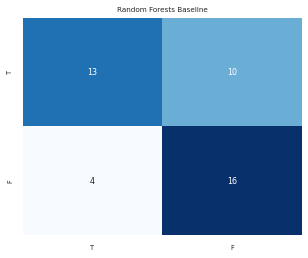

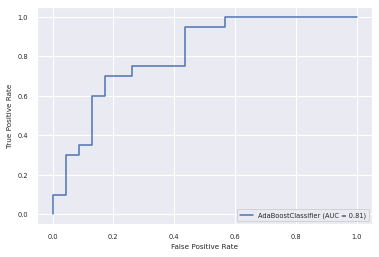

This is the starting index: 344 of patient 9
0.6031746031746031
[(1, 0, array([0.50855197, 0.49144803])), (1, 0, array([0.51491153, 0.48508847])), (0, 0, array([0.50693655, 0.49306345])), (1, 1, array([0.48606924, 0.51393076])), (1, 1, array([0.49467054, 0.50532946])), (1, 1, array([0.49313025, 0.50686975])), (1, 1, array([0.49272361, 0.50727639])), (0, 0, array([0.50857121, 0.49142879])), (0, 0, array([0.50153861, 0.49846139])), (0, 0, array([0.50856067, 0.49143933])), (0, 1, array([0.48868975, 0.51131025])), (0, 1, array([0.49549266, 0.50450734])), (0, 0, array([0.52824719, 0.47175281])), (0, 0, array([0.53151766, 0.46848234])), (0, 0, array([0.50964104, 0.49035896])), (0, 0, array([0.68379751, 0.31620249])), (0, 0, array([0.51379654, 0.48620346])), (1, 1, array([0.49666149, 0.50333851])), (0, 0, array([0.51593385, 0.48406615])), (0, 0, array([0.51652888, 0.48347112])), (1, 0, array([0.51262822, 0.48737178])), (1, 0, array([0.50404162, 0.49595838])), (0, 1, array([0.4723174, 0.527682

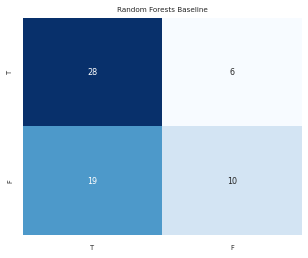

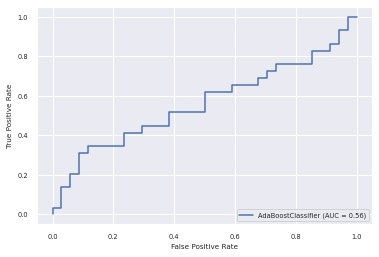

This is the starting index: 408 of patient 10
0.7727272727272727
[(1, 1, array([0.48727676, 0.51272324])), (1, 1, array([0.49098032, 0.50901968])), (1, 1, array([0.4951041, 0.5048959])), (1, 1, array([0.48805282, 0.51194718])), (1, 1, array([0.49402611, 0.50597389])), (1, 1, array([0.49655976, 0.50344024])), (1, 1, array([0.46255167, 0.53744833])), (1, 1, array([0.49743567, 0.50256433])), (1, 1, array([0.49495243, 0.50504757])), (0, 0, array([0.50403071, 0.49596929])), (0, 0, array([0.50635742, 0.49364258])), (1, 0, array([0.50268436, 0.49731564])), (1, 0, array([0.50219653, 0.49780347])), (1, 1, array([0.46255167, 0.53744833])), (1, 1, array([0.49400854, 0.50599146])), (0, 1, array([0.4973634, 0.5026366])), (1, 1, array([0.49687832, 0.50312168])), (1, 0, array([0.50700598, 0.49299402])), (0, 1, array([0.48735456, 0.51264544])), (1, 1, array([0.4686665, 0.5313335])), (0, 1, array([0.49530311, 0.50469689])), (1, 0, array([0.50888407, 0.49111593])), (0, 0, array([0.5357124, 0.4642876])),

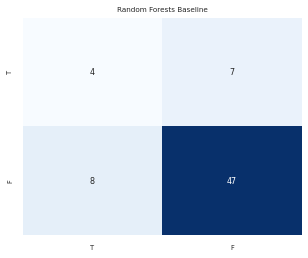

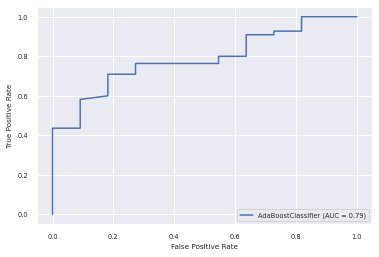

This is the starting index: 475 of patient 11
0.6851851851851852
[(0, 0, array([0.53235654, 0.46764346])), (1, 1, array([0.49353605, 0.50646395])), (1, 1, array([0.45857533, 0.54142467])), (1, 1, array([0.47313354, 0.52686646])), (0, 0, array([0.51354865, 0.48645135])), (1, 1, array([0.48431752, 0.51568248])), (1, 0, array([0.52506816, 0.47493184])), (1, 1, array([0.49231959, 0.50768041])), (1, 1, array([0.46450466, 0.53549534])), (1, 1, array([0.47422087, 0.52577913])), (1, 1, array([0.49694726, 0.50305274])), (0, 0, array([0.50404323, 0.49595677])), (1, 0, array([0.5137494, 0.4862506])), (1, 1, array([0.49782993, 0.50217007])), (1, 0, array([0.50112811, 0.49887189])), (1, 1, array([0.49675686, 0.50324314])), (1, 0, array([0.50031232, 0.49968768])), (1, 0, array([0.50482086, 0.49517914])), (1, 1, array([0.48119174, 0.51880826])), (1, 1, array([0.48264576, 0.51735424])), (1, 1, array([0.49918679, 0.50081321])), (1, 0, array([0.51847292, 0.48152708])), (1, 1, array([0.48309797, 0.516902

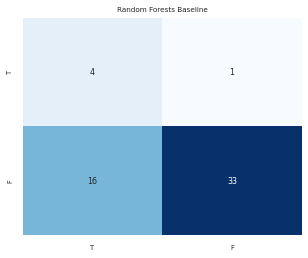

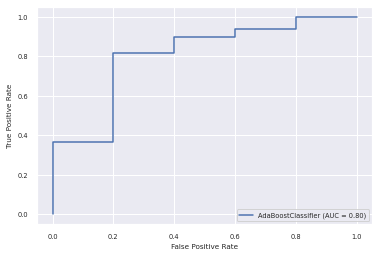

This is the starting index: 530 of patient 12
0.7777777777777778
[(1, 1, array([0.49633546, 0.50366454])), (1, 0, array([0.50491021, 0.49508979])), (1, 0, array([0.50365557, 0.49634443])), (1, 1, array([0.49676899, 0.50323101])), (1, 0, array([0.51697896, 0.48302104])), (1, 1, array([0.49564411, 0.50435589])), (1, 1, array([0.47741392, 0.52258608])), (0, 0, array([0.51425776, 0.48574224])), (0, 0, array([0.5112068, 0.4887932])), (1, 0, array([0.5364879, 0.4635121])), (1, 1, array([0.49216708, 0.50783292])), (1, 1, array([0.49980332, 0.50019668])), (1, 0, array([0.51837496, 0.48162504])), (1, 1, array([0.48608454, 0.51391546])), (1, 1, array([0.48863436, 0.51136564])), (1, 1, array([0.49499604, 0.50500396])), (1, 0, array([0.5081752, 0.4918248])), (1, 1, array([0.4704787, 0.5295213])), (1, 1, array([0.45719927, 0.54280073])), (1, 1, array([0.48993538, 0.51006462])), (1, 1, array([0.48714923, 0.51285077])), (1, 1, array([0.4661508, 0.5338492])), (1, 0, array([0.50537128, 0.49462872])), (

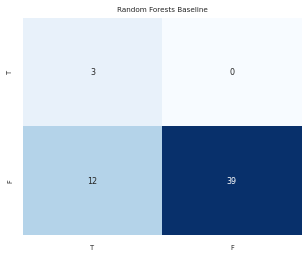

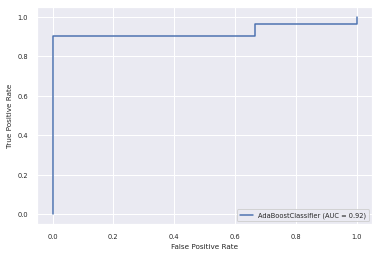

<function matplotlib.pyplot.show>

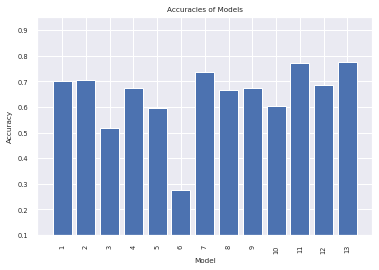

In [13]:
Accuracy = []
clf = AdaBoostClassifier()
sel = VarianceThreshold(threshold=(.1 * (1 - .8)))
for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    sel.fit_transform(train)
    sel.fit_transform(test)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### Univariate Feature Selection

This gives a weird error. The test dataset should not have any negative values because it is normalized but I have also tried to check the dataset for negative values and there seem to be none.

In [14]:
Accuracy = []

clf = AdaBoostClassifier()

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    # lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train, train_class.ravel())
    # model = SelectFromModel(lsvc, prefit=True)
    
    train = SelectKBest(chi2, k=20).fit_transform(train, train_class)
    test = SelectKBest(chi2, k=20).fit_transform(test, test_class)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

This is the starting index: 0 of patient 0


ValueError: ignored

#### L1-based feature selection

This is the starting index: 0 of patient 0
0.24
[(1, 0, array([0.50433039, 0.49566961])), (1, 1, array([0.49321701, 0.50678299])), (1, 0, array([0.50006401, 0.49993599])), (0, 0, array([0.50006401, 0.49993599])), (1, 0, array([0.50325735, 0.49674265])), (1, 0, array([0.50167847, 0.49832153])), (1, 0, array([0.50056916, 0.49943084])), (1, 1, array([0.49551126, 0.50448874])), (1, 0, array([0.50006401, 0.49993599])), (0, 0, array([0.50592646, 0.49407354])), (1, 0, array([0.50574413, 0.49425587])), (1, 0, array([0.50167847, 0.49832153])), (0, 0, array([0.50167847, 0.49832153])), (1, 1, array([0.49551126, 0.50448874])), (0, 0, array([0.50200625, 0.49799375])), (1, 0, array([0.50167847, 0.49832153])), (1, 0, array([0.50167847, 0.49832153])), (1, 0, array([0.50056916, 0.49943084])), (1, 0, array([0.50006401, 0.49993599])), (1, 0, array([0.50006401, 0.49993599])), (1, 0, array([0.50006401, 0.49993599])), (1, 0, array([0.50006401, 0.49993599])), (1, 0, array([0.50167847, 0.49832153])), (0, 0, a

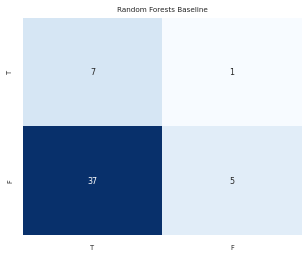

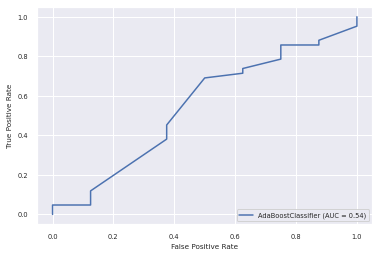

This is the starting index: 51 of patient 1
0.5185185185185185
[(0, 1, array([0.36849653, 0.63150347])), (0, 0, array([0.50910316, 0.49089684])), (0, 0, array([0.50163302, 0.49836698])), (0, 0, array([0.50163302, 0.49836698])), (0, 1, array([0.49561155, 0.50438845])), (0, 1, array([0.49571265, 0.50428735])), (0, 1, array([0.49222775, 0.50777225])), (0, 0, array([0.67799881, 0.32200119])), (0, 0, array([0.50418991, 0.49581009])), (0, 0, array([0.50171828, 0.49828172])), (0, 0, array([0.66633557, 0.33366443])), (0, 1, array([0.45923542, 0.54076458])), (0, 0, array([0.52344244, 0.47655756])), (0, 0, array([0.50883461, 0.49116539])), (0, 0, array([0.50135724, 0.49864276])), (0, 1, array([0.49681347, 0.50318653])), (0, 1, array([0.49102736, 0.50897264])), (0, 0, array([0.50409657, 0.49590343])), (0, 1, array([0.49827435, 0.50172565])), (0, 1, array([0.49662558, 0.50337442])), (0, 1, array([0.49681347, 0.50318653])), (0, 0, array([0.51274675, 0.48725325])), (0, 1, array([0.49827435, 0.501725

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


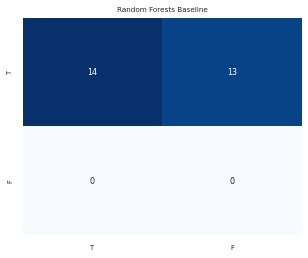

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


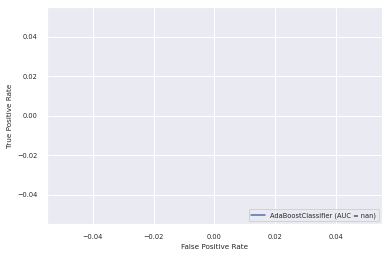

This is the starting index: 79 of patient 2
0.35714285714285715
[(0, 1, array([0.49686875, 0.50313125])), (0, 0, array([0.50203148, 0.49796852])), (1, 1, array([0.49615763, 0.50384237])), (0, 1, array([0.49635553, 0.50364447])), (1, 0, array([0.50132929, 0.49867071])), (1, 0, array([0.50406325, 0.49593675])), (1, 0, array([0.50212198, 0.49787802])), (1, 1, array([0.44175188, 0.55824812])), (1, 1, array([0.49250137, 0.50749863])), (1, 0, array([0.50359727, 0.49640273])), (1, 0, array([0.50203148, 0.49796852])), (0, 0, array([0.5014643, 0.4985357])), (1, 0, array([0.50203148, 0.49796852])), (0, 1, array([0.49853571, 0.50146429])), (0, 1, array([0.46094855, 0.53905145])), (1, 0, array([0.50203148, 0.49796852])), (0, 1, array([0.49853571, 0.50146429])), (0, 1, array([0.49437365, 0.50562635])), (0, 0, array([0.54622076, 0.45377924])), (0, 1, array([0.49437365, 0.50562635])), (0, 1, array([0.49853571, 0.50146429])), (0, 1, array([0.49901057, 0.50098943])), (0, 1, array([0.49853571, 0.5014642

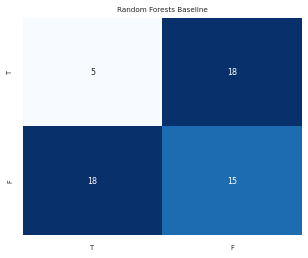

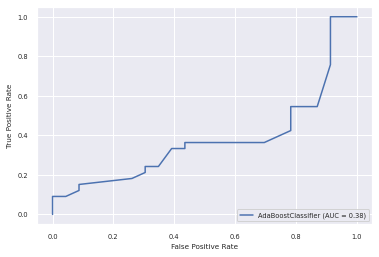

This is the starting index: 136 of patient 3
0.3783783783783784
[(1, 1, array([0.49530878, 0.50469122])), (1, 1, array([0.49178142, 0.50821858])), (1, 0, array([0.50826521, 0.49173479])), (1, 0, array([0.50189029, 0.49810971])), (1, 0, array([0.50016984, 0.49983016])), (1, 0, array([0.50016984, 0.49983016])), (1, 0, array([0.50350564, 0.49649436])), (1, 1, array([0.49511244, 0.50488756])), (0, 0, array([0.50207403, 0.49792597])), (1, 1, array([0.49511244, 0.50488756])), (1, 0, array([0.50016984, 0.49983016])), (1, 0, array([0.50016984, 0.49983016])), (1, 0, array([0.50016984, 0.49983016])), (1, 0, array([0.50016984, 0.49983016])), (1, 0, array([0.50016984, 0.49983016])), (1, 0, array([0.50016984, 0.49983016])), (0, 0, array([0.50189029, 0.49810971])), (0, 1, array([0.49985611, 0.50014389])), (1, 0, array([0.50016984, 0.49983016])), (1, 1, array([0.49744276, 0.50255724])), (1, 0, array([0.6312141, 0.3687859])), (0, 0, array([0.50016984, 0.49983016])), (1, 0, array([0.50016984, 0.4998301

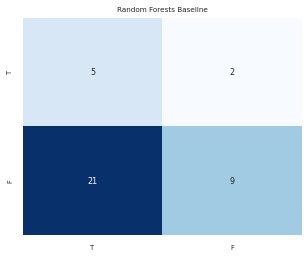

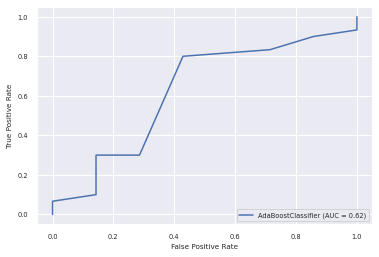

This is the starting index: 174 of patient 4
0.35135135135135137
[(0, 1, array([0.4986679, 0.5013321])), (0, 1, array([0.4986679, 0.5013321])), (1, 1, array([0.47090043, 0.52909957])), (0, 0, array([0.50310379, 0.49689621])), (1, 1, array([0.4986679, 0.5013321])), (0, 0, array([0.50146729, 0.49853271])), (1, 0, array([0.50261453, 0.49738547])), (0, 1, array([0.49736501, 0.50263499])), (1, 1, array([0.49981066, 0.50018934])), (0, 1, array([0.49779731, 0.50220269])), (0, 1, array([0.49697633, 0.50302367])), (0, 1, array([0.4986679, 0.5013321])), (0, 0, array([0.50543136, 0.49456864])), (0, 1, array([0.49607097, 0.50392903])), (0, 1, array([0.4986679, 0.5013321])), (0, 1, array([0.49736501, 0.50263499])), (1, 1, array([0.47090043, 0.52909957])), (0, 1, array([0.49981066, 0.50018934])), (0, 1, array([0.4986679, 0.5013321])), (0, 1, array([0.4986679, 0.5013321])), (0, 1, array([0.4986679, 0.5013321])), (0, 1, array([0.4942972, 0.5057028])), (1, 1, array([0.49492753, 0.50507247])), (0, 1, ar

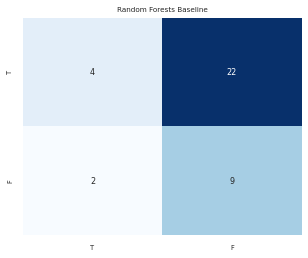

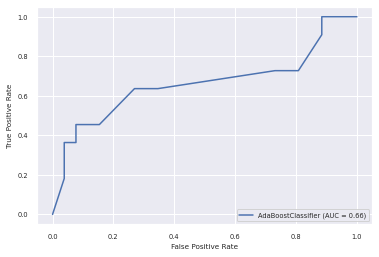

This is the starting index: 212 of patient 5
0.37254901960784315
[(1, 0, array([0.50703783, 0.49296217])), (1, 1, array([0.37803275, 0.62196725])), (0, 1, array([0.49813165, 0.50186835])), (0, 1, array([0.47775979, 0.52224021])), (0, 1, array([0.48957186, 0.51042814])), (0, 0, array([0.50193723, 0.49806277])), (0, 1, array([0.49894852, 0.50105148])), (0, 1, array([0.49894852, 0.50105148])), (0, 0, array([0.50037305, 0.49962695])), (0, 1, array([0.49536669, 0.50463331])), (0, 1, array([0.4847299, 0.5152701])), (0, 1, array([0.49894852, 0.50105148])), (0, 1, array([0.4847299, 0.5152701])), (0, 1, array([0.49894852, 0.50105148])), (0, 1, array([0.49813165, 0.50186835])), (0, 0, array([0.50064898, 0.49935102])), (0, 1, array([0.37803275, 0.62196725])), (0, 1, array([0.49894852, 0.50105148])), (0, 1, array([0.49382732, 0.50617268])), (0, 1, array([0.49894852, 0.50105148])), (0, 1, array([0.49894852, 0.50105148])), (0, 0, array([0.50064898, 0.49935102])), (0, 0, array([0.50064898, 0.49935102

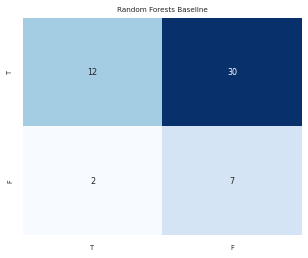

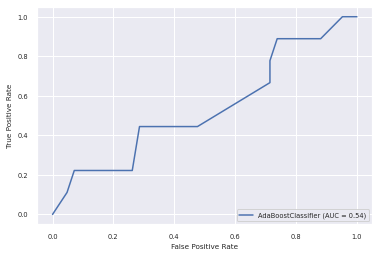

This is the starting index: 264 of patient 6
0.3684210526315789
[(0, 1, array([0.49966251, 0.50033749])), (0, 1, array([0.49303888, 0.50696112])), (1, 0, array([0.50412122, 0.49587878])), (0, 1, array([0.49673363, 0.50326637])), (0, 1, array([0.49673363, 0.50326637])), (1, 0, array([0.50119833, 0.49880167])), (0, 1, array([0.49533696, 0.50466304])), (0, 0, array([0.50220326, 0.49779674])), (1, 0, array([0.50412122, 0.49587878])), (0, 1, array([0.49673363, 0.50326637])), (1, 0, array([0.50294205, 0.49705795])), (0, 0, array([0.50514269, 0.49485731])), (1, 0, array([0.50667135, 0.49332865])), (1, 0, array([0.50221292, 0.49778708])), (0, 0, array([0.51068347, 0.48931653])), (1, 1, array([0.4975259, 0.5024741])), (1, 1, array([0.49453301, 0.50546699])), (0, 0, array([0.50546368, 0.49453632])), (0, 0, array([0.50546368, 0.49453632]))]


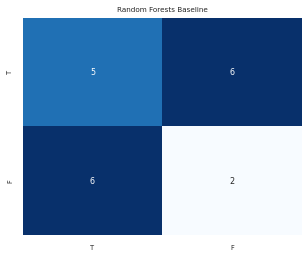

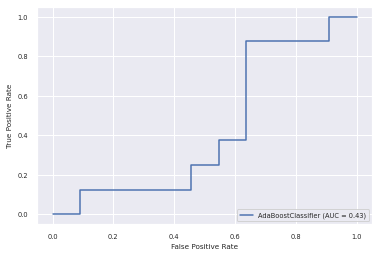

This is the starting index: 284 of patient 7
0.4666666666666667
[(0, 1, array([0.49232243, 0.50767757])), (0, 1, array([0.49846312, 0.50153688])), (0, 1, array([0.49786111, 0.50213889])), (0, 1, array([0.40550473, 0.59449527])), (0, 0, array([0.50168002, 0.49831998])), (0, 1, array([0.49232243, 0.50767757])), (0, 1, array([0.49232243, 0.50767757])), (0, 0, array([0.50168002, 0.49831998])), (0, 1, array([0.49232243, 0.50767757])), (0, 0, array([0.50694068, 0.49305932])), (1, 1, array([0.39702276, 0.60297724])), (0, 1, array([0.49451194, 0.50548806])), (0, 0, array([0.52581646, 0.47418354])), (0, 0, array([0.57100867, 0.42899133])), (0, 0, array([0.50538778, 0.49461222]))]


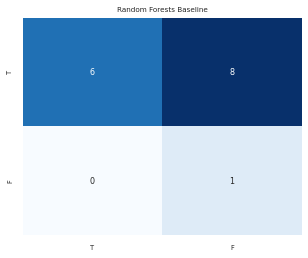

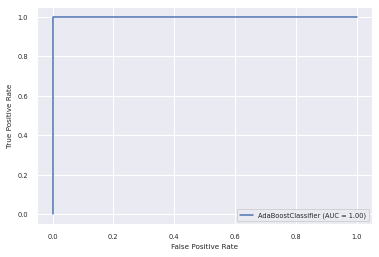

This is the starting index: 300 of patient 8
0.6744186046511628
[(0, 0, array([0.50405341, 0.49594659])), (0, 0, array([0.50645682, 0.49354318])), (0, 1, array([0.49974993, 0.50025007])), (0, 1, array([0.498167, 0.501833])), (0, 1, array([0.49638089, 0.50361911])), (0, 0, array([0.50405341, 0.49594659])), (0, 1, array([0.49662103, 0.50337897])), (0, 0, array([0.51668972, 0.48331028])), (0, 1, array([0.49856428, 0.50143572])), (0, 1, array([0.49974993, 0.50025007])), (0, 1, array([0.49974993, 0.50025007])), (0, 0, array([0.54556585, 0.45443415])), (0, 0, array([0.5006844, 0.4993156])), (0, 0, array([0.51668972, 0.48331028])), (1, 1, array([0.49974993, 0.50025007])), (0, 0, array([0.6362917, 0.3637083])), (1, 1, array([0.49378664, 0.50621336])), (1, 1, array([0.49974993, 0.50025007])), (0, 0, array([0.50405341, 0.49594659])), (0, 0, array([0.50233111, 0.49766889])), (1, 1, array([0.49378664, 0.50621336])), (0, 1, array([0.49974993, 0.50025007])), (1, 1, array([0.49638089, 0.50361911])), 

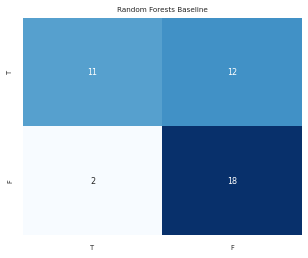

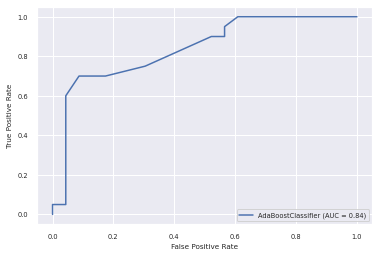

This is the starting index: 344 of patient 9
0.4126984126984127
[(1, 0, array([0.52292616, 0.47707384])), (1, 0, array([0.50276651, 0.49723349])), (0, 1, array([0.49855182, 0.50144818])), (1, 0, array([0.50303676, 0.49696324])), (1, 1, array([0.49368953, 0.50631047])), (1, 1, array([0.44403754, 0.55596246])), (1, 0, array([0.50120404, 0.49879596])), (0, 0, array([0.50886663, 0.49113337])), (0, 1, array([0.49657436, 0.50342564])), (0, 0, array([0.50546172, 0.49453828])), (0, 1, array([0.49535628, 0.50464372])), (0, 1, array([0.49854812, 0.50145188])), (0, 0, array([0.63103691, 0.36896309])), (0, 0, array([0.50764364, 0.49235636])), (0, 1, array([0.49663552, 0.50336448])), (0, 1, array([0.49657436, 0.50342564])), (0, 1, array([0.49345798, 0.50654202])), (1, 0, array([0.50864576, 0.49135424])), (0, 1, array([0.49186286, 0.50813714])), (0, 1, array([0.49686992, 0.50313008])), (1, 1, array([0.49534403, 0.50465597])), (1, 0, array([0.52023578, 0.47976422])), (0, 0, array([0.5054486, 0.494551

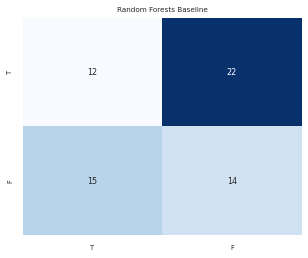

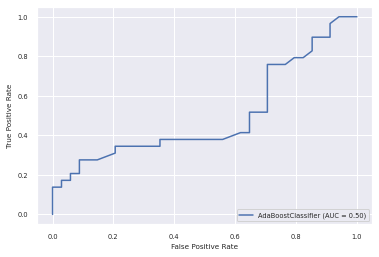

This is the starting index: 408 of patient 10
0.8333333333333334
[(1, 1, array([0.49187015, 0.50812985])), (1, 1, array([0.49802441, 0.50197559])), (1, 1, array([0.49568085, 0.50431915])), (1, 1, array([0.49187015, 0.50812985])), (1, 1, array([0.49995777, 0.50004223])), (1, 1, array([0.49187015, 0.50812985])), (1, 1, array([0.49474611, 0.50525389])), (1, 1, array([0.49995777, 0.50004223])), (1, 1, array([0.49346458, 0.50653542])), (0, 1, array([0.49995777, 0.50004223])), (0, 1, array([0.49995777, 0.50004223])), (1, 1, array([0.49187015, 0.50812985])), (1, 1, array([0.49995777, 0.50004223])), (1, 0, array([0.5007024, 0.4992976])), (1, 1, array([0.49187015, 0.50812985])), (0, 0, array([0.54757735, 0.45242265])), (1, 0, array([0.50163809, 0.49836191])), (1, 0, array([0.50287543, 0.49712457])), (0, 0, array([0.5010332, 0.4989668])), (1, 1, array([0.42874774, 0.57125226])), (0, 1, array([0.49995777, 0.50004223])), (1, 1, array([0.49995777, 0.50004223])), (0, 0, array([0.54757735, 0.45242265

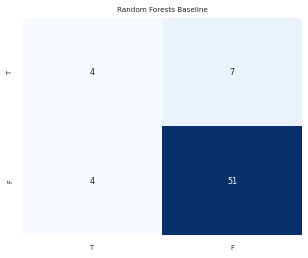

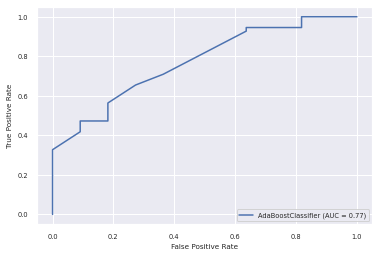

This is the starting index: 475 of patient 11
0.6481481481481481
[(0, 1, array([0.49838947, 0.50161053])), (1, 1, array([0.49747916, 0.50252084])), (1, 1, array([0.49948775, 0.50051225])), (1, 1, array([0.49747916, 0.50252084])), (0, 0, array([0.50055557, 0.49944443])), (1, 1, array([0.49712098, 0.50287902])), (1, 1, array([0.49747916, 0.50252084])), (1, 1, array([0.49712098, 0.50287902])), (1, 1, array([0.49490163, 0.50509837])), (1, 1, array([0.49948775, 0.50051225])), (1, 1, array([0.49747916, 0.50252084])), (0, 0, array([0.50055557, 0.49944443])), (1, 1, array([0.49712098, 0.50287902])), (1, 1, array([0.49838947, 0.50161053])), (1, 1, array([0.49867911, 0.50132089])), (1, 0, array([0.50055557, 0.49944443])), (1, 1, array([0.49712098, 0.50287902])), (1, 1, array([0.49948775, 0.50051225])), (1, 1, array([0.49849139, 0.50150861])), (1, 1, array([0.49712098, 0.50287902])), (1, 0, array([0.50055557, 0.49944443])), (1, 1, array([0.49712098, 0.50287902])), (1, 0, array([0.50055557, 0.4994

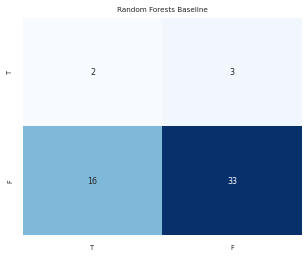

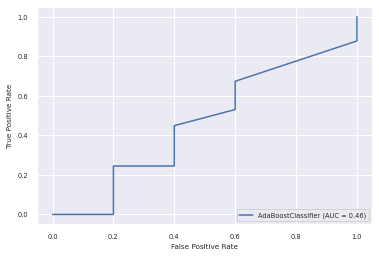

This is the starting index: 530 of patient 12
0.6851851851851852
[(1, 1, array([0.4264127, 0.5735873])), (1, 0, array([0.50163498, 0.49836502])), (1, 0, array([0.50059556, 0.49940444])), (1, 0, array([0.52233705, 0.47766295])), (1, 0, array([0.50076119, 0.49923881])), (1, 1, array([0.49909189, 0.50090811])), (1, 0, array([0.5017536, 0.4982464])), (0, 0, array([0.50163498, 0.49836502])), (0, 0, array([0.50090335, 0.49909665])), (1, 0, array([0.56021935, 0.43978065])), (1, 1, array([0.4966682, 0.5033318])), (1, 0, array([0.50007492, 0.49992508])), (1, 0, array([0.50393849, 0.49606151])), (1, 1, array([0.49333858, 0.50666142])), (1, 1, array([0.48144778, 0.51855222])), (1, 1, array([0.49906158, 0.50093842])), (1, 1, array([0.49909189, 0.50090811])), (1, 1, array([0.49661684, 0.50338316])), (1, 1, array([0.49500987, 0.50499013])), (1, 0, array([0.50163498, 0.49836502])), (1, 1, array([0.49333858, 0.50666142])), (1, 1, array([0.49333858, 0.50666142])), (1, 0, array([0.50007492, 0.49992508])

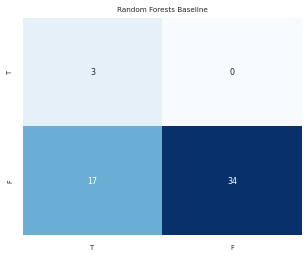

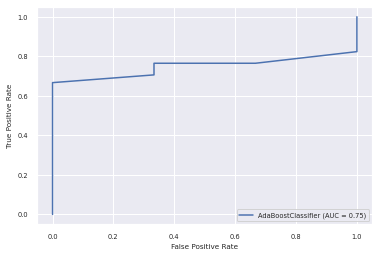

<function matplotlib.pyplot.show>

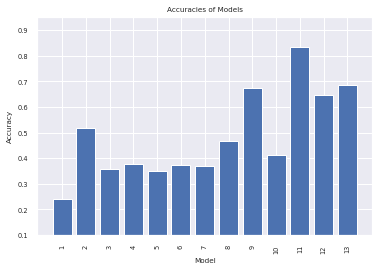

In [15]:
Accuracy = []

clf = AdaBoostClassifier()

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train, train_class.ravel())
    model = SelectFromModel(lsvc, prefit=True)
    train = model.transform(train)
    test = model.transform(test)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show


#### Tree Based Feature Selection

This is the starting index: 0 of patient 0
0.58
[(1, 0, array([0.76, 0.24])), (1, 1, array([0.13, 0.87])), (1, 1, array([0.35, 0.65])), (0, 1, array([0.36, 0.64])), (1, 0, array([0.63, 0.37])), (1, 1, array([0.48, 0.52])), (1, 1, array([0.28, 0.72])), (1, 1, array([0.16, 0.84])), (1, 1, array([0.24, 0.76])), (0, 0, array([0.63, 0.37])), (1, 1, array([0.43, 0.57])), (1, 1, array([0.15, 0.85])), (0, 1, array([0.37, 0.63])), (1, 1, array([0., 1.])), (0, 0, array([0.68, 0.32])), (1, 1, array([0.41, 0.59])), (1, 0, array([0.71, 0.29])), (1, 0, array([0.62, 0.38])), (1, 1, array([0.26, 0.74])), (1, 1, array([0.15, 0.85])), (1, 1, array([0.25, 0.75])), (1, 1, array([0.1, 0.9])), (1, 1, array([0.33, 0.67])), (0, 1, array([0.37, 0.63])), (1, 1, array([0.46, 0.54])), (1, 1, array([0.26, 0.74])), (1, 1, array([0.16, 0.84])), (0, 1, array([0.09, 0.91])), (1, 1, array([0.46, 0.54])), (1, 1, array([0.26, 0.74])), (1, 0, array([0.78, 0.22])), (1, 1, array([0.36, 0.64])), (1, 1, array([0.41, 0.59])), 

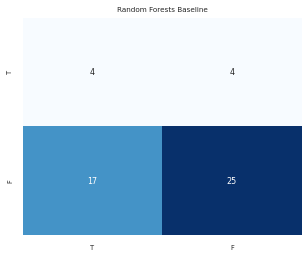

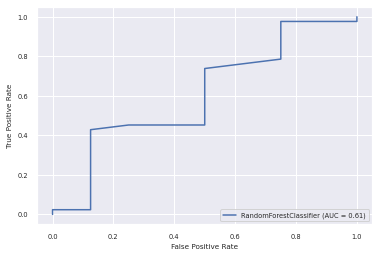

This is the starting index: 51 of patient 1
0.8148148148148148
[(0, 0, array([0.68, 0.32])), (0, 0, array([0.88, 0.12])), (0, 0, array([0.63, 0.37])), (0, 0, array([0.76, 0.24])), (0, 0, array([0.66, 0.34])), (0, 0, array([0.76, 0.24])), (0, 1, array([0.3, 0.7])), (0, 0, array([0.69, 0.31])), (0, 0, array([0.52, 0.48])), (0, 0, array([0.65, 0.35])), (0, 1, array([0.44, 0.56])), (0, 0, array([0.87, 0.13])), (0, 0, array([0.93, 0.07])), (0, 0, array([0.94, 0.06])), (0, 1, array([0.32, 0.68])), (0, 0, array([0.91, 0.09])), (0, 0, array([0.88, 0.12])), (0, 0, array([0.88, 0.12])), (0, 0, array([0.69, 0.31])), (0, 0, array([0.88, 0.12])), (0, 0, array([0.77, 0.23])), (0, 0, array([0.94, 0.06])), (0, 0, array([0.58, 0.42])), (0, 0, array([0.67, 0.33])), (0, 1, array([0.38, 0.62])), (0, 1, array([0.35, 0.65])), (0, 0, array([0.5, 0.5]))]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


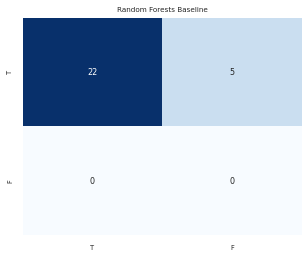

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


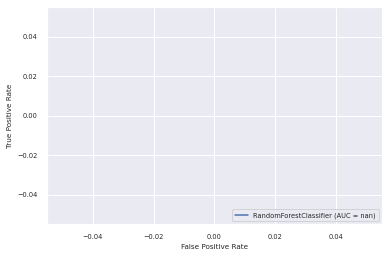

This is the starting index: 79 of patient 2
0.5
[(0, 0, array([0.54, 0.46])), (0, 0, array([0.61, 0.39])), (1, 0, array([0.65, 0.35])), (0, 0, array([0.51, 0.49])), (1, 0, array([0.65, 0.35])), (1, 0, array([0.68, 0.32])), (1, 0, array([0.77, 0.23])), (1, 1, array([0.21, 0.79])), (1, 0, array([0.78, 0.22])), (1, 0, array([0.67, 0.33])), (1, 0, array([0.73, 0.27])), (0, 1, array([0.46, 0.54])), (1, 0, array([0.62, 0.38])), (0, 0, array([0.64, 0.36])), (0, 1, array([0.42, 0.58])), (1, 0, array([0.62, 0.38])), (0, 0, array([0.76, 0.24])), (0, 0, array([0.79, 0.21])), (0, 0, array([0.85, 0.15])), (0, 0, array([0.62, 0.38])), (0, 0, array([0.65, 0.35])), (0, 1, array([0.38, 0.62])), (0, 1, array([0.47, 0.53])), (1, 1, array([0.38, 0.62])), (1, 0, array([0.68, 0.32])), (1, 1, array([0.32, 0.68])), (1, 0, array([0.62, 0.38])), (0, 0, array([0.6, 0.4])), (1, 1, array([0.47, 0.53])), (1, 0, array([0.73, 0.27])), (1, 1, array([0.37, 0.63])), (1, 0, array([0.53, 0.47])), (1, 0, array([0.81, 0.19]

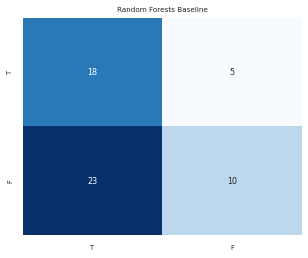

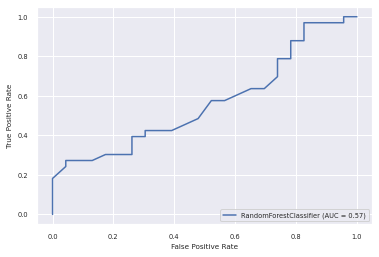

This is the starting index: 136 of patient 3
0.6756756756756757
[(1, 1, array([0.22, 0.78])), (1, 1, array([0.19, 0.81])), (1, 0, array([0.5, 0.5])), (1, 1, array([0.44, 0.56])), (1, 1, array([0.46, 0.54])), (1, 1, array([0.3, 0.7])), (1, 1, array([0.48, 0.52])), (1, 0, array([0.54, 0.46])), (0, 1, array([0.4, 0.6])), (1, 1, array([0.28, 0.72])), (1, 1, array([0.4, 0.6])), (1, 0, array([0.5, 0.5])), (1, 1, array([0.1, 0.9])), (1, 1, array([0.46, 0.54])), (1, 1, array([0.48, 0.52])), (1, 1, array([0.47, 0.53])), (0, 1, array([0.22, 0.78])), (0, 0, array([0.7, 0.3])), (1, 1, array([0.21, 0.79])), (1, 1, array([0.21, 0.79])), (1, 0, array([0.78, 0.22])), (0, 1, array([0.34, 0.66])), (1, 1, array([0.47, 0.53])), (0, 1, array([0.32, 0.68])), (1, 0, array([0.54, 0.46])), (0, 1, array([0.33, 0.67])), (1, 0, array([0.6, 0.4])), (1, 1, array([0.24, 0.76])), (1, 1, array([0.18, 0.82])), (1, 1, array([0.18, 0.82])), (1, 1, array([0.1, 0.9])), (1, 1, array([0.36, 0.64])), (1, 1, array([0.17, 0.83]

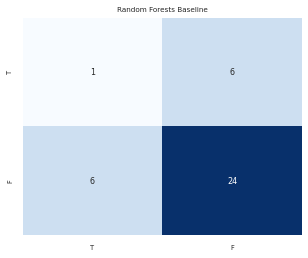

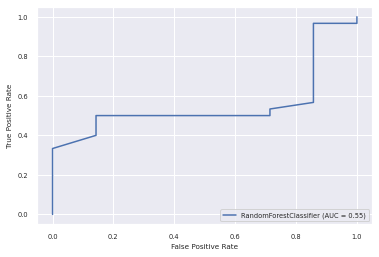

This is the starting index: 174 of patient 4
0.7297297297297297
[(0, 0, array([0.59, 0.41])), (0, 0, array([0.51, 0.49])), (1, 1, array([0., 1.])), (0, 0, array([0.75, 0.25])), (1, 0, array([0.73, 0.27])), (0, 0, array([0.79, 0.21])), (1, 1, array([0.02, 0.98])), (0, 0, array([0.73, 0.27])), (1, 0, array([0.65, 0.35])), (0, 1, array([0.4, 0.6])), (0, 1, array([0.11, 0.89])), (0, 0, array([0.64, 0.36])), (0, 0, array([0.71, 0.29])), (0, 0, array([0.62, 0.38])), (0, 0, array([0.59, 0.41])), (0, 0, array([0.59, 0.41])), (1, 1, array([0.14, 0.86])), (0, 1, array([0.25, 0.75])), (0, 1, array([0.42, 0.58])), (0, 0, array([0.58, 0.42])), (0, 1, array([0.41, 0.59])), (0, 0, array([0.73, 0.27])), (1, 1, array([0.12, 0.88])), (0, 1, array([0.17, 0.83])), (1, 1, array([0.48, 0.52])), (1, 1, array([0.08, 0.92])), (0, 0, array([0.65, 0.35])), (0, 1, array([0.41, 0.59])), (1, 1, array([0.23, 0.77])), (1, 1, array([0.18, 0.82])), (1, 1, array([0.11, 0.89])), (0, 1, array([0.27, 0.73])), (0, 0, array(

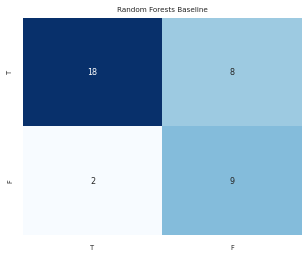

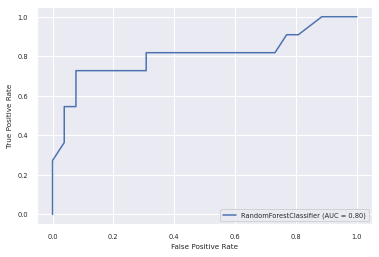

This is the starting index: 212 of patient 5
0.35294117647058826
[(1, 0, array([0.52, 0.48])), (1, 1, array([0.01, 0.99])), (0, 1, array([0.36, 0.64])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([0.53, 0.47])), (0, 0, array([0.54, 0.46])), (0, 1, array([0.23, 0.77])), (0, 1, array([0.45, 0.55])), (0, 1, array([0.02, 0.98])), (0, 1, array([0.03, 0.97])), (0, 1, array([0.18, 0.82])), (0, 1, array([0.04, 0.96])), (0, 1, array([0.32, 0.68])), (0, 1, array([0.06, 0.94])), (0, 0, array([0.51, 0.49])), (0, 1, array([0.02, 0.98])), (0, 0, array([0.58, 0.42])), (0, 1, array([0.14, 0.86])), (0, 1, array([0.29, 0.71])), (0, 1, array([0.16, 0.84])), (0, 0, array([0.56, 0.44])), (0, 0, array([0.57, 0.43])), (0, 1, array([0.1, 0.9])), (0, 1, array([0.14, 0.86])), (0, 1, array([0.35, 0.65])), (0, 0, array([0.98, 0.02])), (0, 1, array([0.02, 0.98])), (0, 1, array([0.38, 0.62])), (0, 1, array([0.23, 0.77])), (0, 1, array([0.1, 0.9])), (0, 1, array([0.04, 0.96])), (0, 1, array([0.36

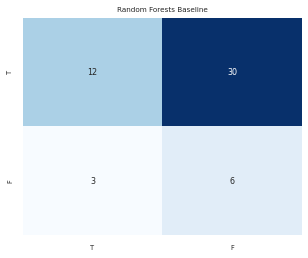

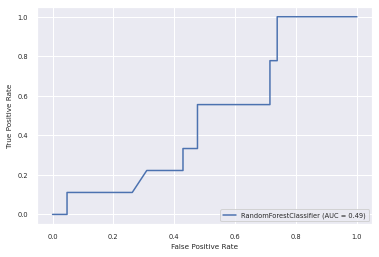

This is the starting index: 264 of patient 6
0.7368421052631579
[(0, 1, array([0.49, 0.51])), (0, 0, array([0.58, 0.42])), (1, 1, array([0.43, 0.57])), (0, 1, array([0.43, 0.57])), (0, 0, array([0.52, 0.48])), (1, 0, array([0.63, 0.37])), (0, 1, array([0.44, 0.56])), (0, 0, array([0.64, 0.36])), (1, 1, array([0.36, 0.64])), (0, 0, array([0.61, 0.39])), (1, 1, array([0.37, 0.63])), (0, 0, array([0.52, 0.48])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.24, 0.76])), (0, 1, array([0.42, 0.58])), (1, 1, array([0.29, 0.71])), (1, 1, array([0.36, 0.64])), (0, 0, array([0.64, 0.36])), (0, 0, array([0.58, 0.42]))]


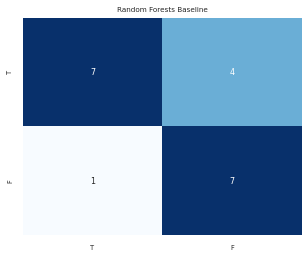

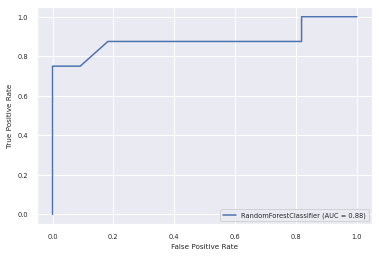

This is the starting index: 284 of patient 7
0.5333333333333333
[(0, 1, array([0.45, 0.55])), (0, 0, array([0.54, 0.46])), (0, 1, array([0.49, 0.51])), (0, 0, array([0.68, 0.32])), (0, 0, array([0.59, 0.41])), (0, 1, array([0.3, 0.7])), (0, 1, array([0.39, 0.61])), (0, 1, array([0.49, 0.51])), (0, 1, array([0.1, 0.9])), (0, 1, array([0.41, 0.59])), (1, 1, array([0.11, 0.89])), (0, 0, array([0.51, 0.49])), (0, 0, array([0.66, 0.34])), (0, 0, array([0.62, 0.38])), (0, 0, array([0.55, 0.45]))]


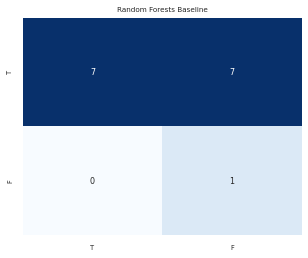

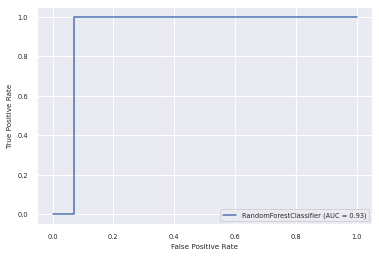

This is the starting index: 300 of patient 8
0.7209302325581395
[(0, 0, array([0.59, 0.41])), (0, 0, array([0.72, 0.28])), (0, 0, array([0.85, 0.15])), (0, 1, array([0.35, 0.65])), (0, 1, array([0.26, 0.74])), (0, 0, array([0.72, 0.28])), (0, 1, array([0.25, 0.75])), (0, 0, array([0.83, 0.17])), (0, 1, array([0.48, 0.52])), (0, 0, array([0.65, 0.35])), (0, 1, array([0.39, 0.61])), (0, 0, array([0.8, 0.2])), (0, 0, array([0.69, 0.31])), (0, 0, array([0.87, 0.13])), (1, 1, array([0.28, 0.72])), (0, 1, array([0.49, 0.51])), (1, 1, array([0.01, 0.99])), (1, 1, array([0.08, 0.92])), (0, 0, array([0.65, 0.35])), (0, 0, array([0.63, 0.37])), (1, 1, array([0.01, 0.99])), (0, 0, array([0.53, 0.47])), (1, 1, array([0.32, 0.68])), (1, 1, array([0.11, 0.89])), (1, 1, array([0.08, 0.92])), (1, 1, array([0.02, 0.98])), (1, 1, array([0.18, 0.82])), (1, 1, array([0., 1.])), (0, 1, array([0.26, 0.74])), (1, 0, array([0.53, 0.47])), (1, 1, array([0.45, 0.55])), (1, 1, array([0.07, 0.93])), (1, 1, array(

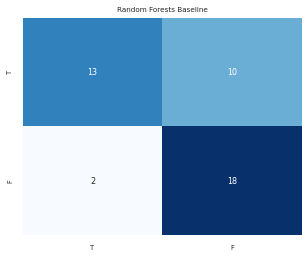

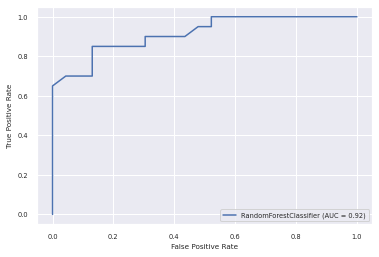

This is the starting index: 344 of patient 9
0.6190476190476191
[(1, 0, array([0.84, 0.16])), (1, 0, array([0.68, 0.32])), (0, 0, array([0.6, 0.4])), (1, 0, array([0.56, 0.44])), (1, 1, array([0.46, 0.54])), (1, 0, array([0.55, 0.45])), (1, 0, array([0.59, 0.41])), (0, 0, array([0.68, 0.32])), (0, 0, array([0.54, 0.46])), (0, 0, array([0.64, 0.36])), (0, 1, array([0.49, 0.51])), (0, 0, array([0.54, 0.46])), (0, 0, array([0.99, 0.01])), (0, 0, array([0.68, 0.32])), (0, 0, array([0.59, 0.41])), (0, 0, array([0.54, 0.46])), (0, 0, array([0.52, 0.48])), (1, 0, array([0.67, 0.33])), (0, 0, array([0.59, 0.41])), (0, 0, array([0.8, 0.2])), (1, 0, array([0.72, 0.28])), (1, 0, array([0.58, 0.42])), (0, 0, array([0.54, 0.46])), (0, 0, array([0.79, 0.21])), (1, 0, array([0.63, 0.37])), (0, 0, array([0.59, 0.41])), (1, 1, array([0.36, 0.64])), (0, 0, array([0.7, 0.3])), (1, 0, array([0.57, 0.43])), (1, 0, array([0.62, 0.38])), (0, 0, array([0.56, 0.44])), (1, 1, array([0.41, 0.59])), (1, 0, array(

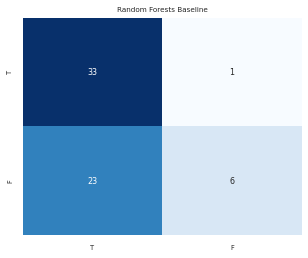

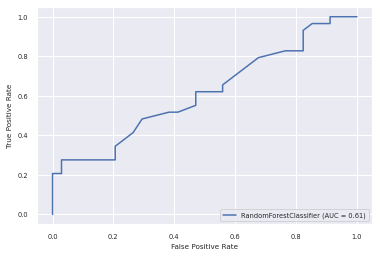

This is the starting index: 408 of patient 10
0.803030303030303
[(1, 1, array([0.19, 0.81])), (1, 1, array([0.18, 0.82])), (1, 1, array([0.25, 0.75])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.35, 0.65])), (1, 1, array([0.21, 0.79])), (1, 1, array([0.09, 0.91])), (1, 1, array([0.48, 0.52])), (1, 1, array([0.33, 0.67])), (0, 1, array([0.48, 0.52])), (0, 0, array([0.5, 0.5])), (1, 1, array([0.26, 0.74])), (1, 1, array([0.27, 0.73])), (1, 1, array([0.03, 0.97])), (1, 1, array([0.21, 0.79])), (0, 0, array([0.79, 0.21])), (1, 0, array([0.63, 0.37])), (1, 0, array([0.57, 0.43])), (0, 0, array([0.57, 0.43])), (1, 1, array([0.08, 0.92])), (0, 1, array([0.39, 0.61])), (1, 0, array([0.71, 0.29])), (0, 0, array([0.78, 0.22])), (1, 1, array([0.31, 0.69])), (1, 1, array([0.23, 0.77])), (0, 0, array([0.66, 0.34])), (1, 0, array([0.51, 0.49])), (1, 1, array([0.35, 0.65])), (1, 1, array([0.15, 0.85])), (1, 0, array([0.55, 0.45])), (1, 1, array([0.4, 0.6])), (1, 1, array([0.43, 0.57])), (1, 1, arra

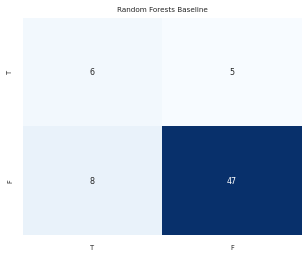

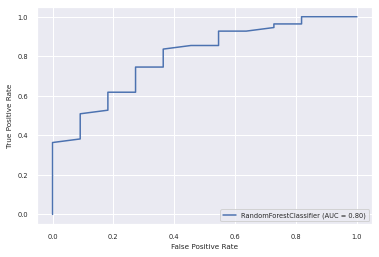

This is the starting index: 475 of patient 11
0.7592592592592593
[(0, 0, array([0.94, 0.06])), (1, 0, array([0.61, 0.39])), (1, 1, array([0.18, 0.82])), (1, 1, array([0.41, 0.59])), (0, 0, array([0.59, 0.41])), (1, 1, array([0.14, 0.86])), (1, 0, array([0.65, 0.35])), (1, 1, array([0.28, 0.72])), (1, 1, array([0.13, 0.87])), (1, 1, array([0.2, 0.8])), (1, 1, array([0.28, 0.72])), (0, 0, array([0.57, 0.43])), (1, 1, array([0.31, 0.69])), (1, 1, array([0.47, 0.53])), (1, 1, array([0.35, 0.65])), (1, 0, array([0.59, 0.41])), (1, 1, array([0.35, 0.65])), (1, 0, array([0.54, 0.46])), (1, 1, array([0.39, 0.61])), (1, 1, array([0.31, 0.69])), (1, 0, array([0.75, 0.25])), (1, 1, array([0.41, 0.59])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.38, 0.62])), (1, 1, array([0.32, 0.68])), (0, 0, array([0.5, 0.5])), (1, 0, array([0.64, 0.36])), (1, 1, array([0.37, 0.63])), (0, 0, array([0.67, 0.33])), (1, 1, array([0.3, 0.7])), (1, 0, array([0.58, 0.42])), (1, 1, array([0.49, 0.51])), (1, 1, array

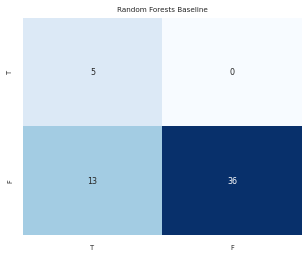

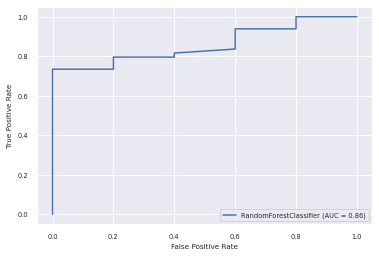

This is the starting index: 530 of patient 12
0.7222222222222222
[(1, 1, array([0.25, 0.75])), (1, 0, array([0.76, 0.24])), (1, 0, array([0.74, 0.26])), (1, 1, array([0.48, 0.52])), (1, 0, array([0.77, 0.23])), (1, 1, array([0.46, 0.54])), (1, 1, array([0.12, 0.88])), (0, 0, array([0.64, 0.36])), (0, 0, array([0.79, 0.21])), (1, 0, array([0.85, 0.15])), (1, 1, array([0.13, 0.87])), (1, 1, array([0.31, 0.69])), (1, 0, array([0.87, 0.13])), (1, 1, array([0.18, 0.82])), (1, 1, array([0.08, 0.92])), (1, 0, array([0.61, 0.39])), (1, 1, array([0.15, 0.85])), (1, 1, array([0.06, 0.94])), (1, 1, array([0.15, 0.85])), (1, 0, array([0.54, 0.46])), (1, 1, array([0.19, 0.81])), (1, 1, array([0.1, 0.9])), (1, 0, array([0.79, 0.21])), (1, 1, array([0.1, 0.9])), (1, 0, array([0.64, 0.36])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.08, 0.92])), (1, 0, array([0.64, 0.36])), (1, 1, array([0.16, 0.84])), (1, 1, array([0.37, 0.63])), (1, 1, array([0.17, 0.83])), (1, 1, array([0.33, 0.67])), (1, 1, arr

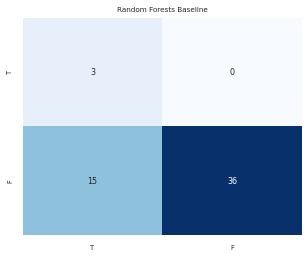

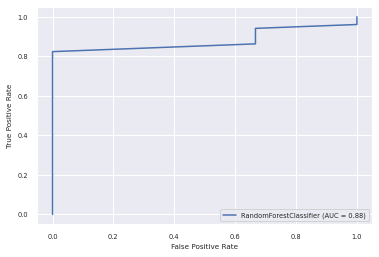

<function matplotlib.pyplot.show>

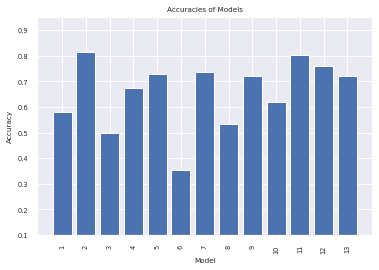

In [16]:
Accuracy = []

clf = AdaBoostClassifier()

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(train, train_class.ravel())
    model = SelectFromModel(clf, prefit=True)
    train = model.transform(train)
    # clf = ExtraTreesClassifier(n_estimators=50)
    # clf = clf.fit(test, test_class.ravel())
    # model = SelectFromModel(clf, prefit=True) 

    test = model.transform(test)
    clf = RandomForestClassifier()
    clf.fit(train, train_class.ravel())


    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### Auto Sklearn Recommendation

In [ ]:
#SVM with manual parameters
svm = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                         ('svm', SGDClassifier(loss='hinge', alpha=1e-3, random_state=42)),])

SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'extra_trees_preproc_for_classification', 'classifier:random_forest:bootstrap': 'False', 'classifier:random_forest:criterion': 'entropy', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.27453376891983117, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 13, 'classifier:random_forest:min_samples_split': 19, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.2166847947584762, 'feature_preprocessor:extra_trees_preproc_for_classification:bootstrap': 'False', 'feature_preprocessor:extra_trees_preproc_for_classification:criterion': 'entropy', 'feature_preprocessor:extra_trees_preproc_for_classification:max_depth': 'None', 'feature_preprocessor:extra_trees_preproc_for_classification:max_features': 0.2819773130241576, 'feature_preprocessor:extra_trees_preproc_for_classification:max_leaf_nodes': 'None', 'feature_preprocessor:extra_trees_preproc_for_classification:min_impurity_decrease': 0.0, 'feature_preprocessor:extra_trees_preproc_for_classification:min_samples_leaf': 20, 'feature_preprocessor:extra_trees_preproc_for_classification:min_samples_split': 3, 'feature_preprocessor:extra_trees_preproc_for_classification:min_weight_fraction_leaf': 0.0, 'feature_preprocessor:extra_trees_preproc_for_classification:n_estimators': 100},
d

### LDA (LinearDiscriminantAnalysis)

#### Baseline

This is the starting index: 0 of patient 0
0.48
[(1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 4.29783344e-69])), (0, 0, array([1.00000000e+00, 4.41158074e-26])), (1, 0, array([1.00000000e+00, 8.25659854e-37])), (1, 1, array([0., 1.])), (1, 1, array([2.8603786e-12, 1.0000000e+00])), (1, 1, array([1.77635684e-15, 1.00000000e+00])), (1, 0, array([1.00000000e+00, 1.04025325e-21])), (0, 0, array([1.00000000e+000, 1.00038408e-207])), (1, 0, array([1., 0.])), (1, 1, array([6.49493792e-11, 1.00000000e+00])), (0, 1, array([0., 1.])), (1, 0, array([0.99323958, 0.00676042])), (0, 0, array([1.00000000e+000, 2.93634826e-128])), (1, 0, array([1.00000000e+00, 1.04031127e-33])), (1, 0, array([1.00000000e+00, 3.43406404e-17])), (1, 0, array([1.00000000e+00, 4.55766641e-98])), (1, 0, array([1.00000000e+00, 6.85130828e-49])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 4.05659964e-57])), (1, 0, array([1.0000000e+00, 5.2790754e-24])), (1, 1, array([0., 1.])), 

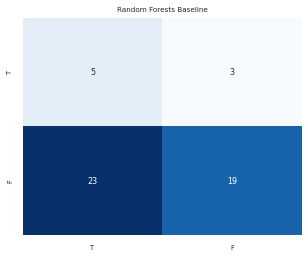

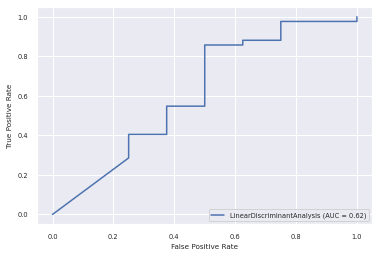

This is the starting index: 51 of patient 1
0.6666666666666666
[(0, 1, array([0., 1.])), (0, 0, array([1.00000000e+000, 1.63517534e-100])), (0, 0, array([9.99817109e-01, 1.82890504e-04])), (0, 0, array([1.00000000e+00, 2.52702251e-36])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+000, 3.46972509e-155])), (0, 0, array([1.00000000e+000, 2.47257873e-108])), (0, 0, array([1.00000000e+000, 8.30443762e-102])), (0, 0, array([1.00000000e+000, 3.32192897e-211])), (0, 0, array([1.00000000e+000, 3.85654764e-167])), (0, 0, array([1.00000000e+000, 3.09369659e-101])), (0, 0, array([1.00000000e+00, 1.97816283e-42])), (0, 0, array([1.00000000e+00, 2.35123471e-31])), (0, 0, array([1.00000000e+00, 5.81775594e-67])), (0, 0, array([1.00000000e+00, 9.76859141e-54])), (0, 1, array([2.87881496e-10, 1.00000000e+00])), (0, 0, array([1.00000000e+00, 3.96452435e-33])), (0, 1, array([1.42397205e-12, 1.00000000e+00])), (0, 0, array(

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


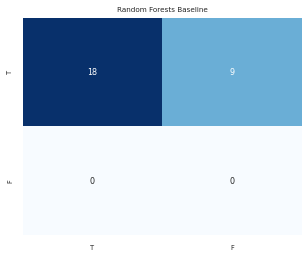

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


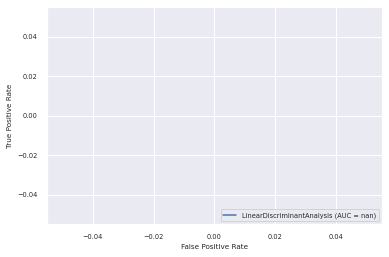

This is the starting index: 79 of patient 2
0.6428571428571429
[(0, 1, array([0., 1.])), (0, 0, array([1.000000e+00, 2.674115e-15])), (1, 1, array([5.61411876e-07, 9.99999439e-01])), (0, 0, array([1.00000000e+000, 6.79141553e-115])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+000, 4.26434697e-137])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([7.11787938e-07, 9.99999288e-01])), (1, 1, array([0., 1.])), (1, 1, array([2.22044605e-15, 1.00000000e+00])), (0, 0, array([1.00000000e+00, 1.57976412e-33])), (1, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 1.15005435e-98])), (1, 0, array([9.99918141e-01, 8.18591809e-05])), (0, 0, array([1.00000000e+00, 1.86044049e-65])), (0, 0, array([1.00000000e+00, 1.04270082e-16])), (0, 1, array([0., 1.])), (0, 0, array([9.99996533e-01, 3.46674323e-06])), (0, 0, array([1.00000000e+00, 1.84892062e-76])), (0, 1, array([0.09395608, 0.90604392])), (0, 0, array([1.00000000e+00, 2.97307396e-29])), (1, 1, ar

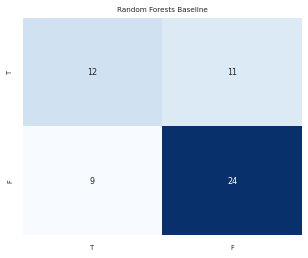

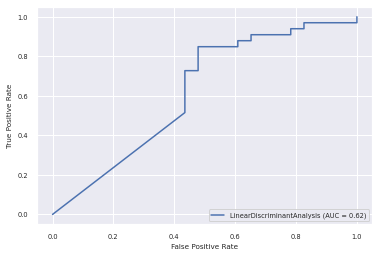

This is the starting index: 136 of patient 3
0.4594594594594595
[(1, 1, array([0., 1.])), (1, 0, array([1., 0.])), (1, 0, array([1.00000000e+000, 8.06259061e-238])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 2.47247388e-62])), (1, 0, array([1.00000000e+00, 1.45699882e-68])), (1, 0, array([1.00000000e+00, 1.81571713e-80])), (0, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 6.58179676e-38])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 7.94530315e-43])), (1, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+000, 4.46784136e-102])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+000, 4.11834758e-134])), (0, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 4.41229789e-14])), (0, 1, array([0., 1.])), (1, 1, array([0., 1.])), (0, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 4.21538379e-59])), (1, 1, array([

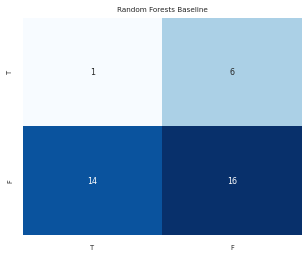

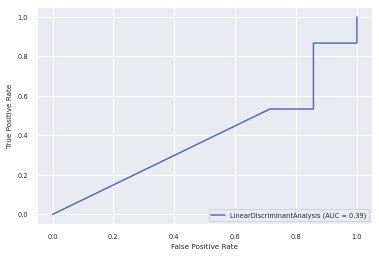

This is the starting index: 174 of patient 4
0.5135135135135135
[(0, 0, array([1.00000000e+00, 6.11396694e-25])), (0, 1, array([0., 1.])), (1, 0, array([9.99999995e-01, 5.04169531e-09])), (0, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 1.85816449e-20])), (0, 1, array([0., 1.])), (1, 0, array([9.99999971e-01, 2.92849240e-08])), (0, 0, array([1.00000000e+00, 1.13649085e-61])), (1, 0, array([1.00000000e+000, 9.37318802e-113])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+000, 9.51829365e-138])), (0, 1, array([0., 1.])), (0, 0, array([1.0000000e+00, 6.2534541e-85])), (0, 0, array([1., 0.])), (0, 0, array([1.00000000e+00, 1.82618778e-60])), (1, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 3.35575265e-72])), (0, 0, array([1.00000000e+000, 1.19211072e-122])), (1, 0, array([1.00000000e+00, 4.42091234e-12])), (0, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 5.35704675e-4

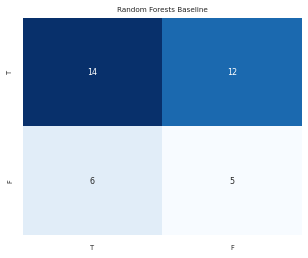

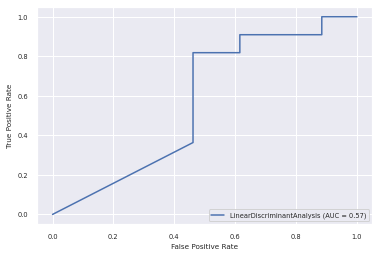

This is the starting index: 212 of patient 5
0.47058823529411764
[(1, 0, array([9.99999208e-01, 7.92206088e-07])), (1, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 2.66033648e-58])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 9.81441481e-16])), (0, 1, array([7.76827491e-11, 1.00000000e+00])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 7.54380773e-27])), (0, 0, array([1.00000000e+00, 2.79533596e-13])), (0, 1, array([0., 1.])), (0, 1, array([0.00257171, 0.99742829])), (0, 0, array([0.9891629, 0.0108371])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 2.16090766e-41])), (0, 0, array([1.00000000e+00, 1.49823525e-12])), (0, 1, array([0., 1.])), (0, 0, array([9.99953739e-01, 4.62606245e-05])), (0, 0, array([1.00000000e+00, 3.15985728e-49])), (0, 1, array([4.04379056e-08, 9.99999960e-01])), (0, 1, array([0., 1.])), (0, 0, array([1

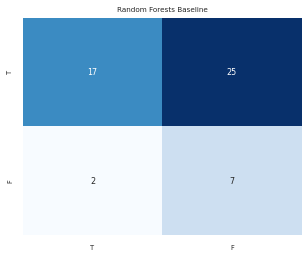

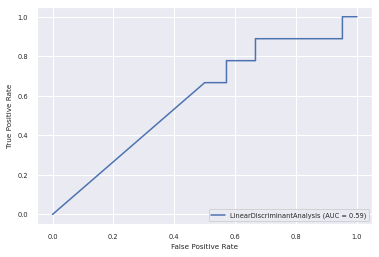

This is the starting index: 264 of patient 6
0.5263157894736842
[(0, 0, array([1.00000000e+00, 2.21030029e-41])), (0, 0, array([1.00000000e+00, 7.16699853e-19])), (1, 0, array([0.90863756, 0.09136244])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+000, 2.21541672e-137])), (1, 0, array([1.00000000e+00, 7.53763579e-12])), (0, 0, array([1.00000000e+00, 2.61373423e-36])), (0, 1, array([0., 1.])), (1, 1, array([0.03215582, 0.96784418])), (0, 0, array([1.00000000e+00, 1.26045217e-15])), (1, 0, array([9.99999999e-01, 1.25691719e-09])), (0, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 9.80132084e-23])), (1, 1, array([4.4408921e-16, 1.0000000e+00])), (0, 1, array([0., 1.])), (1, 1, array([3.32400774e-13, 1.00000000e+00])), (1, 1, array([0., 1.])), (0, 0, array([0.97765533, 0.02234467])), (0, 1, array([0., 1.]))]


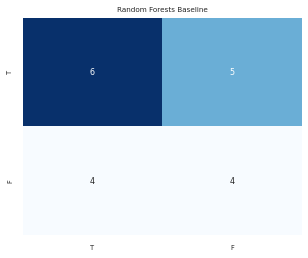

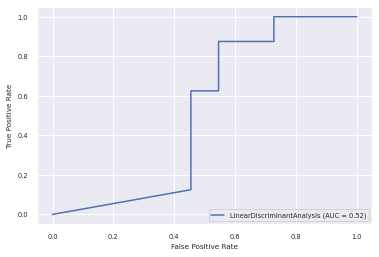

This is the starting index: 284 of patient 7
0.7333333333333333
[(0, 0, array([1.00000000e+00, 1.12648641e-23])), (0, 0, array([1., 0.])), (0, 1, array([0., 1.])), (0, 0, array([1., 0.])), (0, 0, array([1., 0.])), (0, 0, array([1., 0.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+000, 8.93016165e-180])), (0, 1, array([0., 1.])), (1, 1, array([2.74810086e-09, 9.99999997e-01])), (0, 0, array([1.00000000e+000, 2.41097659e-162])), (0, 0, array([9.99951541e-01, 4.84588851e-05])), (0, 0, array([1., 0.])), (0, 0, array([1., 0.]))]


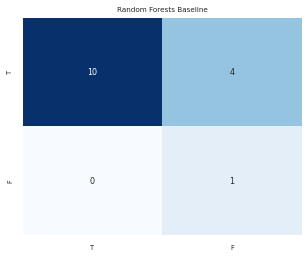

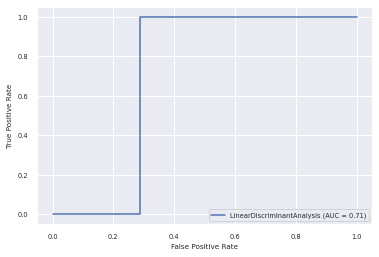

This is the starting index: 300 of patient 8
0.5116279069767442
[(0, 0, array([1.00000000e+00, 5.15119921e-70])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 3.92027194e-20])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([0.77895381, 0.22104619])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 6.41487348e-21])), (0, 0, array([1.00000000e+00, 5.17426526e-74])), (0, 1, array([5.06257401e-04, 9.99493743e-01])), (0, 0, array([1.00000000e+00, 4.17232605e-57])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 2.41125669e-48])), (0, 0, array([1.00000000e+00, 2.75902586e-61])), (1, 0, array([1.00000000e+00, 1.81874566e-40])), (0, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 5.30343001e-34])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (1, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 1.47064558e-70])), (1, 0, array([1.00000000e+000, 9.80651176e-133])), (1, 0, array([1.0000000e+00, 7.5133763e-24])), (1, 1, 

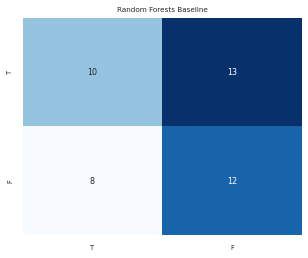

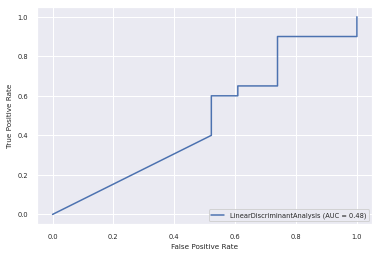

This is the starting index: 344 of patient 9
0.47619047619047616
[(1, 1, array([0., 1.])), (1, 1, array([2.47446508e-12, 1.00000000e+00])), (0, 1, array([6.66133815e-16, 1.00000000e+00])), (1, 0, array([1.00000000e+000, 1.75619604e-142])), (1, 0, array([1.00000000e+00, 9.84883156e-21])), (1, 0, array([1.00000000e+00, 4.74450279e-25])), (1, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 4.25760205e-58])), (0, 0, array([1.00000000e+00, 1.18874917e-17])), (0, 0, array([1.00000000e+00, 1.12247354e-28])), (0, 0, array([1.00000000e+00, 6.36431771e-19])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 4.43830642e-67])), (0, 1, array([7.86479244e-05, 9.99921352e-01])), (0, 0, array([1.00000000e+00, 4.31811785e-19])), (1, 0, array([1.00000000e+00, 3.26698114e-49])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.0000000e+00, 1.8829092e-44])), (0, 0, array([1.00000000e+00, 1.43145264e-88])),

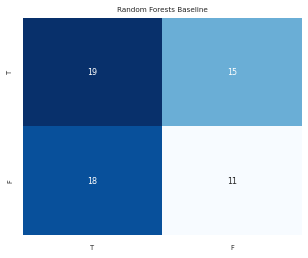

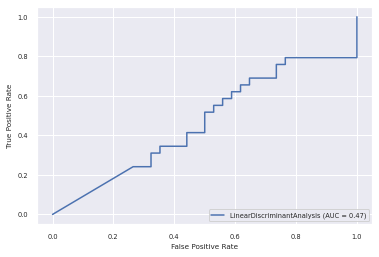

This is the starting index: 408 of patient 10
0.7121212121212122
[(1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([9.99999642e-01, 3.58459215e-07])), (1, 1, array([2.59572059e-08, 9.99999974e-01])), (1, 1, array([0., 1.])), (0, 1, array([0.15795679, 0.84204321])), (0, 0, array([1.00000000e+00, 2.71994705e-63])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (0, 1, array([1.64535052e-13, 1.00000000e+00])), (1, 1, array([0., 1.])), (1, 1, array([2.88810864e-09, 9.99999997e-01])), (0, 1, array([0., 1.])), (1, 1, array([1.13242749e-14, 1.00000000e+00])), (0, 1, array([2.85795831e-11, 1.00000000e+00])), (1, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 3.42661519e-18])), (1, 1, array([1.56474877e-09, 9.99999998e-01])), (1, 1, array([2.11877480e-07, 9.99999788e-01])), (0, 0, array([1.00000000e+00, 1.94890368e-16])), (1, 

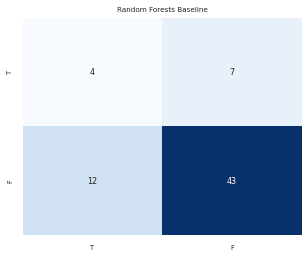

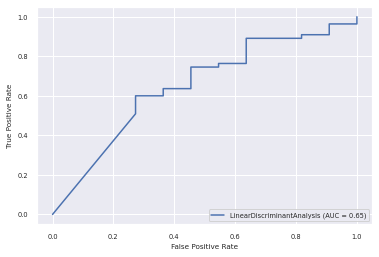

This is the starting index: 475 of patient 11
0.5370370370370371
[(0, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 1.07238448e-53])), (1, 0, array([1.00000000e+00, 1.63548476e-52])), (0, 0, array([0.55324324, 0.44675676])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 2.97547612e-54])), (1, 1, array([3.55271368e-15, 1.00000000e+00])), (1, 0, array([1.00000000e+00, 1.55576037e-11])), (1, 0, array([1.00000000e+00, 4.74010399e-17])), (1, 1, array([0., 1.])), (0, 1, array([0., 1.])), (1, 0, array([0.9304323, 0.0695677])), (1, 1, array([0., 1.])), (1, 0, array([1.0000000e+00, 8.0871651e-13])), (1, 1, array([8.95483687e-12, 1.00000000e+00])), (1, 1, array([0., 1.])), (1, 0, array([9.99999992e-01, 8.21489547e-09])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+000, 1.85176684e-151])), (1, 0, array([1.00000000e+00, 2.62694476e-32])), (1, 0, array([1.00000000e+00, 9.47777195e-12])), (1, 1, array([6.16773743e-10, 9.99999999e-01])), (1, 0, array([1.0

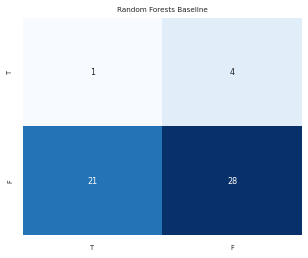

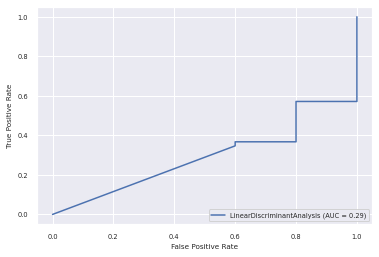

This is the starting index: 530 of patient 12
0.6481481481481481
[(1, 0, array([1.00000000e+000, 3.03235939e-251])), (1, 0, array([9.99999399e-01, 6.01131139e-07])), (1, 0, array([9.99999697e-01, 3.03083209e-07])), (1, 1, array([0., 1.])), (1, 0, array([9.99999998e-01, 1.78064439e-09])), (1, 0, array([1.00000000e+00, 2.93402726e-12])), (1, 1, array([0., 1.])), (0, 0, array([1.0000000e+00, 6.2116706e-49])), (0, 0, array([1.0000000e+00, 1.7460314e-43])), (1, 1, array([0., 1.])), (1, 1, array([5.55111512e-15, 1.00000000e+00])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 4.97363815e-20])), (1, 1, array([1.91434287e-08, 9.99999981e-01])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 8.08708721e-27])), (1, 1, array([0., 1.])), (1, 1, array([0.00217934, 0.99782066])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 6.71146108e-31])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 1.38662779e-36])), (1, 1, array([0., 1.])), (1, 0, a

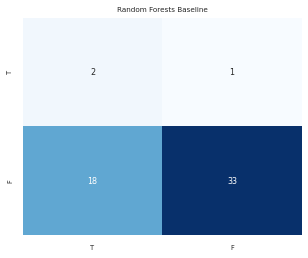

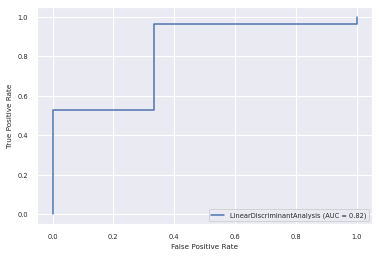

<function matplotlib.pyplot.show>

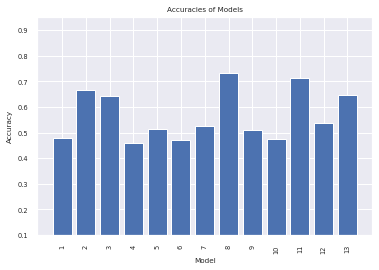

In [17]:
Accuracy = []

clf = LinearDiscriminantAnalysis()

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result) 
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### GridSearch

In [18]:
parameters = {
    'solver'      : ['svd', 'lsqr', 'eigen'],
    'shrinkage'         : ['auto'],
    # 'random_state'      : [0],
    #'max_features': ['auto'],
    #'criterion' :['gini']
}


for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    search = GridSearchCV(LinearDiscriminantAnalysis(), parameters, cv=10, n_jobs=-1)
    search.fit(train, train_class.ravel())

    print(search.score(train, train_class.ravel()))
    print(search.best_params_)

This is the starting index: 0 of patient 0
0.8859813084112149
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 51 of patient 1
0.8799283154121864
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 79 of patient 2
0.8941398865784499
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 136 of patient 3
0.885036496350365
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 174 of patient 4
0.906934306569343
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 212 of patient 5
0.9176029962546817
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 264 of patient 6
0.8886925795053003
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 284 of patient 7
0.8701754385964913
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 300 of patient 8
0.8837638376383764
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 344 of patient 9
0.8984674329501916
{'shri

This is the starting index: 0 of patient 0
0.64
[(1, 0, array([9.99999677e-01, 3.23167435e-07])), (1, 1, array([0.01753033, 0.98246967])), (1, 1, array([0.03201965, 0.96798035])), (0, 1, array([0.24696776, 0.75303224])), (1, 0, array([0.8546559, 0.1453441])), (1, 0, array([0.99526128, 0.00473872])), (1, 1, array([0.02946891, 0.97053109])), (1, 1, array([0.00751565, 0.99248435])), (1, 0, array([0.96795781, 0.03204219])), (0, 1, array([0.03720132, 0.96279868])), (1, 1, array([3.23231813e-04, 9.99676768e-01])), (1, 0, array([0.594417, 0.405583])), (0, 1, array([0.1926118, 0.8073882])), (1, 1, array([9.34165620e-04, 9.99065834e-01])), (0, 0, array([9.99694334e-01, 3.05666390e-04])), (1, 1, array([0.0204652, 0.9795348])), (1, 0, array([9.99993494e-01, 6.50640712e-06])), (1, 1, array([0.23118366, 0.76881634])), (1, 1, array([0.00853893, 0.99146107])), (1, 1, array([0.1349814, 0.8650186])), (1, 1, array([0.23791319, 0.76208681])), (1, 1, array([0.04370443, 0.95629557])), (1, 1, array([0.02138

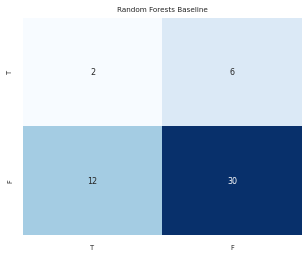

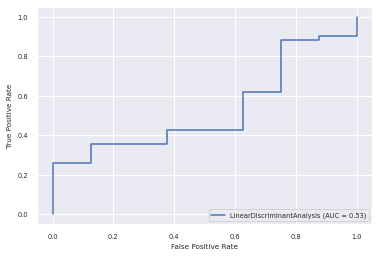

This is the starting index: 51 of patient 1
0.8148148148148148
[(0, 1, array([0.12181144, 0.87818856])), (0, 0, array([0.99785613, 0.00214387])), (0, 0, array([0.62927695, 0.37072305])), (0, 0, array([0.90719796, 0.09280204])), (0, 0, array([0.8208042, 0.1791958])), (0, 0, array([0.99750309, 0.00249691])), (0, 1, array([0.37487222, 0.62512778])), (0, 0, array([9.99870624e-01, 1.29375973e-04])), (0, 0, array([0.91258549, 0.08741451])), (0, 0, array([9.99103967e-01, 8.96033164e-04])), (0, 0, array([0.50724812, 0.49275188])), (0, 1, array([0.38905792, 0.61094208])), (0, 0, array([0.97732889, 0.02267111])), (0, 0, array([0.9927004, 0.0072996])), (0, 0, array([9.99871760e-01, 1.28240471e-04])), (0, 0, array([0.99820491, 0.00179509])), (0, 0, array([0.99130419, 0.00869581])), (0, 0, array([0.98776303, 0.01223697])), (0, 0, array([0.93948258, 0.06051742])), (0, 0, array([0.99532801, 0.00467199])), (0, 0, array([0.73988078, 0.26011922])), (0, 0, array([0.9970668, 0.0029332])), (0, 0, array([0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


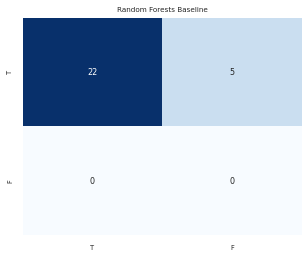

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


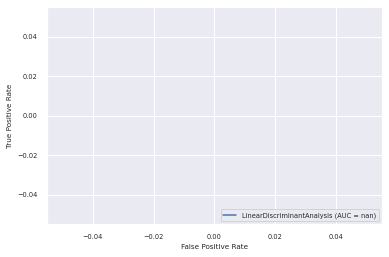

This is the starting index: 79 of patient 2
0.6071428571428571
[(0, 0, array([0.84149076, 0.15850924])), (0, 0, array([0.95414166, 0.04585834])), (1, 1, array([0.15378729, 0.84621271])), (0, 0, array([0.99726226, 0.00273774])), (1, 0, array([0.58450601, 0.41549399])), (1, 0, array([0.99586458, 0.00413542])), (1, 0, array([0.72825796, 0.27174204])), (1, 1, array([0.09328512, 0.90671488])), (1, 0, array([0.80014654, 0.19985346])), (1, 1, array([0.44786116, 0.55213884])), (1, 1, array([0.22462408, 0.77537592])), (0, 0, array([0.6458533, 0.3541467])), (1, 0, array([0.59981322, 0.40018678])), (0, 0, array([0.92247543, 0.07752457])), (0, 0, array([0.97248992, 0.02751008])), (1, 1, array([0.10585715, 0.89414285])), (0, 0, array([9.99137216e-01, 8.62784079e-04])), (0, 0, array([9.99136803e-01, 8.63197368e-04])), (0, 0, array([0.99301578, 0.00698422])), (0, 0, array([0.60644801, 0.39355199])), (0, 0, array([0.99478239, 0.00521761])), (0, 1, array([0.14830592, 0.85169408])), (0, 1, array([0.4888

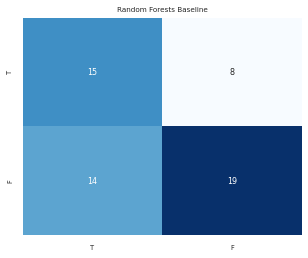

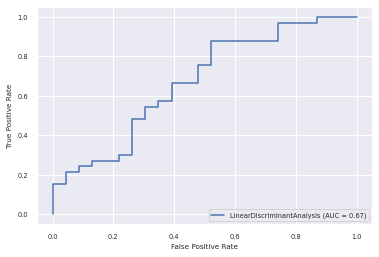

This is the starting index: 136 of patient 3
0.7027027027027027
[(1, 1, array([0.02715524, 0.97284476])), (1, 1, array([3.30457711e-06, 9.99996695e-01])), (1, 1, array([0.30638214, 0.69361786])), (1, 0, array([0.55706217, 0.44293783])), (1, 1, array([0.00545213, 0.99454787])), (1, 1, array([0.02664424, 0.97335576])), (1, 0, array([0.68834173, 0.31165827])), (1, 1, array([0.04526749, 0.95473251])), (0, 1, array([0.3138822, 0.6861178])), (1, 1, array([6.02498695e-09, 9.99999994e-01])), (1, 1, array([0.01744985, 0.98255015])), (1, 1, array([0.01071226, 0.98928774])), (1, 1, array([0.00770963, 0.99229037])), (1, 1, array([0.16280356, 0.83719644])), (1, 1, array([0.01150993, 0.98849007])), (1, 1, array([0.29229904, 0.70770096])), (0, 1, array([2.75143953e-05, 9.99972486e-01])), (0, 1, array([0.01621509, 0.98378491])), (1, 1, array([5.69663838e-04, 9.99430336e-01])), (1, 1, array([0.00775175, 0.99224825])), (1, 0, array([9.99946266e-01, 5.37339472e-05])), (0, 1, array([0.03298449, 0.96701551

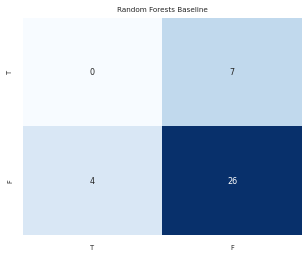

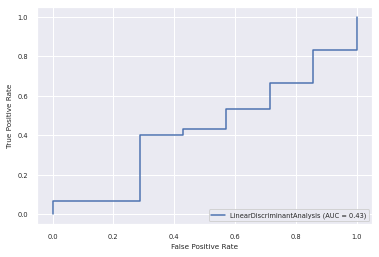

This is the starting index: 174 of patient 4
0.5135135135135135
[(0, 1, array([0.10983708, 0.89016292])), (0, 1, array([0.24936266, 0.75063734])), (1, 1, array([0.01013997, 0.98986003])), (0, 0, array([0.80414432, 0.19585568])), (1, 0, array([0.83751471, 0.16248529])), (0, 0, array([9.99619407e-01, 3.80593444e-04])), (1, 1, array([0.00787829, 0.99212171])), (0, 0, array([0.5966132, 0.4033868])), (1, 0, array([0.99625936, 0.00374064])), (0, 1, array([0.04317589, 0.95682411])), (0, 1, array([0.05574706, 0.94425294])), (0, 1, array([0.29559071, 0.70440929])), (0, 0, array([0.81132576, 0.18867424])), (0, 0, array([0.84309781, 0.15690219])), (0, 0, array([9.99999605e-01, 3.94768081e-07])), (0, 1, array([0.45691699, 0.54308301])), (1, 1, array([0.02462561, 0.97537439])), (0, 1, array([0.14483554, 0.85516446])), (0, 1, array([0.07470594, 0.92529406])), (0, 1, array([0.4708234, 0.5291766])), (0, 1, array([0.03531658, 0.96468342])), (0, 0, array([0.97285249, 0.02714751])), (1, 1, array([0.04389

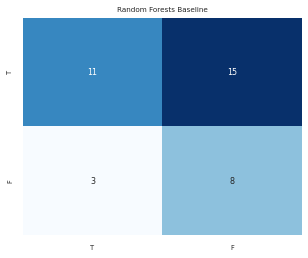

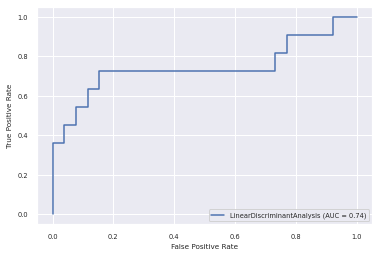

This is the starting index: 212 of patient 5
0.3137254901960784
[(1, 0, array([0.98833204, 0.01166796])), (1, 1, array([0.05829492, 0.94170508])), (0, 1, array([0.15805056, 0.84194944])), (0, 1, array([0.02146899, 0.97853101])), (0, 1, array([0.03523217, 0.96476783])), (0, 1, array([6.61290783e-04, 9.99338709e-01])), (0, 1, array([0.16742837, 0.83257163])), (0, 1, array([0.16837923, 0.83162077])), (0, 1, array([0.07593886, 0.92406114])), (0, 1, array([0.04197444, 0.95802556])), (0, 1, array([0.02700905, 0.97299095])), (0, 1, array([0.05498862, 0.94501138])), (0, 1, array([0.03886236, 0.96113764])), (0, 1, array([0.1360455, 0.8639545])), (0, 1, array([0.00668727, 0.99331273])), (0, 1, array([0.05199311, 0.94800689])), (0, 1, array([0.01385381, 0.98614619])), (0, 0, array([0.82282685, 0.17717315])), (0, 1, array([0.05694828, 0.94305172])), (0, 0, array([0.53191145, 0.46808855])), (0, 1, array([0.04612472, 0.95387528])), (0, 1, array([0.37328973, 0.62671027])), (0, 1, array([0.00632716, 0

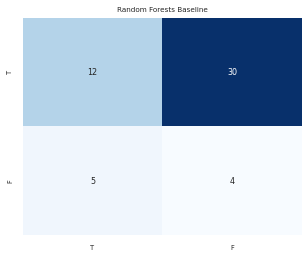

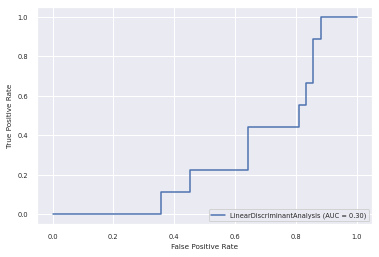

This is the starting index: 264 of patient 6
0.6842105263157895
[(0, 0, array([0.95886318, 0.04113682])), (0, 0, array([0.65340328, 0.34659672])), (1, 1, array([0.13780664, 0.86219336])), (0, 1, array([0.03326026, 0.96673974])), (0, 0, array([0.96898604, 0.03101396])), (1, 1, array([0.35389223, 0.64610777])), (0, 1, array([0.18408284, 0.81591716])), (0, 1, array([0.4773645, 0.5226355])), (1, 1, array([0.15473516, 0.84526484])), (0, 0, array([0.96473467, 0.03526533])), (1, 1, array([0.04857612, 0.95142388])), (0, 1, array([0.20988028, 0.79011972])), (1, 1, array([0.28773491, 0.71226509])), (1, 1, array([0.08640391, 0.91359609])), (0, 1, array([0.34461504, 0.65538496])), (1, 1, array([0.17066103, 0.82933897])), (1, 1, array([0.02267249, 0.97732751])), (0, 1, array([0.43336324, 0.56663676])), (0, 0, array([0.73808514, 0.26191486]))]


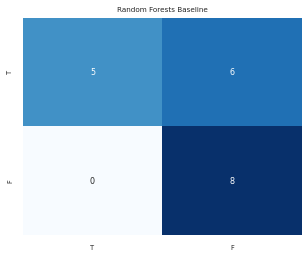

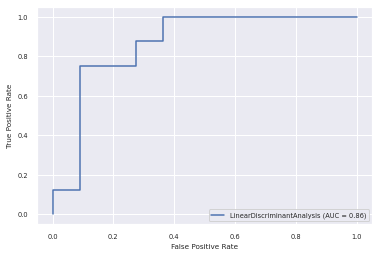

This is the starting index: 284 of patient 7
0.6666666666666666
[(0, 0, array([0.98749599, 0.01250401])), (0, 0, array([0.99586046, 0.00413954])), (0, 1, array([0.00459043, 0.99540957])), (0, 0, array([0.99553844, 0.00446156])), (0, 0, array([1.00000000e+00, 9.73893901e-12])), (0, 0, array([0.99489515, 0.00510485])), (0, 1, array([2.01615230e-04, 9.99798385e-01])), (0, 1, array([0.24011027, 0.75988973])), (0, 0, array([0.58002032, 0.41997968])), (0, 1, array([0.32296011, 0.67703989])), (1, 1, array([0.01374105, 0.98625895])), (0, 0, array([9.99981067e-01, 1.89332643e-05])), (0, 1, array([0.01063193, 0.98936807])), (0, 0, array([9.99991879e-01, 8.12074159e-06])), (0, 0, array([0.96129288, 0.03870712]))]


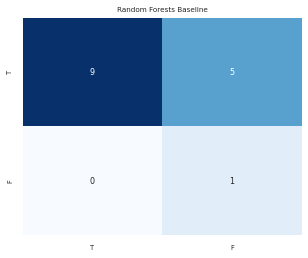

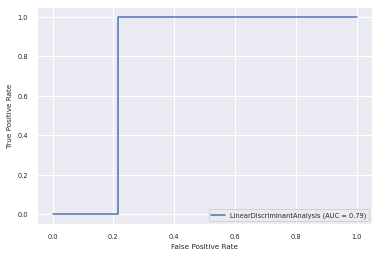

This is the starting index: 300 of patient 8
0.7441860465116279
[(0, 0, array([0.96360847, 0.03639153])), (0, 0, array([0.56776266, 0.43223734])), (0, 0, array([0.75112116, 0.24887884])), (0, 1, array([0.13324943, 0.86675057])), (0, 1, array([0.22809418, 0.77190582])), (0, 0, array([0.76677377, 0.23322623])), (0, 1, array([0.07929996, 0.92070004])), (0, 0, array([0.82151649, 0.17848351])), (0, 1, array([0.28878554, 0.71121446])), (0, 1, array([0.42689615, 0.57310385])), (0, 1, array([0.04223265, 0.95776735])), (0, 0, array([0.93343003, 0.06656997])), (0, 0, array([0.93838356, 0.06161644])), (0, 0, array([9.99791010e-01, 2.08990113e-04])), (1, 1, array([0.20930665, 0.79069335])), (0, 1, array([0.0856881, 0.9143119])), (1, 1, array([0.01105231, 0.98894769])), (1, 1, array([0.01897273, 0.98102727])), (0, 0, array([0.9386492, 0.0613508])), (0, 0, array([0.99672452, 0.00327548])), (1, 1, array([0.01981114, 0.98018886])), (0, 0, array([0.65477011, 0.34522989])), (1, 1, array([0.03316436, 0.9

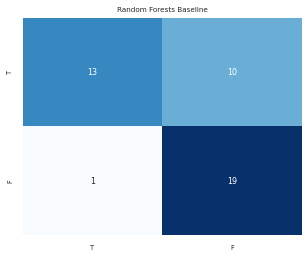

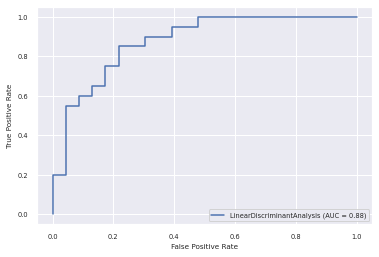

This is the starting index: 344 of patient 9
0.5396825396825397
[(1, 0, array([0.65151964, 0.34848036])), (1, 0, array([0.99176065, 0.00823935])), (0, 0, array([0.89787154, 0.10212846])), (1, 1, array([0.01056316, 0.98943684])), (1, 0, array([0.75614176, 0.24385824])), (1, 0, array([0.98140411, 0.01859589])), (1, 0, array([0.96787955, 0.03212045])), (0, 1, array([1.39184630e-05, 9.99986082e-01])), (0, 0, array([0.95055913, 0.04944087])), (0, 0, array([0.96845745, 0.03154255])), (0, 0, array([0.59560882, 0.40439118])), (0, 0, array([0.98713892, 0.01286108])), (0, 0, array([9.99559156e-01, 4.40844423e-04])), (0, 1, array([0.39873756, 0.60126244])), (0, 0, array([0.99724071, 0.00275929])), (0, 0, array([0.87579205, 0.12420795])), (0, 1, array([0.39074447, 0.60925553])), (1, 0, array([0.79634422, 0.20365578])), (0, 0, array([0.54097986, 0.45902014])), (0, 0, array([0.73920169, 0.26079831])), (1, 0, array([0.69532231, 0.30467769])), (1, 0, array([0.98062152, 0.01937848])), (0, 1, array([0.0

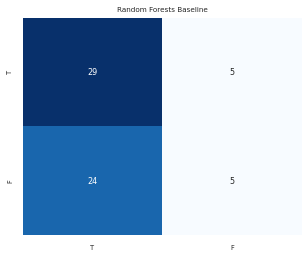

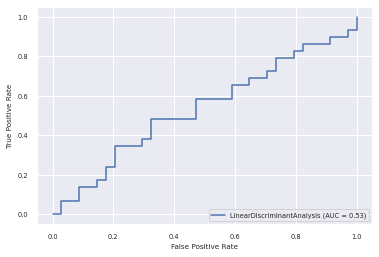

This is the starting index: 408 of patient 10
0.8333333333333334
[(1, 1, array([0.14870149, 0.85129851])), (1, 1, array([0.0137042, 0.9862958])), (1, 1, array([0.00999664, 0.99000336])), (1, 1, array([0.01984028, 0.98015972])), (1, 1, array([0.11294787, 0.88705213])), (1, 1, array([0.03306813, 0.96693187])), (1, 1, array([0.01574837, 0.98425163])), (1, 1, array([0.05011076, 0.94988924])), (1, 1, array([0.03461477, 0.96538523])), (0, 1, array([0.41531104, 0.58468896])), (0, 1, array([1.74608451e-05, 9.99982539e-01])), (1, 1, array([0.0465266, 0.9534734])), (1, 1, array([0.07199533, 0.92800467])), (1, 1, array([0.00145125, 0.99854875])), (1, 1, array([0.04793281, 0.95206719])), (0, 0, array([0.78408994, 0.21591006])), (1, 0, array([0.61668165, 0.38331835])), (1, 1, array([0.48291802, 0.51708198])), (0, 0, array([0.69356174, 0.30643826])), (1, 1, array([0.00419658, 0.99580342])), (0, 1, array([0.08118177, 0.91881823])), (1, 0, array([0.67768499, 0.32231501])), (0, 0, array([9.99225248e-01

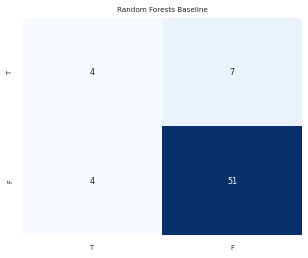

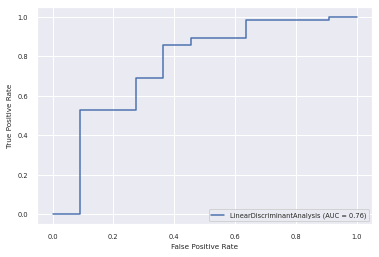

This is the starting index: 475 of patient 11
0.7407407407407407
[(0, 0, array([0.93201905, 0.06798095])), (1, 1, array([0.04202819, 0.95797181])), (1, 1, array([1.47951420e-07, 9.99999852e-01])), (1, 1, array([0.01492798, 0.98507202])), (0, 1, array([0.45388779, 0.54611221])), (1, 1, array([0.04832913, 0.95167087])), (1, 0, array([0.5569437, 0.4430563])), (1, 1, array([0.07027378, 0.92972622])), (1, 1, array([0.0625128, 0.9374872])), (1, 1, array([0.04020696, 0.95979304])), (1, 1, array([0.14242827, 0.85757173])), (0, 1, array([0.38825841, 0.61174159])), (1, 1, array([0.06141228, 0.93858772])), (1, 1, array([0.20111392, 0.79888608])), (1, 0, array([0.55227877, 0.44772123])), (1, 1, array([0.18418363, 0.81581637])), (1, 1, array([0.02900225, 0.97099775])), (1, 1, array([0.09684308, 0.90315692])), (1, 1, array([0.20770537, 0.79229463])), (1, 1, array([4.61245075e-05, 9.99953875e-01])), (1, 1, array([0.25609609, 0.74390391])), (1, 1, array([0.23857694, 0.76142306])), (1, 1, array([0.0890

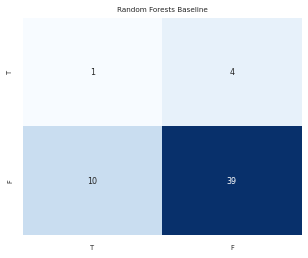

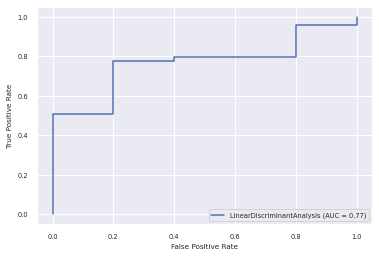

This is the starting index: 530 of patient 12
0.7777777777777778
[(1, 1, array([0.28300195, 0.71699805])), (1, 0, array([0.90844837, 0.09155163])), (1, 1, array([0.40455914, 0.59544086])), (1, 1, array([0.01533782, 0.98466218])), (1, 0, array([0.99082476, 0.00917524])), (1, 0, array([0.96772123, 0.03227877])), (1, 1, array([0.03501233, 0.96498767])), (0, 0, array([0.98654427, 0.01345573])), (0, 0, array([0.99019999, 0.00980001])), (1, 0, array([9.99800592e-01, 1.99408256e-04])), (1, 1, array([0.05753222, 0.94246778])), (1, 1, array([0.1649546, 0.8350454])), (1, 0, array([0.96604566, 0.03395434])), (1, 1, array([0.34667281, 0.65332719])), (1, 1, array([0.04607317, 0.95392683])), (1, 0, array([0.65480809, 0.34519191])), (1, 1, array([0.06585048, 0.93414952])), (1, 1, array([0.02705541, 0.97294459])), (1, 1, array([0.03629912, 0.96370088])), (1, 0, array([0.67481772, 0.32518228])), (1, 1, array([0.17312658, 0.82687342])), (1, 1, array([0.00706584, 0.99293416])), (1, 1, array([0.35638011, 

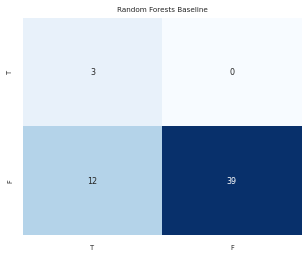

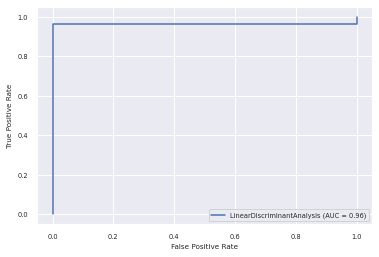

<function matplotlib.pyplot.show>

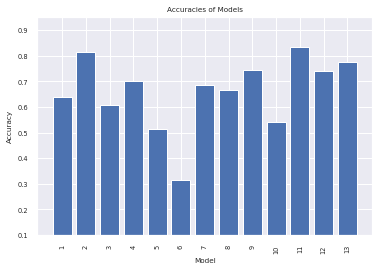

In [19]:
Accuracy = []
clf = LinearDiscriminantAnalysis(shrinkage= 'auto', solver= 'lsqr')

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### Low Variance

This is the starting index: 0 of patient 0
0.48
[(1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 4.29783344e-69])), (0, 0, array([1.00000000e+00, 4.41158074e-26])), (1, 0, array([1.00000000e+00, 8.25659854e-37])), (1, 1, array([0., 1.])), (1, 1, array([2.8603786e-12, 1.0000000e+00])), (1, 1, array([1.77635684e-15, 1.00000000e+00])), (1, 0, array([1.00000000e+00, 1.04025325e-21])), (0, 0, array([1.00000000e+000, 1.00038408e-207])), (1, 0, array([1., 0.])), (1, 1, array([6.49493792e-11, 1.00000000e+00])), (0, 1, array([0., 1.])), (1, 0, array([0.99323958, 0.00676042])), (0, 0, array([1.00000000e+000, 2.93634826e-128])), (1, 0, array([1.00000000e+00, 1.04031127e-33])), (1, 0, array([1.00000000e+00, 3.43406404e-17])), (1, 0, array([1.00000000e+00, 4.55766641e-98])), (1, 0, array([1.00000000e+00, 6.85130828e-49])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 4.05659964e-57])), (1, 0, array([1.0000000e+00, 5.2790754e-24])), (1, 1, array([0., 1.])), 

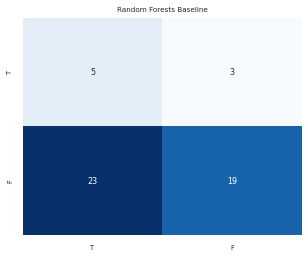

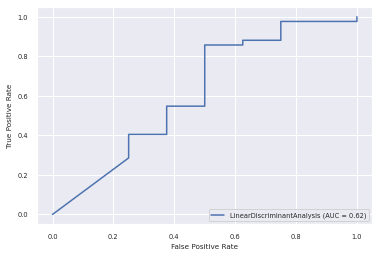

This is the starting index: 51 of patient 1
0.6666666666666666
[(0, 1, array([0., 1.])), (0, 0, array([1.00000000e+000, 1.63517534e-100])), (0, 0, array([9.99817109e-01, 1.82890504e-04])), (0, 0, array([1.00000000e+00, 2.52702251e-36])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+000, 3.46972509e-155])), (0, 0, array([1.00000000e+000, 2.47257873e-108])), (0, 0, array([1.00000000e+000, 8.30443762e-102])), (0, 0, array([1.00000000e+000, 3.32192897e-211])), (0, 0, array([1.00000000e+000, 3.85654764e-167])), (0, 0, array([1.00000000e+000, 3.09369659e-101])), (0, 0, array([1.00000000e+00, 1.97816283e-42])), (0, 0, array([1.00000000e+00, 2.35123471e-31])), (0, 0, array([1.00000000e+00, 5.81775594e-67])), (0, 0, array([1.00000000e+00, 9.76859141e-54])), (0, 1, array([2.87881496e-10, 1.00000000e+00])), (0, 0, array([1.00000000e+00, 3.96452435e-33])), (0, 1, array([1.42397205e-12, 1.00000000e+00])), (0, 0, array(

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


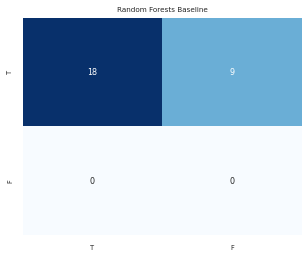

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


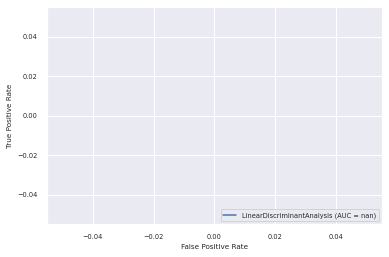

This is the starting index: 79 of patient 2
0.6428571428571429
[(0, 1, array([0., 1.])), (0, 0, array([1.000000e+00, 2.674115e-15])), (1, 1, array([5.61411876e-07, 9.99999439e-01])), (0, 0, array([1.00000000e+000, 6.79141553e-115])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+000, 4.26434697e-137])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([7.11787938e-07, 9.99999288e-01])), (1, 1, array([0., 1.])), (1, 1, array([2.22044605e-15, 1.00000000e+00])), (0, 0, array([1.00000000e+00, 1.57976412e-33])), (1, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 1.15005435e-98])), (1, 0, array([9.99918141e-01, 8.18591809e-05])), (0, 0, array([1.00000000e+00, 1.86044049e-65])), (0, 0, array([1.00000000e+00, 1.04270082e-16])), (0, 1, array([0., 1.])), (0, 0, array([9.99996533e-01, 3.46674323e-06])), (0, 0, array([1.00000000e+00, 1.84892062e-76])), (0, 1, array([0.09395608, 0.90604392])), (0, 0, array([1.00000000e+00, 2.97307396e-29])), (1, 1, ar

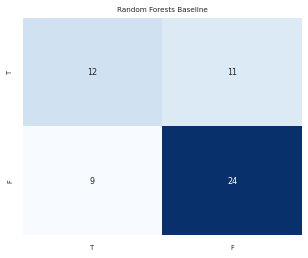

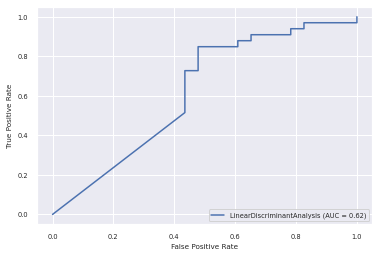

This is the starting index: 136 of patient 3
0.4594594594594595
[(1, 1, array([0., 1.])), (1, 0, array([1., 0.])), (1, 0, array([1.00000000e+000, 8.06259061e-238])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 2.47247388e-62])), (1, 0, array([1.00000000e+00, 1.45699882e-68])), (1, 0, array([1.00000000e+00, 1.81571713e-80])), (0, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 6.58179676e-38])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 7.94530315e-43])), (1, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+000, 4.46784136e-102])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+000, 4.11834758e-134])), (0, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 4.41229789e-14])), (0, 1, array([0., 1.])), (1, 1, array([0., 1.])), (0, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 4.21538379e-59])), (1, 1, array([

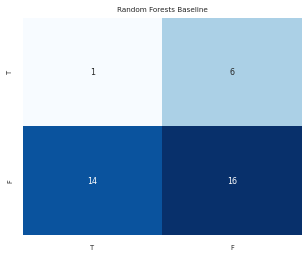

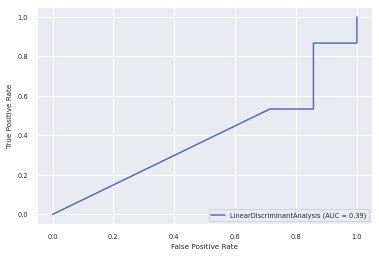

This is the starting index: 174 of patient 4
0.5135135135135135
[(0, 0, array([1.00000000e+00, 6.11396694e-25])), (0, 1, array([0., 1.])), (1, 0, array([9.99999995e-01, 5.04169531e-09])), (0, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 1.85816449e-20])), (0, 1, array([0., 1.])), (1, 0, array([9.99999971e-01, 2.92849240e-08])), (0, 0, array([1.00000000e+00, 1.13649085e-61])), (1, 0, array([1.00000000e+000, 9.37318802e-113])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+000, 9.51829365e-138])), (0, 1, array([0., 1.])), (0, 0, array([1.0000000e+00, 6.2534541e-85])), (0, 0, array([1., 0.])), (0, 0, array([1.00000000e+00, 1.82618778e-60])), (1, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 3.35575265e-72])), (0, 0, array([1.00000000e+000, 1.19211072e-122])), (1, 0, array([1.00000000e+00, 4.42091234e-12])), (0, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 5.35704675e-4

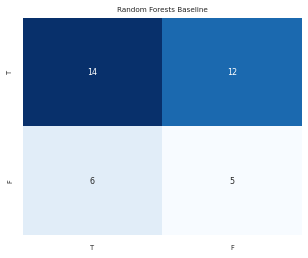

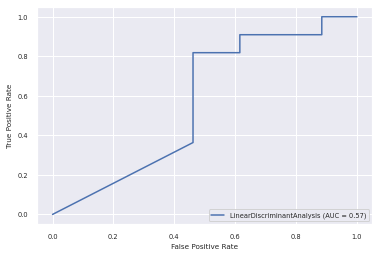

This is the starting index: 212 of patient 5
0.47058823529411764
[(1, 0, array([9.99999208e-01, 7.92206088e-07])), (1, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 2.66033648e-58])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 9.81441481e-16])), (0, 1, array([7.76827491e-11, 1.00000000e+00])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 7.54380773e-27])), (0, 0, array([1.00000000e+00, 2.79533596e-13])), (0, 1, array([0., 1.])), (0, 1, array([0.00257171, 0.99742829])), (0, 0, array([0.9891629, 0.0108371])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 2.16090766e-41])), (0, 0, array([1.00000000e+00, 1.49823525e-12])), (0, 1, array([0., 1.])), (0, 0, array([9.99953739e-01, 4.62606245e-05])), (0, 0, array([1.00000000e+00, 3.15985728e-49])), (0, 1, array([4.04379056e-08, 9.99999960e-01])), (0, 1, array([0., 1.])), (0, 0, array([1

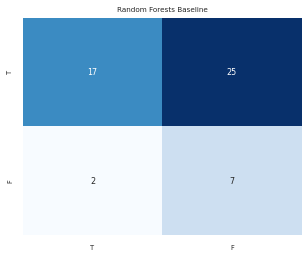

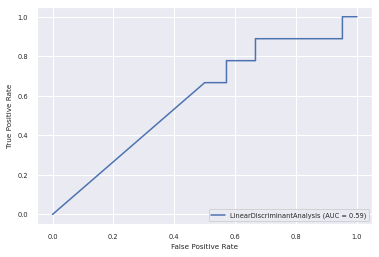

This is the starting index: 264 of patient 6
0.5263157894736842
[(0, 0, array([1.00000000e+00, 2.21030029e-41])), (0, 0, array([1.00000000e+00, 7.16699853e-19])), (1, 0, array([0.90863756, 0.09136244])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+000, 2.21541672e-137])), (1, 0, array([1.00000000e+00, 7.53763579e-12])), (0, 0, array([1.00000000e+00, 2.61373423e-36])), (0, 1, array([0., 1.])), (1, 1, array([0.03215582, 0.96784418])), (0, 0, array([1.00000000e+00, 1.26045217e-15])), (1, 0, array([9.99999999e-01, 1.25691719e-09])), (0, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 9.80132084e-23])), (1, 1, array([4.4408921e-16, 1.0000000e+00])), (0, 1, array([0., 1.])), (1, 1, array([3.32400774e-13, 1.00000000e+00])), (1, 1, array([0., 1.])), (0, 0, array([0.97765533, 0.02234467])), (0, 1, array([0., 1.]))]


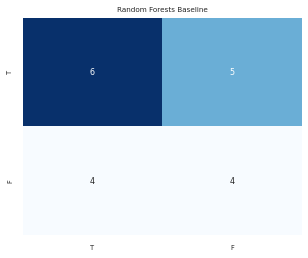

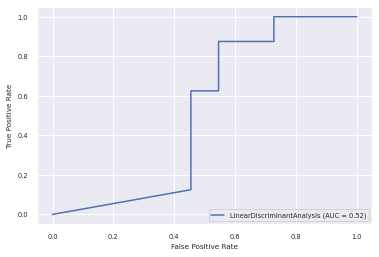

This is the starting index: 284 of patient 7
0.7333333333333333
[(0, 0, array([1.00000000e+00, 1.12648641e-23])), (0, 0, array([1., 0.])), (0, 1, array([0., 1.])), (0, 0, array([1., 0.])), (0, 0, array([1., 0.])), (0, 0, array([1., 0.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+000, 8.93016165e-180])), (0, 1, array([0., 1.])), (1, 1, array([2.74810086e-09, 9.99999997e-01])), (0, 0, array([1.00000000e+000, 2.41097659e-162])), (0, 0, array([9.99951541e-01, 4.84588851e-05])), (0, 0, array([1., 0.])), (0, 0, array([1., 0.]))]


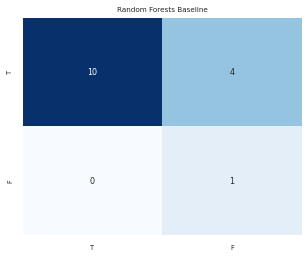

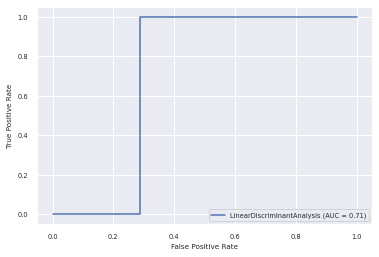

This is the starting index: 300 of patient 8
0.5116279069767442
[(0, 0, array([1.00000000e+00, 5.15119921e-70])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 3.92027194e-20])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([0.77895381, 0.22104619])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 6.41487348e-21])), (0, 0, array([1.00000000e+00, 5.17426526e-74])), (0, 1, array([5.06257401e-04, 9.99493743e-01])), (0, 0, array([1.00000000e+00, 4.17232605e-57])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 2.41125669e-48])), (0, 0, array([1.00000000e+00, 2.75902586e-61])), (1, 0, array([1.00000000e+00, 1.81874566e-40])), (0, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 5.30343001e-34])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (1, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 1.47064558e-70])), (1, 0, array([1.00000000e+000, 9.80651176e-133])), (1, 0, array([1.0000000e+00, 7.5133763e-24])), (1, 1, 

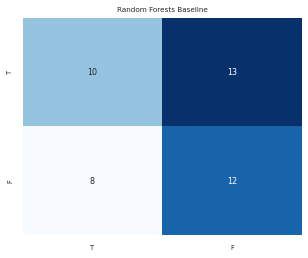

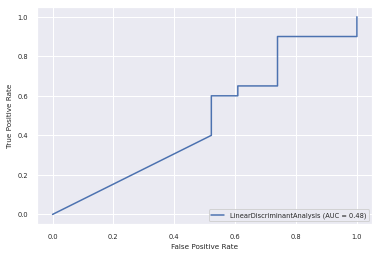

This is the starting index: 344 of patient 9
0.47619047619047616
[(1, 1, array([0., 1.])), (1, 1, array([2.47446508e-12, 1.00000000e+00])), (0, 1, array([6.66133815e-16, 1.00000000e+00])), (1, 0, array([1.00000000e+000, 1.75619604e-142])), (1, 0, array([1.00000000e+00, 9.84883156e-21])), (1, 0, array([1.00000000e+00, 4.74450279e-25])), (1, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 4.25760205e-58])), (0, 0, array([1.00000000e+00, 1.18874917e-17])), (0, 0, array([1.00000000e+00, 1.12247354e-28])), (0, 0, array([1.00000000e+00, 6.36431771e-19])), (0, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 4.43830642e-67])), (0, 1, array([7.86479244e-05, 9.99921352e-01])), (0, 0, array([1.00000000e+00, 4.31811785e-19])), (1, 0, array([1.00000000e+00, 3.26698114e-49])), (0, 1, array([0., 1.])), (0, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.0000000e+00, 1.8829092e-44])), (0, 0, array([1.00000000e+00, 1.43145264e-88])),

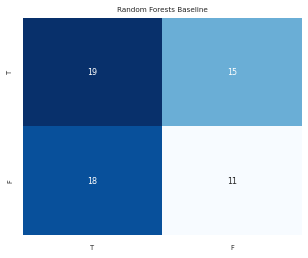

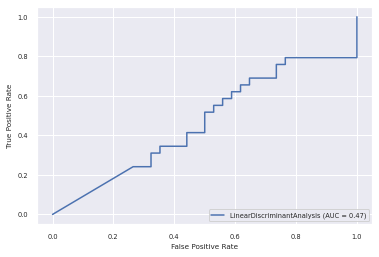

This is the starting index: 408 of patient 10
0.7121212121212122
[(1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([9.99999642e-01, 3.58459215e-07])), (1, 1, array([2.59572059e-08, 9.99999974e-01])), (1, 1, array([0., 1.])), (0, 1, array([0.15795679, 0.84204321])), (0, 0, array([1.00000000e+00, 2.71994705e-63])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (0, 1, array([1.64535052e-13, 1.00000000e+00])), (1, 1, array([0., 1.])), (1, 1, array([2.88810864e-09, 9.99999997e-01])), (0, 1, array([0., 1.])), (1, 1, array([1.13242749e-14, 1.00000000e+00])), (0, 1, array([2.85795831e-11, 1.00000000e+00])), (1, 1, array([0., 1.])), (0, 0, array([1.00000000e+00, 3.42661519e-18])), (1, 1, array([1.56474877e-09, 9.99999998e-01])), (1, 1, array([2.11877480e-07, 9.99999788e-01])), (0, 0, array([1.00000000e+00, 1.94890368e-16])), (1, 

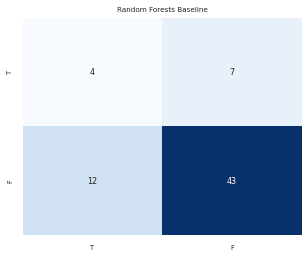

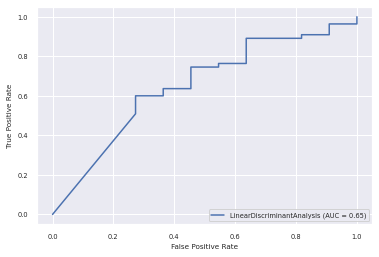

This is the starting index: 475 of patient 11
0.5370370370370371
[(0, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 1.07238448e-53])), (1, 0, array([1.00000000e+00, 1.63548476e-52])), (0, 0, array([0.55324324, 0.44675676])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 2.97547612e-54])), (1, 1, array([3.55271368e-15, 1.00000000e+00])), (1, 0, array([1.00000000e+00, 1.55576037e-11])), (1, 0, array([1.00000000e+00, 4.74010399e-17])), (1, 1, array([0., 1.])), (0, 1, array([0., 1.])), (1, 0, array([0.9304323, 0.0695677])), (1, 1, array([0., 1.])), (1, 0, array([1.0000000e+00, 8.0871651e-13])), (1, 1, array([8.95483687e-12, 1.00000000e+00])), (1, 1, array([0., 1.])), (1, 0, array([9.99999992e-01, 8.21489547e-09])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+000, 1.85176684e-151])), (1, 0, array([1.00000000e+00, 2.62694476e-32])), (1, 0, array([1.00000000e+00, 9.47777195e-12])), (1, 1, array([6.16773743e-10, 9.99999999e-01])), (1, 0, array([1.0

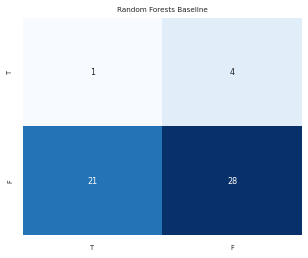

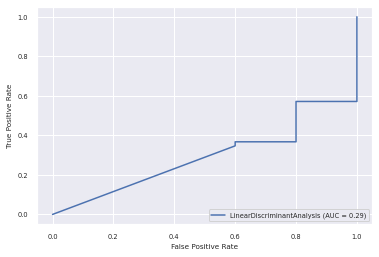

This is the starting index: 530 of patient 12
0.6481481481481481
[(1, 0, array([1.00000000e+000, 3.03235939e-251])), (1, 0, array([9.99999399e-01, 6.01131139e-07])), (1, 0, array([9.99999697e-01, 3.03083209e-07])), (1, 1, array([0., 1.])), (1, 0, array([9.99999998e-01, 1.78064439e-09])), (1, 0, array([1.00000000e+00, 2.93402726e-12])), (1, 1, array([0., 1.])), (0, 0, array([1.0000000e+00, 6.2116706e-49])), (0, 0, array([1.0000000e+00, 1.7460314e-43])), (1, 1, array([0., 1.])), (1, 1, array([5.55111512e-15, 1.00000000e+00])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 4.97363815e-20])), (1, 1, array([1.91434287e-08, 9.99999981e-01])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 8.08708721e-27])), (1, 1, array([0., 1.])), (1, 1, array([0.00217934, 0.99782066])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 6.71146108e-31])), (1, 1, array([0., 1.])), (1, 1, array([0., 1.])), (1, 0, array([1.00000000e+00, 1.38662779e-36])), (1, 1, array([0., 1.])), (1, 0, a

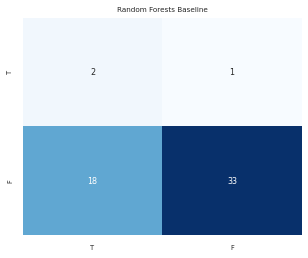

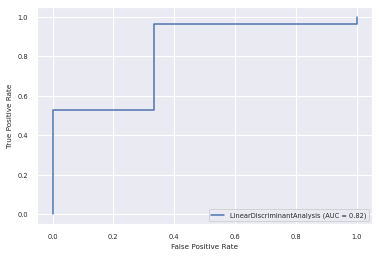

<function matplotlib.pyplot.show>

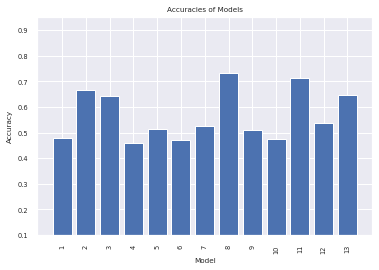

In [20]:
Accuracy = []
clf = LinearDiscriminantAnalysis()
sel = VarianceThreshold(threshold=(.1 * (1 - .8)))
for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    sel.fit_transform(train)
    sel.fit_transform(test)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### L1-based feature selection

In [ ]:
Accuracy = []

clf = LinearDiscriminantAnalysis()

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train, train_class.ravel())
    model = SelectFromModel(lsvc, prefit=True)
    train = model.transform(train)
    test = model.transform(test)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show


#### Tree Based Feature Selection

In [ ]:
Accuracy = []

clf = LinearDiscriminantAnalysis()

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(train, train_class.ravel())
    model = SelectFromModel(clf, prefit=True)
    train = model.transform(train)
    # clf = ExtraTreesClassifier(n_estimators=50)
    # clf = clf.fit(test, test_class.ravel())
    # model = SelectFromModel(clf, prefit=True) 

    test = model.transform(test)
    clf = RandomForestClassifier()
    clf.fit(train, train_class.ravel())


    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### Auto Sklearn Recommendation

In [ ]:
#SVM with manual parameters
svm = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                         ('svm', SGDClassifier(loss='hinge', alpha=1e-3, random_state=42)),])

SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'extra_trees_preproc_for_classification', 'classifier:random_forest:bootstrap': 'False', 'classifier:random_forest:criterion': 'entropy', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.27453376891983117, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 13, 'classifier:random_forest:min_samples_split': 19, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.2166847947584762, 'feature_preprocessor:extra_trees_preproc_for_classification:bootstrap': 'False', 'feature_preprocessor:extra_trees_preproc_for_classification:criterion': 'entropy', 'feature_preprocessor:extra_trees_preproc_for_classification:max_depth': 'None', 'feature_preprocessor:extra_trees_preproc_for_classification:max_features': 0.2819773130241576, 'feature_preprocessor:extra_trees_preproc_for_classification:max_leaf_nodes': 'None', 'feature_preprocessor:extra_trees_preproc_for_classification:min_impurity_decrease': 0.0, 'feature_preprocessor:extra_trees_preproc_for_classification:min_samples_leaf': 20, 'feature_preprocessor:extra_trees_preproc_for_classification:min_samples_split': 3, 'feature_preprocessor:extra_trees_preproc_for_classification:min_weight_fraction_leaf': 0.0, 'feature_preprocessor:extra_trees_preproc_for_classification:n_estimators': 100},
d

### SVM(Support Vector Machine)

#### Baseline

This is the starting index: 0 of patient 0
0.7539267015706806
[([1], 1, 1), ([1], 0, 0), ([0], 1, 1), ([1], 0, 0), ([1], 1, 1), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 1, 1), ([0], 1, 1), ([0], 0, 0), ([1], 1, 1), ([1], 1, 1), ([0], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([0], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([0], 1, 1), ([0], 1, 1), ([1], 1, 1), ([1], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 1, 1), ([0], 0, 0), ([1], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 1, 1), ([1], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), (

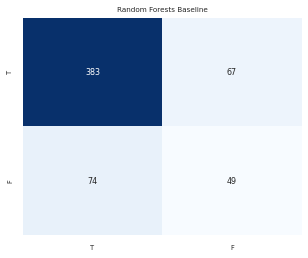

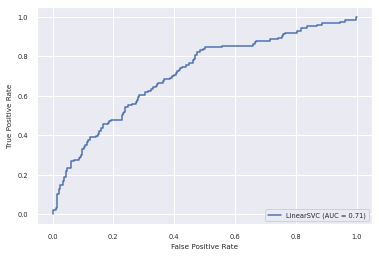

This is the starting index: 574 of patient 1
0.7145922746781116
[([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([1], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([1], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 1, 1), ([0], 0, 0), ([1], 1, 1), ([0], 0, 0), ([1], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 1, 1), ([1], 1, 1), ([0], 1, 1), ([1], 0, 0), ([1], 1, 1), ([0], 0, 0), ([0], 0, 0), ([1], 1, 1), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([1], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([1], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 1, 1), ([0], 0, 0), ([0], 0, 0),

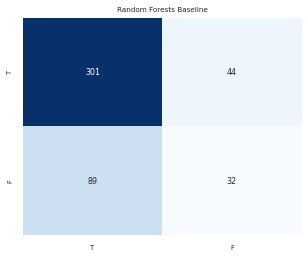

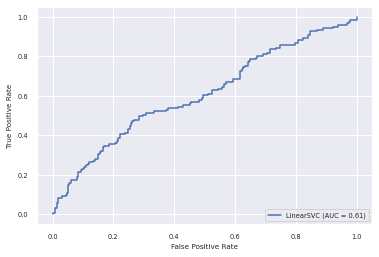

This is the starting index: 1041 of patient 2
0.36177474402730375
[([1], 1, 1), ([0], 1, 1), ([0], 1, 1), ([1], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([0], 1, 1), ([1], 1, 1), ([1], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1

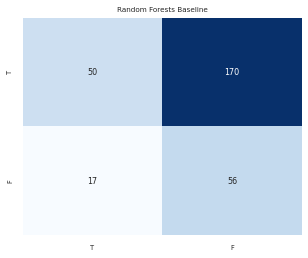

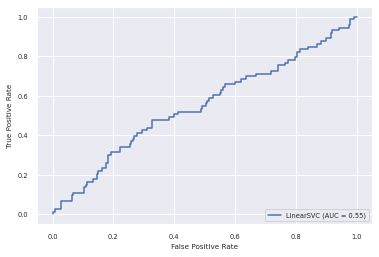

This is the starting index: 1335 of patient 3
0.6349206349206349
[([0], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([1], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([1], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([1], 0, 0), ([1], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0)

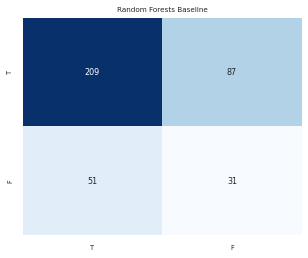

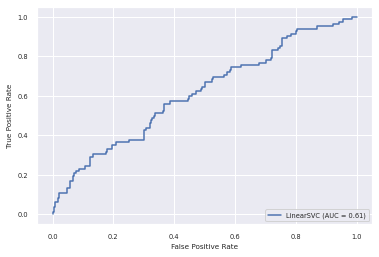

This is the starting index: 1714 of patient 4
0.16611295681063123
[([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0

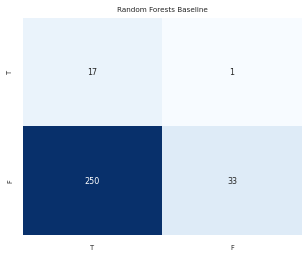

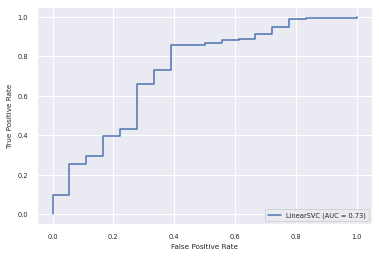

This is the starting index: 2016 of patient 5
0.3170731707317073
[([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0)

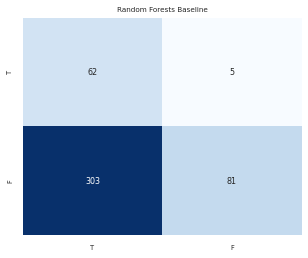

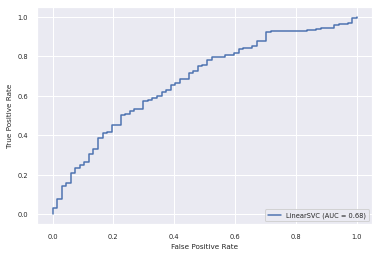

This is the starting index: 2468 of patient 6
0.46981627296587924
[([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 1, 1), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 1, 1), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 1, 1), ([0], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0

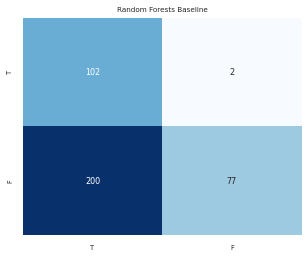

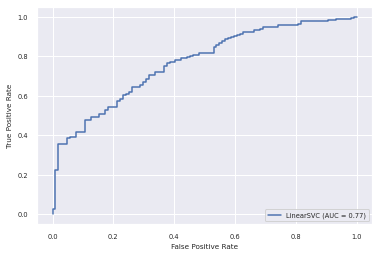

This is the starting index: 2850 of patient 7
0.7896907216494845
[([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 1, 1), ([0], 0, 0), ([1], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([1], 1, 1), ([0], 0, 0)

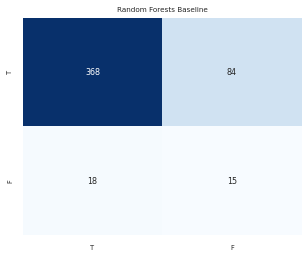

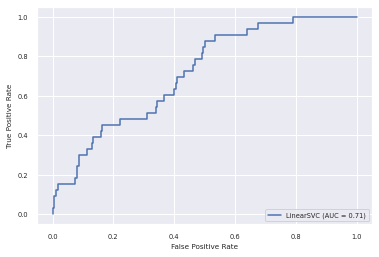

This is the starting index: 3336 of patient 8
0.5986159169550173
[([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 1, 1), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 1, 1), ([0], 1, 1), ([1], 0, 0), ([0], 0, 0), ([1], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([0], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([0], 0, 0), ([0], 1, 1), ([1], 0, 0), ([1], 0, 0)

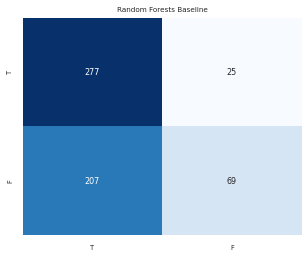

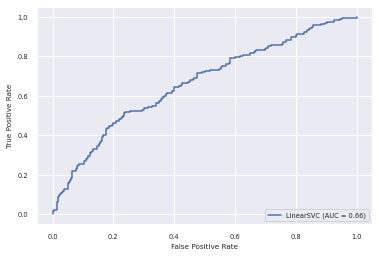

This is the starting index: 3915 of patient 9
0.525
[([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([0], 0, 0), ([0], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([0], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([0], 1, 1), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([1], 1, 1)

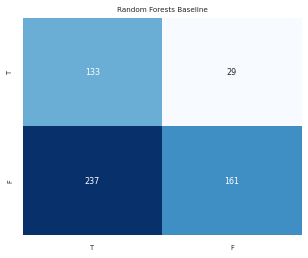

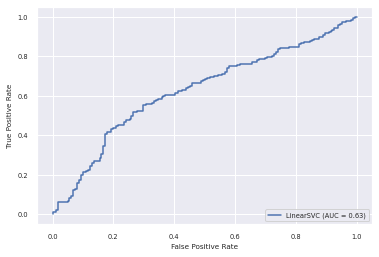

This is the starting index: 4476 of patient 10
0.8534322820037106
[([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0

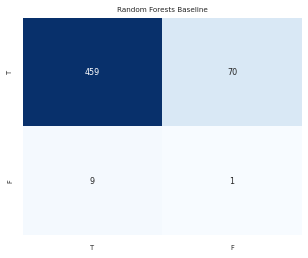

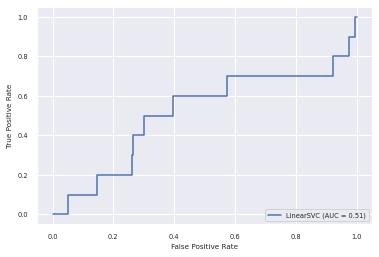

This is the starting index: 5016 of patient 11
0.6861471861471862
[([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 1, 1), ([0], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 1, 1), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([1], 0, 0), ([1], 0, 0), ([1], 1, 1), ([0], 0, 0), ([0], 0, 0), ([1], 1, 1), ([1], 0, 0), ([0], 1, 1), ([1], 0, 0), ([1], 1, 1), ([0], 0, 0), ([1], 0, 0), ([1], 1, 1

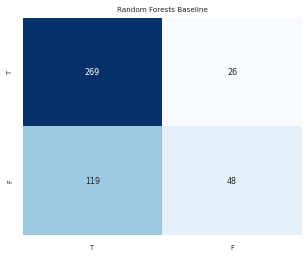

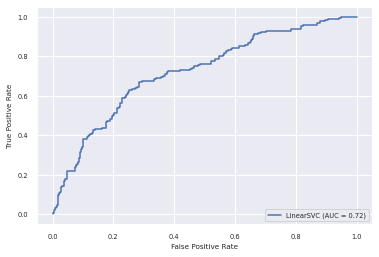

This is the starting index: 5479 of patient 12
0.6647058823529411
[([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([0], 0, 0), ([1], 0, 0), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([1], 0, 0), ([0], 0, 0), ([1], 1, 1), ([0], 1, 1), ([0], 0, 0), ([0], 1, 1), ([0], 1, 1), ([0], 1, 1), ([1], 1, 1), ([1], 0, 0

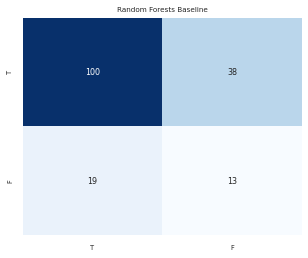

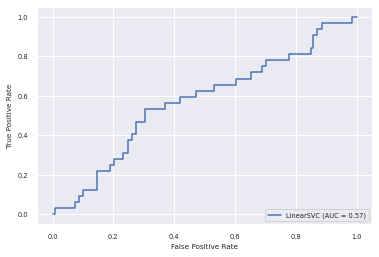

<function matplotlib.pyplot.show>

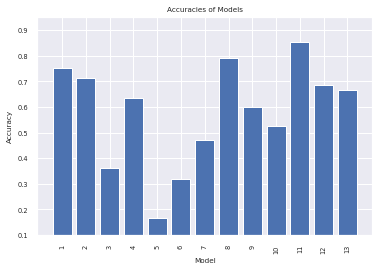

In [ ]:
Accuracy = []

clf = LinearSVC()

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result) 
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### GridSearch

In [ ]:
parameters = {
    'solver'      : ['svd', 'lsqr', 'eigen'],
    'shrinkage'         : ['auto'],
    # 'random_state'      : [0],
    #'max_features': ['auto'],
    #'criterion' :['gini']
}


for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    search = GridSearchCV(LinearDiscriminantAnalysis(), parameters, cv=10, n_jobs=-1)
    search.fit(train, train_class.ravel())

    print(search.score(train, train_class.ravel()))
    print(search.best_params_)

This is the starting index: 0 of patient 0
0.6428993500098483
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 574 of patient 1
0.6500771604938271
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 1041 of patient 2
0.6725779354116109
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 1335 of patient 3
0.6544006069802731
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 1714 of patient 4
0.6778837165825388
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 2016 of patient 5
0.682823619926909
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 2468 of patient 6
0.666540140444107
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 2850 of patient 7
0.6383349467570184
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 3336 of patient 8
0.6571372239747634
{'shrinkage': 'auto', 'solver': 'lsqr'}
This is the starting index: 3915 of patient 9
0.6656188605108

This is the starting index: 0 of patient 0
0.7591623036649214
[([1], 1, array([0.28724432, 0.71275568])), ([1], 0, array([0.52793866, 0.47206134])), ([0], 1, array([0.47729481, 0.52270519])), ([1], 0, array([0.58606507, 0.41393493])), ([1], 1, array([0.28105903, 0.71894097])), ([0], 0, array([0.54899241, 0.45100759])), ([1], 0, array([0.83048311, 0.16951689])), ([0], 0, array([0.58447045, 0.41552955])), ([1], 1, array([0.29994374, 0.70005626])), ([0], 1, array([0.25482794, 0.74517206])), ([0], 0, array([0.53910338, 0.46089662])), ([1], 1, array([0.35788715, 0.64211285])), ([1], 1, array([0.37010416, 0.62989584])), ([0], 0, array([0.68482296, 0.31517704])), ([1], 0, array([0.51826464, 0.48173536])), ([1], 1, array([0.39316513, 0.60683487])), ([1], 1, array([0.34169112, 0.65830888])), ([1], 0, array([0.50167629, 0.49832371])), ([1], 1, array([0.4476423, 0.5523577])), ([1], 1, array([0.45081179, 0.54918821])), ([0], 0, array([0.59701038, 0.40298962])), ([1], 1, array([0.42577541, 0.574224

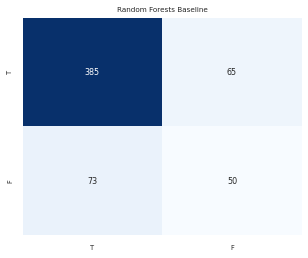

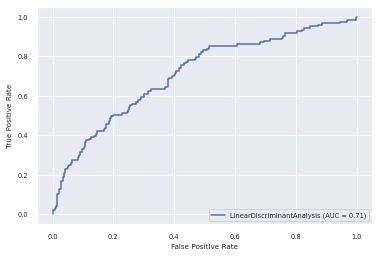

This is the starting index: 574 of patient 1
0.7081545064377682
[([0], 0, array([0.53973127, 0.46026873])), ([0], 1, array([0.43431795, 0.56568205])), ([0], 0, array([0.67192824, 0.32807176])), ([0], 1, array([0.32418618, 0.67581382])), ([0], 1, array([0.49868078, 0.50131922])), ([0], 0, array([0.56119259, 0.43880741])), ([1], 1, array([0.29835046, 0.70164954])), ([0], 0, array([0.53461798, 0.46538202])), ([0], 0, array([0.62089123, 0.37910877])), ([0], 1, array([0.29515194, 0.70484806])), ([0], 1, array([0.49555517, 0.50444483])), ([0], 1, array([0.39944155, 0.60055845])), ([1], 1, array([0.3793303, 0.6206697])), ([0], 0, array([0.54368794, 0.45631206])), ([0], 0, array([0.63724166, 0.36275834])), ([0], 0, array([0.73103222, 0.26896778])), ([0], 0, array([0.5177896, 0.4822104])), ([0], 0, array([0.76845882, 0.23154118])), ([1], 0, array([0.50622413, 0.49377587])), ([0], 0, array([0.69303723, 0.30696277])), ([1], 1, array([0.17113987, 0.82886013])), ([0], 0, array([0.71254574, 0.287454

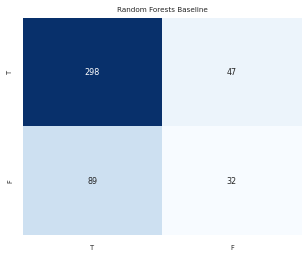

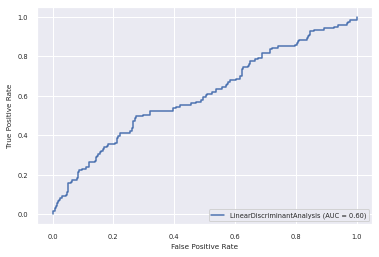

This is the starting index: 1041 of patient 2
0.35494880546075086
[([1], 1, array([0.40433807, 0.59566193])), ([0], 1, array([0.22703113, 0.77296887])), ([0], 1, array([0.15868578, 0.84131422])), ([1], 1, array([0.12584993, 0.87415007])), ([0], 1, array([0.1314954, 0.8685046])), ([0], 1, array([0.23236204, 0.76763796])), ([0], 1, array([0.07421786, 0.92578214])), ([1], 1, array([0.12923265, 0.87076735])), ([1], 1, array([0.21806123, 0.78193877])), ([1], 1, array([0.3498872, 0.6501128])), ([1], 1, array([0.16847285, 0.83152715])), ([1], 1, array([0.29652082, 0.70347918])), ([1], 1, array([0.27040517, 0.72959483])), ([0], 1, array([0.33427675, 0.66572325])), ([1], 1, array([0.38796472, 0.61203528])), ([1], 0, array([0.52389653, 0.47610347])), ([0], 1, array([0.31919424, 0.68080576])), ([0], 1, array([0.21062389, 0.78937611])), ([0], 1, array([0.19319397, 0.80680603])), ([0], 0, array([0.6071931, 0.3928069])), ([0], 1, array([0.06435298, 0.93564702])), ([0], 1, array([0.43423653, 0.565763

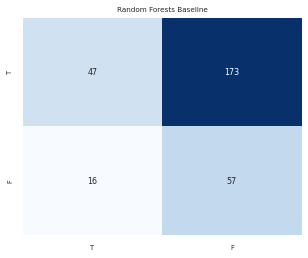

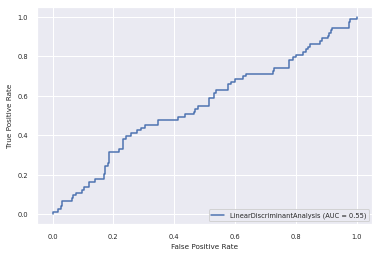

This is the starting index: 1335 of patient 3
0.6402116402116402
[([0], 0, array([0.53745276, 0.46254724])), ([1], 1, array([0.33777581, 0.66222419])), ([1], 1, array([0.47189869, 0.52810131])), ([1], 1, array([0.43430965, 0.56569035])), ([1], 1, array([0.17924077, 0.82075923])), ([1], 0, array([0.56927113, 0.43072887])), ([1], 0, array([0.56958262, 0.43041738])), ([0], 1, array([0.44408204, 0.55591796])), ([0], 0, array([0.55586988, 0.44413012])), ([0], 0, array([0.58917364, 0.41082636])), ([0], 1, array([0.41061786, 0.58938214])), ([0], 1, array([0.38385392, 0.61614608])), ([0], 0, array([0.65394688, 0.34605312])), ([1], 1, array([0.45872792, 0.54127208])), ([0], 0, array([0.57836113, 0.42163887])), ([0], 1, array([0.46318115, 0.53681885])), ([0], 0, array([0.55580282, 0.44419718])), ([0], 1, array([0.23805336, 0.76194664])), ([0], 1, array([0.46811313, 0.53188687])), ([0], 0, array([0.77613549, 0.22386451])), ([0], 0, array([0.59369019, 0.40630981])), ([0], 1, array([0.4084274, 0.59

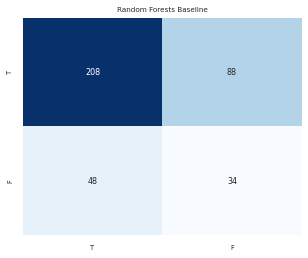

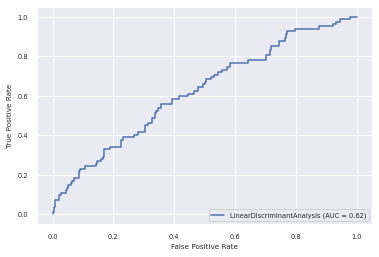

This is the starting index: 1714 of patient 4
0.1760797342192691
[([1], 0, array([0.52145974, 0.47854026])), ([1], 0, array([0.62512286, 0.37487714])), ([1], 0, array([0.65560799, 0.34439201])), ([1], 1, array([0.46948206, 0.53051794])), ([1], 0, array([0.51149988, 0.48850012])), ([1], 0, array([0.5745478, 0.4254522])), ([1], 0, array([0.57048265, 0.42951735])), ([1], 0, array([0.59869616, 0.40130384])), ([1], 0, array([0.7569312, 0.2430688])), ([1], 1, array([0.38912325, 0.61087675])), ([1], 0, array([0.65812232, 0.34187768])), ([1], 0, array([0.65861123, 0.34138877])), ([1], 0, array([0.51007121, 0.48992879])), ([1], 1, array([0.44818711, 0.55181289])), ([1], 0, array([0.54542731, 0.45457269])), ([1], 0, array([0.57371766, 0.42628234])), ([1], 0, array([0.66528055, 0.33471945])), ([1], 0, array([0.57524185, 0.42475815])), ([1], 0, array([0.60301107, 0.39698893])), ([1], 0, array([0.59083342, 0.40916658])), ([1], 0, array([0.60988164, 0.39011836])), ([1], 0, array([0.63528457, 0.36471

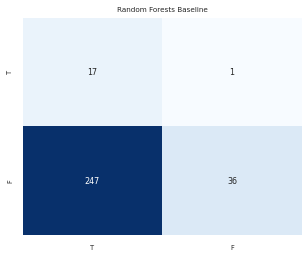

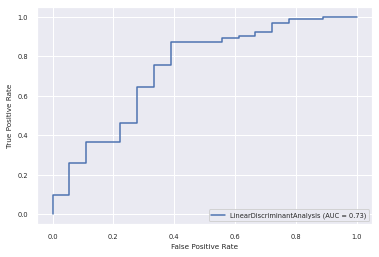

This is the starting index: 2016 of patient 5
0.328159645232816
[([0], 0, array([0.63477862, 0.36522138])), ([0], 0, array([0.79163689, 0.20836311])), ([0], 0, array([0.64589827, 0.35410173])), ([0], 0, array([0.81424517, 0.18575483])), ([0], 0, array([0.81272514, 0.18727486])), ([0], 0, array([0.7855189, 0.2144811])), ([1], 0, array([0.70168708, 0.29831292])), ([1], 0, array([0.82633952, 0.17366048])), ([1], 0, array([0.72707937, 0.27292063])), ([1], 0, array([0.6823452, 0.3176548])), ([0], 0, array([0.73484311, 0.26515689])), ([1], 0, array([0.7981897, 0.2018103])), ([0], 0, array([0.73481316, 0.26518684])), ([1], 0, array([0.70560862, 0.29439138])), ([1], 0, array([0.83087329, 0.16912671])), ([1], 0, array([0.52596116, 0.47403884])), ([1], 0, array([0.57207192, 0.42792808])), ([1], 0, array([0.69400721, 0.30599279])), ([1], 0, array([0.73086036, 0.26913964])), ([1], 0, array([0.73848878, 0.26151122])), ([1], 1, array([0.40289042, 0.59710958])), ([1], 0, array([0.70604849, 0.29395151

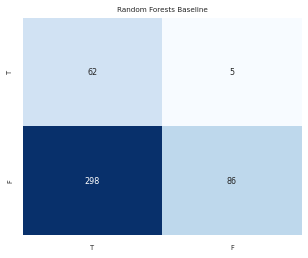

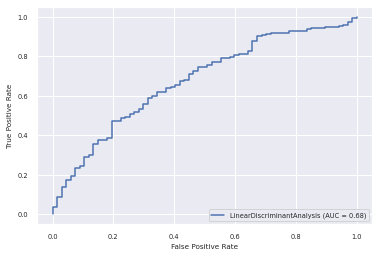

This is the starting index: 2468 of patient 6
0.46981627296587924
[([1], 1, array([0.42734272, 0.57265728])), ([1], 1, array([0.43345804, 0.56654196])), ([1], 1, array([0.45755506, 0.54244494])), ([1], 0, array([0.62166908, 0.37833092])), ([1], 0, array([0.56268404, 0.43731596])), ([1], 0, array([0.67454903, 0.32545097])), ([1], 1, array([0.39153842, 0.60846158])), ([1], 0, array([0.84080292, 0.15919708])), ([1], 0, array([0.51219059, 0.48780941])), ([1], 0, array([0.64221226, 0.35778774])), ([0], 0, array([0.7867524, 0.2132476])), ([1], 1, array([0.17004838, 0.82995162])), ([1], 0, array([0.70701818, 0.29298182])), ([1], 1, array([0.21082548, 0.78917452])), ([1], 0, array([0.50706483, 0.49293517])), ([1], 1, array([0.32346664, 0.67653336])), ([1], 1, array([0.07357393, 0.92642607])), ([1], 1, array([0.46945852, 0.53054148])), ([1], 0, array([0.53659936, 0.46340064])), ([0], 0, array([0.95535005, 0.04464995])), ([1], 0, array([0.6927705, 0.3072295])), ([1], 0, array([0.54914179, 0.4508

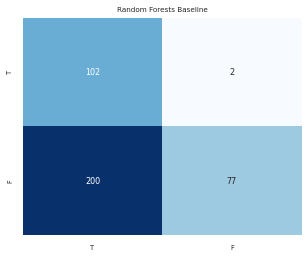

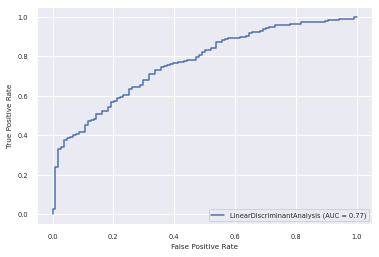

This is the starting index: 2850 of patient 7
0.7835051546391752
[([0], 1, array([0.46537178, 0.53462822])), ([0], 0, array([0.53226715, 0.46773285])), ([0], 0, array([0.59077108, 0.40922892])), ([0], 0, array([0.59408669, 0.40591331])), ([0], 1, array([0.46686459, 0.53313541])), ([0], 0, array([0.59177055, 0.40822945])), ([0], 1, array([0.3904021, 0.6095979])), ([0], 0, array([0.79180992, 0.20819008])), ([0], 0, array([0.52583621, 0.47416379])), ([0], 0, array([0.6162673, 0.3837327])), ([0], 0, array([0.75240476, 0.24759524])), ([0], 1, array([0.35771467, 0.64228533])), ([0], 1, array([0.23160865, 0.76839135])), ([0], 1, array([0.33168206, 0.66831794])), ([0], 0, array([0.54574922, 0.45425078])), ([0], 0, array([0.8338715, 0.1661285])), ([0], 0, array([0.67615488, 0.32384512])), ([0], 0, array([0.55521523, 0.44478477])), ([0], 0, array([0.59030101, 0.40969899])), ([0], 0, array([0.76858035, 0.23141965])), ([0], 0, array([0.50611143, 0.49388857])), ([0], 0, array([0.6954282, 0.3045718]

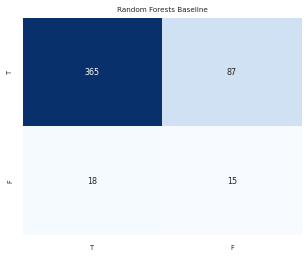

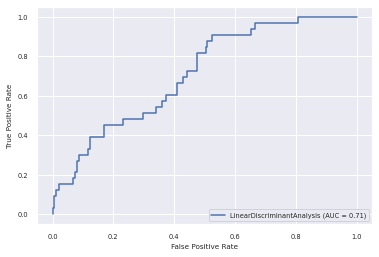

This is the starting index: 3336 of patient 8
0.5951557093425606
[([1], 0, array([0.67061642, 0.32938358])), ([1], 0, array([0.56708085, 0.43291915])), ([0], 0, array([0.7884211, 0.2115789])), ([1], 0, array([0.81356709, 0.18643291])), ([1], 0, array([0.66453917, 0.33546083])), ([1], 1, array([0.34607255, 0.65392745])), ([1], 0, array([0.52056196, 0.47943804])), ([1], 0, array([0.54117842, 0.45882158])), ([1], 0, array([0.58438004, 0.41561996])), ([1], 1, array([0.36579956, 0.63420044])), ([0], 0, array([0.70644229, 0.29355771])), ([1], 0, array([0.6249299, 0.3750701])), ([0], 0, array([0.73578397, 0.26421603])), ([1], 0, array([0.56367064, 0.43632936])), ([1], 1, array([0.29993179, 0.70006821])), ([0], 0, array([0.82843298, 0.17156702])), ([0], 0, array([0.52123345, 0.47876655])), ([1], 0, array([0.83431266, 0.16568734])), ([1], 1, array([0.44992669, 0.55007331])), ([1], 0, array([0.69943149, 0.30056851])), ([1], 1, array([0.33989201, 0.66010799])), ([0], 1, array([0.32501808, 0.67498

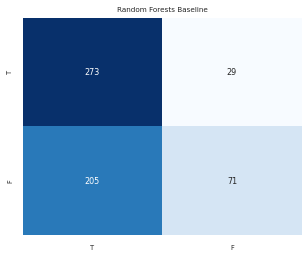

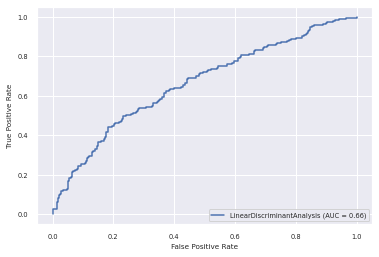

This is the starting index: 3915 of patient 9
0.5339285714285714
[([1], 1, array([0.30827779, 0.69172221])), ([1], 1, array([0.45219494, 0.54780506])), ([1], 1, array([0.29218959, 0.70781041])), ([1], 1, array([0.41865814, 0.58134186])), ([1], 1, array([0.35491895, 0.64508105])), ([1], 1, array([0.42260577, 0.57739423])), ([1], 1, array([0.47894136, 0.52105864])), ([1], 1, array([0.46011713, 0.53988287])), ([1], 1, array([0.41800517, 0.58199483])), ([1], 1, array([0.34736715, 0.65263285])), ([1], 0, array([0.52200318, 0.47799682])), ([1], 1, array([0.37205662, 0.62794338])), ([1], 1, array([0.49947486, 0.50052514])), ([1], 1, array([0.35215867, 0.64784133])), ([1], 1, array([0.40496252, 0.59503748])), ([1], 0, array([0.56041001, 0.43958999])), ([1], 1, array([0.3793716, 0.6206284])), ([1], 1, array([0.37712529, 0.62287471])), ([1], 1, array([0.34463827, 0.65536173])), ([1], 0, array([0.56055469, 0.43944531])), ([1], 1, array([0.40443354, 0.59556646])), ([1], 1, array([0.47131359, 0.528

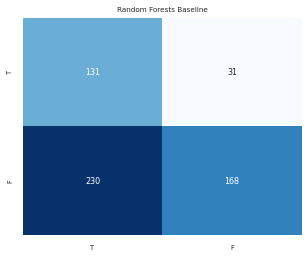

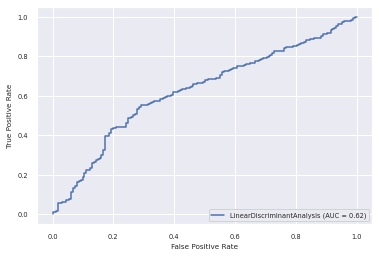

This is the starting index: 4476 of patient 10
0.8552875695732839
[([0], 0, array([0.53088411, 0.46911589])), ([0], 0, array([0.5540835, 0.4459165])), ([0], 0, array([0.57239824, 0.42760176])), ([0], 0, array([0.55181376, 0.44818624])), ([0], 0, array([0.61613802, 0.38386198])), ([0], 0, array([0.52306325, 0.47693675])), ([1], 0, array([0.5647269, 0.4352731])), ([1], 0, array([0.58959457, 0.41040543])), ([0], 0, array([0.63208462, 0.36791538])), ([0], 0, array([0.60055593, 0.39944407])), ([1], 0, array([0.50327165, 0.49672835])), ([1], 0, array([0.63392972, 0.36607028])), ([1], 0, array([0.79925233, 0.20074767])), ([0], 0, array([0.66811819, 0.33188181])), ([0], 0, array([0.73945225, 0.26054775])), ([0], 0, array([0.7614308, 0.2385692])), ([0], 0, array([0.67971443, 0.32028557])), ([0], 0, array([0.63137469, 0.36862531])), ([1], 0, array([0.54381403, 0.45618597])), ([0], 0, array([0.65719094, 0.34280906])), ([1], 0, array([0.86104128, 0.13895872])), ([0], 1, array([0.45730945, 0.542690

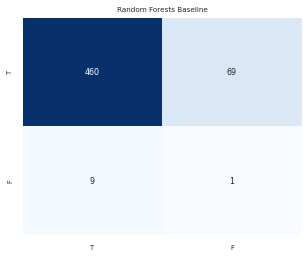

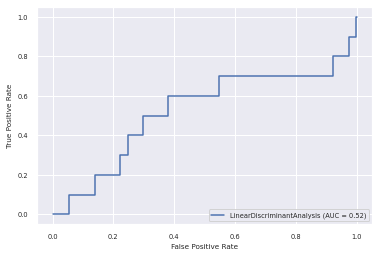

This is the starting index: 5016 of patient 11
0.6883116883116883
[([0], 1, array([0.41501239, 0.58498761])), ([0], 0, array([0.55673583, 0.44326417])), ([0], 0, array([0.52586379, 0.47413621])), ([0], 1, array([0.47521678, 0.52478322])), ([0], 1, array([0.36721876, 0.63278124])), ([0], 1, array([0.46827631, 0.53172369])), ([0], 1, array([0.32543249, 0.67456751])), ([0], 1, array([0.418771, 0.581229])), ([0], 0, array([0.57767761, 0.42232239])), ([0], 0, array([0.75695668, 0.24304332])), ([0], 0, array([0.66641291, 0.33358709])), ([0], 0, array([0.62632695, 0.37367305])), ([0], 0, array([0.65821654, 0.34178346])), ([1], 0, array([0.66504183, 0.33495817])), ([0], 0, array([0.57645088, 0.42354912])), ([1], 0, array([0.71172961, 0.28827039])), ([0], 0, array([0.7654082, 0.2345918])), ([0], 0, array([0.5760094, 0.4239906])), ([0], 0, array([0.59960704, 0.40039296])), ([1], 0, array([0.64376282, 0.35623718])), ([0], 0, array([0.6605947, 0.3394053])), ([0], 0, array([0.68086304, 0.31913696])

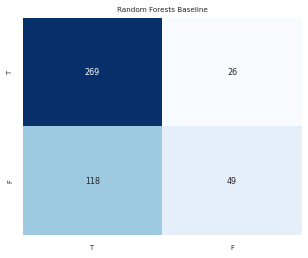

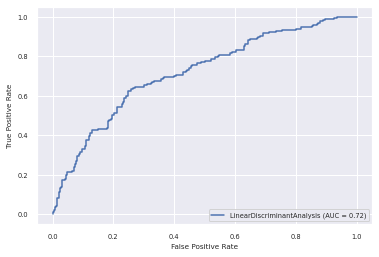

This is the starting index: 5479 of patient 12
0.6705882352941176
[([0], 0, array([0.55576154, 0.44423846])), ([0], 0, array([0.53706689, 0.46293311])), ([0], 1, array([0.48468843, 0.51531157])), ([0], 1, array([0.48658625, 0.51341375])), ([0], 0, array([0.57567059, 0.42432941])), ([0], 0, array([0.50681214, 0.49318786])), ([0], 0, array([0.55762204, 0.44237796])), ([0], 0, array([0.52316778, 0.47683222])), ([0], 1, array([0.44597259, 0.55402741])), ([0], 0, array([0.54173333, 0.45826667])), ([0], 0, array([0.50335695, 0.49664305])), ([0], 0, array([0.57996508, 0.42003492])), ([0], 0, array([0.58202205, 0.41797795])), ([0], 0, array([0.54149167, 0.45850833])), ([0], 0, array([0.51282783, 0.48717217])), ([0], 0, array([0.52179732, 0.47820268])), ([0], 0, array([0.5204948, 0.4795052])), ([0], 0, array([0.66801853, 0.33198147])), ([0], 0, array([0.56484198, 0.43515802])), ([0], 0, array([0.5682822, 0.4317178])), ([0], 0, array([0.69658654, 0.30341346])), ([0], 0, array([0.5405793, 0.45942

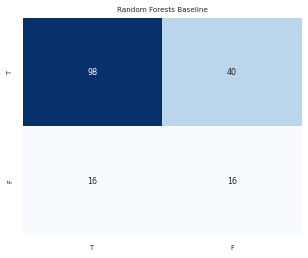

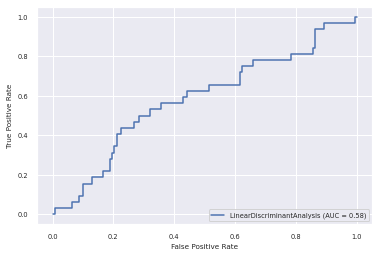

<function matplotlib.pyplot.show>

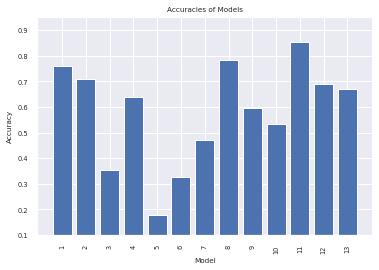

In [ ]:
Accuracy = []
clf = LinearDiscriminantAnalysis(shrinkage= 'auto', solver= 'lsqr')

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### Low Variance

This is the starting index: 0 of patient 0
0.7556719022687609
[([1], 1, array([0.26717886, 0.73282114])), ([1], 1, array([0.49431259, 0.50568741])), ([0], 1, array([0.47422467, 0.52577533])), ([1], 0, array([0.59139669, 0.40860331])), ([1], 1, array([0.29348308, 0.70651692])), ([0], 0, array([0.55958998, 0.44041002])), ([1], 0, array([0.84955929, 0.15044071])), ([0], 0, array([0.57704178, 0.42295822])), ([1], 1, array([0.29047493, 0.70952507])), ([0], 1, array([0.26547639, 0.73452361])), ([0], 0, array([0.54909413, 0.45090587])), ([1], 1, array([0.36204666, 0.63795334])), ([1], 1, array([0.37010988, 0.62989012])), ([0], 0, array([0.70296924, 0.29703076])), ([1], 0, array([0.52043048, 0.47956952])), ([1], 1, array([0.39080759, 0.60919241])), ([1], 1, array([0.35410808, 0.64589192])), ([1], 0, array([0.53118463, 0.46881537])), ([1], 1, array([0.44913334, 0.55086666])), ([1], 1, array([0.44540851, 0.55459149])), ([0], 0, array([0.60337966, 0.39662034])), ([1], 1, array([0.4270111, 0.57298

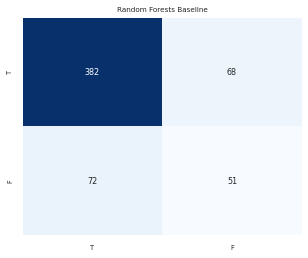

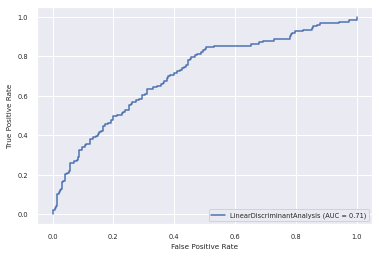

This is the starting index: 574 of patient 1
0.721030042918455
[([0], 0, array([0.5334334, 0.4665666])), ([0], 1, array([0.42523619, 0.57476381])), ([0], 0, array([0.6754194, 0.3245806])), ([0], 1, array([0.30107062, 0.69892938])), ([0], 0, array([0.50517406, 0.49482594])), ([0], 0, array([0.55148286, 0.44851714])), ([1], 1, array([0.29905145, 0.70094855])), ([0], 0, array([0.5248116, 0.4751884])), ([0], 0, array([0.61776789, 0.38223211])), ([0], 1, array([0.30230069, 0.69769931])), ([0], 1, array([0.49995787, 0.50004213])), ([0], 1, array([0.39556114, 0.60443886])), ([1], 1, array([0.36711126, 0.63288874])), ([0], 0, array([0.54129362, 0.45870638])), ([0], 0, array([0.61888789, 0.38111211])), ([0], 0, array([0.72296181, 0.27703819])), ([0], 0, array([0.50828018, 0.49171982])), ([0], 0, array([0.77798204, 0.22201796])), ([1], 0, array([0.50021563, 0.49978437])), ([0], 0, array([0.69302532, 0.30697468])), ([1], 1, array([0.16817056, 0.83182944])), ([0], 0, array([0.7168914, 0.2831086]))

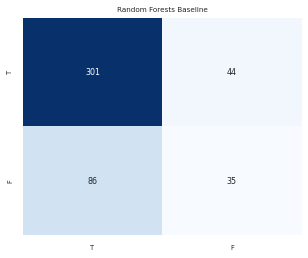

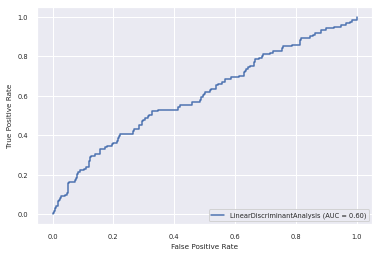

This is the starting index: 1041 of patient 2
0.3515358361774744
[([1], 1, array([0.38245219, 0.61754781])), ([0], 1, array([0.23552344, 0.76447656])), ([0], 1, array([0.16412465, 0.83587535])), ([1], 1, array([0.11336473, 0.88663527])), ([0], 1, array([0.13710505, 0.86289495])), ([0], 1, array([0.24201347, 0.75798653])), ([0], 1, array([0.07568805, 0.92431195])), ([1], 1, array([0.13264496, 0.86735504])), ([1], 1, array([0.22800325, 0.77199675])), ([1], 1, array([0.34214652, 0.65785348])), ([1], 1, array([0.14665716, 0.85334284])), ([1], 1, array([0.28917643, 0.71082357])), ([1], 1, array([0.26270918, 0.73729082])), ([0], 1, array([0.32599176, 0.67400824])), ([1], 1, array([0.37493725, 0.62506275])), ([1], 0, array([0.51651838, 0.48348162])), ([0], 1, array([0.32275461, 0.67724539])), ([0], 1, array([0.21011537, 0.78988463])), ([0], 1, array([0.16391378, 0.83608622])), ([0], 0, array([0.60722058, 0.39277942])), ([0], 1, array([0.06149001, 0.93850999])), ([0], 1, array([0.44885708, 0.5

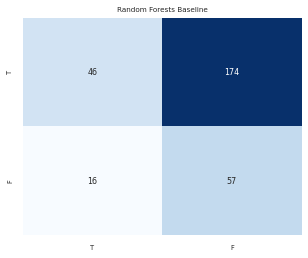

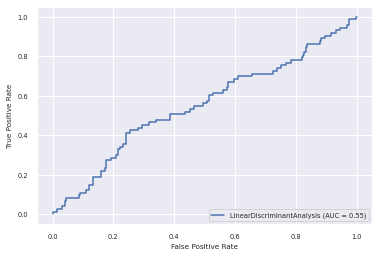

This is the starting index: 1335 of patient 3
0.6243386243386243
[([0], 0, array([0.52697108, 0.47302892])), ([1], 1, array([0.32644783, 0.67355217])), ([1], 1, array([0.44792263, 0.55207737])), ([1], 1, array([0.44618681, 0.55381319])), ([1], 1, array([0.17474521, 0.82525479])), ([1], 0, array([0.54344333, 0.45655667])), ([1], 0, array([0.57095542, 0.42904458])), ([0], 1, array([0.42328099, 0.57671901])), ([0], 0, array([0.53891838, 0.46108162])), ([0], 0, array([0.5939079, 0.4060921])), ([0], 1, array([0.40336959, 0.59663041])), ([0], 1, array([0.3833297, 0.6166703])), ([0], 0, array([0.62841095, 0.37158905])), ([1], 1, array([0.43345274, 0.56654726])), ([0], 0, array([0.55888478, 0.44111522])), ([0], 1, array([0.46495453, 0.53504547])), ([0], 0, array([0.54367154, 0.45632846])), ([0], 1, array([0.26101655, 0.73898345])), ([0], 1, array([0.46534232, 0.53465768])), ([0], 0, array([0.74280714, 0.25719286])), ([0], 0, array([0.57784618, 0.42215382])), ([0], 1, array([0.39554813, 0.60445

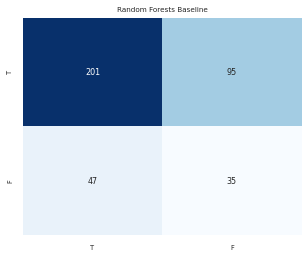

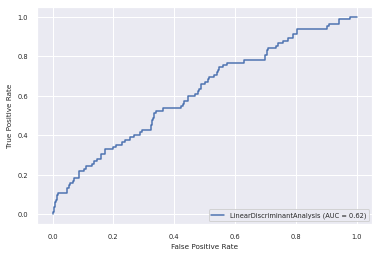

This is the starting index: 1714 of patient 4
0.18604651162790697
[([1], 1, array([0.4888835, 0.5111165])), ([1], 0, array([0.63321885, 0.36678115])), ([1], 0, array([0.65405819, 0.34594181])), ([1], 1, array([0.44704728, 0.55295272])), ([1], 1, array([0.49244738, 0.50755262])), ([1], 0, array([0.57727062, 0.42272938])), ([1], 0, array([0.57675007, 0.42324993])), ([1], 0, array([0.60096489, 0.39903511])), ([1], 0, array([0.75405737, 0.24594263])), ([1], 1, array([0.37295265, 0.62704735])), ([1], 0, array([0.63909493, 0.36090507])), ([1], 0, array([0.64472388, 0.35527612])), ([1], 1, array([0.49962064, 0.50037936])), ([1], 1, array([0.45616976, 0.54383024])), ([1], 0, array([0.53252734, 0.46747266])), ([1], 0, array([0.58035553, 0.41964447])), ([1], 0, array([0.65431451, 0.34568549])), ([1], 0, array([0.56626451, 0.43373549])), ([1], 0, array([0.58292073, 0.41707927])), ([1], 0, array([0.58356917, 0.41643083])), ([1], 0, array([0.61387981, 0.38612019])), ([1], 0, array([0.64247436, 0.35

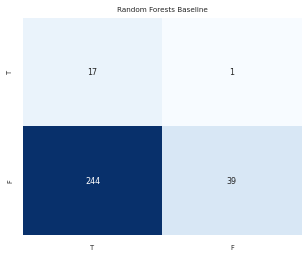

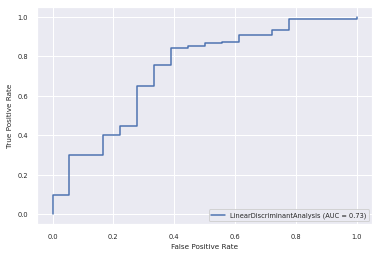

This is the starting index: 2016 of patient 5
0.3325942350332594
[([0], 0, array([0.63494522, 0.36505478])), ([0], 0, array([0.80124731, 0.19875269])), ([0], 0, array([0.63399292, 0.36600708])), ([0], 0, array([0.81617333, 0.18382667])), ([0], 0, array([0.80033507, 0.19966493])), ([0], 0, array([0.79040702, 0.20959298])), ([1], 0, array([0.69462117, 0.30537883])), ([1], 0, array([0.82977344, 0.17022656])), ([1], 0, array([0.71904443, 0.28095557])), ([1], 0, array([0.67835598, 0.32164402])), ([0], 0, array([0.75075848, 0.24924152])), ([1], 0, array([0.80086516, 0.19913484])), ([0], 0, array([0.7230839, 0.2769161])), ([1], 0, array([0.69643623, 0.30356377])), ([1], 0, array([0.82973222, 0.17026778])), ([1], 0, array([0.50898664, 0.49101336])), ([1], 0, array([0.56457566, 0.43542434])), ([1], 0, array([0.68491243, 0.31508757])), ([1], 0, array([0.7317202, 0.2682798])), ([1], 0, array([0.73886633, 0.26113367])), ([1], 1, array([0.39338546, 0.60661454])), ([1], 0, array([0.70655965, 0.29344

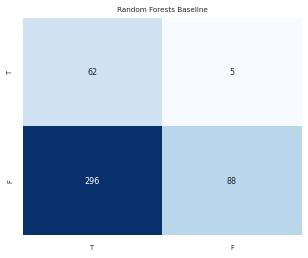

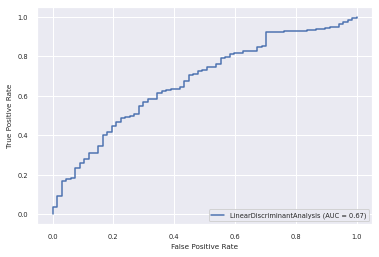

This is the starting index: 2468 of patient 6
0.47506561679790027
[([1], 1, array([0.39388456, 0.60611544])), ([1], 1, array([0.427215, 0.572785])), ([1], 1, array([0.46840947, 0.53159053])), ([1], 0, array([0.62329526, 0.37670474])), ([1], 0, array([0.58395023, 0.41604977])), ([1], 0, array([0.67387612, 0.32612388])), ([1], 1, array([0.37991445, 0.62008555])), ([1], 0, array([0.84517863, 0.15482137])), ([1], 0, array([0.50112835, 0.49887165])), ([1], 0, array([0.64613346, 0.35386654])), ([0], 0, array([0.78943774, 0.21056226])), ([1], 1, array([0.16288689, 0.83711311])), ([1], 0, array([0.71356522, 0.28643478])), ([1], 1, array([0.19332468, 0.80667532])), ([1], 1, array([0.49146972, 0.50853028])), ([1], 1, array([0.32184383, 0.67815617])), ([1], 1, array([0.06658334, 0.93341666])), ([1], 1, array([0.44860372, 0.55139628])), ([1], 0, array([0.52518574, 0.47481426])), ([0], 0, array([0.94786495, 0.05213505])), ([1], 0, array([0.68773218, 0.31226782])), ([1], 0, array([0.54940567, 0.4505

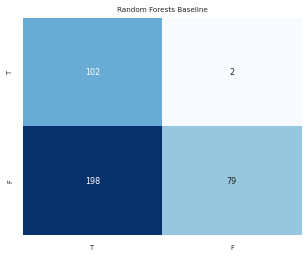

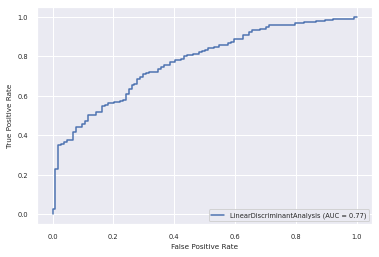

This is the starting index: 2850 of patient 7
0.7938144329896907
[([0], 1, array([0.47381237, 0.52618763])), ([0], 0, array([0.52996426, 0.47003574])), ([0], 0, array([0.60034725, 0.39965275])), ([0], 0, array([0.59435944, 0.40564056])), ([0], 1, array([0.4810889, 0.5189111])), ([0], 0, array([0.60764007, 0.39235993])), ([0], 1, array([0.40213308, 0.59786692])), ([0], 0, array([0.79776232, 0.20223768])), ([0], 0, array([0.53812456, 0.46187544])), ([0], 0, array([0.63323767, 0.36676233])), ([0], 0, array([0.75801368, 0.24198632])), ([0], 1, array([0.35439202, 0.64560798])), ([0], 1, array([0.22023401, 0.77976599])), ([0], 1, array([0.32874286, 0.67125714])), ([0], 0, array([0.55774854, 0.44225146])), ([0], 0, array([0.85215826, 0.14784174])), ([0], 0, array([0.68817364, 0.31182636])), ([0], 0, array([0.52572908, 0.47427092])), ([0], 0, array([0.58813721, 0.41186279])), ([0], 0, array([0.76658604, 0.23341396])), ([0], 0, array([0.51881066, 0.48118934])), ([0], 0, array([0.6931552, 0.3068

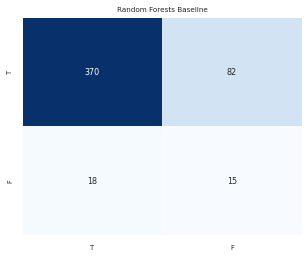

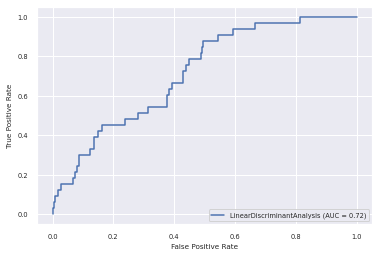

This is the starting index: 3336 of patient 8
0.5899653979238755
[([1], 0, array([0.66131979, 0.33868021])), ([1], 0, array([0.57459365, 0.42540635])), ([0], 0, array([0.79016325, 0.20983675])), ([1], 0, array([0.82583973, 0.17416027])), ([1], 0, array([0.67318965, 0.32681035])), ([1], 1, array([0.34060064, 0.65939936])), ([1], 0, array([0.50764335, 0.49235665])), ([1], 0, array([0.54171038, 0.45828962])), ([1], 0, array([0.57655228, 0.42344772])), ([1], 1, array([0.36045567, 0.63954433])), ([0], 0, array([0.71619524, 0.28380476])), ([1], 0, array([0.6393993, 0.3606007])), ([0], 0, array([0.74261988, 0.25738012])), ([1], 0, array([0.5436201, 0.4563799])), ([1], 1, array([0.28249655, 0.71750345])), ([0], 0, array([0.84325601, 0.15674399])), ([0], 0, array([0.52439069, 0.47560931])), ([1], 0, array([0.81449706, 0.18550294])), ([1], 1, array([0.47155172, 0.52844828])), ([1], 0, array([0.67780842, 0.32219158])), ([1], 1, array([0.32023414, 0.67976586])), ([0], 1, array([0.30406746, 0.69593

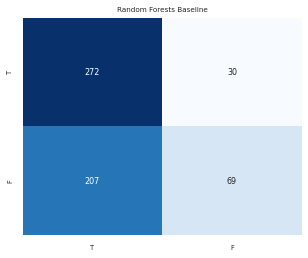

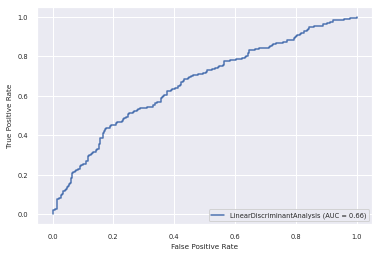

This is the starting index: 3915 of patient 9
0.5339285714285714
[([1], 1, array([0.30362034, 0.69637966])), ([1], 1, array([0.43685302, 0.56314698])), ([1], 1, array([0.27386096, 0.72613904])), ([1], 1, array([0.41856642, 0.58143358])), ([1], 1, array([0.35124762, 0.64875238])), ([1], 1, array([0.40426076, 0.59573924])), ([1], 1, array([0.49089191, 0.50910809])), ([1], 1, array([0.45037316, 0.54962684])), ([1], 1, array([0.40132405, 0.59867595])), ([1], 1, array([0.3131308, 0.6868692])), ([1], 0, array([0.53503575, 0.46496425])), ([1], 1, array([0.3639517, 0.6360483])), ([1], 1, array([0.49235378, 0.50764622])), ([1], 1, array([0.35249901, 0.64750099])), ([1], 1, array([0.37248744, 0.62751256])), ([1], 0, array([0.57343993, 0.42656007])), ([1], 1, array([0.39735753, 0.60264247])), ([1], 1, array([0.33459059, 0.66540941])), ([1], 1, array([0.32258717, 0.67741283])), ([1], 0, array([0.55806866, 0.44193134])), ([1], 1, array([0.39082685, 0.60917315])), ([1], 1, array([0.47939556, 0.52060

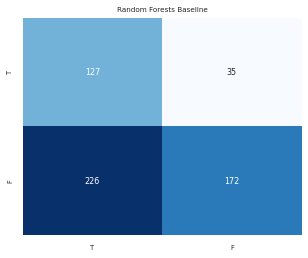

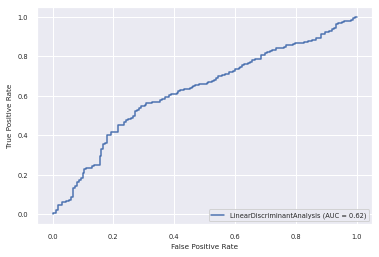

This is the starting index: 4476 of patient 10
0.8385899814471243
[([0], 0, array([0.53949456, 0.46050544])), ([0], 0, array([0.55449858, 0.44550142])), ([0], 0, array([0.58830102, 0.41169898])), ([0], 0, array([0.55936511, 0.44063489])), ([0], 0, array([0.6219275, 0.3780725])), ([0], 0, array([0.53443892, 0.46556108])), ([1], 0, array([0.56071549, 0.43928451])), ([1], 0, array([0.58859278, 0.41140722])), ([0], 0, array([0.66578384, 0.33421616])), ([0], 0, array([0.62686756, 0.37313244])), ([1], 0, array([0.50607832, 0.49392168])), ([1], 0, array([0.63978787, 0.36021213])), ([1], 0, array([0.80867479, 0.19132521])), ([0], 0, array([0.66335537, 0.33664463])), ([0], 0, array([0.74704657, 0.25295343])), ([0], 0, array([0.7888, 0.2112])), ([0], 0, array([0.66189937, 0.33810063])), ([0], 0, array([0.65222041, 0.34777959])), ([1], 0, array([0.54862314, 0.45137686])), ([0], 0, array([0.65492141, 0.34507859])), ([1], 0, array([0.85639798, 0.14360202])), ([0], 1, array([0.45833531, 0.54166469])

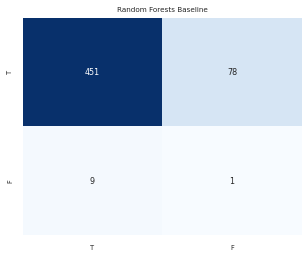

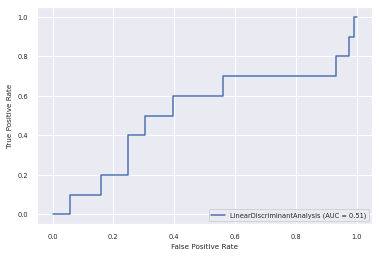

This is the starting index: 5016 of patient 11
0.696969696969697
[([0], 1, array([0.40835854, 0.59164146])), ([0], 0, array([0.5762674, 0.4237326])), ([0], 0, array([0.52482715, 0.47517285])), ([0], 1, array([0.46007257, 0.53992743])), ([0], 1, array([0.37296356, 0.62703644])), ([0], 1, array([0.46074254, 0.53925746])), ([0], 1, array([0.34081469, 0.65918531])), ([0], 1, array([0.41302323, 0.58697677])), ([0], 0, array([0.55292502, 0.44707498])), ([0], 0, array([0.77039049, 0.22960951])), ([0], 0, array([0.62514749, 0.37485251])), ([0], 0, array([0.62748749, 0.37251251])), ([0], 0, array([0.66159304, 0.33840696])), ([1], 0, array([0.64988741, 0.35011259])), ([0], 0, array([0.58907798, 0.41092202])), ([1], 0, array([0.7330704, 0.2669296])), ([0], 0, array([0.77547353, 0.22452647])), ([0], 0, array([0.58514827, 0.41485173])), ([0], 0, array([0.60201537, 0.39798463])), ([1], 0, array([0.64561269, 0.35438731])), ([0], 0, array([0.66080863, 0.33919137])), ([0], 0, array([0.66913329, 0.33086

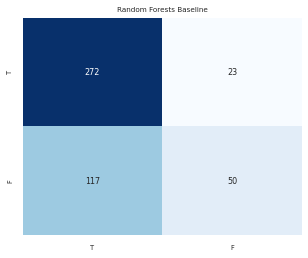

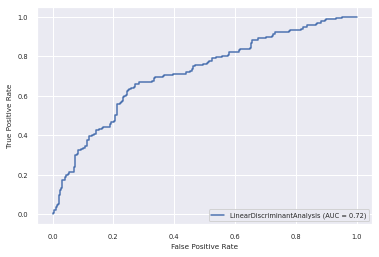

This is the starting index: 5479 of patient 12
0.6705882352941176
[([0], 0, array([0.56747425, 0.43252575])), ([0], 0, array([0.5446633, 0.4553367])), ([0], 1, array([0.48716889, 0.51283111])), ([0], 1, array([0.48871545, 0.51128455])), ([0], 0, array([0.57315442, 0.42684558])), ([0], 1, array([0.49700037, 0.50299963])), ([0], 0, array([0.55153477, 0.44846523])), ([0], 0, array([0.52937397, 0.47062603])), ([0], 1, array([0.44238847, 0.55761153])), ([0], 0, array([0.54152059, 0.45847941])), ([0], 0, array([0.51303257, 0.48696743])), ([0], 0, array([0.587056, 0.412944])), ([0], 0, array([0.58367046, 0.41632954])), ([0], 0, array([0.52709491, 0.47290509])), ([0], 0, array([0.51716928, 0.48283072])), ([0], 0, array([0.52697649, 0.47302351])), ([0], 0, array([0.51902167, 0.48097833])), ([0], 0, array([0.67883861, 0.32116139])), ([0], 0, array([0.58095476, 0.41904524])), ([0], 0, array([0.5625526, 0.4374474])), ([0], 0, array([0.70305371, 0.29694629])), ([0], 0, array([0.53767138, 0.46232862

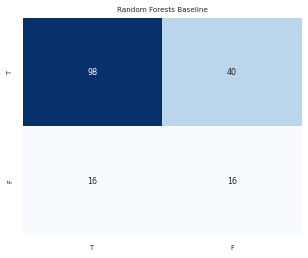

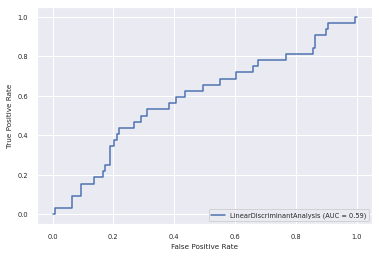

<function matplotlib.pyplot.show>

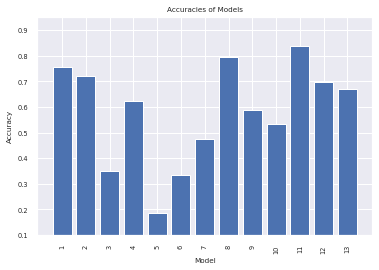

This is the starting index: 0 of patient 0
0.7556719022687609
[([1], 1, array([0.26717886, 0.73282114])), ([1], 1, array([0.49431259, 0.50568741])), ([0], 1, array([0.47422467, 0.52577533])), ([1], 0, array([0.59139669, 0.40860331])), ([1], 1, array([0.29348308, 0.70651692])), ([0], 0, array([0.55958998, 0.44041002])), ([1], 0, array([0.84955929, 0.15044071])), ([0], 0, array([0.57704178, 0.42295822])), ([1], 1, array([0.29047493, 0.70952507])), ([0], 1, array([0.26547639, 0.73452361])), ([0], 0, array([0.54909413, 0.45090587])), ([1], 1, array([0.36204666, 0.63795334])), ([1], 1, array([0.37010988, 0.62989012])), ([0], 0, array([0.70296924, 0.29703076])), ([1], 0, array([0.52043048, 0.47956952])), ([1], 1, array([0.39080759, 0.60919241])), ([1], 1, array([0.35410808, 0.64589192])), ([1], 0, array([0.53118463, 0.46881537])), ([1], 1, array([0.44913334, 0.55086666])), ([1], 1, array([0.44540851, 0.55459149])), ([0], 0, array([0.60337966, 0.39662034])), ([1], 1, array([0.4270111, 0.57298

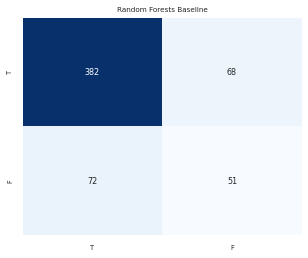

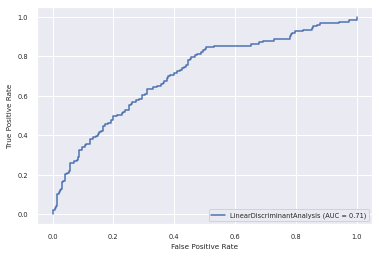

This is the starting index: 574 of patient 1
0.721030042918455
[([0], 0, array([0.5334334, 0.4665666])), ([0], 1, array([0.42523619, 0.57476381])), ([0], 0, array([0.6754194, 0.3245806])), ([0], 1, array([0.30107062, 0.69892938])), ([0], 0, array([0.50517406, 0.49482594])), ([0], 0, array([0.55148286, 0.44851714])), ([1], 1, array([0.29905145, 0.70094855])), ([0], 0, array([0.5248116, 0.4751884])), ([0], 0, array([0.61776789, 0.38223211])), ([0], 1, array([0.30230069, 0.69769931])), ([0], 1, array([0.49995787, 0.50004213])), ([0], 1, array([0.39556114, 0.60443886])), ([1], 1, array([0.36711126, 0.63288874])), ([0], 0, array([0.54129362, 0.45870638])), ([0], 0, array([0.61888789, 0.38111211])), ([0], 0, array([0.72296181, 0.27703819])), ([0], 0, array([0.50828018, 0.49171982])), ([0], 0, array([0.77798204, 0.22201796])), ([1], 0, array([0.50021563, 0.49978437])), ([0], 0, array([0.69302532, 0.30697468])), ([1], 1, array([0.16817056, 0.83182944])), ([0], 0, array([0.7168914, 0.2831086]))

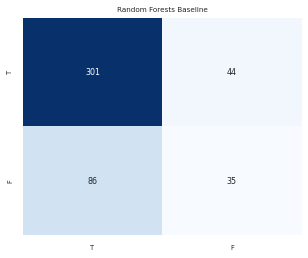

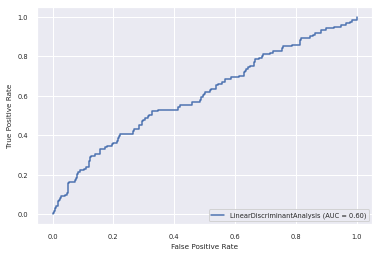

This is the starting index: 1041 of patient 2
0.3515358361774744
[([1], 1, array([0.38245219, 0.61754781])), ([0], 1, array([0.23552344, 0.76447656])), ([0], 1, array([0.16412465, 0.83587535])), ([1], 1, array([0.11336473, 0.88663527])), ([0], 1, array([0.13710505, 0.86289495])), ([0], 1, array([0.24201347, 0.75798653])), ([0], 1, array([0.07568805, 0.92431195])), ([1], 1, array([0.13264496, 0.86735504])), ([1], 1, array([0.22800325, 0.77199675])), ([1], 1, array([0.34214652, 0.65785348])), ([1], 1, array([0.14665716, 0.85334284])), ([1], 1, array([0.28917643, 0.71082357])), ([1], 1, array([0.26270918, 0.73729082])), ([0], 1, array([0.32599176, 0.67400824])), ([1], 1, array([0.37493725, 0.62506275])), ([1], 0, array([0.51651838, 0.48348162])), ([0], 1, array([0.32275461, 0.67724539])), ([0], 1, array([0.21011537, 0.78988463])), ([0], 1, array([0.16391378, 0.83608622])), ([0], 0, array([0.60722058, 0.39277942])), ([0], 1, array([0.06149001, 0.93850999])), ([0], 1, array([0.44885708, 0.5

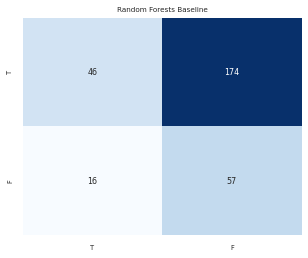

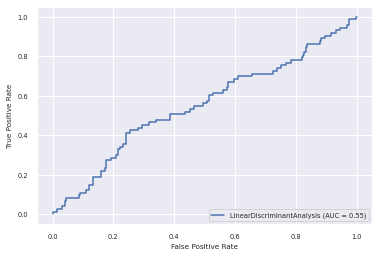

This is the starting index: 1335 of patient 3
0.6243386243386243
[([0], 0, array([0.52697108, 0.47302892])), ([1], 1, array([0.32644783, 0.67355217])), ([1], 1, array([0.44792263, 0.55207737])), ([1], 1, array([0.44618681, 0.55381319])), ([1], 1, array([0.17474521, 0.82525479])), ([1], 0, array([0.54344333, 0.45655667])), ([1], 0, array([0.57095542, 0.42904458])), ([0], 1, array([0.42328099, 0.57671901])), ([0], 0, array([0.53891838, 0.46108162])), ([0], 0, array([0.5939079, 0.4060921])), ([0], 1, array([0.40336959, 0.59663041])), ([0], 1, array([0.3833297, 0.6166703])), ([0], 0, array([0.62841095, 0.37158905])), ([1], 1, array([0.43345274, 0.56654726])), ([0], 0, array([0.55888478, 0.44111522])), ([0], 1, array([0.46495453, 0.53504547])), ([0], 0, array([0.54367154, 0.45632846])), ([0], 1, array([0.26101655, 0.73898345])), ([0], 1, array([0.46534232, 0.53465768])), ([0], 0, array([0.74280714, 0.25719286])), ([0], 0, array([0.57784618, 0.42215382])), ([0], 1, array([0.39554813, 0.60445

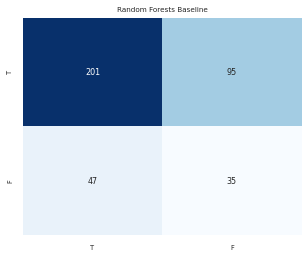

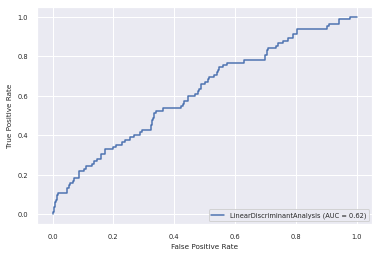

This is the starting index: 1714 of patient 4
0.18604651162790697
[([1], 1, array([0.4888835, 0.5111165])), ([1], 0, array([0.63321885, 0.36678115])), ([1], 0, array([0.65405819, 0.34594181])), ([1], 1, array([0.44704728, 0.55295272])), ([1], 1, array([0.49244738, 0.50755262])), ([1], 0, array([0.57727062, 0.42272938])), ([1], 0, array([0.57675007, 0.42324993])), ([1], 0, array([0.60096489, 0.39903511])), ([1], 0, array([0.75405737, 0.24594263])), ([1], 1, array([0.37295265, 0.62704735])), ([1], 0, array([0.63909493, 0.36090507])), ([1], 0, array([0.64472388, 0.35527612])), ([1], 1, array([0.49962064, 0.50037936])), ([1], 1, array([0.45616976, 0.54383024])), ([1], 0, array([0.53252734, 0.46747266])), ([1], 0, array([0.58035553, 0.41964447])), ([1], 0, array([0.65431451, 0.34568549])), ([1], 0, array([0.56626451, 0.43373549])), ([1], 0, array([0.58292073, 0.41707927])), ([1], 0, array([0.58356917, 0.41643083])), ([1], 0, array([0.61387981, 0.38612019])), ([1], 0, array([0.64247436, 0.35

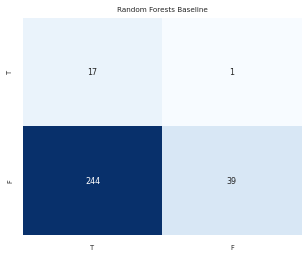

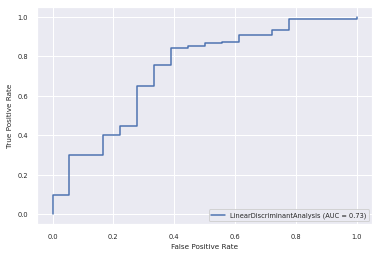

This is the starting index: 2016 of patient 5
0.3325942350332594
[([0], 0, array([0.63494522, 0.36505478])), ([0], 0, array([0.80124731, 0.19875269])), ([0], 0, array([0.63399292, 0.36600708])), ([0], 0, array([0.81617333, 0.18382667])), ([0], 0, array([0.80033507, 0.19966493])), ([0], 0, array([0.79040702, 0.20959298])), ([1], 0, array([0.69462117, 0.30537883])), ([1], 0, array([0.82977344, 0.17022656])), ([1], 0, array([0.71904443, 0.28095557])), ([1], 0, array([0.67835598, 0.32164402])), ([0], 0, array([0.75075848, 0.24924152])), ([1], 0, array([0.80086516, 0.19913484])), ([0], 0, array([0.7230839, 0.2769161])), ([1], 0, array([0.69643623, 0.30356377])), ([1], 0, array([0.82973222, 0.17026778])), ([1], 0, array([0.50898664, 0.49101336])), ([1], 0, array([0.56457566, 0.43542434])), ([1], 0, array([0.68491243, 0.31508757])), ([1], 0, array([0.7317202, 0.2682798])), ([1], 0, array([0.73886633, 0.26113367])), ([1], 1, array([0.39338546, 0.60661454])), ([1], 0, array([0.70655965, 0.29344

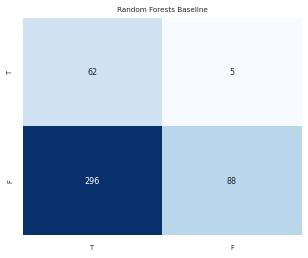

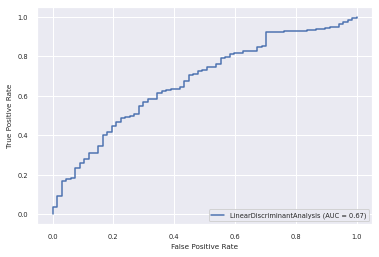

This is the starting index: 2468 of patient 6
0.47506561679790027
[([1], 1, array([0.39388456, 0.60611544])), ([1], 1, array([0.427215, 0.572785])), ([1], 1, array([0.46840947, 0.53159053])), ([1], 0, array([0.62329526, 0.37670474])), ([1], 0, array([0.58395023, 0.41604977])), ([1], 0, array([0.67387612, 0.32612388])), ([1], 1, array([0.37991445, 0.62008555])), ([1], 0, array([0.84517863, 0.15482137])), ([1], 0, array([0.50112835, 0.49887165])), ([1], 0, array([0.64613346, 0.35386654])), ([0], 0, array([0.78943774, 0.21056226])), ([1], 1, array([0.16288689, 0.83711311])), ([1], 0, array([0.71356522, 0.28643478])), ([1], 1, array([0.19332468, 0.80667532])), ([1], 1, array([0.49146972, 0.50853028])), ([1], 1, array([0.32184383, 0.67815617])), ([1], 1, array([0.06658334, 0.93341666])), ([1], 1, array([0.44860372, 0.55139628])), ([1], 0, array([0.52518574, 0.47481426])), ([0], 0, array([0.94786495, 0.05213505])), ([1], 0, array([0.68773218, 0.31226782])), ([1], 0, array([0.54940567, 0.4505

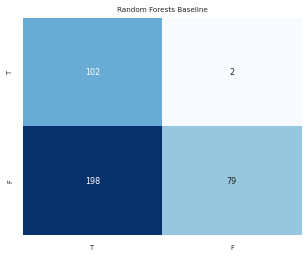

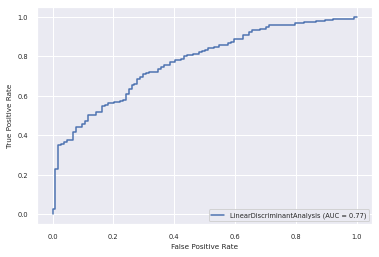

This is the starting index: 2850 of patient 7
0.7938144329896907
[([0], 1, array([0.47381237, 0.52618763])), ([0], 0, array([0.52996426, 0.47003574])), ([0], 0, array([0.60034725, 0.39965275])), ([0], 0, array([0.59435944, 0.40564056])), ([0], 1, array([0.4810889, 0.5189111])), ([0], 0, array([0.60764007, 0.39235993])), ([0], 1, array([0.40213308, 0.59786692])), ([0], 0, array([0.79776232, 0.20223768])), ([0], 0, array([0.53812456, 0.46187544])), ([0], 0, array([0.63323767, 0.36676233])), ([0], 0, array([0.75801368, 0.24198632])), ([0], 1, array([0.35439202, 0.64560798])), ([0], 1, array([0.22023401, 0.77976599])), ([0], 1, array([0.32874286, 0.67125714])), ([0], 0, array([0.55774854, 0.44225146])), ([0], 0, array([0.85215826, 0.14784174])), ([0], 0, array([0.68817364, 0.31182636])), ([0], 0, array([0.52572908, 0.47427092])), ([0], 0, array([0.58813721, 0.41186279])), ([0], 0, array([0.76658604, 0.23341396])), ([0], 0, array([0.51881066, 0.48118934])), ([0], 0, array([0.6931552, 0.3068

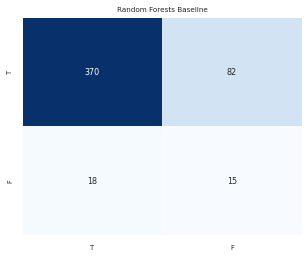

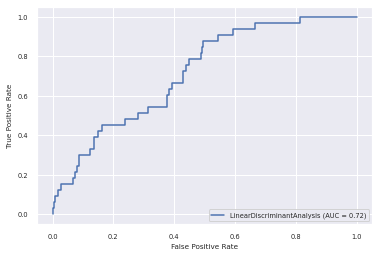

This is the starting index: 3336 of patient 8
0.5899653979238755
[([1], 0, array([0.66131979, 0.33868021])), ([1], 0, array([0.57459365, 0.42540635])), ([0], 0, array([0.79016325, 0.20983675])), ([1], 0, array([0.82583973, 0.17416027])), ([1], 0, array([0.67318965, 0.32681035])), ([1], 1, array([0.34060064, 0.65939936])), ([1], 0, array([0.50764335, 0.49235665])), ([1], 0, array([0.54171038, 0.45828962])), ([1], 0, array([0.57655228, 0.42344772])), ([1], 1, array([0.36045567, 0.63954433])), ([0], 0, array([0.71619524, 0.28380476])), ([1], 0, array([0.6393993, 0.3606007])), ([0], 0, array([0.74261988, 0.25738012])), ([1], 0, array([0.5436201, 0.4563799])), ([1], 1, array([0.28249655, 0.71750345])), ([0], 0, array([0.84325601, 0.15674399])), ([0], 0, array([0.52439069, 0.47560931])), ([1], 0, array([0.81449706, 0.18550294])), ([1], 1, array([0.47155172, 0.52844828])), ([1], 0, array([0.67780842, 0.32219158])), ([1], 1, array([0.32023414, 0.67976586])), ([0], 1, array([0.30406746, 0.69593

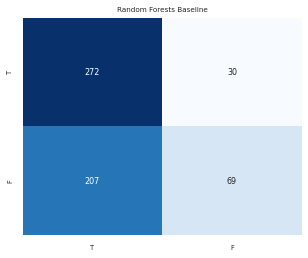

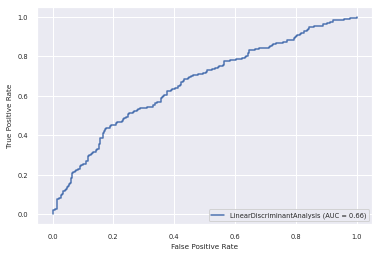

This is the starting index: 3915 of patient 9
0.5339285714285714
[([1], 1, array([0.30362034, 0.69637966])), ([1], 1, array([0.43685302, 0.56314698])), ([1], 1, array([0.27386096, 0.72613904])), ([1], 1, array([0.41856642, 0.58143358])), ([1], 1, array([0.35124762, 0.64875238])), ([1], 1, array([0.40426076, 0.59573924])), ([1], 1, array([0.49089191, 0.50910809])), ([1], 1, array([0.45037316, 0.54962684])), ([1], 1, array([0.40132405, 0.59867595])), ([1], 1, array([0.3131308, 0.6868692])), ([1], 0, array([0.53503575, 0.46496425])), ([1], 1, array([0.3639517, 0.6360483])), ([1], 1, array([0.49235378, 0.50764622])), ([1], 1, array([0.35249901, 0.64750099])), ([1], 1, array([0.37248744, 0.62751256])), ([1], 0, array([0.57343993, 0.42656007])), ([1], 1, array([0.39735753, 0.60264247])), ([1], 1, array([0.33459059, 0.66540941])), ([1], 1, array([0.32258717, 0.67741283])), ([1], 0, array([0.55806866, 0.44193134])), ([1], 1, array([0.39082685, 0.60917315])), ([1], 1, array([0.47939556, 0.52060

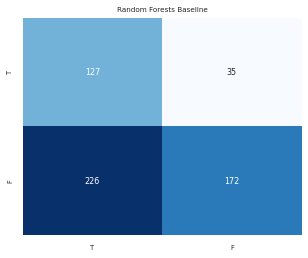

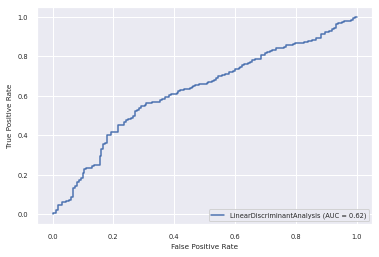

This is the starting index: 4476 of patient 10
0.8385899814471243
[([0], 0, array([0.53949456, 0.46050544])), ([0], 0, array([0.55449858, 0.44550142])), ([0], 0, array([0.58830102, 0.41169898])), ([0], 0, array([0.55936511, 0.44063489])), ([0], 0, array([0.6219275, 0.3780725])), ([0], 0, array([0.53443892, 0.46556108])), ([1], 0, array([0.56071549, 0.43928451])), ([1], 0, array([0.58859278, 0.41140722])), ([0], 0, array([0.66578384, 0.33421616])), ([0], 0, array([0.62686756, 0.37313244])), ([1], 0, array([0.50607832, 0.49392168])), ([1], 0, array([0.63978787, 0.36021213])), ([1], 0, array([0.80867479, 0.19132521])), ([0], 0, array([0.66335537, 0.33664463])), ([0], 0, array([0.74704657, 0.25295343])), ([0], 0, array([0.7888, 0.2112])), ([0], 0, array([0.66189937, 0.33810063])), ([0], 0, array([0.65222041, 0.34777959])), ([1], 0, array([0.54862314, 0.45137686])), ([0], 0, array([0.65492141, 0.34507859])), ([1], 0, array([0.85639798, 0.14360202])), ([0], 1, array([0.45833531, 0.54166469])

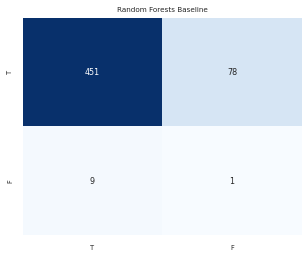

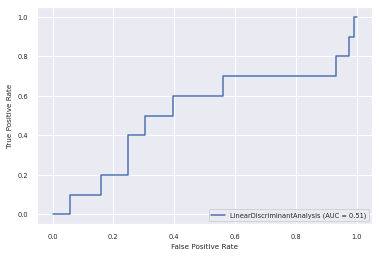

This is the starting index: 5016 of patient 11
0.696969696969697
[([0], 1, array([0.40835854, 0.59164146])), ([0], 0, array([0.5762674, 0.4237326])), ([0], 0, array([0.52482715, 0.47517285])), ([0], 1, array([0.46007257, 0.53992743])), ([0], 1, array([0.37296356, 0.62703644])), ([0], 1, array([0.46074254, 0.53925746])), ([0], 1, array([0.34081469, 0.65918531])), ([0], 1, array([0.41302323, 0.58697677])), ([0], 0, array([0.55292502, 0.44707498])), ([0], 0, array([0.77039049, 0.22960951])), ([0], 0, array([0.62514749, 0.37485251])), ([0], 0, array([0.62748749, 0.37251251])), ([0], 0, array([0.66159304, 0.33840696])), ([1], 0, array([0.64988741, 0.35011259])), ([0], 0, array([0.58907798, 0.41092202])), ([1], 0, array([0.7330704, 0.2669296])), ([0], 0, array([0.77547353, 0.22452647])), ([0], 0, array([0.58514827, 0.41485173])), ([0], 0, array([0.60201537, 0.39798463])), ([1], 0, array([0.64561269, 0.35438731])), ([0], 0, array([0.66080863, 0.33919137])), ([0], 0, array([0.66913329, 0.33086

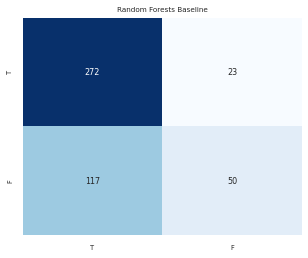

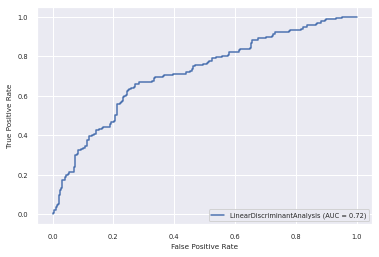

This is the starting index: 5479 of patient 12
0.6705882352941176
[([0], 0, array([0.56747425, 0.43252575])), ([0], 0, array([0.5446633, 0.4553367])), ([0], 1, array([0.48716889, 0.51283111])), ([0], 1, array([0.48871545, 0.51128455])), ([0], 0, array([0.57315442, 0.42684558])), ([0], 1, array([0.49700037, 0.50299963])), ([0], 0, array([0.55153477, 0.44846523])), ([0], 0, array([0.52937397, 0.47062603])), ([0], 1, array([0.44238847, 0.55761153])), ([0], 0, array([0.54152059, 0.45847941])), ([0], 0, array([0.51303257, 0.48696743])), ([0], 0, array([0.587056, 0.412944])), ([0], 0, array([0.58367046, 0.41632954])), ([0], 0, array([0.52709491, 0.47290509])), ([0], 0, array([0.51716928, 0.48283072])), ([0], 0, array([0.52697649, 0.47302351])), ([0], 0, array([0.51902167, 0.48097833])), ([0], 0, array([0.67883861, 0.32116139])), ([0], 0, array([0.58095476, 0.41904524])), ([0], 0, array([0.5625526, 0.4374474])), ([0], 0, array([0.70305371, 0.29694629])), ([0], 0, array([0.53767138, 0.46232862

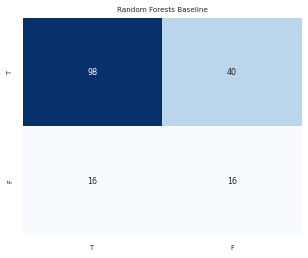

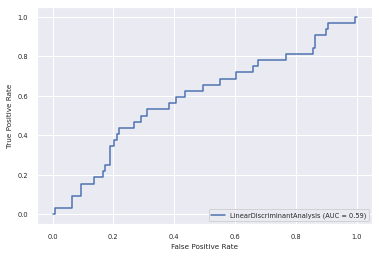

<function matplotlib.pyplot.show>

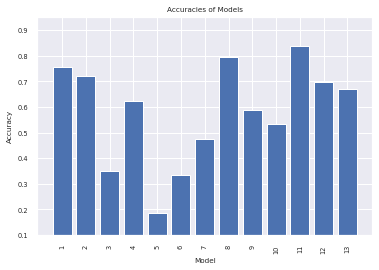

In [ ]:
Accuracy = []
clf = LinearDiscriminantAnalysis()
sel = VarianceThreshold(threshold=(.1 * (1 - .8)))
for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    sel.fit_transform(train)
    sel.fit_transform(test)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### L1-based feature selection

This is the starting index: 0 of patient 0
0.7417102966841187
[([1], 1, array([0.35981535, 0.64018465])), ([1], 0, array([0.52544443, 0.47455557])), ([0], 1, array([0.47567165, 0.52432835])), ([1], 0, array([0.52039402, 0.47960598])), ([1], 1, array([0.28815058, 0.71184942])), ([0], 0, array([0.548816, 0.451184])), ([1], 0, array([0.68125544, 0.31874456])), ([0], 0, array([0.71007474, 0.28992526])), ([1], 1, array([0.34522767, 0.65477233])), ([0], 1, array([0.2909611, 0.7090389])), ([0], 1, array([0.45638708, 0.54361292])), ([1], 1, array([0.37248337, 0.62751663])), ([1], 1, array([0.40203726, 0.59796274])), ([0], 0, array([0.6787352, 0.3212648])), ([1], 1, array([0.47990698, 0.52009302])), ([1], 1, array([0.41752189, 0.58247811])), ([1], 1, array([0.35546751, 0.64453249])), ([1], 1, array([0.47619916, 0.52380084])), ([1], 1, array([0.40932028, 0.59067972])), ([1], 0, array([0.51344027, 0.48655973])), ([0], 0, array([0.57614799, 0.42385201])), ([1], 1, array([0.42568595, 0.57431405])),

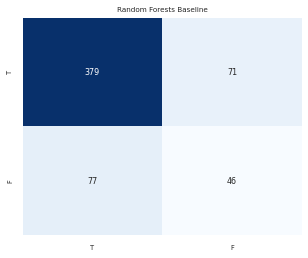

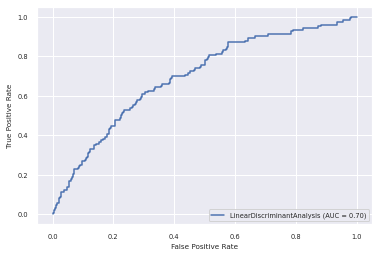

This is the starting index: 574 of patient 1
0.7124463519313304
[([0], 0, array([0.59299681, 0.40700319])), ([0], 0, array([0.51532015, 0.48467985])), ([0], 0, array([0.57635706, 0.42364294])), ([0], 1, array([0.40137197, 0.59862803])), ([0], 1, array([0.45941311, 0.54058689])), ([0], 0, array([0.65807882, 0.34192118])), ([1], 1, array([0.41710858, 0.58289142])), ([0], 0, array([0.54027843, 0.45972157])), ([0], 0, array([0.68526161, 0.31473839])), ([0], 1, array([0.35572842, 0.64427158])), ([0], 0, array([0.53050451, 0.46949549])), ([0], 0, array([0.51735435, 0.48264565])), ([1], 1, array([0.47616076, 0.52383924])), ([0], 0, array([0.59378029, 0.40621971])), ([0], 0, array([0.6401427, 0.3598573])), ([0], 0, array([0.59636815, 0.40363185])), ([0], 0, array([0.58744244, 0.41255756])), ([0], 0, array([0.70807503, 0.29192497])), ([1], 0, array([0.55665714, 0.44334286])), ([0], 0, array([0.76588086, 0.23411914])), ([1], 1, array([0.2812508, 0.7187492])), ([0], 0, array([0.59663667, 0.403363

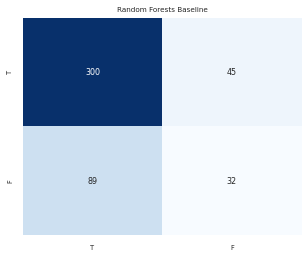

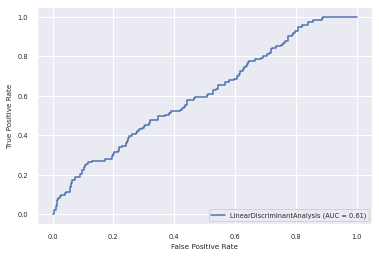

This is the starting index: 1041 of patient 2
0.43686006825938567
[([1], 0, array([0.58700803, 0.41299197])), ([0], 1, array([0.17864567, 0.82135433])), ([0], 1, array([0.18652675, 0.81347325])), ([1], 1, array([0.17480642, 0.82519358])), ([0], 1, array([0.13073518, 0.86926482])), ([0], 1, array([0.20277156, 0.79722844])), ([0], 1, array([0.09180599, 0.90819401])), ([1], 1, array([0.18645221, 0.81354779])), ([1], 1, array([0.1880813, 0.8119187])), ([1], 1, array([0.37295486, 0.62704514])), ([1], 1, array([0.31269494, 0.68730506])), ([1], 1, array([0.32791667, 0.67208333])), ([1], 1, array([0.17820216, 0.82179784])), ([0], 1, array([0.47439584, 0.52560416])), ([1], 1, array([0.42802333, 0.57197667])), ([1], 0, array([0.51126378, 0.48873622])), ([0], 1, array([0.35309988, 0.64690012])), ([0], 1, array([0.17414753, 0.82585247])), ([0], 1, array([0.33741014, 0.66258986])), ([0], 0, array([0.62809347, 0.37190653])), ([0], 1, array([0.18189385, 0.81810615])), ([0], 1, array([0.32005129, 0.67

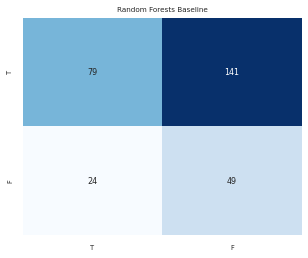

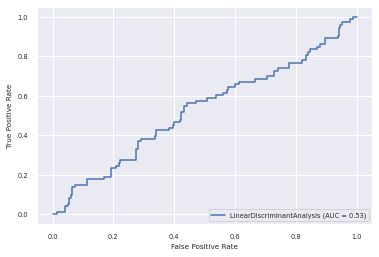

This is the starting index: 1335 of patient 3
0.6587301587301587
[([0], 0, array([0.63944759, 0.36055241])), ([1], 1, array([0.45325758, 0.54674242])), ([1], 0, array([0.53713295, 0.46286705])), ([1], 1, array([0.43260361, 0.56739639])), ([1], 1, array([0.25723631, 0.74276369])), ([1], 0, array([0.68527644, 0.31472356])), ([1], 0, array([0.55720565, 0.44279435])), ([0], 0, array([0.59562094, 0.40437906])), ([0], 0, array([0.60704633, 0.39295367])), ([0], 1, array([0.39983458, 0.60016542])), ([0], 1, array([0.4427783, 0.5572217])), ([0], 1, array([0.46584961, 0.53415039])), ([0], 1, array([0.47312758, 0.52687242])), ([1], 0, array([0.59680261, 0.40319739])), ([0], 1, array([0.45526138, 0.54473862])), ([0], 1, array([0.48404057, 0.51595943])), ([0], 0, array([0.58225352, 0.41774648])), ([0], 1, array([0.18503077, 0.81496923])), ([0], 0, array([0.55698197, 0.44301803])), ([0], 0, array([0.52026562, 0.47973438])), ([0], 0, array([0.71476797, 0.28523203])), ([0], 0, array([0.50212839, 0.497

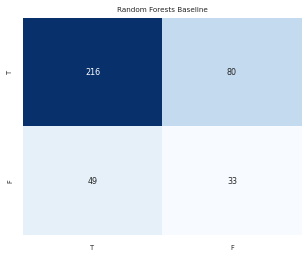

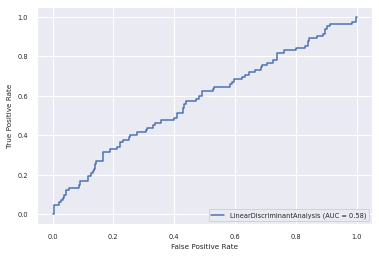

This is the starting index: 1714 of patient 4
0.1461794019933555
[([1], 0, array([0.66795786, 0.33204214])), ([1], 0, array([0.61646756, 0.38353244])), ([1], 0, array([0.70287824, 0.29712176])), ([1], 0, array([0.58217767, 0.41782233])), ([1], 0, array([0.56826882, 0.43173118])), ([1], 0, array([0.60430401, 0.39569599])), ([1], 0, array([0.59898212, 0.40101788])), ([1], 0, array([0.66031306, 0.33968694])), ([1], 0, array([0.63360881, 0.36639119])), ([1], 1, array([0.45278521, 0.54721479])), ([1], 0, array([0.67370928, 0.32629072])), ([1], 0, array([0.7373341, 0.2626659])), ([1], 0, array([0.55152725, 0.44847275])), ([1], 1, array([0.27024731, 0.72975269])), ([1], 0, array([0.57533566, 0.42466434])), ([1], 0, array([0.58783553, 0.41216447])), ([1], 0, array([0.66051361, 0.33948639])), ([1], 0, array([0.70100816, 0.29899184])), ([1], 0, array([0.69259355, 0.30740645])), ([1], 0, array([0.66101555, 0.33898445])), ([1], 0, array([0.69701941, 0.30298059])), ([1], 0, array([0.56353268, 0.436

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


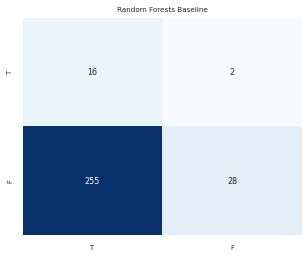

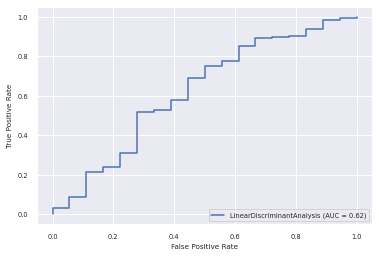

This is the starting index: 2016 of patient 5
0.3215077605321508
[([0], 0, array([0.64926517, 0.35073483])), ([0], 0, array([0.75859915, 0.24140085])), ([0], 0, array([0.70826254, 0.29173746])), ([0], 0, array([0.79017466, 0.20982534])), ([0], 0, array([0.77965846, 0.22034154])), ([0], 0, array([0.75279787, 0.24720213])), ([1], 0, array([0.67119397, 0.32880603])), ([1], 0, array([0.82630998, 0.17369002])), ([1], 0, array([0.75475479, 0.24524521])), ([1], 0, array([0.70451714, 0.29548286])), ([0], 0, array([0.72067014, 0.27932986])), ([1], 0, array([0.80876501, 0.19123499])), ([0], 0, array([0.73701393, 0.26298607])), ([1], 0, array([0.8044037, 0.1955963])), ([1], 0, array([0.76626502, 0.23373498])), ([1], 0, array([0.57844314, 0.42155686])), ([1], 0, array([0.67256856, 0.32743144])), ([1], 0, array([0.66874142, 0.33125858])), ([1], 0, array([0.73889143, 0.26110857])), ([1], 0, array([0.7160526, 0.2839474])), ([1], 1, array([0.46436132, 0.53563868])), ([1], 0, array([0.7334616, 0.266538

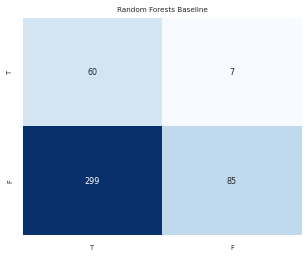

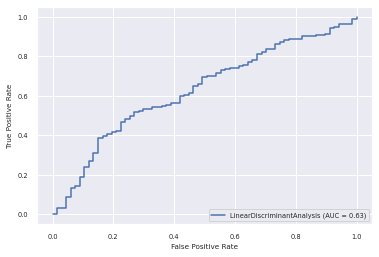

This is the starting index: 2468 of patient 6
0.4068241469816273
[([1], 0, array([0.54555758, 0.45444242])), ([1], 0, array([0.50758219, 0.49241781])), ([1], 1, array([0.39835348, 0.60164652])), ([1], 0, array([0.60657874, 0.39342126])), ([1], 0, array([0.58051952, 0.41948048])), ([1], 0, array([0.62827114, 0.37172886])), ([1], 1, array([0.48642508, 0.51357492])), ([1], 0, array([0.81430086, 0.18569914])), ([1], 0, array([0.63752468, 0.36247532])), ([1], 0, array([0.6694313, 0.3305687])), ([0], 0, array([0.75139905, 0.24860095])), ([1], 0, array([0.56689033, 0.43310967])), ([1], 0, array([0.74519459, 0.25480541])), ([1], 1, array([0.32091817, 0.67908183])), ([1], 0, array([0.75434783, 0.24565217])), ([1], 1, array([0.26221741, 0.73778259])), ([1], 1, array([0.44553452, 0.55446548])), ([1], 0, array([0.60638123, 0.39361877])), ([1], 0, array([0.54025307, 0.45974693])), ([0], 0, array([0.79133385, 0.20866615])), ([1], 0, array([0.69633392, 0.30366608])), ([1], 0, array([0.60178706, 0.398

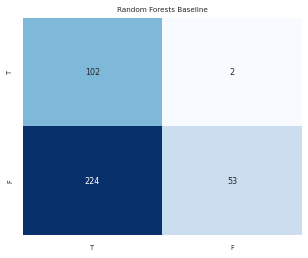

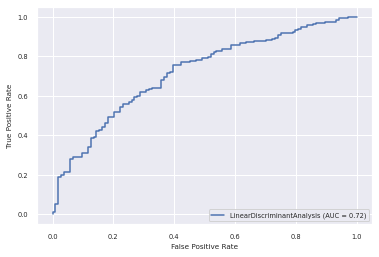

This is the starting index: 2850 of patient 7
0.756701030927835
[([0], 1, array([0.35320077, 0.64679923])), ([0], 1, array([0.47530241, 0.52469759])), ([0], 0, array([0.51745267, 0.48254733])), ([0], 0, array([0.55841654, 0.44158346])), ([0], 1, array([0.41944282, 0.58055718])), ([0], 0, array([0.60128792, 0.39871208])), ([0], 1, array([0.4822216, 0.5177784])), ([0], 0, array([0.79916606, 0.20083394])), ([0], 0, array([0.51003361, 0.48996639])), ([0], 0, array([0.55657917, 0.44342083])), ([0], 0, array([0.7102299, 0.2897701])), ([0], 1, array([0.36106299, 0.63893701])), ([0], 1, array([0.32323626, 0.67676374])), ([0], 1, array([0.30313343, 0.69686657])), ([0], 1, array([0.45202034, 0.54797966])), ([0], 0, array([0.79325213, 0.20674787])), ([0], 0, array([0.65800796, 0.34199204])), ([0], 0, array([0.66561295, 0.33438705])), ([0], 0, array([0.53253184, 0.46746816])), ([0], 0, array([0.69633361, 0.30366639])), ([0], 1, array([0.46802371, 0.53197629])), ([0], 0, array([0.7125416, 0.2874584

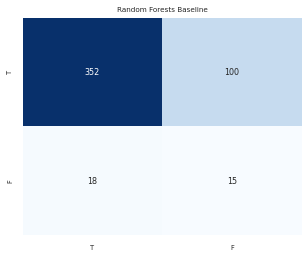

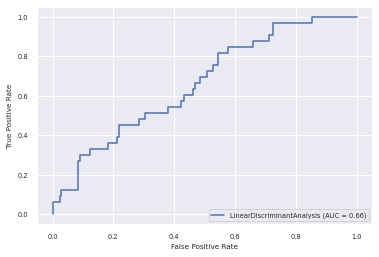

This is the starting index: 3336 of patient 8
0.6020761245674741
[([1], 0, array([0.67968724, 0.32031276])), ([1], 0, array([0.52379418, 0.47620582])), ([0], 0, array([0.74246436, 0.25753564])), ([1], 0, array([0.72658745, 0.27341255])), ([1], 0, array([0.59228961, 0.40771039])), ([1], 1, array([0.39852656, 0.60147344])), ([1], 0, array([0.59531458, 0.40468542])), ([1], 0, array([0.60710104, 0.39289896])), ([1], 0, array([0.54331147, 0.45668853])), ([1], 1, array([0.43921574, 0.56078426])), ([0], 0, array([0.63466271, 0.36533729])), ([1], 0, array([0.64587613, 0.35412387])), ([0], 0, array([0.75413027, 0.24586973])), ([1], 0, array([0.66263964, 0.33736036])), ([1], 1, array([0.40368014, 0.59631986])), ([0], 0, array([0.7894694, 0.2105306])), ([0], 1, array([0.49437692, 0.50562308])), ([1], 0, array([0.7960101, 0.2039899])), ([1], 1, array([0.48617835, 0.51382165])), ([1], 0, array([0.78793414, 0.21206586])), ([1], 1, array([0.35602904, 0.64397096])), ([0], 1, array([0.43216068, 0.56783

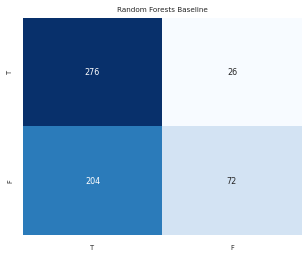

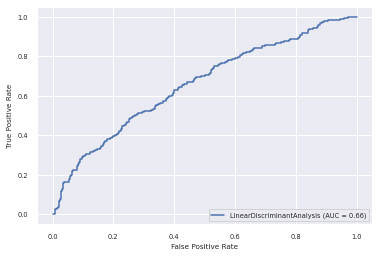

This is the starting index: 3915 of patient 9
0.42142857142857143
[([1], 1, array([0.38814027, 0.61185973])), ([1], 0, array([0.52302658, 0.47697342])), ([1], 1, array([0.34179155, 0.65820845])), ([1], 1, array([0.37336879, 0.62663121])), ([1], 0, array([0.60221169, 0.39778831])), ([1], 0, array([0.52550067, 0.47449933])), ([1], 1, array([0.45537666, 0.54462334])), ([1], 1, array([0.49552277, 0.50447723])), ([1], 1, array([0.48914184, 0.51085816])), ([1], 0, array([0.52746534, 0.47253466])), ([1], 1, array([0.47959386, 0.52040614])), ([1], 1, array([0.40662005, 0.59337995])), ([1], 0, array([0.5255453, 0.4744547])), ([1], 1, array([0.4477399, 0.5522601])), ([1], 0, array([0.54693094, 0.45306906])), ([1], 0, array([0.57634135, 0.42365865])), ([1], 1, array([0.37872646, 0.62127354])), ([1], 0, array([0.53000808, 0.46999192])), ([1], 1, array([0.42544713, 0.57455287])), ([1], 0, array([0.61708577, 0.38291423])), ([1], 0, array([0.52119854, 0.47880146])), ([1], 1, array([0.40459195, 0.5954

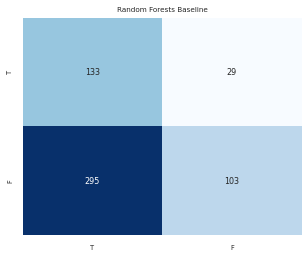

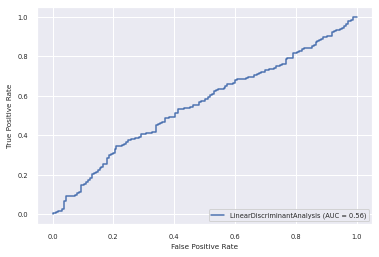

This is the starting index: 4476 of patient 10
0.8701298701298701
[([0], 0, array([0.58534084, 0.41465916])), ([0], 0, array([0.55623716, 0.44376284])), ([0], 0, array([0.55643497, 0.44356503])), ([0], 0, array([0.53800455, 0.46199545])), ([0], 0, array([0.56563123, 0.43436877])), ([0], 0, array([0.53529789, 0.46470211])), ([1], 0, array([0.51521491, 0.48478509])), ([1], 0, array([0.64196046, 0.35803954])), ([0], 0, array([0.5937487, 0.4062513])), ([0], 0, array([0.52870501, 0.47129499])), ([1], 0, array([0.54156331, 0.45843669])), ([1], 0, array([0.63121215, 0.36878785])), ([1], 0, array([0.7080279, 0.2919721])), ([0], 0, array([0.64012433, 0.35987567])), ([0], 0, array([0.71820041, 0.28179959])), ([0], 0, array([0.68227899, 0.31772101])), ([0], 0, array([0.70835268, 0.29164732])), ([0], 0, array([0.50477517, 0.49522483])), ([1], 0, array([0.57401805, 0.42598195])), ([0], 0, array([0.61722438, 0.38277562])), ([1], 0, array([0.73848626, 0.26151374])), ([0], 1, array([0.45619035, 0.5438

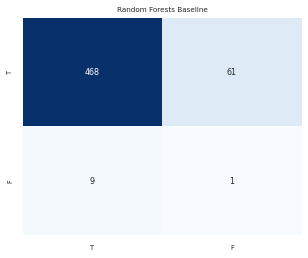

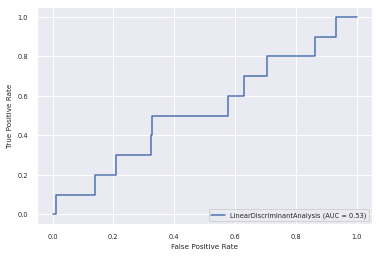

This is the starting index: 5016 of patient 11
0.6536796536796536
[([0], 1, array([0.38353222, 0.61646778])), ([0], 1, array([0.2813436, 0.7186564])), ([0], 0, array([0.528536, 0.471464])), ([0], 0, array([0.55765718, 0.44234282])), ([0], 1, array([0.28133149, 0.71866851])), ([0], 0, array([0.52347754, 0.47652246])), ([0], 1, array([0.26882507, 0.73117493])), ([0], 0, array([0.5718102, 0.4281898])), ([0], 0, array([0.6320715, 0.3679285])), ([0], 0, array([0.71662956, 0.28337044])), ([0], 0, array([0.53884184, 0.46115816])), ([0], 0, array([0.5672072, 0.4327928])), ([0], 0, array([0.58889692, 0.41110308])), ([1], 0, array([0.66644621, 0.33355379])), ([0], 0, array([0.595458, 0.404542])), ([1], 0, array([0.69999812, 0.30000188])), ([0], 0, array([0.7228601, 0.2771399])), ([0], 0, array([0.68062535, 0.31937465])), ([0], 0, array([0.65003189, 0.34996811])), ([1], 0, array([0.68868228, 0.31131772])), ([0], 0, array([0.65764002, 0.34235998])), ([0], 0, array([0.64908174, 0.35091826])), ([0],

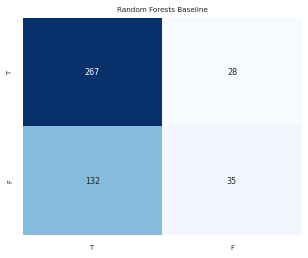

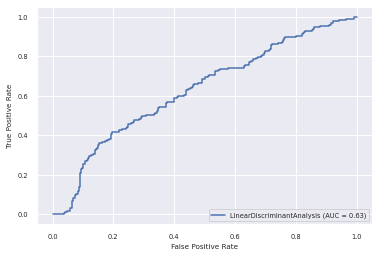

This is the starting index: 5479 of patient 12
0.6235294117647059
[([0], 0, array([0.53308288, 0.46691712])), ([0], 0, array([0.54134241, 0.45865759])), ([0], 1, array([0.45061694, 0.54938306])), ([0], 0, array([0.50369199, 0.49630801])), ([0], 0, array([0.66241655, 0.33758345])), ([0], 0, array([0.58637767, 0.41362233])), ([0], 0, array([0.52706708, 0.47293292])), ([0], 0, array([0.51320386, 0.48679614])), ([0], 0, array([0.50917009, 0.49082991])), ([0], 0, array([0.61944425, 0.38055575])), ([0], 0, array([0.55208787, 0.44791213])), ([0], 0, array([0.54639853, 0.45360147])), ([0], 0, array([0.56463997, 0.43536003])), ([0], 0, array([0.566704, 0.433296])), ([0], 0, array([0.54325344, 0.45674656])), ([0], 1, array([0.44330198, 0.55669802])), ([0], 0, array([0.53312156, 0.46687844])), ([0], 0, array([0.64871875, 0.35128125])), ([0], 0, array([0.54694121, 0.45305879])), ([0], 0, array([0.53370107, 0.46629893])), ([0], 0, array([0.61714992, 0.38285008])), ([0], 0, array([0.5329079, 0.46709

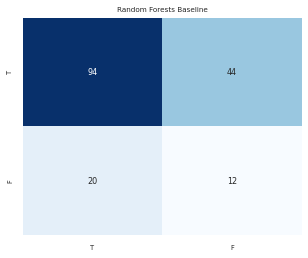

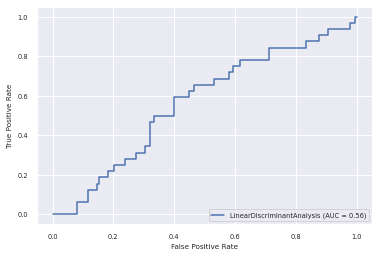

<function matplotlib.pyplot.show>

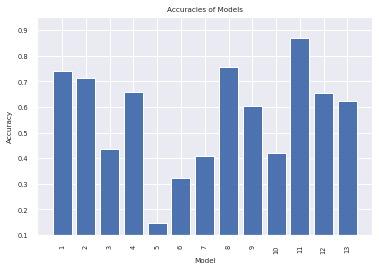

In [ ]:
Accuracy = []

clf = LinearDiscriminantAnalysis()

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train, train_class.ravel())
    model = SelectFromModel(lsvc, prefit=True)
    train = model.transform(train)
    test = model.transform(test)
    clf.fit(train, train_class.ravel())

    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show


#### Tree Based Feature Selection

This is the starting index: 0 of patient 0
0.7958115183246073
[([1], 1, array([0.49, 0.51])), ([1], 1, array([0.43, 0.57])), ([0], 1, array([0.45, 0.55])), ([1], 0, array([0.84, 0.16])), ([1], 1, array([0.31, 0.69])), ([0], 0, array([0.82, 0.18])), ([1], 0, array([0.69, 0.31])), ([0], 1, array([0.42, 0.58])), ([1], 1, array([0.23, 0.77])), ([0], 0, array([0.64, 0.36])), ([0], 0, array([0.6, 0.4])), ([1], 0, array([0.56, 0.44])), ([1], 0, array([0.59, 0.41])), ([0], 0, array([0.5, 0.5])), ([1], 1, array([0.29, 0.71])), ([1], 1, array([0.35, 0.65])), ([1], 0, array([0.56, 0.44])), ([1], 0, array([0.77, 0.23])), ([1], 0, array([0.6, 0.4])), ([1], 1, array([0.46, 0.54])), ([0], 0, array([0.57, 0.43])), ([1], 0, array([0.86, 0.14])), ([1], 0, array([0.52, 0.48])), ([1], 1, array([0.22, 0.78])), ([0], 0, array([0.85, 0.15])), ([0], 0, array([0.66, 0.34])), ([1], 0, array([0.69, 0.31])), ([1], 0, array([0.5, 0.5])), ([0], 0, array([0.69, 0.31])), ([0], 0, array([0.76, 0.24])), ([0], 0, array(

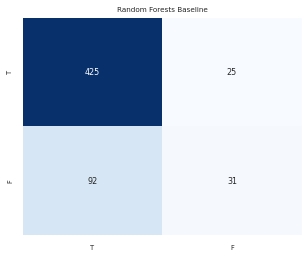

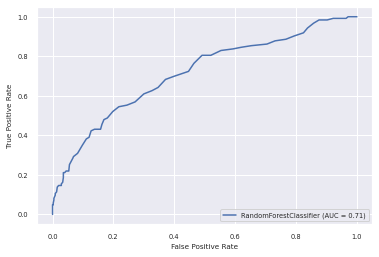

This is the starting index: 574 of patient 1
0.7339055793991416
[([0], 1, array([0.34, 0.66])), ([0], 1, array([0.28, 0.72])), ([0], 0, array([0.7, 0.3])), ([0], 1, array([0.45, 0.55])), ([0], 0, array([0.53, 0.47])), ([0], 0, array([0.72, 0.28])), ([1], 1, array([0.24, 0.76])), ([0], 0, array([0.52, 0.48])), ([0], 1, array([0.48, 0.52])), ([0], 0, array([0.75, 0.25])), ([0], 0, array([0.69, 0.31])), ([0], 1, array([0.42, 0.58])), ([1], 0, array([0.58, 0.42])), ([0], 1, array([0.47, 0.53])), ([0], 0, array([0.82, 0.18])), ([0], 0, array([0.53, 0.47])), ([0], 0, array([0.51, 0.49])), ([0], 0, array([0.59, 0.41])), ([1], 0, array([0.79, 0.21])), ([0], 0, array([0.66, 0.34])), ([1], 1, array([0.1, 0.9])), ([0], 0, array([0.73, 0.27])), ([1], 1, array([0.11, 0.89])), ([0], 0, array([0.65, 0.35])), ([1], 0, array([0.58, 0.42])), ([0], 0, array([0.76, 0.24])), ([0], 0, array([0.72, 0.28])), ([0], 0, array([0.73, 0.27])), ([0], 0, array([0.8, 0.2])), ([1], 1, array([0.09, 0.91])), ([1], 1, ar

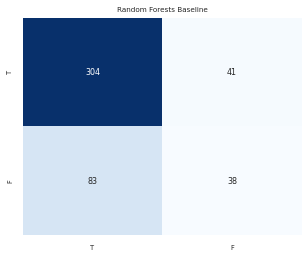

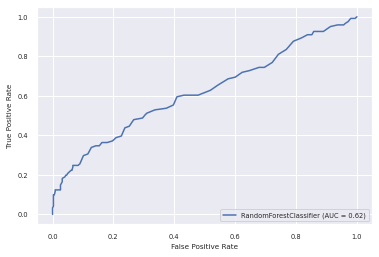

This is the starting index: 1041 of patient 2
0.28668941979522183
[([1], 1, array([0.19, 0.81])), ([0], 0, array([0.56, 0.44])), ([0], 0, array([0.6, 0.4])), ([1], 1, array([0.13, 0.87])), ([0], 0, array([0.62, 0.38])), ([0], 1, array([0.42, 0.58])), ([0], 1, array([0.49, 0.51])), ([1], 1, array([0.05, 0.95])), ([1], 0, array([0.62, 0.38])), ([1], 1, array([0.4, 0.6])), ([1], 0, array([0.6, 0.4])), ([1], 1, array([0.17, 0.83])), ([1], 1, array([0.06, 0.94])), ([0], 1, array([0.46, 0.54])), ([1], 1, array([0.3, 0.7])), ([1], 1, array([0.07, 0.93])), ([0], 1, array([0.11, 0.89])), ([0], 1, array([0.09, 0.91])), ([0], 1, array([0.25, 0.75])), ([0], 0, array([0.56, 0.44])), ([0], 1, array([0.1, 0.9])), ([0], 1, array([0.36, 0.64])), ([0], 1, array([0.26, 0.74])), ([0], 1, array([0.11, 0.89])), ([0], 1, array([0.22, 0.78])), ([0], 1, array([0.05, 0.95])), ([0], 0, array([0.61, 0.39])), ([0], 1, array([0.09, 0.91])), ([0], 1, array([0.07, 0.93])), ([0], 1, array([0.13, 0.87])), ([0], 1, arra

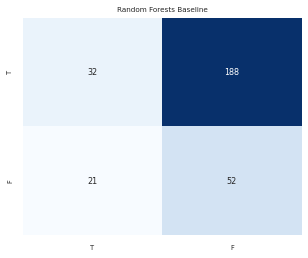

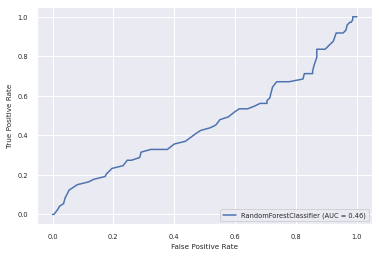

This is the starting index: 1335 of patient 3
0.6190476190476191
[([0], 1, array([0.48, 0.52])), ([1], 1, array([0.47, 0.53])), ([1], 1, array([0.09, 0.91])), ([1], 1, array([0.46, 0.54])), ([1], 1, array([0.38, 0.62])), ([1], 0, array([0.56, 0.44])), ([1], 1, array([0.38, 0.62])), ([0], 1, array([0.42, 0.58])), ([0], 0, array([0.66, 0.34])), ([0], 1, array([0.46, 0.54])), ([0], 0, array([0.53, 0.47])), ([0], 0, array([0.66, 0.34])), ([0], 0, array([0.67, 0.33])), ([1], 0, array([0.63, 0.37])), ([0], 1, array([0.39, 0.61])), ([0], 1, array([0.49, 0.51])), ([0], 0, array([0.7, 0.3])), ([0], 1, array([0.07, 0.93])), ([0], 0, array([0.69, 0.31])), ([0], 0, array([0.53, 0.47])), ([0], 0, array([0.66, 0.34])), ([0], 1, array([0.29, 0.71])), ([0], 1, array([0.45, 0.55])), ([0], 0, array([0.65, 0.35])), ([0], 0, array([0.74, 0.26])), ([0], 0, array([0.58, 0.42])), ([0], 1, array([0.32, 0.68])), ([0], 0, array([0.95, 0.05])), ([0], 1, array([0.41, 0.59])), ([1], 0, array([0.6, 0.4])), ([0], 1,

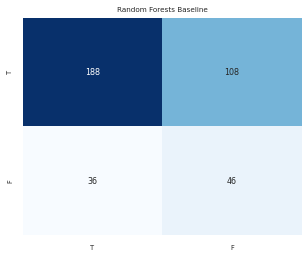

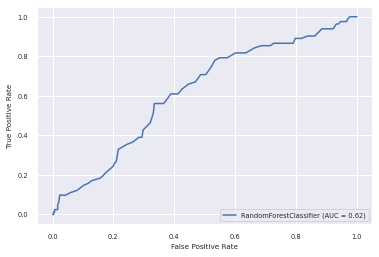

This is the starting index: 1714 of patient 4
0.5382059800664452
[([1], 1, array([0.38, 0.62])), ([1], 1, array([0.3, 0.7])), ([1], 0, array([0.59, 0.41])), ([1], 1, array([0.46, 0.54])), ([1], 1, array([0.38, 0.62])), ([1], 0, array([0.7, 0.3])), ([1], 0, array([0.62, 0.38])), ([1], 1, array([0.42, 0.58])), ([1], 0, array([0.6, 0.4])), ([1], 0, array([0.57, 0.43])), ([1], 1, array([0.49, 0.51])), ([1], 1, array([0.37, 0.63])), ([1], 1, array([0.26, 0.74])), ([1], 1, array([0.43, 0.57])), ([1], 1, array([0.41, 0.59])), ([1], 1, array([0.34, 0.66])), ([1], 1, array([0.24, 0.76])), ([1], 1, array([0.41, 0.59])), ([1], 1, array([0.28, 0.72])), ([1], 1, array([0.48, 0.52])), ([1], 1, array([0.41, 0.59])), ([1], 1, array([0.27, 0.73])), ([1], 1, array([0.44, 0.56])), ([1], 1, array([0.4, 0.6])), ([1], 1, array([0.4, 0.6])), ([1], 1, array([0.32, 0.68])), ([1], 1, array([0.22, 0.78])), ([1], 0, array([0.6, 0.4])), ([1], 0, array([0.57, 0.43])), ([1], 0, array([0.51, 0.49])), ([1], 0, array([

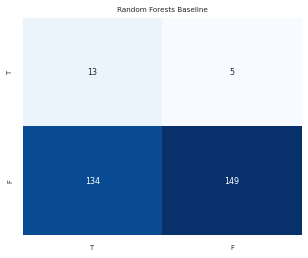

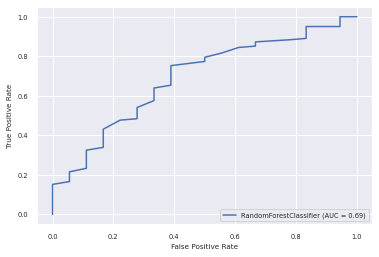

This is the starting index: 2016 of patient 5
0.44567627494456763
[([0], 0, array([0.68, 0.32])), ([0], 0, array([0.8, 0.2])), ([0], 0, array([0.79, 0.21])), ([0], 0, array([0.73, 0.27])), ([0], 0, array([0.75, 0.25])), ([0], 0, array([0.77, 0.23])), ([1], 0, array([0.87, 0.13])), ([1], 0, array([0.91, 0.09])), ([1], 0, array([0.81, 0.19])), ([1], 0, array([0.85, 0.15])), ([0], 0, array([0.78, 0.22])), ([1], 0, array([0.82, 0.18])), ([0], 0, array([0.6, 0.4])), ([1], 0, array([0.6, 0.4])), ([1], 0, array([0.83, 0.17])), ([1], 0, array([0.83, 0.17])), ([1], 0, array([0.64, 0.36])), ([1], 0, array([0.77, 0.23])), ([1], 0, array([0.78, 0.22])), ([1], 0, array([0.92, 0.08])), ([1], 1, array([0.09, 0.91])), ([1], 0, array([0.71, 0.29])), ([1], 0, array([0.86, 0.14])), ([1], 0, array([0.55, 0.45])), ([1], 0, array([0.83, 0.17])), ([1], 0, array([0.77, 0.23])), ([1], 1, array([0.13, 0.87])), ([1], 0, array([0.61, 0.39])), ([1], 0, array([0.68, 0.32])), ([1], 0, array([0.5, 0.5])), ([1], 0, ar

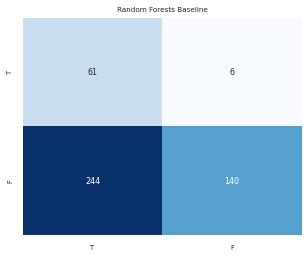

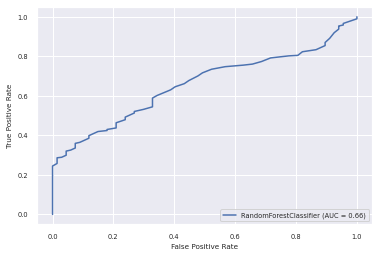

This is the starting index: 2468 of patient 6
0.5538057742782152
[([1], 1, array([0.43, 0.57])), ([1], 1, array([0.31, 0.69])), ([1], 1, array([0.34, 0.66])), ([1], 0, array([0.65, 0.35])), ([1], 0, array([0.82, 0.18])), ([1], 1, array([0.35, 0.65])), ([1], 1, array([0.27, 0.73])), ([1], 0, array([0.82, 0.18])), ([1], 0, array([0.65, 0.35])), ([1], 0, array([0.76, 0.24])), ([0], 0, array([0.91, 0.09])), ([1], 1, array([0.24, 0.76])), ([1], 0, array([0.9, 0.1])), ([1], 1, array([0.32, 0.68])), ([1], 0, array([0.71, 0.29])), ([1], 0, array([0.5, 0.5])), ([1], 1, array([0.15, 0.85])), ([1], 1, array([0.37, 0.63])), ([1], 1, array([0.2, 0.8])), ([0], 0, array([0.65, 0.35])), ([1], 0, array([0.55, 0.45])), ([1], 0, array([0.82, 0.18])), ([1], 1, array([0.42, 0.58])), ([1], 1, array([0.32, 0.68])), ([1], 1, array([0.39, 0.61])), ([1], 0, array([0.61, 0.39])), ([1], 0, array([0.79, 0.21])), ([0], 1, array([0.29, 0.71])), ([0], 0, array([0.8, 0.2])), ([1], 1, array([0.43, 0.57])), ([1], 0, arr

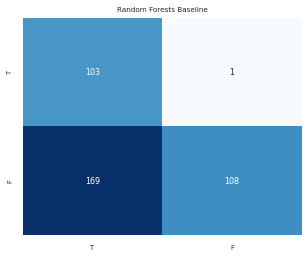

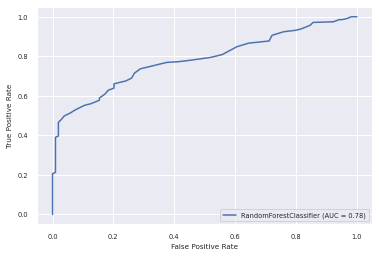

This is the starting index: 2850 of patient 7
0.822680412371134
[([0], 0, array([0.6, 0.4])), ([0], 0, array([0.74, 0.26])), ([0], 0, array([0.76, 0.24])), ([0], 0, array([0.54, 0.46])), ([0], 0, array([0.57, 0.43])), ([0], 0, array([0.75, 0.25])), ([0], 0, array([0.8, 0.2])), ([0], 0, array([0.87, 0.13])), ([0], 0, array([0.69, 0.31])), ([0], 0, array([0.73, 0.27])), ([0], 0, array([0.75, 0.25])), ([0], 0, array([0.91, 0.09])), ([0], 1, array([0.24, 0.76])), ([0], 1, array([0.27, 0.73])), ([0], 0, array([0.62, 0.38])), ([0], 0, array([0.91, 0.09])), ([0], 0, array([0.83, 0.17])), ([0], 0, array([0.72, 0.28])), ([0], 0, array([0.78, 0.22])), ([0], 0, array([0.77, 0.23])), ([0], 0, array([0.72, 0.28])), ([0], 0, array([0.9, 0.1])), ([0], 0, array([0.63, 0.37])), ([0], 1, array([0.49, 0.51])), ([0], 0, array([0.65, 0.35])), ([0], 1, array([0.46, 0.54])), ([0], 0, array([0.75, 0.25])), ([0], 0, array([0.89, 0.11])), ([0], 1, array([0.44, 0.56])), ([0], 0, array([0.64, 0.36])), ([1], 0, ar

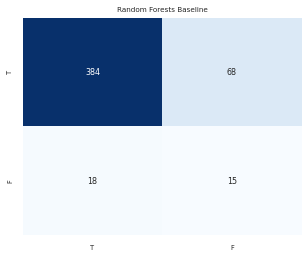

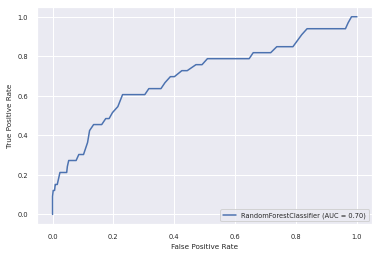

This is the starting index: 3336 of patient 8
0.7283737024221453
[([1], 0, array([0.79, 0.21])), ([1], 1, array([0.33, 0.67])), ([0], 0, array([0.78, 0.22])), ([1], 0, array([0.62, 0.38])), ([1], 1, array([0.33, 0.67])), ([1], 1, array([0.26, 0.74])), ([1], 0, array([0.53, 0.47])), ([1], 1, array([0.19, 0.81])), ([1], 1, array([0.33, 0.67])), ([1], 1, array([0.11, 0.89])), ([0], 0, array([0.5, 0.5])), ([1], 1, array([0.37, 0.63])), ([0], 0, array([0.77, 0.23])), ([1], 1, array([0.46, 0.54])), ([1], 1, array([0.31, 0.69])), ([0], 0, array([0.82, 0.18])), ([0], 0, array([0.62, 0.38])), ([1], 0, array([0.67, 0.33])), ([1], 1, array([0.14, 0.86])), ([1], 0, array([0.72, 0.28])), ([1], 1, array([0.31, 0.69])), ([0], 0, array([0.56, 0.44])), ([1], 1, array([0.29, 0.71])), ([0], 0, array([0.71, 0.29])), ([1], 1, array([0.14, 0.86])), ([0], 1, array([0.26, 0.74])), ([0], 0, array([0.71, 0.29])), ([0], 1, array([0.43, 0.57])), ([0], 0, array([0.77, 0.23])), ([1], 1, array([0.31, 0.69])), ([1], 

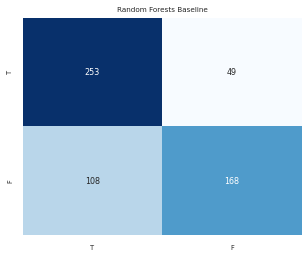

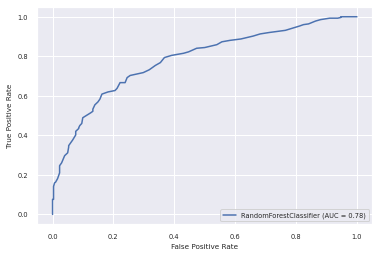

This is the starting index: 3915 of patient 9
0.5892857142857143
[([1], 1, array([0.18, 0.82])), ([1], 1, array([0.48, 0.52])), ([1], 0, array([0.54, 0.46])), ([1], 0, array([0.6, 0.4])), ([1], 1, array([0.25, 0.75])), ([1], 1, array([0.3, 0.7])), ([1], 0, array([0.62, 0.38])), ([1], 0, array([0.64, 0.36])), ([1], 1, array([0.49, 0.51])), ([1], 0, array([0.71, 0.29])), ([1], 1, array([0.17, 0.83])), ([1], 0, array([0.54, 0.46])), ([1], 1, array([0.33, 0.67])), ([1], 1, array([0.47, 0.53])), ([1], 0, array([0.6, 0.4])), ([1], 0, array([0.71, 0.29])), ([1], 1, array([0.47, 0.53])), ([1], 1, array([0.3, 0.7])), ([1], 0, array([0.6, 0.4])), ([1], 1, array([0.43, 0.57])), ([1], 1, array([0.21, 0.79])), ([1], 0, array([0.68, 0.32])), ([1], 0, array([0.6, 0.4])), ([1], 0, array([0.68, 0.32])), ([1], 0, array([0.55, 0.45])), ([0], 0, array([0.51, 0.49])), ([0], 1, array([0.38, 0.62])), ([1], 1, array([0.28, 0.72])), ([1], 0, array([0.8, 0.2])), ([1], 1, array([0.3, 0.7])), ([1], 1, array([0.17

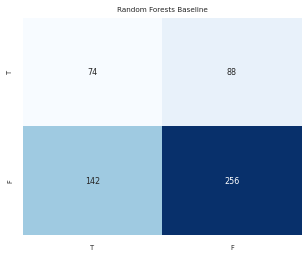

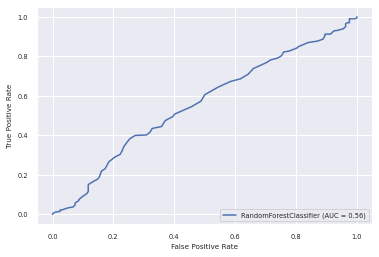

This is the starting index: 4476 of patient 10
0.8534322820037106
[([0], 0, array([0.62, 0.38])), ([0], 0, array([0.67, 0.33])), ([0], 0, array([0.53, 0.47])), ([0], 0, array([0.67, 0.33])), ([0], 0, array([0.68, 0.32])), ([0], 0, array([0.71, 0.29])), ([1], 1, array([0.49, 0.51])), ([1], 0, array([0.64, 0.36])), ([0], 0, array([0.88, 0.12])), ([0], 0, array([0.83, 0.17])), ([1], 1, array([0.48, 0.52])), ([1], 1, array([0.43, 0.57])), ([1], 0, array([0.54, 0.46])), ([0], 0, array([0.9, 0.1])), ([0], 0, array([0.59, 0.41])), ([0], 0, array([0.92, 0.08])), ([0], 0, array([0.78, 0.22])), ([0], 0, array([0.79, 0.21])), ([1], 1, array([0.4, 0.6])), ([0], 0, array([0.52, 0.48])), ([1], 0, array([0.83, 0.17])), ([0], 0, array([0.94, 0.06])), ([0], 0, array([0.68, 0.32])), ([0], 0, array([0.68, 0.32])), ([0], 0, array([0.86, 0.14])), ([1], 0, array([0.69, 0.31])), ([0], 0, array([0.67, 0.33])), ([0], 0, array([0.67, 0.33])), ([0], 0, array([0.62, 0.38])), ([0], 0, array([0.67, 0.33])), ([0], 1

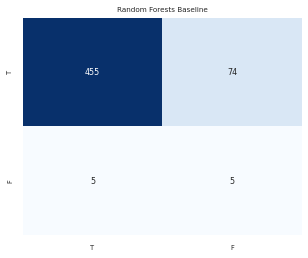

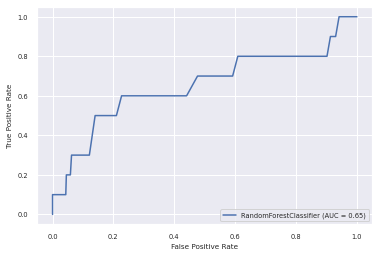

This is the starting index: 5016 of patient 11
0.7424242424242424
[([0], 1, array([0.49, 0.51])), ([0], 1, array([0.39, 0.61])), ([0], 0, array([0.78, 0.22])), ([0], 0, array([0.87, 0.13])), ([0], 1, array([0.24, 0.76])), ([0], 0, array([0.76, 0.24])), ([0], 0, array([0.51, 0.49])), ([0], 0, array([0.79, 0.21])), ([0], 0, array([0.66, 0.34])), ([0], 0, array([0.73, 0.27])), ([0], 0, array([0.78, 0.22])), ([0], 0, array([0.77, 0.23])), ([0], 0, array([0.68, 0.32])), ([1], 0, array([0.55, 0.45])), ([0], 0, array([0.76, 0.24])), ([1], 0, array([0.68, 0.32])), ([0], 0, array([0.67, 0.33])), ([0], 0, array([0.74, 0.26])), ([0], 0, array([0.91, 0.09])), ([1], 0, array([0.93, 0.07])), ([0], 0, array([0.62, 0.38])), ([0], 0, array([0.92, 0.08])), ([0], 0, array([0.87, 0.13])), ([0], 0, array([0.93, 0.07])), ([1], 0, array([0.72, 0.28])), ([0], 0, array([0.81, 0.19])), ([1], 0, array([0.88, 0.12])), ([1], 1, array([0.15, 0.85])), ([0], 0, array([0.76, 0.24])), ([0], 0, array([0.76, 0.24])), ([0

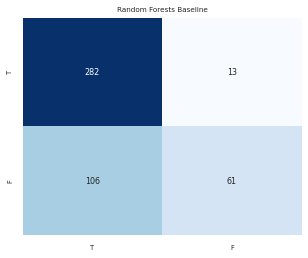

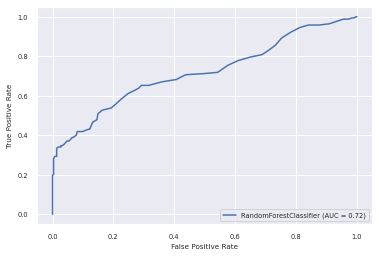

This is the starting index: 5479 of patient 12
0.3352941176470588
[([0], 1, array([0.36, 0.64])), ([0], 1, array([0.4, 0.6])), ([0], 1, array([0.23, 0.77])), ([0], 1, array([0.35, 0.65])), ([0], 0, array([0.61, 0.39])), ([0], 1, array([0.24, 0.76])), ([0], 1, array([0.33, 0.67])), ([0], 1, array([0.32, 0.68])), ([0], 1, array([0.39, 0.61])), ([0], 1, array([0.31, 0.69])), ([0], 1, array([0.19, 0.81])), ([0], 1, array([0.25, 0.75])), ([0], 1, array([0.48, 0.52])), ([0], 1, array([0.24, 0.76])), ([0], 1, array([0.24, 0.76])), ([0], 1, array([0.29, 0.71])), ([0], 0, array([0.52, 0.48])), ([0], 1, array([0.39, 0.61])), ([0], 1, array([0.48, 0.52])), ([0], 1, array([0.28, 0.72])), ([0], 1, array([0.3, 0.7])), ([0], 1, array([0.32, 0.68])), ([0], 1, array([0.36, 0.64])), ([0], 1, array([0.38, 0.62])), ([0], 1, array([0.43, 0.57])), ([0], 1, array([0.27, 0.73])), ([0], 1, array([0.46, 0.54])), ([0], 1, array([0.37, 0.63])), ([0], 1, array([0.32, 0.68])), ([0], 1, array([0.35, 0.65])), ([0], 1

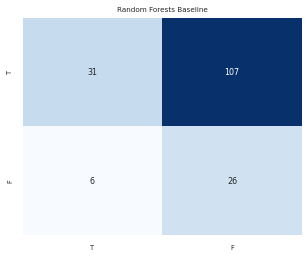

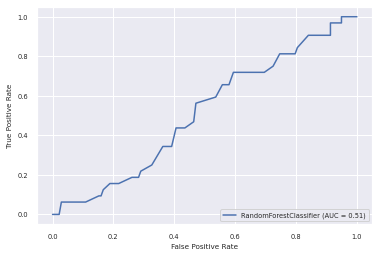

<function matplotlib.pyplot.show>

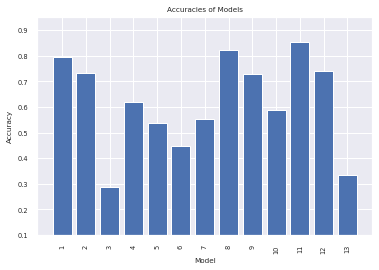

In [ ]:
Accuracy = []

clf = LinearDiscriminantAnalysis()

for i in range(0,13):
    test, train, test_class, train_class = leave_one_out(df,i)
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(train, train_class.ravel())
    model = SelectFromModel(clf, prefit=True)
    train = model.transform(train)
    # clf = ExtraTreesClassifier(n_estimators=50)
    # clf = clf.fit(test, test_class.ravel())
    # model = SelectFromModel(clf, prefit=True) 

    test = model.transform(test)
    clf = RandomForestClassifier()
    clf.fit(train, train_class.ravel())


    y_predicted = clf.predict(test)
    print(metrics.accuracy_score(test_class,y_predicted))
        # print("Random Forest:\n",metrics.classification_report(test_class,y_predicted)) # Classification report
    Accuracy.append(metrics.accuracy_score(test_class,y_predicted))
    pred = clf.predict_proba(test)
    result = [*zip(test_class.tolist(), y_predicted, pred)]
    print(result)
    report = metrics.classification_report(test_class.tolist(), y_predicted)
    matrix = metrics.confusion_matrix(test_class.tolist(),y_predicted)   

    fig, (ax1) = plt.subplots(1, figsize=(5, 4))


    df_cm1 = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=0.6) # for label size
    sn.heatmap(df_cm1, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


    ax1.set_title('Random Forests Baseline')

    plt.show()
    metrics.plot_roc_curve(clf, test, test_class.tolist())  # doctest: +SKIP
    plt.show()

Model=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13]
fig, ax = plt.subplots()
ax.set(ylim=[0.1, 0.95])
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

#### Auto Sklearn Recommendation

In [ ]:
#SVM with manual parameters
svm = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                         ('svm', SGDClassifier(loss='hinge', alpha=1e-3, random_state=42)),])

SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'extra_trees_preproc_for_classification', 'classifier:random_forest:bootstrap': 'False', 'classifier:random_forest:criterion': 'entropy', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.27453376891983117, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 13, 'classifier:random_forest:min_samples_split': 19, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.2166847947584762, 'feature_preprocessor:extra_trees_preproc_for_classification:bootstrap': 'False', 'feature_preprocessor:extra_trees_preproc_for_classification:criterion': 'entropy', 'feature_preprocessor:extra_trees_preproc_for_classification:max_depth': 'None', 'feature_preprocessor:extra_trees_preproc_for_classification:max_features': 0.2819773130241576, 'feature_preprocessor:extra_trees_preproc_for_classification:max_leaf_nodes': 'None', 'feature_preprocessor:extra_trees_preproc_for_classification:min_impurity_decrease': 0.0, 'feature_preprocessor:extra_trees_preproc_for_classification:min_samples_leaf': 20, 'feature_preprocessor:extra_trees_preproc_for_classification:min_samples_split': 3, 'feature_preprocessor:extra_trees_preproc_for_classification:min_weight_fraction_leaf': 0.0, 'feature_preprocessor:extra_trees_preproc_for_classification:n_estimators': 100},
d